# Monet GAN

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

E0000 00:00:1724162046.057561      77 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D0820 13:54:06.074125094      77 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D0820 13:54:06.074141217      77 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D0820 13:54:06.074145154      77 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D0820 13:54:06.074147921      77 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D0820 13:54:06.074150643      77 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

Device: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1724162059.825355      77 service.cc:145] XLA service 0x5c26b0eaca40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724162059.825411      77 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1724162059.825416      77 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1724162059.825419      77 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1724162059.825422      77 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1724162059.825424      77 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1724162059.825427      77 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1724162059.825430      77 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1724162059.825433      77 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of replicas: 8
2.16.1


In [2]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, gamma_initializer=None, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.gamma_initializer if self.gamma_initializer else 'ones',
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

# Load Data

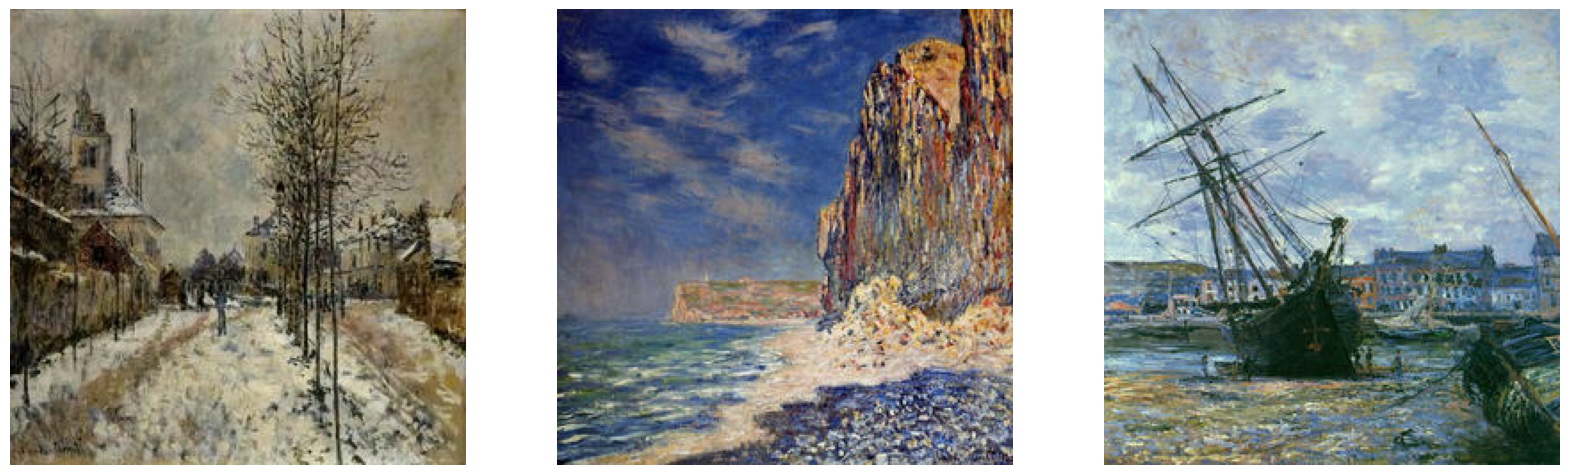

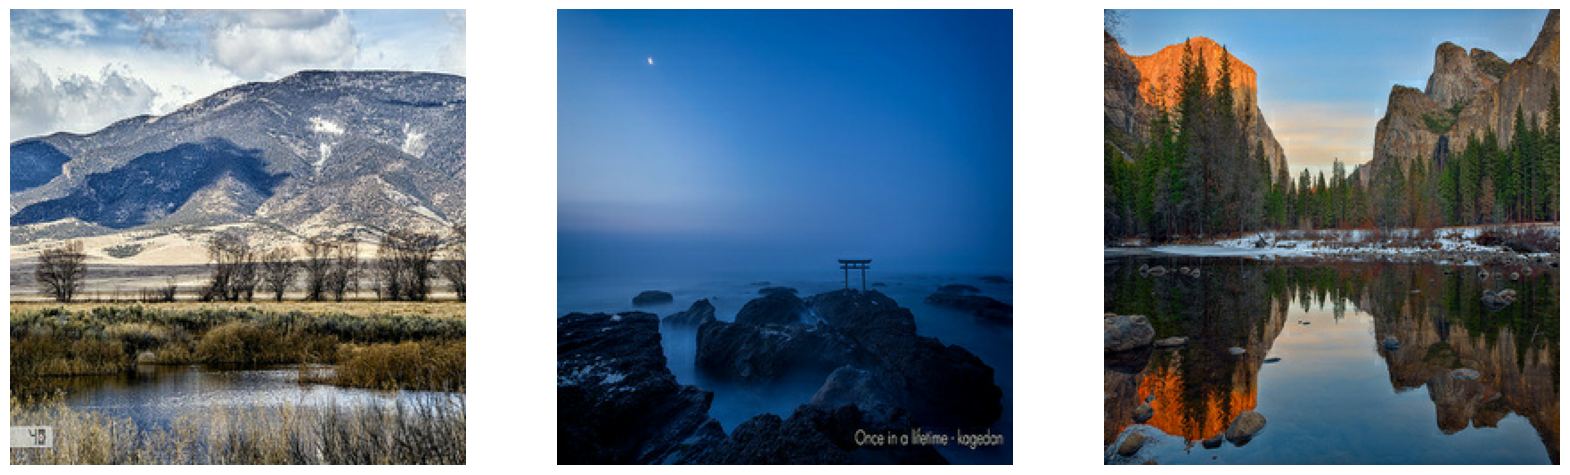

In [3]:
MONET_TFREC_PATH = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
PHOTO_TFREC_PATH = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

IMAGE_SIZE = [256, 256]

# Function to decode TFRecord
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.repeat()
    dataset = dataset.batch(1)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

monet_ds = load_dataset(tf.io.gfile.glob(MONET_TFREC_PATH))#.batch(1)
photo_ds = load_dataset(tf.io.gfile.glob(PHOTO_TFREC_PATH))#.batch(1)

def display_samples(dataset, n):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(dataset.take(n)):
        plt.subplot(1, n, i + 1)
        plt.imshow(np.squeeze((image + 1.0) / 2.0))  # Rescale to [0, 1] for display
        plt.axis('off')
    plt.show()

display_samples(monet_ds, 3)
display_samples(photo_ds, 3)

# Build CycleGAN Model

In [4]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        #result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
        result.add(InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    #result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    result.add(InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    #norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    norm1 = InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

In [5]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet style
    photo_generator = Generator() # transforms Monet paintings to be photo like

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

In [6]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Loss Functions

In [7]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1
    
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train CycleGAN

In [8]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

I0000 00:00:1724162068.391272      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25


2024-08-20 13:55:29.467996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.


I0000 00:00:1724162131.935251     840 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(58235bd33121a66e:0:0), session_name()


I0000 00:00:1724162170.676700     840 tpu_compile_op_common.cc:245] Compilation of 58235bd33121a66e:0:0 with session name  took 38.741362386s and succeeded
I0000 00:00:1724162170.799866     840 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(58235bd33121a66e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_3684471860634478679", property.function_library_fingerprint = 2317530895857620821, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,256,256,3,;2,256,256,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1724162170.799939     840 tpu_compilation_cache_interface.cc:541] After adding entry f


      1/Unknown 102s 102s/step - monet_disc_loss: 0.6937 - monet_gen_loss: 9.0124 - photo_disc_loss: 0.6932 - photo_gen_loss: 9.6103


      2/Unknown 102s 133ms/step - monet_disc_loss: 0.6931 - monet_gen_loss: 9.9622 - photo_disc_loss: 0.6925 - photo_gen_loss: 10.8729


      3/Unknown 102s 133ms/step - monet_disc_loss: 0.6928 - monet_gen_loss: 10.5100 - photo_disc_loss: 0.6925 - photo_gen_loss: 11.3045


      4/Unknown 103s 135ms/step - monet_disc_loss: 0.6926 - monet_gen_loss: 10.7971 - photo_disc_loss: 0.6921 - photo_gen_loss: 11.6410


      5/Unknown 103s 136ms/step - monet_disc_loss: 0.6927 - monet_gen_loss: 10.9431 - photo_disc_loss: 0.6922 - photo_gen_loss: 11.4291


      6/Unknown 103s 134ms/step - monet_disc_loss: 0.6922 - monet_gen_loss: 11.2253 - photo_disc_loss: 0.6918 - photo_gen_loss: 11.5779


      7/Unknown 103s 133ms/step - monet_disc_loss: 0.6920 - monet_gen_loss: 10.7521 - photo_disc_loss: 0.6918 - photo_gen_loss: 11.3113


      8/Unknown 103s 134ms/step - monet_disc_loss: 0.6920 - monet_gen_loss: 11.0133 - photo_disc_loss: 0.6919 - photo_gen_loss: 11.5392


      9/Unknown 103s 134ms/step - monet_disc_loss: 0.6920 - monet_gen_loss: 11.1470 - photo_disc_loss: 0.6921 - photo_gen_loss: 11.7125


     10/Unknown 103s 134ms/step - monet_disc_loss: 0.6916 - monet_gen_loss: 11.5293 - photo_disc_loss: 0.6917 - photo_gen_loss: 12.0482


     11/Unknown 103s 134ms/step - monet_disc_loss: 0.6913 - monet_gen_loss: 11.5273 - photo_disc_loss: 0.6915 - photo_gen_loss: 11.9605


     12/Unknown 104s 133ms/step - monet_disc_loss: 0.6909 - monet_gen_loss: 11.4660 - photo_disc_loss: 0.6912 - photo_gen_loss: 11.8683


     13/Unknown 104s 133ms/step - monet_disc_loss: 0.6905 - monet_gen_loss: 11.6478 - photo_disc_loss: 0.6909 - photo_gen_loss: 12.0903


     14/Unknown 104s 134ms/step - monet_disc_loss: 0.6904 - monet_gen_loss: 11.5522 - photo_disc_loss: 0.6908 - photo_gen_loss: 12.0164


     15/Unknown 104s 133ms/step - monet_disc_loss: 0.6900 - monet_gen_loss: 11.4567 - photo_disc_loss: 0.6903 - photo_gen_loss: 11.8803


     16/Unknown 104s 134ms/step - monet_disc_loss: 0.6896 - monet_gen_loss: 11.5605 - photo_disc_loss: 0.6901 - photo_gen_loss: 11.9953


     17/Unknown 104s 134ms/step - monet_disc_loss: 0.6898 - monet_gen_loss: 11.3950 - photo_disc_loss: 0.6902 - photo_gen_loss: 11.8107


     18/Unknown 104s 133ms/step - monet_disc_loss: 0.6896 - monet_gen_loss: 11.3708 - photo_disc_loss: 0.6902 - photo_gen_loss: 11.8063


     19/Unknown 105s 134ms/step - monet_disc_loss: 0.6892 - monet_gen_loss: 11.3129 - photo_disc_loss: 0.6898 - photo_gen_loss: 11.7389


     20/Unknown 105s 133ms/step - monet_disc_loss: 0.6889 - monet_gen_loss: 11.1234 - photo_disc_loss: 0.6896 - photo_gen_loss: 11.5997


     21/Unknown 105s 134ms/step - monet_disc_loss: 0.6884 - monet_gen_loss: 11.1030 - photo_disc_loss: 0.6894 - photo_gen_loss: 11.6000


     22/Unknown 105s 133ms/step - monet_disc_loss: 0.6878 - monet_gen_loss: 11.0707 - photo_disc_loss: 0.6888 - photo_gen_loss: 11.5359


     23/Unknown 105s 133ms/step - monet_disc_loss: 0.6875 - monet_gen_loss: 10.9503 - photo_disc_loss: 0.6887 - photo_gen_loss: 11.4447


     24/Unknown 105s 133ms/step - monet_disc_loss: 0.6869 - monet_gen_loss: 10.8593 - photo_disc_loss: 0.6884 - photo_gen_loss: 11.3632


     25/Unknown 105s 133ms/step - monet_disc_loss: 0.6859 - monet_gen_loss: 10.9790 - photo_disc_loss: 0.6876 - photo_gen_loss: 11.5233


     26/Unknown 105s 133ms/step - monet_disc_loss: 0.6860 - monet_gen_loss: 10.8435 - photo_disc_loss: 0.6877 - photo_gen_loss: 11.3794


     27/Unknown 106s 133ms/step - monet_disc_loss: 0.6854 - monet_gen_loss: 10.6820 - photo_disc_loss: 0.6873 - photo_gen_loss: 11.2258


     28/Unknown 106s 133ms/step - monet_disc_loss: 0.6844 - monet_gen_loss: 10.6228 - photo_disc_loss: 0.6864 - photo_gen_loss: 11.1423


     29/Unknown 106s 133ms/step - monet_disc_loss: 0.6845 - monet_gen_loss: 10.5313 - photo_disc_loss: 0.6868 - photo_gen_loss: 11.0135


     30/Unknown 106s 133ms/step - monet_disc_loss: 0.6846 - monet_gen_loss: 10.4109 - photo_disc_loss: 0.6863 - photo_gen_loss: 10.8894


     31/Unknown 106s 133ms/step - monet_disc_loss: 0.6842 - monet_gen_loss: 10.2648 - photo_disc_loss: 0.6859 - photo_gen_loss: 10.7516


     32/Unknown 106s 133ms/step - monet_disc_loss: 0.6834 - monet_gen_loss: 10.1141 - photo_disc_loss: 0.6854 - photo_gen_loss: 10.5933


     33/Unknown 106s 133ms/step - monet_disc_loss: 0.6828 - monet_gen_loss: 10.0171 - photo_disc_loss: 0.6847 - photo_gen_loss: 10.4777


     34/Unknown 107s 133ms/step - monet_disc_loss: 0.6817 - monet_gen_loss: 9.9486 - photo_disc_loss: 0.6838 - photo_gen_loss: 10.3774 


     35/Unknown 107s 134ms/step - monet_disc_loss: 0.6809 - monet_gen_loss: 9.8470 - photo_disc_loss: 0.6830 - photo_gen_loss: 10.2600


     36/Unknown 107s 133ms/step - monet_disc_loss: 0.6807 - monet_gen_loss: 9.7447 - photo_disc_loss: 0.6827 - photo_gen_loss: 10.1414


     37/Unknown 107s 134ms/step - monet_disc_loss: 0.6803 - monet_gen_loss: 9.6023 - photo_disc_loss: 0.6825 - photo_gen_loss: 9.9848 


     38/Unknown 107s 134ms/step - monet_disc_loss: 0.6796 - monet_gen_loss: 9.5001 - photo_disc_loss: 0.6820 - photo_gen_loss: 9.8790


     39/Unknown 107s 134ms/step - monet_disc_loss: 0.6797 - monet_gen_loss: 9.4037 - photo_disc_loss: 0.6826 - photo_gen_loss: 9.7840


     40/Unknown 107s 134ms/step - monet_disc_loss: 0.6786 - monet_gen_loss: 9.2972 - photo_disc_loss: 0.6816 - photo_gen_loss: 9.6711


     41/Unknown 108s 135ms/step - monet_disc_loss: 0.6773 - monet_gen_loss: 9.2048 - photo_disc_loss: 0.6803 - photo_gen_loss: 9.5804


     42/Unknown 108s 135ms/step - monet_disc_loss: 0.6758 - monet_gen_loss: 9.1493 - photo_disc_loss: 0.6791 - photo_gen_loss: 9.5140


     43/Unknown 108s 135ms/step - monet_disc_loss: 0.6743 - monet_gen_loss: 9.0436 - photo_disc_loss: 0.6777 - photo_gen_loss: 9.3939


     44/Unknown 108s 135ms/step - monet_disc_loss: 0.6732 - monet_gen_loss: 8.9815 - photo_disc_loss: 0.6766 - photo_gen_loss: 9.3199


     45/Unknown 108s 135ms/step - monet_disc_loss: 0.6715 - monet_gen_loss: 8.9158 - photo_disc_loss: 0.6752 - photo_gen_loss: 9.2588


     46/Unknown 108s 135ms/step - monet_disc_loss: 0.6709 - monet_gen_loss: 8.8488 - photo_disc_loss: 0.6754 - photo_gen_loss: 9.1846


     47/Unknown 108s 135ms/step - monet_disc_loss: 0.6695 - monet_gen_loss: 8.7636 - photo_disc_loss: 0.6739 - photo_gen_loss: 9.0943


     48/Unknown 108s 135ms/step - monet_disc_loss: 0.6704 - monet_gen_loss: 8.6968 - photo_disc_loss: 0.6745 - photo_gen_loss: 9.0235


     49/Unknown 109s 135ms/step - monet_disc_loss: 0.6694 - monet_gen_loss: 8.6259 - photo_disc_loss: 0.6744 - photo_gen_loss: 8.9508


     50/Unknown 109s 135ms/step - monet_disc_loss: 0.6685 - monet_gen_loss: 8.5411 - photo_disc_loss: 0.6737 - photo_gen_loss: 8.8637


     51/Unknown 109s 135ms/step - monet_disc_loss: 0.6685 - monet_gen_loss: 8.4761 - photo_disc_loss: 0.6735 - photo_gen_loss: 8.7976


     52/Unknown 109s 135ms/step - monet_disc_loss: 0.6674 - monet_gen_loss: 8.4207 - photo_disc_loss: 0.6723 - photo_gen_loss: 8.7494


     53/Unknown 109s 135ms/step - monet_disc_loss: 0.6675 - monet_gen_loss: 8.3399 - photo_disc_loss: 0.6723 - photo_gen_loss: 8.6584


     54/Unknown 109s 135ms/step - monet_disc_loss: 0.6662 - monet_gen_loss: 8.2748 - photo_disc_loss: 0.6714 - photo_gen_loss: 8.5935


     55/Unknown 109s 135ms/step - monet_disc_loss: 0.6643 - monet_gen_loss: 8.2206 - photo_disc_loss: 0.6696 - photo_gen_loss: 8.5211


     56/Unknown 110s 135ms/step - monet_disc_loss: 0.6627 - monet_gen_loss: 8.1651 - photo_disc_loss: 0.6696 - photo_gen_loss: 8.4476


     57/Unknown 110s 135ms/step - monet_disc_loss: 0.6624 - monet_gen_loss: 8.1270 - photo_disc_loss: 0.6696 - photo_gen_loss: 8.4130


     58/Unknown 110s 135ms/step - monet_disc_loss: 0.6604 - monet_gen_loss: 8.0917 - photo_disc_loss: 0.6680 - photo_gen_loss: 8.3688


     59/Unknown 110s 135ms/step - monet_disc_loss: 0.6608 - monet_gen_loss: 8.0395 - photo_disc_loss: 0.6699 - photo_gen_loss: 8.3085


     60/Unknown 110s 135ms/step - monet_disc_loss: 0.6588 - monet_gen_loss: 7.9680 - photo_disc_loss: 0.6681 - photo_gen_loss: 8.2315


     61/Unknown 110s 135ms/step - monet_disc_loss: 0.6574 - monet_gen_loss: 7.9320 - photo_disc_loss: 0.6667 - photo_gen_loss: 8.1875


     62/Unknown 110s 135ms/step - monet_disc_loss: 0.6559 - monet_gen_loss: 7.9026 - photo_disc_loss: 0.6656 - photo_gen_loss: 8.1620


     63/Unknown 110s 135ms/step - monet_disc_loss: 0.6548 - monet_gen_loss: 7.8725 - photo_disc_loss: 0.6648 - photo_gen_loss: 8.1355


     64/Unknown 111s 135ms/step - monet_disc_loss: 0.6551 - monet_gen_loss: 7.8104 - photo_disc_loss: 0.6660 - photo_gen_loss: 8.0690


     65/Unknown 111s 135ms/step - monet_disc_loss: 0.6540 - monet_gen_loss: 7.7711 - photo_disc_loss: 0.6656 - photo_gen_loss: 8.0183


     66/Unknown 111s 135ms/step - monet_disc_loss: 0.6537 - monet_gen_loss: 7.7191 - photo_disc_loss: 0.6650 - photo_gen_loss: 7.9589


     67/Unknown 111s 135ms/step - monet_disc_loss: 0.6529 - monet_gen_loss: 7.6942 - photo_disc_loss: 0.6642 - photo_gen_loss: 7.9311


     68/Unknown 111s 135ms/step - monet_disc_loss: 0.6517 - monet_gen_loss: 7.6604 - photo_disc_loss: 0.6632 - photo_gen_loss: 7.8905


     69/Unknown 111s 135ms/step - monet_disc_loss: 0.6498 - monet_gen_loss: 7.6324 - photo_disc_loss: 0.6622 - photo_gen_loss: 7.8589


     70/Unknown 111s 135ms/step - monet_disc_loss: 0.6483 - monet_gen_loss: 7.5869 - photo_disc_loss: 0.6608 - photo_gen_loss: 7.8106


     71/Unknown 112s 135ms/step - monet_disc_loss: 0.6462 - monet_gen_loss: 7.5507 - photo_disc_loss: 0.6591 - photo_gen_loss: 7.7687


     72/Unknown 112s 135ms/step - monet_disc_loss: 0.6445 - monet_gen_loss: 7.5091 - photo_disc_loss: 0.6577 - photo_gen_loss: 7.7364


     73/Unknown 112s 135ms/step - monet_disc_loss: 0.6424 - monet_gen_loss: 7.4682 - photo_disc_loss: 0.6560 - photo_gen_loss: 7.6996


     74/Unknown 112s 135ms/step - monet_disc_loss: 0.6398 - monet_gen_loss: 7.4290 - photo_disc_loss: 0.6539 - photo_gen_loss: 7.6526


     75/Unknown 112s 135ms/step - monet_disc_loss: 0.6407 - monet_gen_loss: 7.3924 - photo_disc_loss: 0.6550 - photo_gen_loss: 7.6089


     76/Unknown 112s 135ms/step - monet_disc_loss: 0.6391 - monet_gen_loss: 7.3657 - photo_disc_loss: 0.6530 - photo_gen_loss: 7.5921


     77/Unknown 112s 135ms/step - monet_disc_loss: 0.6377 - monet_gen_loss: 7.3358 - photo_disc_loss: 0.6528 - photo_gen_loss: 7.5589


     78/Unknown 112s 135ms/step - monet_disc_loss: 0.6370 - monet_gen_loss: 7.3108 - photo_disc_loss: 0.6525 - photo_gen_loss: 7.5379


     79/Unknown 113s 135ms/step - monet_disc_loss: 0.6344 - monet_gen_loss: 7.2829 - photo_disc_loss: 0.6506 - photo_gen_loss: 7.5008


     80/Unknown 113s 134ms/step - monet_disc_loss: 0.6324 - monet_gen_loss: 7.2554 - photo_disc_loss: 0.6487 - photo_gen_loss: 7.4656


     81/Unknown 113s 135ms/step - monet_disc_loss: 0.6315 - monet_gen_loss: 7.2209 - photo_disc_loss: 0.6480 - photo_gen_loss: 7.4292


     82/Unknown 113s 134ms/step - monet_disc_loss: 0.6293 - monet_gen_loss: 7.2039 - photo_disc_loss: 0.6459 - photo_gen_loss: 7.4122


     83/Unknown 113s 135ms/step - monet_disc_loss: 0.6272 - monet_gen_loss: 7.1735 - photo_disc_loss: 0.6437 - photo_gen_loss: 7.3852


     84/Unknown 113s 135ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 7.1463 - photo_disc_loss: 0.6442 - photo_gen_loss: 7.3681


     85/Unknown 113s 135ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 7.1260 - photo_disc_loss: 0.6464 - photo_gen_loss: 7.3372


     86/Unknown 114s 135ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 7.1005 - photo_disc_loss: 0.6460 - photo_gen_loss: 7.3053


     87/Unknown 114s 135ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 7.0726 - photo_disc_loss: 0.6452 - photo_gen_loss: 7.2724


     88/Unknown 114s 135ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 7.0545 - photo_disc_loss: 0.6453 - photo_gen_loss: 7.2529


     89/Unknown 114s 135ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 7.0305 - photo_disc_loss: 0.6432 - photo_gen_loss: 7.2297


     90/Unknown 114s 135ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 7.0098 - photo_disc_loss: 0.6421 - photo_gen_loss: 7.2060


     91/Unknown 114s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 6.9753 - photo_disc_loss: 0.6426 - photo_gen_loss: 7.1657


     92/Unknown 114s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 6.9550 - photo_disc_loss: 0.6420 - photo_gen_loss: 7.1473


     93/Unknown 114s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 6.9386 - photo_disc_loss: 0.6407 - photo_gen_loss: 7.1303


     94/Unknown 115s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 6.9144 - photo_disc_loss: 0.6403 - photo_gen_loss: 7.0975


     95/Unknown 115s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 6.8930 - photo_disc_loss: 0.6393 - photo_gen_loss: 7.0760


     96/Unknown 115s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 6.8704 - photo_disc_loss: 0.6378 - photo_gen_loss: 7.0569


     97/Unknown 115s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 6.8630 - photo_disc_loss: 0.6363 - photo_gen_loss: 7.0424


     98/Unknown 115s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 6.8389 - photo_disc_loss: 0.6356 - photo_gen_loss: 7.0151


     99/Unknown 115s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 6.8208 - photo_disc_loss: 0.6355 - photo_gen_loss: 7.0001


    100/Unknown 115s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 6.7912 - photo_disc_loss: 0.6358 - photo_gen_loss: 6.9716


    101/Unknown 116s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 6.7783 - photo_disc_loss: 0.6358 - photo_gen_loss: 6.9526


    102/Unknown 116s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 6.7740 - photo_disc_loss: 0.6353 - photo_gen_loss: 6.9446


    103/Unknown 116s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 6.7339 - photo_disc_loss: 0.6379 - photo_gen_loss: 6.9032


    104/Unknown 116s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 6.7239 - photo_disc_loss: 0.6372 - photo_gen_loss: 6.8899


    105/Unknown 116s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 6.7133 - photo_disc_loss: 0.6357 - photo_gen_loss: 6.8804


    106/Unknown 116s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 6.6984 - photo_disc_loss: 0.6347 - photo_gen_loss: 6.8580


    107/Unknown 116s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 6.6795 - photo_disc_loss: 0.6349 - photo_gen_loss: 6.8336


    108/Unknown 116s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 6.6735 - photo_disc_loss: 0.6342 - photo_gen_loss: 6.8273


    109/Unknown 117s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 6.6652 - photo_disc_loss: 0.6333 - photo_gen_loss: 6.8102


    110/Unknown 117s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 6.6661 - photo_disc_loss: 0.6328 - photo_gen_loss: 6.8042


    111/Unknown 117s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 6.6679 - photo_disc_loss: 0.6310 - photo_gen_loss: 6.8086


    112/Unknown 117s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 6.6432 - photo_disc_loss: 0.6319 - photo_gen_loss: 6.7902


    113/Unknown 117s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 6.6282 - photo_disc_loss: 0.6330 - photo_gen_loss: 6.7696


    114/Unknown 117s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 6.6166 - photo_disc_loss: 0.6314 - photo_gen_loss: 6.7623


    115/Unknown 117s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 6.5971 - photo_disc_loss: 0.6304 - photo_gen_loss: 6.7389


    116/Unknown 118s 134ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 6.5895 - photo_disc_loss: 0.6320 - photo_gen_loss: 6.7168


    117/Unknown 118s 134ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 6.5673 - photo_disc_loss: 0.6314 - photo_gen_loss: 6.6943


    118/Unknown 118s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 6.5526 - photo_disc_loss: 0.6312 - photo_gen_loss: 6.6784


    119/Unknown 118s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 6.5416 - photo_disc_loss: 0.6297 - photo_gen_loss: 6.6699


    120/Unknown 118s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 6.5284 - photo_disc_loss: 0.6297 - photo_gen_loss: 6.6554


    121/Unknown 118s 134ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 6.5120 - photo_disc_loss: 0.6309 - photo_gen_loss: 6.6434


    122/Unknown 118s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 6.4936 - photo_disc_loss: 0.6305 - photo_gen_loss: 6.6256


    123/Unknown 118s 134ms/step - monet_disc_loss: 0.5904 - monet_gen_loss: 6.4752 - photo_disc_loss: 0.6292 - photo_gen_loss: 6.6060


    124/Unknown 119s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 6.4497 - photo_disc_loss: 0.6300 - photo_gen_loss: 6.5835


    125/Unknown 119s 134ms/step - monet_disc_loss: 0.5909 - monet_gen_loss: 6.4381 - photo_disc_loss: 0.6289 - photo_gen_loss: 6.5689


    126/Unknown 119s 134ms/step - monet_disc_loss: 0.5921 - monet_gen_loss: 6.4309 - photo_disc_loss: 0.6281 - photo_gen_loss: 6.5565


    127/Unknown 119s 134ms/step - monet_disc_loss: 0.5909 - monet_gen_loss: 6.4197 - photo_disc_loss: 0.6263 - photo_gen_loss: 6.5415


    128/Unknown 119s 134ms/step - monet_disc_loss: 0.5905 - monet_gen_loss: 6.3981 - photo_disc_loss: 0.6258 - photo_gen_loss: 6.5229


    129/Unknown 119s 134ms/step - monet_disc_loss: 0.5924 - monet_gen_loss: 6.3847 - photo_disc_loss: 0.6275 - photo_gen_loss: 6.5068


    130/Unknown 119s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 6.3812 - photo_disc_loss: 0.6263 - photo_gen_loss: 6.5011


    131/Unknown 120s 134ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 6.3668 - photo_disc_loss: 0.6247 - photo_gen_loss: 6.4853


    132/Unknown 120s 134ms/step - monet_disc_loss: 0.5909 - monet_gen_loss: 6.3471 - photo_disc_loss: 0.6261 - photo_gen_loss: 6.4659


    133/Unknown 120s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 6.3327 - photo_disc_loss: 0.6260 - photo_gen_loss: 6.4493


    134/Unknown 120s 134ms/step - monet_disc_loss: 0.5903 - monet_gen_loss: 6.3207 - photo_disc_loss: 0.6268 - photo_gen_loss: 6.4322


    135/Unknown 120s 134ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 6.3040 - photo_disc_loss: 0.6283 - photo_gen_loss: 6.4145


    136/Unknown 120s 134ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 6.2903 - photo_disc_loss: 0.6293 - photo_gen_loss: 6.4007


    137/Unknown 120s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 6.2876 - photo_disc_loss: 0.6309 - photo_gen_loss: 6.4013


    138/Unknown 121s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 6.2811 - photo_disc_loss: 0.6307 - photo_gen_loss: 6.3905


    139/Unknown 121s 134ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 6.2714 - photo_disc_loss: 0.6306 - photo_gen_loss: 6.3760


    140/Unknown 121s 134ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 6.2659 - photo_disc_loss: 0.6309 - photo_gen_loss: 6.3682


    141/Unknown 121s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 6.2563 - photo_disc_loss: 0.6309 - photo_gen_loss: 6.3561


    142/Unknown 121s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 6.2491 - photo_disc_loss: 0.6305 - photo_gen_loss: 6.3501


    143/Unknown 121s 134ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 6.2467 - photo_disc_loss: 0.6302 - photo_gen_loss: 6.3437


    144/Unknown 121s 134ms/step - monet_disc_loss: 0.5876 - monet_gen_loss: 6.2317 - photo_disc_loss: 0.6317 - photo_gen_loss: 6.3250


    145/Unknown 121s 134ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 6.2272 - photo_disc_loss: 0.6312 - photo_gen_loss: 6.3261


    146/Unknown 122s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 6.2165 - photo_disc_loss: 0.6306 - photo_gen_loss: 6.3130


    147/Unknown 122s 134ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 6.2065 - photo_disc_loss: 0.6314 - photo_gen_loss: 6.3022


    148/Unknown 122s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 6.1941 - photo_disc_loss: 0.6318 - photo_gen_loss: 6.2859


    149/Unknown 122s 134ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 6.1924 - photo_disc_loss: 0.6326 - photo_gen_loss: 6.2778


    150/Unknown 122s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 6.1747 - photo_disc_loss: 0.6323 - photo_gen_loss: 6.2587


    151/Unknown 122s 134ms/step - monet_disc_loss: 0.5874 - monet_gen_loss: 6.1639 - photo_disc_loss: 0.6322 - photo_gen_loss: 6.2496


    152/Unknown 122s 134ms/step - monet_disc_loss: 0.5882 - monet_gen_loss: 6.1537 - photo_disc_loss: 0.6335 - photo_gen_loss: 6.2397


    153/Unknown 123s 134ms/step - monet_disc_loss: 0.5906 - monet_gen_loss: 6.1440 - photo_disc_loss: 0.6330 - photo_gen_loss: 6.2323


    154/Unknown 123s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 6.1314 - photo_disc_loss: 0.6323 - photo_gen_loss: 6.2218


    155/Unknown 123s 134ms/step - monet_disc_loss: 0.5896 - monet_gen_loss: 6.1266 - photo_disc_loss: 0.6312 - photo_gen_loss: 6.2147


    156/Unknown 123s 134ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 6.1232 - photo_disc_loss: 0.6303 - photo_gen_loss: 6.2130


    157/Unknown 123s 134ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 6.1159 - photo_disc_loss: 0.6291 - photo_gen_loss: 6.2068


    158/Unknown 123s 134ms/step - monet_disc_loss: 0.5903 - monet_gen_loss: 6.1019 - photo_disc_loss: 0.6292 - photo_gen_loss: 6.1941


    159/Unknown 123s 134ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 6.0992 - photo_disc_loss: 0.6306 - photo_gen_loss: 6.1834


    160/Unknown 123s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 6.0903 - photo_disc_loss: 0.6296 - photo_gen_loss: 6.1680


    161/Unknown 124s 134ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 6.0877 - photo_disc_loss: 0.6303 - photo_gen_loss: 6.1643


    162/Unknown 124s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 6.0828 - photo_disc_loss: 0.6307 - photo_gen_loss: 6.1559


    163/Unknown 124s 134ms/step - monet_disc_loss: 0.5863 - monet_gen_loss: 6.0761 - photo_disc_loss: 0.6317 - photo_gen_loss: 6.1430


    164/Unknown 124s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 6.0661 - photo_disc_loss: 0.6328 - photo_gen_loss: 6.1407


    165/Unknown 124s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 6.0544 - photo_disc_loss: 0.6322 - photo_gen_loss: 6.1295


    166/Unknown 124s 134ms/step - monet_disc_loss: 0.5876 - monet_gen_loss: 6.0380 - photo_disc_loss: 0.6320 - photo_gen_loss: 6.1154


    167/Unknown 124s 134ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 6.0259 - photo_disc_loss: 0.6326 - photo_gen_loss: 6.1018


    168/Unknown 125s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 6.0225 - photo_disc_loss: 0.6312 - photo_gen_loss: 6.0935


    169/Unknown 125s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 6.0063 - photo_disc_loss: 0.6304 - photo_gen_loss: 6.0818


    170/Unknown 125s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 5.9982 - photo_disc_loss: 0.6291 - photo_gen_loss: 6.0749


    171/Unknown 125s 134ms/step - monet_disc_loss: 0.5864 - monet_gen_loss: 5.9836 - photo_disc_loss: 0.6300 - photo_gen_loss: 6.0614


    172/Unknown 125s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 5.9845 - photo_disc_loss: 0.6292 - photo_gen_loss: 6.0582


    173/Unknown 125s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 5.9764 - photo_disc_loss: 0.6283 - photo_gen_loss: 6.0486


    174/Unknown 125s 134ms/step - monet_disc_loss: 0.5866 - monet_gen_loss: 5.9781 - photo_disc_loss: 0.6299 - photo_gen_loss: 6.0487


    175/Unknown 125s 134ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 5.9739 - photo_disc_loss: 0.6304 - photo_gen_loss: 6.0411


    176/Unknown 126s 134ms/step - monet_disc_loss: 0.5850 - monet_gen_loss: 5.9630 - photo_disc_loss: 0.6296 - photo_gen_loss: 6.0292


    177/Unknown 126s 134ms/step - monet_disc_loss: 0.5854 - monet_gen_loss: 5.9495 - photo_disc_loss: 0.6298 - photo_gen_loss: 6.0189


    178/Unknown 126s 134ms/step - monet_disc_loss: 0.5850 - monet_gen_loss: 5.9403 - photo_disc_loss: 0.6293 - photo_gen_loss: 6.0132


    179/Unknown 126s 134ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 5.9355 - photo_disc_loss: 0.6297 - photo_gen_loss: 6.0058


    180/Unknown 126s 134ms/step - monet_disc_loss: 0.5882 - monet_gen_loss: 5.9209 - photo_disc_loss: 0.6307 - photo_gen_loss: 5.9903


    181/Unknown 126s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 5.9089 - photo_disc_loss: 0.6311 - photo_gen_loss: 5.9771


    182/Unknown 126s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 5.9015 - photo_disc_loss: 0.6302 - photo_gen_loss: 5.9661


    183/Unknown 127s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 5.8857 - photo_disc_loss: 0.6299 - photo_gen_loss: 5.9509


    184/Unknown 127s 134ms/step - monet_disc_loss: 0.5865 - monet_gen_loss: 5.8822 - photo_disc_loss: 0.6285 - photo_gen_loss: 5.9449


    185/Unknown 127s 134ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 5.8714 - photo_disc_loss: 0.6272 - photo_gen_loss: 5.9343


    186/Unknown 127s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 5.8639 - photo_disc_loss: 0.6292 - photo_gen_loss: 5.9216


    187/Unknown 127s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 5.8519 - photo_disc_loss: 0.6299 - photo_gen_loss: 5.9110


    188/Unknown 127s 134ms/step - monet_disc_loss: 0.5853 - monet_gen_loss: 5.8464 - photo_disc_loss: 0.6285 - photo_gen_loss: 5.9000


    189/Unknown 127s 134ms/step - monet_disc_loss: 0.5838 - monet_gen_loss: 5.8400 - photo_disc_loss: 0.6274 - photo_gen_loss: 5.8896


    190/Unknown 127s 134ms/step - monet_disc_loss: 0.5829 - monet_gen_loss: 5.8278 - photo_disc_loss: 0.6281 - photo_gen_loss: 5.8764


    191/Unknown 128s 134ms/step - monet_disc_loss: 0.5840 - monet_gen_loss: 5.8188 - photo_disc_loss: 0.6282 - photo_gen_loss: 5.8682


    192/Unknown 128s 134ms/step - monet_disc_loss: 0.5834 - monet_gen_loss: 5.8103 - photo_disc_loss: 0.6277 - photo_gen_loss: 5.8554


    193/Unknown 128s 134ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 5.8064 - photo_disc_loss: 0.6277 - photo_gen_loss: 5.8506


    194/Unknown 128s 134ms/step - monet_disc_loss: 0.5818 - monet_gen_loss: 5.7959 - photo_disc_loss: 0.6278 - photo_gen_loss: 5.8387


    195/Unknown 128s 134ms/step - monet_disc_loss: 0.5818 - monet_gen_loss: 5.7942 - photo_disc_loss: 0.6267 - photo_gen_loss: 5.8426


    196/Unknown 128s 134ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 5.7875 - photo_disc_loss: 0.6276 - photo_gen_loss: 5.8327


    197/Unknown 128s 134ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 5.7779 - photo_disc_loss: 0.6300 - photo_gen_loss: 5.8205


    198/Unknown 129s 134ms/step - monet_disc_loss: 0.5844 - monet_gen_loss: 5.7707 - photo_disc_loss: 0.6297 - photo_gen_loss: 5.8097


    199/Unknown 129s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 5.7668 - photo_disc_loss: 0.6298 - photo_gen_loss: 5.8072


    200/Unknown 129s 134ms/step - monet_disc_loss: 0.5838 - monet_gen_loss: 5.7587 - photo_disc_loss: 0.6300 - photo_gen_loss: 5.7963


    201/Unknown 129s 134ms/step - monet_disc_loss: 0.5840 - monet_gen_loss: 5.7515 - photo_disc_loss: 0.6311 - photo_gen_loss: 5.7913


    202/Unknown 129s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 5.7437 - photo_disc_loss: 0.6316 - photo_gen_loss: 5.7809


    203/Unknown 129s 134ms/step - monet_disc_loss: 0.5850 - monet_gen_loss: 5.7351 - photo_disc_loss: 0.6320 - photo_gen_loss: 5.7735


    204/Unknown 129s 134ms/step - monet_disc_loss: 0.5852 - monet_gen_loss: 5.7291 - photo_disc_loss: 0.6323 - photo_gen_loss: 5.7672


    205/Unknown 129s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 5.7166 - photo_disc_loss: 0.6325 - photo_gen_loss: 5.7558


    206/Unknown 130s 134ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 5.7123 - photo_disc_loss: 0.6326 - photo_gen_loss: 5.7463


    207/Unknown 130s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 5.7058 - photo_disc_loss: 0.6332 - photo_gen_loss: 5.7428


    208/Unknown 130s 134ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 5.7031 - photo_disc_loss: 0.6338 - photo_gen_loss: 5.7433


    209/Unknown 130s 134ms/step - monet_disc_loss: 0.5870 - monet_gen_loss: 5.6990 - photo_disc_loss: 0.6343 - photo_gen_loss: 5.7388


    210/Unknown 130s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 5.6904 - photo_disc_loss: 0.6343 - photo_gen_loss: 5.7288


    211/Unknown 130s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 5.6884 - photo_disc_loss: 0.6346 - photo_gen_loss: 5.7238


    212/Unknown 130s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 5.6851 - photo_disc_loss: 0.6347 - photo_gen_loss: 5.7147


    213/Unknown 131s 134ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 5.6794 - photo_disc_loss: 0.6354 - photo_gen_loss: 5.7065


    214/Unknown 131s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 5.6793 - photo_disc_loss: 0.6354 - photo_gen_loss: 5.7015


    215/Unknown 131s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 5.6778 - photo_disc_loss: 0.6356 - photo_gen_loss: 5.7002


    216/Unknown 131s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 5.6756 - photo_disc_loss: 0.6352 - photo_gen_loss: 5.6940


    217/Unknown 131s 134ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 5.6735 - photo_disc_loss: 0.6348 - photo_gen_loss: 5.6912


    218/Unknown 131s 134ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 5.6709 - photo_disc_loss: 0.6349 - photo_gen_loss: 5.6842


    219/Unknown 131s 134ms/step - monet_disc_loss: 0.5822 - monet_gen_loss: 5.6596 - photo_disc_loss: 0.6353 - photo_gen_loss: 5.6732


    220/Unknown 131s 134ms/step - monet_disc_loss: 0.5815 - monet_gen_loss: 5.6531 - photo_disc_loss: 0.6349 - photo_gen_loss: 5.6658


    221/Unknown 132s 134ms/step - monet_disc_loss: 0.5806 - monet_gen_loss: 5.6466 - photo_disc_loss: 0.6347 - photo_gen_loss: 5.6587


    222/Unknown 132s 134ms/step - monet_disc_loss: 0.5797 - monet_gen_loss: 5.6402 - photo_disc_loss: 0.6346 - photo_gen_loss: 5.6478


    223/Unknown 132s 134ms/step - monet_disc_loss: 0.5791 - monet_gen_loss: 5.6367 - photo_disc_loss: 0.6347 - photo_gen_loss: 5.6399


    224/Unknown 132s 134ms/step - monet_disc_loss: 0.5785 - monet_gen_loss: 5.6276 - photo_disc_loss: 0.6349 - photo_gen_loss: 5.6310


    225/Unknown 132s 134ms/step - monet_disc_loss: 0.5791 - monet_gen_loss: 5.6171 - photo_disc_loss: 0.6353 - photo_gen_loss: 5.6214


    226/Unknown 132s 134ms/step - monet_disc_loss: 0.5776 - monet_gen_loss: 5.6183 - photo_disc_loss: 0.6343 - photo_gen_loss: 5.6170


    227/Unknown 132s 134ms/step - monet_disc_loss: 0.5777 - monet_gen_loss: 5.6121 - photo_disc_loss: 0.6349 - photo_gen_loss: 5.6119


    228/Unknown 133s 134ms/step - monet_disc_loss: 0.5770 - monet_gen_loss: 5.6062 - photo_disc_loss: 0.6348 - photo_gen_loss: 5.6074


    229/Unknown 133s 134ms/step - monet_disc_loss: 0.5767 - monet_gen_loss: 5.6026 - photo_disc_loss: 0.6349 - photo_gen_loss: 5.6041


    230/Unknown 133s 134ms/step - monet_disc_loss: 0.5762 - monet_gen_loss: 5.6000 - photo_disc_loss: 0.6340 - photo_gen_loss: 5.5977


    231/Unknown 133s 134ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 5.5927 - photo_disc_loss: 0.6339 - photo_gen_loss: 5.5879


    232/Unknown 133s 134ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 5.5827 - photo_disc_loss: 0.6339 - photo_gen_loss: 5.5791


    233/Unknown 133s 134ms/step - monet_disc_loss: 0.5739 - monet_gen_loss: 5.5886 - photo_disc_loss: 0.6328 - photo_gen_loss: 5.5812


    234/Unknown 133s 134ms/step - monet_disc_loss: 0.5748 - monet_gen_loss: 5.5779 - photo_disc_loss: 0.6333 - photo_gen_loss: 5.5746


    235/Unknown 133s 134ms/step - monet_disc_loss: 0.5741 - monet_gen_loss: 5.5746 - photo_disc_loss: 0.6325 - photo_gen_loss: 5.5675


    236/Unknown 134s 134ms/step - monet_disc_loss: 0.5749 - monet_gen_loss: 5.5708 - photo_disc_loss: 0.6327 - photo_gen_loss: 5.5658


    237/Unknown 134s 134ms/step - monet_disc_loss: 0.5737 - monet_gen_loss: 5.5711 - photo_disc_loss: 0.6322 - photo_gen_loss: 5.5595


    238/Unknown 134s 134ms/step - monet_disc_loss: 0.5733 - monet_gen_loss: 5.5614 - photo_disc_loss: 0.6327 - photo_gen_loss: 5.5512


    239/Unknown 134s 134ms/step - monet_disc_loss: 0.5723 - monet_gen_loss: 5.5609 - photo_disc_loss: 0.6325 - photo_gen_loss: 5.5498


    240/Unknown 134s 134ms/step - monet_disc_loss: 0.5719 - monet_gen_loss: 5.5539 - photo_disc_loss: 0.6319 - photo_gen_loss: 5.5419


    241/Unknown 134s 134ms/step - monet_disc_loss: 0.5713 - monet_gen_loss: 5.5505 - photo_disc_loss: 0.6312 - photo_gen_loss: 5.5348


    242/Unknown 134s 134ms/step - monet_disc_loss: 0.5724 - monet_gen_loss: 5.5445 - photo_disc_loss: 0.6318 - photo_gen_loss: 5.5325


    243/Unknown 135s 134ms/step - monet_disc_loss: 0.5728 - monet_gen_loss: 5.5378 - photo_disc_loss: 0.6322 - photo_gen_loss: 5.5252


    244/Unknown 135s 134ms/step - monet_disc_loss: 0.5722 - monet_gen_loss: 5.5346 - photo_disc_loss: 0.6319 - photo_gen_loss: 5.5207


    245/Unknown 135s 134ms/step - monet_disc_loss: 0.5712 - monet_gen_loss: 5.5383 - photo_disc_loss: 0.6310 - photo_gen_loss: 5.5248


    246/Unknown 135s 134ms/step - monet_disc_loss: 0.5702 - monet_gen_loss: 5.5363 - photo_disc_loss: 0.6304 - photo_gen_loss: 5.5210


    247/Unknown 135s 134ms/step - monet_disc_loss: 0.5697 - monet_gen_loss: 5.5359 - photo_disc_loss: 0.6312 - photo_gen_loss: 5.5179


    248/Unknown 135s 134ms/step - monet_disc_loss: 0.5693 - monet_gen_loss: 5.5294 - photo_disc_loss: 0.6311 - photo_gen_loss: 5.5123


    249/Unknown 135s 134ms/step - monet_disc_loss: 0.5688 - monet_gen_loss: 5.5254 - photo_disc_loss: 0.6321 - photo_gen_loss: 5.5060


    250/Unknown 135s 134ms/step - monet_disc_loss: 0.5701 - monet_gen_loss: 5.5214 - photo_disc_loss: 0.6334 - photo_gen_loss: 5.4996


    251/Unknown 136s 134ms/step - monet_disc_loss: 0.5694 - monet_gen_loss: 5.5203 - photo_disc_loss: 0.6332 - photo_gen_loss: 5.4984


    252/Unknown 136s 134ms/step - monet_disc_loss: 0.5694 - monet_gen_loss: 5.5161 - photo_disc_loss: 0.6332 - photo_gen_loss: 5.4950


    253/Unknown 136s 134ms/step - monet_disc_loss: 0.5688 - monet_gen_loss: 5.5121 - photo_disc_loss: 0.6331 - photo_gen_loss: 5.4879


    254/Unknown 136s 134ms/step - monet_disc_loss: 0.5688 - monet_gen_loss: 5.5066 - photo_disc_loss: 0.6329 - photo_gen_loss: 5.4775


    255/Unknown 136s 134ms/step - monet_disc_loss: 0.5689 - monet_gen_loss: 5.4983 - photo_disc_loss: 0.6335 - photo_gen_loss: 5.4707


    256/Unknown 136s 134ms/step - monet_disc_loss: 0.5683 - monet_gen_loss: 5.4946 - photo_disc_loss: 0.6333 - photo_gen_loss: 5.4674


    257/Unknown 136s 134ms/step - monet_disc_loss: 0.5677 - monet_gen_loss: 5.4909 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.4627


    258/Unknown 137s 134ms/step - monet_disc_loss: 0.5676 - monet_gen_loss: 5.4864 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.4603


    259/Unknown 137s 134ms/step - monet_disc_loss: 0.5679 - monet_gen_loss: 5.4818 - photo_disc_loss: 0.6316 - photo_gen_loss: 5.4543


    260/Unknown 137s 134ms/step - monet_disc_loss: 0.5672 - monet_gen_loss: 5.4759 - photo_disc_loss: 0.6318 - photo_gen_loss: 5.4480


    261/Unknown 137s 134ms/step - monet_disc_loss: 0.5669 - monet_gen_loss: 5.4717 - photo_disc_loss: 0.6322 - photo_gen_loss: 5.4418


    262/Unknown 137s 134ms/step - monet_disc_loss: 0.5678 - monet_gen_loss: 5.4728 - photo_disc_loss: 0.6325 - photo_gen_loss: 5.4369


    263/Unknown 137s 134ms/step - monet_disc_loss: 0.5681 - monet_gen_loss: 5.4673 - photo_disc_loss: 0.6326 - photo_gen_loss: 5.4319


    264/Unknown 137s 134ms/step - monet_disc_loss: 0.5676 - monet_gen_loss: 5.4616 - photo_disc_loss: 0.6322 - photo_gen_loss: 5.4245


    265/Unknown 137s 134ms/step - monet_disc_loss: 0.5668 - monet_gen_loss: 5.4563 - photo_disc_loss: 0.6323 - photo_gen_loss: 5.4182


    266/Unknown 138s 134ms/step - monet_disc_loss: 0.5655 - monet_gen_loss: 5.4515 - photo_disc_loss: 0.6313 - photo_gen_loss: 5.4106


    267/Unknown 138s 134ms/step - monet_disc_loss: 0.5652 - monet_gen_loss: 5.4481 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.4081


    268/Unknown 138s 134ms/step - monet_disc_loss: 0.5656 - monet_gen_loss: 5.4432 - photo_disc_loss: 0.6330 - photo_gen_loss: 5.4043


    269/Unknown 138s 134ms/step - monet_disc_loss: 0.5648 - monet_gen_loss: 5.4416 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.4030


    270/Unknown 138s 134ms/step - monet_disc_loss: 0.5649 - monet_gen_loss: 5.4348 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.3974


    271/Unknown 138s 134ms/step - monet_disc_loss: 0.5650 - monet_gen_loss: 5.4294 - photo_disc_loss: 0.6338 - photo_gen_loss: 5.3894


    272/Unknown 138s 134ms/step - monet_disc_loss: 0.5641 - monet_gen_loss: 5.4247 - photo_disc_loss: 0.6333 - photo_gen_loss: 5.3835


    273/Unknown 139s 134ms/step - monet_disc_loss: 0.5632 - monet_gen_loss: 5.4186 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.3775


    274/Unknown 139s 134ms/step - monet_disc_loss: 0.5624 - monet_gen_loss: 5.4163 - photo_disc_loss: 0.6315 - photo_gen_loss: 5.3718


    275/Unknown 139s 134ms/step - monet_disc_loss: 0.5618 - monet_gen_loss: 5.4143 - photo_disc_loss: 0.6312 - photo_gen_loss: 5.3694


    276/Unknown 139s 134ms/step - monet_disc_loss: 0.5633 - monet_gen_loss: 5.4131 - photo_disc_loss: 0.6322 - photo_gen_loss: 5.3671


    277/Unknown 139s 134ms/step - monet_disc_loss: 0.5642 - monet_gen_loss: 5.4044 - photo_disc_loss: 0.6324 - photo_gen_loss: 5.3588


    278/Unknown 139s 134ms/step - monet_disc_loss: 0.5638 - monet_gen_loss: 5.4008 - photo_disc_loss: 0.6323 - photo_gen_loss: 5.3530


    279/Unknown 139s 134ms/step - monet_disc_loss: 0.5639 - monet_gen_loss: 5.3937 - photo_disc_loss: 0.6323 - photo_gen_loss: 5.3454


    280/Unknown 139s 134ms/step - monet_disc_loss: 0.5632 - monet_gen_loss: 5.3875 - photo_disc_loss: 0.6319 - photo_gen_loss: 5.3382


    281/Unknown 140s 134ms/step - monet_disc_loss: 0.5621 - monet_gen_loss: 5.3868 - photo_disc_loss: 0.6310 - photo_gen_loss: 5.3345


    282/Unknown 140s 134ms/step - monet_disc_loss: 0.5611 - monet_gen_loss: 5.3856 - photo_disc_loss: 0.6303 - photo_gen_loss: 5.3299


    283/Unknown 140s 134ms/step - monet_disc_loss: 0.5610 - monet_gen_loss: 5.3804 - photo_disc_loss: 0.6304 - photo_gen_loss: 5.3254


    284/Unknown 140s 134ms/step - monet_disc_loss: 0.5620 - monet_gen_loss: 5.3783 - photo_disc_loss: 0.6318 - photo_gen_loss: 5.3210


    285/Unknown 140s 134ms/step - monet_disc_loss: 0.5625 - monet_gen_loss: 5.3682 - photo_disc_loss: 0.6325 - photo_gen_loss: 5.3138


    286/Unknown 140s 134ms/step - monet_disc_loss: 0.5623 - monet_gen_loss: 5.3673 - photo_disc_loss: 0.6335 - photo_gen_loss: 5.3113


    287/Unknown 140s 134ms/step - monet_disc_loss: 0.5616 - monet_gen_loss: 5.3616 - photo_disc_loss: 0.6332 - photo_gen_loss: 5.3065


    288/Unknown 140s 134ms/step - monet_disc_loss: 0.5618 - monet_gen_loss: 5.3594 - photo_disc_loss: 0.6337 - photo_gen_loss: 5.3039


    289/Unknown 141s 134ms/step - monet_disc_loss: 0.5611 - monet_gen_loss: 5.3576 - photo_disc_loss: 0.6344 - photo_gen_loss: 5.2997


    290/Unknown 141s 134ms/step - monet_disc_loss: 0.5608 - monet_gen_loss: 5.3553 - photo_disc_loss: 0.6346 - photo_gen_loss: 5.2992


    291/Unknown 141s 134ms/step - monet_disc_loss: 0.5606 - monet_gen_loss: 5.3499 - photo_disc_loss: 0.6347 - photo_gen_loss: 5.2932


    292/Unknown 141s 134ms/step - monet_disc_loss: 0.5607 - monet_gen_loss: 5.3465 - photo_disc_loss: 0.6347 - photo_gen_loss: 5.2853


    293/Unknown 141s 134ms/step - monet_disc_loss: 0.5603 - monet_gen_loss: 5.3420 - photo_disc_loss: 0.6344 - photo_gen_loss: 5.2803


    294/Unknown 141s 134ms/step - monet_disc_loss: 0.5612 - monet_gen_loss: 5.3358 - photo_disc_loss: 0.6349 - photo_gen_loss: 5.2753


    295/Unknown 141s 134ms/step - monet_disc_loss: 0.5610 - monet_gen_loss: 5.3281 - photo_disc_loss: 0.6345 - photo_gen_loss: 5.2684


    296/Unknown 142s 134ms/step - monet_disc_loss: 0.5604 - monet_gen_loss: 5.3217 - photo_disc_loss: 0.6343 - photo_gen_loss: 5.2625


    297/Unknown 142s 134ms/step - monet_disc_loss: 0.5604 - monet_gen_loss: 5.3210 - photo_disc_loss: 0.6345 - photo_gen_loss: 5.2600


    298/Unknown 142s 134ms/step - monet_disc_loss: 0.5625 - monet_gen_loss: 5.3152 - photo_disc_loss: 0.6360 - photo_gen_loss: 5.2534


    299/Unknown 142s 134ms/step - monet_disc_loss: 0.5625 - monet_gen_loss: 5.3101 - photo_disc_loss: 0.6362 - photo_gen_loss: 5.2502


    300/Unknown 142s 134ms/step - monet_disc_loss: 0.5623 - monet_gen_loss: 5.3063 - photo_disc_loss: 0.6364 - photo_gen_loss: 5.2465


300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 134ms/step - monet_disc_loss: 0.5622 - monet_gen_loss: 5.3024 - photo_disc_loss: 0.6365 - photo_gen_loss: 5.2428


Epoch 2/25


/usr/local/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 598ms/step - monet_disc_loss: 0.4502 - monet_gen_loss: 4.0042 - photo_disc_loss: 0.7134 - photo_gen_loss: 3.9438


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - monet_disc_loss: 0.3969 - monet_gen_loss: 4.6997 - photo_disc_loss: 0.6400 - photo_gen_loss: 3.8581 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - monet_disc_loss: 0.4662 - monet_gen_loss: 4.3707 - photo_disc_loss: 0.6251 - photo_gen_loss: 3.7247


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.4211 - monet_gen_loss: 4.5137 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.7461


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.4648 - monet_gen_loss: 4.2816 - photo_disc_loss: 0.6554 - photo_gen_loss: 3.6008


  6/300 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - monet_disc_loss: 0.4704 - monet_gen_loss: 4.2476 - photo_disc_loss: 0.6786 - photo_gen_loss: 3.5746


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.4567 - monet_gen_loss: 4.1281 - photo_disc_loss: 0.6639 - photo_gen_loss: 3.5382


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.4608 - monet_gen_loss: 4.1614 - photo_disc_loss: 0.6696 - photo_gen_loss: 3.6729


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.4554 - monet_gen_loss: 4.1678 - photo_disc_loss: 0.6561 - photo_gen_loss: 3.6753


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.4391 - monet_gen_loss: 4.1675 - photo_disc_loss: 0.6370 - photo_gen_loss: 3.6657


 11/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.4471 - monet_gen_loss: 4.1103 - photo_disc_loss: 0.6388 - photo_gen_loss: 3.6546


 12/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.4393 - monet_gen_loss: 4.1583 - photo_disc_loss: 0.6405 - photo_gen_loss: 3.6232


 13/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.4307 - monet_gen_loss: 4.2105 - photo_disc_loss: 0.6321 - photo_gen_loss: 3.5834


 14/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.4475 - monet_gen_loss: 4.1509 - photo_disc_loss: 0.6336 - photo_gen_loss: 3.6482


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - monet_disc_loss: 0.4463 - monet_gen_loss: 4.0991 - photo_disc_loss: 0.6255 - photo_gen_loss: 3.6340


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.4612 - monet_gen_loss: 4.1414 - photo_disc_loss: 0.6195 - photo_gen_loss: 3.6345


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.4760 - monet_gen_loss: 4.1313 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.6637


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.4704 - monet_gen_loss: 4.1538 - photo_disc_loss: 0.6306 - photo_gen_loss: 3.7143


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.4684 - monet_gen_loss: 4.1706 - photo_disc_loss: 0.6281 - photo_gen_loss: 3.7059


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.4636 - monet_gen_loss: 4.1994 - photo_disc_loss: 0.6291 - photo_gen_loss: 3.7399


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.4548 - monet_gen_loss: 4.2304 - photo_disc_loss: 0.6270 - photo_gen_loss: 3.7520


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.4517 - monet_gen_loss: 4.2567 - photo_disc_loss: 0.6219 - photo_gen_loss: 3.7568


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4605 - monet_gen_loss: 4.2357 - photo_disc_loss: 0.6276 - photo_gen_loss: 3.7729


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4550 - monet_gen_loss: 4.2163 - photo_disc_loss: 0.6200 - photo_gen_loss: 3.7782


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4435 - monet_gen_loss: 4.2923 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.8272


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4474 - monet_gen_loss: 4.2725 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.8202


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4473 - monet_gen_loss: 4.2418 - photo_disc_loss: 0.6168 - photo_gen_loss: 3.8098


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4405 - monet_gen_loss: 4.2230 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.8001


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.4534 - monet_gen_loss: 4.2173 - photo_disc_loss: 0.6179 - photo_gen_loss: 3.7974


 30/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.4543 - monet_gen_loss: 4.1918 - photo_disc_loss: 0.6155 - photo_gen_loss: 3.8020


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.4523 - monet_gen_loss: 4.1828 - photo_disc_loss: 0.6191 - photo_gen_loss: 3.7729


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.4468 - monet_gen_loss: 4.1698 - photo_disc_loss: 0.6157 - photo_gen_loss: 3.7593


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.4425 - monet_gen_loss: 4.1771 - photo_disc_loss: 0.6142 - photo_gen_loss: 3.7612


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.4368 - monet_gen_loss: 4.1977 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.7706


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.4423 - monet_gen_loss: 4.2244 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.7657


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.4447 - monet_gen_loss: 4.1949 - photo_disc_loss: 0.6095 - photo_gen_loss: 3.7414


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.4516 - monet_gen_loss: 4.1794 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.7255


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.4523 - monet_gen_loss: 4.1799 - photo_disc_loss: 0.6103 - photo_gen_loss: 3.7585


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.4615 - monet_gen_loss: 4.1873 - photo_disc_loss: 0.6180 - photo_gen_loss: 3.7969


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4568 - monet_gen_loss: 4.2177 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.8180


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4542 - monet_gen_loss: 4.2374 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.8351


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4531 - monet_gen_loss: 4.2464 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.8514


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4583 - monet_gen_loss: 4.2263 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.8551


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4551 - monet_gen_loss: 4.2462 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.8626


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4523 - monet_gen_loss: 4.2480 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.8721


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.4618 - monet_gen_loss: 4.2774 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.8845


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4626 - monet_gen_loss: 4.2642 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.8725


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4725 - monet_gen_loss: 4.2501 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.8730


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4722 - monet_gen_loss: 4.2638 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.8903


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4710 - monet_gen_loss: 4.2431 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.8804


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4780 - monet_gen_loss: 4.2334 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.8828


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4747 - monet_gen_loss: 4.2322 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.8810


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.4765 - monet_gen_loss: 4.2103 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.8648


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4761 - monet_gen_loss: 4.2073 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.8745


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4713 - monet_gen_loss: 4.2275 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.8819


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4754 - monet_gen_loss: 4.2223 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.8570


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4802 - monet_gen_loss: 4.2218 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.8803


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4766 - monet_gen_loss: 4.2388 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.8970


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4883 - monet_gen_loss: 4.2343 - photo_disc_loss: 0.6109 - photo_gen_loss: 3.8900


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4866 - monet_gen_loss: 4.2210 - photo_disc_loss: 0.6072 - photo_gen_loss: 3.8800


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.4856 - monet_gen_loss: 4.2301 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.8779


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.4870 - monet_gen_loss: 4.2502 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.8936


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.4873 - monet_gen_loss: 4.2559 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.9159


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.4959 - monet_gen_loss: 4.2343 - photo_disc_loss: 0.6133 - photo_gen_loss: 3.8983


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.4970 - monet_gen_loss: 4.2211 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.8985


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.4984 - monet_gen_loss: 4.2153 - photo_disc_loss: 0.6129 - photo_gen_loss: 3.8943


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.4980 - monet_gen_loss: 4.2228 - photo_disc_loss: 0.6137 - photo_gen_loss: 3.8914


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5028 - monet_gen_loss: 4.2104 - photo_disc_loss: 0.6160 - photo_gen_loss: 3.8826


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5045 - monet_gen_loss: 4.2051 - photo_disc_loss: 0.6149 - photo_gen_loss: 3.8800


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5062 - monet_gen_loss: 4.2008 - photo_disc_loss: 0.6142 - photo_gen_loss: 3.8798


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5057 - monet_gen_loss: 4.2007 - photo_disc_loss: 0.6115 - photo_gen_loss: 3.8897


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5022 - monet_gen_loss: 4.2110 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.9080


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5008 - monet_gen_loss: 4.2073 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.9169


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.4977 - monet_gen_loss: 4.2115 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.9191


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5082 - monet_gen_loss: 4.2007 - photo_disc_loss: 0.6098 - photo_gen_loss: 3.9040


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5100 - monet_gen_loss: 4.2061 - photo_disc_loss: 0.6084 - photo_gen_loss: 3.9088


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5082 - monet_gen_loss: 4.2119 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.9163


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5094 - monet_gen_loss: 4.2023 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.9091


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5063 - monet_gen_loss: 4.2081 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.9005


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5071 - monet_gen_loss: 4.2163 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.9004


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5089 - monet_gen_loss: 4.2027 - photo_disc_loss: 0.6072 - photo_gen_loss: 3.9018


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5057 - monet_gen_loss: 4.2109 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.9151


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5045 - monet_gen_loss: 4.1973 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.9142


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5087 - monet_gen_loss: 4.1927 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.9151


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5125 - monet_gen_loss: 4.2004 - photo_disc_loss: 0.6108 - photo_gen_loss: 3.9140


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5129 - monet_gen_loss: 4.2005 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.9077


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5117 - monet_gen_loss: 4.1926 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.9028


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5147 - monet_gen_loss: 4.1932 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.9021


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5147 - monet_gen_loss: 4.1947 - photo_disc_loss: 0.6110 - photo_gen_loss: 3.8991


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5156 - monet_gen_loss: 4.1910 - photo_disc_loss: 0.6118 - photo_gen_loss: 3.8954


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5187 - monet_gen_loss: 4.1784 - photo_disc_loss: 0.6152 - photo_gen_loss: 3.8772


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5202 - monet_gen_loss: 4.1782 - photo_disc_loss: 0.6167 - photo_gen_loss: 3.8731


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5199 - monet_gen_loss: 4.1736 - photo_disc_loss: 0.6158 - photo_gen_loss: 3.8697


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5206 - monet_gen_loss: 4.1642 - photo_disc_loss: 0.6167 - photo_gen_loss: 3.8619


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5201 - monet_gen_loss: 4.1606 - photo_disc_loss: 0.6151 - photo_gen_loss: 3.8682


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5207 - monet_gen_loss: 4.1510 - photo_disc_loss: 0.6148 - photo_gen_loss: 3.8709


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5193 - monet_gen_loss: 4.1541 - photo_disc_loss: 0.6148 - photo_gen_loss: 3.8699


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5203 - monet_gen_loss: 4.1523 - photo_disc_loss: 0.6164 - photo_gen_loss: 3.8640


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5208 - monet_gen_loss: 4.1466 - photo_disc_loss: 0.6160 - photo_gen_loss: 3.8633


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5289 - monet_gen_loss: 4.1358 - photo_disc_loss: 0.6186 - photo_gen_loss: 3.8568


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5321 - monet_gen_loss: 4.1313 - photo_disc_loss: 0.6203 - photo_gen_loss: 3.8513


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5347 - monet_gen_loss: 4.1242 - photo_disc_loss: 0.6229 - photo_gen_loss: 3.8467


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5386 - monet_gen_loss: 4.1057 - photo_disc_loss: 0.6258 - photo_gen_loss: 3.8345


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5378 - monet_gen_loss: 4.1077 - photo_disc_loss: 0.6256 - photo_gen_loss: 3.8389


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5399 - monet_gen_loss: 4.1057 - photo_disc_loss: 0.6260 - photo_gen_loss: 3.8426


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5384 - monet_gen_loss: 4.1090 - photo_disc_loss: 0.6254 - photo_gen_loss: 3.8364


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5399 - monet_gen_loss: 4.1047 - photo_disc_loss: 0.6248 - photo_gen_loss: 3.8374


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5392 - monet_gen_loss: 4.1034 - photo_disc_loss: 0.6242 - photo_gen_loss: 3.8390


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5407 - monet_gen_loss: 4.1008 - photo_disc_loss: 0.6239 - photo_gen_loss: 3.8335


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5405 - monet_gen_loss: 4.1083 - photo_disc_loss: 0.6245 - photo_gen_loss: 3.8410


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5409 - monet_gen_loss: 4.1164 - photo_disc_loss: 0.6238 - photo_gen_loss: 3.8488


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5415 - monet_gen_loss: 4.1108 - photo_disc_loss: 0.6246 - photo_gen_loss: 3.8546


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5430 - monet_gen_loss: 4.1075 - photo_disc_loss: 0.6269 - photo_gen_loss: 3.8504


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5414 - monet_gen_loss: 4.1046 - photo_disc_loss: 0.6263 - photo_gen_loss: 3.8505


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5396 - monet_gen_loss: 4.1056 - photo_disc_loss: 0.6255 - photo_gen_loss: 3.8460


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5416 - monet_gen_loss: 4.1147 - photo_disc_loss: 0.6269 - photo_gen_loss: 3.8425


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5419 - monet_gen_loss: 4.1042 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.8335


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5443 - monet_gen_loss: 4.0992 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.8311


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5433 - monet_gen_loss: 4.1005 - photo_disc_loss: 0.6261 - photo_gen_loss: 3.8414


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5419 - monet_gen_loss: 4.0989 - photo_disc_loss: 0.6255 - photo_gen_loss: 3.8356


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5463 - monet_gen_loss: 4.0995 - photo_disc_loss: 0.6272 - photo_gen_loss: 3.8409


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5455 - monet_gen_loss: 4.0932 - photo_disc_loss: 0.6261 - photo_gen_loss: 3.8405


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5440 - monet_gen_loss: 4.0849 - photo_disc_loss: 0.6249 - photo_gen_loss: 3.8354


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5464 - monet_gen_loss: 4.0728 - photo_disc_loss: 0.6265 - photo_gen_loss: 3.8330


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5451 - monet_gen_loss: 4.0714 - photo_disc_loss: 0.6250 - photo_gen_loss: 3.8287


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5489 - monet_gen_loss: 4.0797 - photo_disc_loss: 0.6257 - photo_gen_loss: 3.8237


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5473 - monet_gen_loss: 4.0853 - photo_disc_loss: 0.6240 - photo_gen_loss: 3.8208


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5492 - monet_gen_loss: 4.0738 - photo_disc_loss: 0.6241 - photo_gen_loss: 3.8173


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5546 - monet_gen_loss: 4.0661 - photo_disc_loss: 0.6275 - photo_gen_loss: 3.8116


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5538 - monet_gen_loss: 4.0693 - photo_disc_loss: 0.6268 - photo_gen_loss: 3.8141


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5527 - monet_gen_loss: 4.0653 - photo_disc_loss: 0.6257 - photo_gen_loss: 3.8072


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5538 - monet_gen_loss: 4.0554 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.8017


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5544 - monet_gen_loss: 4.0532 - photo_disc_loss: 0.6287 - photo_gen_loss: 3.7991


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5565 - monet_gen_loss: 4.0505 - photo_disc_loss: 0.6298 - photo_gen_loss: 3.7962


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.5591 - monet_gen_loss: 4.0392 - photo_disc_loss: 0.6326 - photo_gen_loss: 3.7867


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5603 - monet_gen_loss: 4.0388 - photo_disc_loss: 0.6332 - photo_gen_loss: 3.7881


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5600 - monet_gen_loss: 4.0428 - photo_disc_loss: 0.6349 - photo_gen_loss: 3.7952


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5595 - monet_gen_loss: 4.0459 - photo_disc_loss: 0.6344 - photo_gen_loss: 3.7988


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5583 - monet_gen_loss: 4.0417 - photo_disc_loss: 0.6339 - photo_gen_loss: 3.7931


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5585 - monet_gen_loss: 4.0340 - photo_disc_loss: 0.6346 - photo_gen_loss: 3.7859


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5596 - monet_gen_loss: 4.0318 - photo_disc_loss: 0.6344 - photo_gen_loss: 3.7872


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5591 - monet_gen_loss: 4.0309 - photo_disc_loss: 0.6343 - photo_gen_loss: 3.7867


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.5590 - monet_gen_loss: 4.0338 - photo_disc_loss: 0.6348 - photo_gen_loss: 3.7863


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5595 - monet_gen_loss: 4.0297 - photo_disc_loss: 0.6358 - photo_gen_loss: 3.7820


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5603 - monet_gen_loss: 4.0250 - photo_disc_loss: 0.6362 - photo_gen_loss: 3.7851


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5588 - monet_gen_loss: 4.0255 - photo_disc_loss: 0.6353 - photo_gen_loss: 3.7855


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5591 - monet_gen_loss: 4.0265 - photo_disc_loss: 0.6359 - photo_gen_loss: 3.7880


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5612 - monet_gen_loss: 4.0267 - photo_disc_loss: 0.6368 - photo_gen_loss: 3.7844


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5607 - monet_gen_loss: 4.0305 - photo_disc_loss: 0.6372 - photo_gen_loss: 3.7835


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.5603 - monet_gen_loss: 4.0241 - photo_disc_loss: 0.6366 - photo_gen_loss: 3.7781


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5600 - monet_gen_loss: 4.0230 - photo_disc_loss: 0.6365 - photo_gen_loss: 3.7789


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5619 - monet_gen_loss: 4.0183 - photo_disc_loss: 0.6380 - photo_gen_loss: 3.7775


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5615 - monet_gen_loss: 4.0166 - photo_disc_loss: 0.6384 - photo_gen_loss: 3.7752


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5611 - monet_gen_loss: 4.0108 - photo_disc_loss: 0.6379 - photo_gen_loss: 3.7718


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5592 - monet_gen_loss: 4.0182 - photo_disc_loss: 0.6366 - photo_gen_loss: 3.7771


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5598 - monet_gen_loss: 4.0138 - photo_disc_loss: 0.6362 - photo_gen_loss: 3.7729


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5591 - monet_gen_loss: 4.0146 - photo_disc_loss: 0.6364 - photo_gen_loss: 3.7722


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.5599 - monet_gen_loss: 4.0091 - photo_disc_loss: 0.6361 - photo_gen_loss: 3.7727


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5587 - monet_gen_loss: 4.0122 - photo_disc_loss: 0.6358 - photo_gen_loss: 3.7724


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5578 - monet_gen_loss: 4.0135 - photo_disc_loss: 0.6345 - photo_gen_loss: 3.7700


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5584 - monet_gen_loss: 4.0153 - photo_disc_loss: 0.6351 - photo_gen_loss: 3.7744


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5590 - monet_gen_loss: 4.0166 - photo_disc_loss: 0.6347 - photo_gen_loss: 3.7777


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5604 - monet_gen_loss: 4.0191 - photo_disc_loss: 0.6354 - photo_gen_loss: 3.7757


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5633 - monet_gen_loss: 4.0085 - photo_disc_loss: 0.6371 - photo_gen_loss: 3.7728


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.5621 - monet_gen_loss: 4.0076 - photo_disc_loss: 0.6363 - photo_gen_loss: 3.7757


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5630 - monet_gen_loss: 4.0008 - photo_disc_loss: 0.6364 - photo_gen_loss: 3.7749


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5643 - monet_gen_loss: 3.9986 - photo_disc_loss: 0.6367 - photo_gen_loss: 3.7712


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5629 - monet_gen_loss: 4.0040 - photo_disc_loss: 0.6350 - photo_gen_loss: 3.7731


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5634 - monet_gen_loss: 3.9950 - photo_disc_loss: 0.6341 - photo_gen_loss: 3.7703


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5623 - monet_gen_loss: 3.9961 - photo_disc_loss: 0.6325 - photo_gen_loss: 3.7762


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5642 - monet_gen_loss: 3.9857 - photo_disc_loss: 0.6332 - photo_gen_loss: 3.7706


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.5653 - monet_gen_loss: 3.9913 - photo_disc_loss: 0.6329 - photo_gen_loss: 3.7695


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5645 - monet_gen_loss: 3.9954 - photo_disc_loss: 0.6320 - photo_gen_loss: 3.7703


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5660 - monet_gen_loss: 3.9901 - photo_disc_loss: 0.6333 - photo_gen_loss: 3.7662


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5650 - monet_gen_loss: 3.9910 - photo_disc_loss: 0.6326 - photo_gen_loss: 3.7676


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5642 - monet_gen_loss: 3.9882 - photo_disc_loss: 0.6314 - photo_gen_loss: 3.7661


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5647 - monet_gen_loss: 3.9833 - photo_disc_loss: 0.6309 - photo_gen_loss: 3.7672


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5637 - monet_gen_loss: 3.9835 - photo_disc_loss: 0.6298 - photo_gen_loss: 3.7734


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5660 - monet_gen_loss: 3.9853 - photo_disc_loss: 0.6308 - photo_gen_loss: 3.7725


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5676 - monet_gen_loss: 3.9780 - photo_disc_loss: 0.6323 - photo_gen_loss: 3.7652


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5688 - monet_gen_loss: 3.9754 - photo_disc_loss: 0.6333 - photo_gen_loss: 3.7604


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5676 - monet_gen_loss: 3.9751 - photo_disc_loss: 0.6320 - photo_gen_loss: 3.7598


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5684 - monet_gen_loss: 3.9685 - photo_disc_loss: 0.6313 - photo_gen_loss: 3.7566


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5667 - monet_gen_loss: 3.9727 - photo_disc_loss: 0.6295 - photo_gen_loss: 3.7611


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5660 - monet_gen_loss: 3.9676 - photo_disc_loss: 0.6279 - photo_gen_loss: 3.7590


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5680 - monet_gen_loss: 3.9662 - photo_disc_loss: 0.6302 - photo_gen_loss: 3.7546


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5690 - monet_gen_loss: 3.9633 - photo_disc_loss: 0.6310 - photo_gen_loss: 3.7548


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5671 - monet_gen_loss: 3.9680 - photo_disc_loss: 0.6293 - photo_gen_loss: 3.7535


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5657 - monet_gen_loss: 3.9670 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.7528


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5658 - monet_gen_loss: 3.9607 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.7488


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5664 - monet_gen_loss: 3.9587 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7479


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5656 - monet_gen_loss: 3.9602 - photo_disc_loss: 0.6276 - photo_gen_loss: 3.7450


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5648 - monet_gen_loss: 3.9603 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.7458


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5660 - monet_gen_loss: 3.9550 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.7424


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5647 - monet_gen_loss: 3.9558 - photo_disc_loss: 0.6258 - photo_gen_loss: 3.7424


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5655 - monet_gen_loss: 3.9551 - photo_disc_loss: 0.6264 - photo_gen_loss: 3.7424


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5708 - monet_gen_loss: 3.9529 - photo_disc_loss: 0.6296 - photo_gen_loss: 3.7392


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5700 - monet_gen_loss: 3.9531 - photo_disc_loss: 0.6290 - photo_gen_loss: 3.7356


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5704 - monet_gen_loss: 3.9538 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.7398


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5697 - monet_gen_loss: 3.9533 - photo_disc_loss: 0.6288 - photo_gen_loss: 3.7385


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5703 - monet_gen_loss: 3.9541 - photo_disc_loss: 0.6301 - photo_gen_loss: 3.7423


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5709 - monet_gen_loss: 3.9515 - photo_disc_loss: 0.6305 - photo_gen_loss: 3.7391


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5720 - monet_gen_loss: 3.9464 - photo_disc_loss: 0.6311 - photo_gen_loss: 3.7387


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5725 - monet_gen_loss: 3.9451 - photo_disc_loss: 0.6315 - photo_gen_loss: 3.7379


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5731 - monet_gen_loss: 3.9395 - photo_disc_loss: 0.6316 - photo_gen_loss: 3.7352


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5735 - monet_gen_loss: 3.9426 - photo_disc_loss: 0.6318 - photo_gen_loss: 3.7338


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 3.9404 - photo_disc_loss: 0.6327 - photo_gen_loss: 3.7327


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5739 - monet_gen_loss: 3.9401 - photo_disc_loss: 0.6332 - photo_gen_loss: 3.7343


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5743 - monet_gen_loss: 3.9406 - photo_disc_loss: 0.6342 - photo_gen_loss: 3.7357


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5739 - monet_gen_loss: 3.9376 - photo_disc_loss: 0.6338 - photo_gen_loss: 3.7344


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5736 - monet_gen_loss: 3.9409 - photo_disc_loss: 0.6342 - photo_gen_loss: 3.7371


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5727 - monet_gen_loss: 3.9421 - photo_disc_loss: 0.6340 - photo_gen_loss: 3.7351


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5738 - monet_gen_loss: 3.9413 - photo_disc_loss: 0.6351 - photo_gen_loss: 3.7338


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5729 - monet_gen_loss: 3.9475 - photo_disc_loss: 0.6352 - photo_gen_loss: 3.7340


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5721 - monet_gen_loss: 3.9494 - photo_disc_loss: 0.6354 - photo_gen_loss: 3.7342


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5713 - monet_gen_loss: 3.9506 - photo_disc_loss: 0.6351 - photo_gen_loss: 3.7341


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5712 - monet_gen_loss: 3.9522 - photo_disc_loss: 0.6345 - photo_gen_loss: 3.7393


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.9531 - photo_disc_loss: 0.6341 - photo_gen_loss: 3.7370


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5728 - monet_gen_loss: 3.9486 - photo_disc_loss: 0.6343 - photo_gen_loss: 3.7354


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5722 - monet_gen_loss: 3.9463 - photo_disc_loss: 0.6338 - photo_gen_loss: 3.7348


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5716 - monet_gen_loss: 3.9450 - photo_disc_loss: 0.6331 - photo_gen_loss: 3.7353


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5715 - monet_gen_loss: 3.9446 - photo_disc_loss: 0.6329 - photo_gen_loss: 3.7316


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5726 - monet_gen_loss: 3.9454 - photo_disc_loss: 0.6330 - photo_gen_loss: 3.7277


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5733 - monet_gen_loss: 3.9407 - photo_disc_loss: 0.6328 - photo_gen_loss: 3.7273


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5747 - monet_gen_loss: 3.9357 - photo_disc_loss: 0.6335 - photo_gen_loss: 3.7255


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5732 - monet_gen_loss: 3.9449 - photo_disc_loss: 0.6322 - photo_gen_loss: 3.7284 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5737 - monet_gen_loss: 3.9446 - photo_disc_loss: 0.6329 - photo_gen_loss: 3.7304


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5736 - monet_gen_loss: 3.9404 - photo_disc_loss: 0.6326 - photo_gen_loss: 3.7310


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5737 - monet_gen_loss: 3.9394 - photo_disc_loss: 0.6325 - photo_gen_loss: 3.7305


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5734 - monet_gen_loss: 3.9433 - photo_disc_loss: 0.6316 - photo_gen_loss: 3.7308


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5729 - monet_gen_loss: 3.9418 - photo_disc_loss: 0.6310 - photo_gen_loss: 3.7287


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5732 - monet_gen_loss: 3.9377 - photo_disc_loss: 0.6313 - photo_gen_loss: 3.7262


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5716 - monet_gen_loss: 3.9476 - photo_disc_loss: 0.6299 - photo_gen_loss: 3.7325


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5729 - monet_gen_loss: 3.9406 - photo_disc_loss: 0.6307 - photo_gen_loss: 3.7312


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5720 - monet_gen_loss: 3.9434 - photo_disc_loss: 0.6296 - photo_gen_loss: 3.7298


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5732 - monet_gen_loss: 3.9436 - photo_disc_loss: 0.6303 - photo_gen_loss: 3.7321


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5721 - monet_gen_loss: 3.9507 - photo_disc_loss: 0.6297 - photo_gen_loss: 3.7326


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5723 - monet_gen_loss: 3.9475 - photo_disc_loss: 0.6297 - photo_gen_loss: 3.7331


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5716 - monet_gen_loss: 3.9517 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.7385


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.9508 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7386


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5705 - monet_gen_loss: 3.9533 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.7391


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5720 - monet_gen_loss: 3.9525 - photo_disc_loss: 0.6281 - photo_gen_loss: 3.7430


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5724 - monet_gen_loss: 3.9506 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7417


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5722 - monet_gen_loss: 3.9527 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.7408


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.9587 - photo_disc_loss: 0.6269 - photo_gen_loss: 3.7504


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5702 - monet_gen_loss: 3.9610 - photo_disc_loss: 0.6257 - photo_gen_loss: 3.7523


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5718 - monet_gen_loss: 3.9627 - photo_disc_loss: 0.6267 - photo_gen_loss: 3.7514


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5719 - monet_gen_loss: 3.9609 - photo_disc_loss: 0.6259 - photo_gen_loss: 3.7526


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5730 - monet_gen_loss: 3.9583 - photo_disc_loss: 0.6272 - photo_gen_loss: 3.7509


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5755 - monet_gen_loss: 3.9591 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.7506


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5752 - monet_gen_loss: 3.9610 - photo_disc_loss: 0.6282 - photo_gen_loss: 3.7520


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5756 - monet_gen_loss: 3.9624 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7557


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5751 - monet_gen_loss: 3.9615 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7540


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5764 - monet_gen_loss: 3.9601 - photo_disc_loss: 0.6284 - photo_gen_loss: 3.7492


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5774 - monet_gen_loss: 3.9570 - photo_disc_loss: 0.6294 - photo_gen_loss: 3.7476


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5768 - monet_gen_loss: 3.9586 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.7468


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5759 - monet_gen_loss: 3.9603 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7492


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5759 - monet_gen_loss: 3.9586 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7524


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5761 - monet_gen_loss: 3.9575 - photo_disc_loss: 0.6276 - photo_gen_loss: 3.7521


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5760 - monet_gen_loss: 3.9544 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.7525


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5770 - monet_gen_loss: 3.9544 - photo_disc_loss: 0.6284 - photo_gen_loss: 3.7513


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5786 - monet_gen_loss: 3.9611 - photo_disc_loss: 0.6287 - photo_gen_loss: 3.7530


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 3.9603 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.7533


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5790 - monet_gen_loss: 3.9590 - photo_disc_loss: 0.6284 - photo_gen_loss: 3.7519


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5788 - monet_gen_loss: 3.9576 - photo_disc_loss: 0.6285 - photo_gen_loss: 3.7516


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5776 - monet_gen_loss: 3.9565 - photo_disc_loss: 0.6274 - photo_gen_loss: 3.7501


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5781 - monet_gen_loss: 3.9574 - photo_disc_loss: 0.6285 - photo_gen_loss: 3.7534


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5801 - monet_gen_loss: 3.9563 - photo_disc_loss: 0.6296 - photo_gen_loss: 3.7536


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5795 - monet_gen_loss: 3.9600 - photo_disc_loss: 0.6294 - photo_gen_loss: 3.7573


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5796 - monet_gen_loss: 3.9585 - photo_disc_loss: 0.6294 - photo_gen_loss: 3.7573


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 3.9569 - photo_disc_loss: 0.6309 - photo_gen_loss: 3.7536


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5807 - monet_gen_loss: 3.9554 - photo_disc_loss: 0.6302 - photo_gen_loss: 3.7532


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5800 - monet_gen_loss: 3.9533 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.7533


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5791 - monet_gen_loss: 3.9548 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7529


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5785 - monet_gen_loss: 3.9565 - photo_disc_loss: 0.6279 - photo_gen_loss: 3.7557


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5801 - monet_gen_loss: 3.9604 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.7583


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5812 - monet_gen_loss: 3.9566 - photo_disc_loss: 0.6295 - photo_gen_loss: 3.7556


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 3.9575 - photo_disc_loss: 0.6298 - photo_gen_loss: 3.7547


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5817 - monet_gen_loss: 3.9550 - photo_disc_loss: 0.6298 - photo_gen_loss: 3.7526


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5813 - monet_gen_loss: 3.9523 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.7513


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5802 - monet_gen_loss: 3.9546 - photo_disc_loss: 0.6281 - photo_gen_loss: 3.7531


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 3.9567 - photo_disc_loss: 0.6272 - photo_gen_loss: 3.7533


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 3.9553 - photo_disc_loss: 0.6275 - photo_gen_loss: 3.7540


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5811 - monet_gen_loss: 3.9568 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.7545


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5822 - monet_gen_loss: 3.9510 - photo_disc_loss: 0.6301 - photo_gen_loss: 3.7537


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5827 - monet_gen_loss: 3.9543 - photo_disc_loss: 0.6310 - photo_gen_loss: 3.7558


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5820 - monet_gen_loss: 3.9536 - photo_disc_loss: 0.6304 - photo_gen_loss: 3.7561


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 3.9544 - photo_disc_loss: 0.6310 - photo_gen_loss: 3.7566


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5821 - monet_gen_loss: 3.9558 - photo_disc_loss: 0.6312 - photo_gen_loss: 3.7573


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5828 - monet_gen_loss: 3.9554 - photo_disc_loss: 0.6314 - photo_gen_loss: 3.7620


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5828 - monet_gen_loss: 3.9533 - photo_disc_loss: 0.6314 - photo_gen_loss: 3.7602


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5836 - monet_gen_loss: 3.9531 - photo_disc_loss: 0.6317 - photo_gen_loss: 3.7564


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5832 - monet_gen_loss: 3.9540 - photo_disc_loss: 0.6312 - photo_gen_loss: 3.7567


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.9524 - photo_disc_loss: 0.6318 - photo_gen_loss: 3.7565


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5828 - monet_gen_loss: 3.9496 - photo_disc_loss: 0.6312 - photo_gen_loss: 3.7547


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5824 - monet_gen_loss: 3.9468 - photo_disc_loss: 0.6308 - photo_gen_loss: 3.7542


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5823 - monet_gen_loss: 3.9488 - photo_disc_loss: 0.6307 - photo_gen_loss: 3.7562


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5848 - monet_gen_loss: 3.9468 - photo_disc_loss: 0.6326 - photo_gen_loss: 3.7541


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5850 - monet_gen_loss: 3.9448 - photo_disc_loss: 0.6327 - photo_gen_loss: 3.7553


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5855 - monet_gen_loss: 3.9444 - photo_disc_loss: 0.6328 - photo_gen_loss: 3.7558


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 3.9440 - photo_disc_loss: 0.6329 - photo_gen_loss: 3.7563


Epoch 3/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:01 605ms/step - monet_disc_loss: 0.5918 - monet_gen_loss: 3.6713 - photo_disc_loss: 0.7204 - photo_gen_loss: 3.8288


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.5314 - monet_gen_loss: 4.2003 - photo_disc_loss: 0.6135 - photo_gen_loss: 3.6657 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.5467 - monet_gen_loss: 3.9211 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.5819


  4/300 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - monet_disc_loss: 0.4871 - monet_gen_loss: 4.0237 - photo_disc_loss: 0.5686 - photo_gen_loss: 3.6080


  5/300 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 3.8317 - photo_disc_loss: 0.6485 - photo_gen_loss: 3.4745


  6/300 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - monet_disc_loss: 0.6703 - monet_gen_loss: 3.7526 - photo_disc_loss: 0.6861 - photo_gen_loss: 3.4415


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6510 - monet_gen_loss: 3.6612 - photo_disc_loss: 0.6628 - photo_gen_loss: 3.4563


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6584 - monet_gen_loss: 3.7185 - photo_disc_loss: 0.6773 - photo_gen_loss: 3.5454


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6310 - monet_gen_loss: 3.6968 - photo_disc_loss: 0.6595 - photo_gen_loss: 3.5697


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.6741 - photo_disc_loss: 0.6347 - photo_gen_loss: 3.5684


 11/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.6218 - photo_disc_loss: 0.6379 - photo_gen_loss: 3.5599


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.6483 - photo_disc_loss: 0.6395 - photo_gen_loss: 3.5205


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 3.6895 - photo_disc_loss: 0.6316 - photo_gen_loss: 3.4686


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.6646 - photo_disc_loss: 0.6308 - photo_gen_loss: 3.5384


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.6184 - photo_disc_loss: 0.6199 - photo_gen_loss: 3.5312


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.6652 - photo_disc_loss: 0.6159 - photo_gen_loss: 3.5329


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 3.6796 - photo_disc_loss: 0.6245 - photo_gen_loss: 3.5685


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.6958 - photo_disc_loss: 0.6250 - photo_gen_loss: 3.6171


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.6941 - photo_disc_loss: 0.6197 - photo_gen_loss: 3.6142


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.7202 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.6433


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5918 - monet_gen_loss: 3.7507 - photo_disc_loss: 0.6151 - photo_gen_loss: 3.6397


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 3.7848 - photo_disc_loss: 0.6123 - photo_gen_loss: 3.6355


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 3.7885 - photo_disc_loss: 0.6179 - photo_gen_loss: 3.6533


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 3.7688 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.6615


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5805 - monet_gen_loss: 3.8490 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.7187


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 3.8375 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.7182


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 3.8055 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.7090


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5790 - monet_gen_loss: 3.7648 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.7005


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5870 - monet_gen_loss: 3.7698 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.6938


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.7529 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.7011


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 3.7373 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.6758


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5806 - monet_gen_loss: 3.7166 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.6688


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5801 - monet_gen_loss: 3.7236 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.6689


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5708 - monet_gen_loss: 3.7495 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.6853


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5787 - monet_gen_loss: 3.7782 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.6819


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5814 - monet_gen_loss: 3.7747 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.6572


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5953 - monet_gen_loss: 3.7718 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.6487


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 3.7701 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.6820


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.7797 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.7117


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 3.7995 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.7351


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.8141 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.7553


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 3.8257 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.7697


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 3.8136 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.7775


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 3.8276 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.7827


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5821 - monet_gen_loss: 3.8297 - photo_disc_loss: 0.5680 - photo_gen_loss: 3.7943


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 3.8535 - photo_disc_loss: 0.5755 - photo_gen_loss: 3.8049


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5842 - monet_gen_loss: 3.8432 - photo_disc_loss: 0.5719 - photo_gen_loss: 3.7963


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.8349 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.7951


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 3.8536 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.8122


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5906 - monet_gen_loss: 3.8353 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.8074


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 3.8264 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.8102


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5933 - monet_gen_loss: 3.8282 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.8066


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.8110 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.7909


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.8125 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.7987


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5882 - monet_gen_loss: 3.8306 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.8061


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5931 - monet_gen_loss: 3.8262 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.7825


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.8283 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.8050


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.8508 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.8241


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.8531 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.8182


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.8516 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.8100


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.8645 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.8060


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.8957 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.8218


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.9007 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.8477


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.8831 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.8299


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.8747 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.8283


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.8741 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.8234


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.8856 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.8200


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.8790 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.8124


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.8750 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.8097


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.8717 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.8064


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.8731 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.8148


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.8771 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.8315


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 3.8777 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.8386


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.8835 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.8394


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.8716 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.8223


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 3.8784 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.8230


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 3.8820 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.8273


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 3.8728 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.8177


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 3.8779 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.8089


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 3.8851 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.8068


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5951 - monet_gen_loss: 3.8762 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.8081


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.8820 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.8223


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5896 - monet_gen_loss: 3.8699 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.8237


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5933 - monet_gen_loss: 3.8671 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.8231


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5957 - monet_gen_loss: 3.8737 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.8199


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 3.8737 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.8117


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.8651 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.8061


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.8684 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.8050


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.8744 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.8032


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 3.8760 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.8009


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.8659 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.7838


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.8674 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.7810


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 3.8655 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.7794


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.8591 - photo_disc_loss: 0.6081 - photo_gen_loss: 3.7730


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.8575 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.7806


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.8501 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.7840


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 3.8535 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.7840


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 3.8521 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.7788


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 3.8490 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.7784


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.8416 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.7720


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.8414 - photo_disc_loss: 0.6114 - photo_gen_loss: 3.7658


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.8384 - photo_disc_loss: 0.6141 - photo_gen_loss: 3.7615


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.8226 - photo_disc_loss: 0.6184 - photo_gen_loss: 3.7502


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.8264 - photo_disc_loss: 0.6177 - photo_gen_loss: 3.7545


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.8270 - photo_disc_loss: 0.6175 - photo_gen_loss: 3.7592


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.8323 - photo_disc_loss: 0.6163 - photo_gen_loss: 3.7535


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.8315 - photo_disc_loss: 0.6153 - photo_gen_loss: 3.7555


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.8324 - photo_disc_loss: 0.6147 - photo_gen_loss: 3.7569


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.8319 - photo_disc_loss: 0.6142 - photo_gen_loss: 3.7515


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.8394 - photo_disc_loss: 0.6146 - photo_gen_loss: 3.7589


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.8449 - photo_disc_loss: 0.6138 - photo_gen_loss: 3.7644


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.8389 - photo_disc_loss: 0.6146 - photo_gen_loss: 3.7701


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.8350 - photo_disc_loss: 0.6173 - photo_gen_loss: 3.7642


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.8318 - photo_disc_loss: 0.6166 - photo_gen_loss: 3.7648


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.8317 - photo_disc_loss: 0.6152 - photo_gen_loss: 3.7603


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.8381 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.7555


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.8292 - photo_disc_loss: 0.6177 - photo_gen_loss: 3.7453


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.8262 - photo_disc_loss: 0.6189 - photo_gen_loss: 3.7418


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.8295 - photo_disc_loss: 0.6170 - photo_gen_loss: 3.7517


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.8291 - photo_disc_loss: 0.6165 - photo_gen_loss: 3.7465


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.8301 - photo_disc_loss: 0.6184 - photo_gen_loss: 3.7506


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.8257 - photo_disc_loss: 0.6171 - photo_gen_loss: 3.7510


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.8171 - photo_disc_loss: 0.6157 - photo_gen_loss: 3.7471


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.8048 - photo_disc_loss: 0.6179 - photo_gen_loss: 3.7455


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.8037 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.7407


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.8116 - photo_disc_loss: 0.6173 - photo_gen_loss: 3.7363


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.8174 - photo_disc_loss: 0.6155 - photo_gen_loss: 3.7333


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.8087 - photo_disc_loss: 0.6154 - photo_gen_loss: 3.7299


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.8030 - photo_disc_loss: 0.6193 - photo_gen_loss: 3.7234


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.8078 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.7259


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.8054 - photo_disc_loss: 0.6173 - photo_gen_loss: 3.7193


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.7957 - photo_disc_loss: 0.6197 - photo_gen_loss: 3.7139


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.7940 - photo_disc_loss: 0.6207 - photo_gen_loss: 3.7116


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.7927 - photo_disc_loss: 0.6219 - photo_gen_loss: 3.7098


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.7832 - photo_disc_loss: 0.6254 - photo_gen_loss: 3.7007


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.7831 - photo_disc_loss: 0.6262 - photo_gen_loss: 3.7020


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 3.7867 - photo_disc_loss: 0.6276 - photo_gen_loss: 3.7083


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.7892 - photo_disc_loss: 0.6270 - photo_gen_loss: 3.7109


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.7856 - photo_disc_loss: 0.6262 - photo_gen_loss: 3.7063


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.7793 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.6990


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.7770 - photo_disc_loss: 0.6269 - photo_gen_loss: 3.7000


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.7754 - photo_disc_loss: 0.6266 - photo_gen_loss: 3.6998


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.7776 - photo_disc_loss: 0.6275 - photo_gen_loss: 3.6983


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 3.7748 - photo_disc_loss: 0.6285 - photo_gen_loss: 3.6952


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 3.7711 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.6980


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.7730 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.6990


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.7743 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.7010


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 3.7732 - photo_disc_loss: 0.6291 - photo_gen_loss: 3.6970


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 3.7757 - photo_disc_loss: 0.6295 - photo_gen_loss: 3.6957


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.7687 - photo_disc_loss: 0.6291 - photo_gen_loss: 3.6901


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.7675 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.6904


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 3.7624 - photo_disc_loss: 0.6307 - photo_gen_loss: 3.6869


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 3.7609 - photo_disc_loss: 0.6313 - photo_gen_loss: 3.6843


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.7569 - photo_disc_loss: 0.6308 - photo_gen_loss: 3.6808


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.7622 - photo_disc_loss: 0.6294 - photo_gen_loss: 3.6853


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.7598 - photo_disc_loss: 0.6290 - photo_gen_loss: 3.6816


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.7614 - photo_disc_loss: 0.6291 - photo_gen_loss: 3.6808


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.7566 - photo_disc_loss: 0.6289 - photo_gen_loss: 3.6806


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.7595 - photo_disc_loss: 0.6283 - photo_gen_loss: 3.6803


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.7597 - photo_disc_loss: 0.6269 - photo_gen_loss: 3.6787


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.7605 - photo_disc_loss: 0.6275 - photo_gen_loss: 3.6830


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.7630 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.6855


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.7657 - photo_disc_loss: 0.6277 - photo_gen_loss: 3.6830


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.7557 - photo_disc_loss: 0.6299 - photo_gen_loss: 3.6812


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.7542 - photo_disc_loss: 0.6292 - photo_gen_loss: 3.6837


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.7480 - photo_disc_loss: 0.6293 - photo_gen_loss: 3.6828


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.7462 - photo_disc_loss: 0.6297 - photo_gen_loss: 3.6784


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.7510 - photo_disc_loss: 0.6280 - photo_gen_loss: 3.6804


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.7428 - photo_disc_loss: 0.6270 - photo_gen_loss: 3.6781


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.7441 - photo_disc_loss: 0.6253 - photo_gen_loss: 3.6838


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.7338 - photo_disc_loss: 0.6260 - photo_gen_loss: 3.6787


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.7377 - photo_disc_loss: 0.6256 - photo_gen_loss: 3.6771


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.7406 - photo_disc_loss: 0.6247 - photo_gen_loss: 3.6770


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.7379 - photo_disc_loss: 0.6262 - photo_gen_loss: 3.6725


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.7404 - photo_disc_loss: 0.6255 - photo_gen_loss: 3.6732


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.7376 - photo_disc_loss: 0.6242 - photo_gen_loss: 3.6722


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.7327 - photo_disc_loss: 0.6234 - photo_gen_loss: 3.6731


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.7328 - photo_disc_loss: 0.6220 - photo_gen_loss: 3.6796


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.7345 - photo_disc_loss: 0.6235 - photo_gen_loss: 3.6790


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.7288 - photo_disc_loss: 0.6253 - photo_gen_loss: 3.6722


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 3.7273 - photo_disc_loss: 0.6267 - photo_gen_loss: 3.6684


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.7284 - photo_disc_loss: 0.6252 - photo_gen_loss: 3.6682


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.7235 - photo_disc_loss: 0.6246 - photo_gen_loss: 3.6658


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.7278 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.6711


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.7241 - photo_disc_loss: 0.6210 - photo_gen_loss: 3.6690


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.7242 - photo_disc_loss: 0.6235 - photo_gen_loss: 3.6653


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.7228 - photo_disc_loss: 0.6239 - photo_gen_loss: 3.6662


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.7264 - photo_disc_loss: 0.6221 - photo_gen_loss: 3.6649


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.7261 - photo_disc_loss: 0.6204 - photo_gen_loss: 3.6644


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.7210 - photo_disc_loss: 0.6201 - photo_gen_loss: 3.6613


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.7199 - photo_disc_loss: 0.6207 - photo_gen_loss: 3.6607


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.7210 - photo_disc_loss: 0.6200 - photo_gen_loss: 3.6577


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.7213 - photo_disc_loss: 0.6194 - photo_gen_loss: 3.6581


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.7171 - photo_disc_loss: 0.6194 - photo_gen_loss: 3.6551


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.7164 - photo_disc_loss: 0.6180 - photo_gen_loss: 3.6537


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.7163 - photo_disc_loss: 0.6184 - photo_gen_loss: 3.6541


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 3.7148 - photo_disc_loss: 0.6217 - photo_gen_loss: 3.6513


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.7152 - photo_disc_loss: 0.6211 - photo_gen_loss: 3.6485


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.7161 - photo_disc_loss: 0.6212 - photo_gen_loss: 3.6523


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.7164 - photo_disc_loss: 0.6207 - photo_gen_loss: 3.6510


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.7178 - photo_disc_loss: 0.6221 - photo_gen_loss: 3.6547


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.7156 - photo_disc_loss: 0.6224 - photo_gen_loss: 3.6515


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.7113 - photo_disc_loss: 0.6234 - photo_gen_loss: 3.6513


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 3.7109 - photo_disc_loss: 0.6239 - photo_gen_loss: 3.6507


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 3.7065 - photo_disc_loss: 0.6241 - photo_gen_loss: 3.6481


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 3.7097 - photo_disc_loss: 0.6243 - photo_gen_loss: 3.6469


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.7085 - photo_disc_loss: 0.6252 - photo_gen_loss: 3.6459


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 3.7084 - photo_disc_loss: 0.6257 - photo_gen_loss: 3.6481


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.7094 - photo_disc_loss: 0.6269 - photo_gen_loss: 3.6487


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 3.7072 - photo_disc_loss: 0.6265 - photo_gen_loss: 3.6476


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 3.7089 - photo_disc_loss: 0.6268 - photo_gen_loss: 3.6495


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 3.7087 - photo_disc_loss: 0.6263 - photo_gen_loss: 3.6473


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.7085 - photo_disc_loss: 0.6275 - photo_gen_loss: 3.6460


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 3.7142 - photo_disc_loss: 0.6274 - photo_gen_loss: 3.6465


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 3.7166 - photo_disc_loss: 0.6277 - photo_gen_loss: 3.6459


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.7181 - photo_disc_loss: 0.6271 - photo_gen_loss: 3.6451


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.7201 - photo_disc_loss: 0.6265 - photo_gen_loss: 3.6502


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.7187 - photo_disc_loss: 0.6261 - photo_gen_loss: 3.6474


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.7146 - photo_disc_loss: 0.6263 - photo_gen_loss: 3.6456


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.7130 - photo_disc_loss: 0.6255 - photo_gen_loss: 3.6451


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.7111 - photo_disc_loss: 0.6249 - photo_gen_loss: 3.6454


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.7099 - photo_disc_loss: 0.6246 - photo_gen_loss: 3.6417


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.7113 - photo_disc_loss: 0.6247 - photo_gen_loss: 3.6374


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.7083 - photo_disc_loss: 0.6249 - photo_gen_loss: 3.6357


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.7039 - photo_disc_loss: 0.6253 - photo_gen_loss: 3.6339


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.7119 - photo_disc_loss: 0.6239 - photo_gen_loss: 3.6367 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.7120 - photo_disc_loss: 0.6247 - photo_gen_loss: 3.6385


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.7079 - photo_disc_loss: 0.6243 - photo_gen_loss: 3.6394


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.7075 - photo_disc_loss: 0.6243 - photo_gen_loss: 3.6385


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.7106 - photo_disc_loss: 0.6232 - photo_gen_loss: 3.6384


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.7095 - photo_disc_loss: 0.6229 - photo_gen_loss: 3.6355


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.7056 - photo_disc_loss: 0.6235 - photo_gen_loss: 3.6325


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.7140 - photo_disc_loss: 0.6220 - photo_gen_loss: 3.6389


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.7072 - photo_disc_loss: 0.6230 - photo_gen_loss: 3.6376


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.7098 - photo_disc_loss: 0.6217 - photo_gen_loss: 3.6366


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.7107 - photo_disc_loss: 0.6226 - photo_gen_loss: 3.6390


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.7174 - photo_disc_loss: 0.6219 - photo_gen_loss: 3.6396


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.7151 - photo_disc_loss: 0.6224 - photo_gen_loss: 3.6407


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.7205 - photo_disc_loss: 0.6220 - photo_gen_loss: 3.6458


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.7186 - photo_disc_loss: 0.6213 - photo_gen_loss: 3.6454


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.7208 - photo_disc_loss: 0.6204 - photo_gen_loss: 3.6451


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.7202 - photo_disc_loss: 0.6210 - photo_gen_loss: 3.6491


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.7190 - photo_disc_loss: 0.6212 - photo_gen_loss: 3.6475


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.7207 - photo_disc_loss: 0.6210 - photo_gen_loss: 3.6459


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.7258 - photo_disc_loss: 0.6203 - photo_gen_loss: 3.6550


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.7286 - photo_disc_loss: 0.6193 - photo_gen_loss: 3.6567


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.7315 - photo_disc_loss: 0.6198 - photo_gen_loss: 3.6562


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.7306 - photo_disc_loss: 0.6193 - photo_gen_loss: 3.6569


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.7291 - photo_disc_loss: 0.6204 - photo_gen_loss: 3.6557


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.7303 - photo_disc_loss: 0.6218 - photo_gen_loss: 3.6555


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.7338 - photo_disc_loss: 0.6219 - photo_gen_loss: 3.6568


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.7356 - photo_disc_loss: 0.6222 - photo_gen_loss: 3.6606


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.7367 - photo_disc_loss: 0.6221 - photo_gen_loss: 3.6595


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.7359 - photo_disc_loss: 0.6224 - photo_gen_loss: 3.6545


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.7327 - photo_disc_loss: 0.6231 - photo_gen_loss: 3.6536


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.7355 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.6541


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.7371 - photo_disc_loss: 0.6216 - photo_gen_loss: 3.6555


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.7353 - photo_disc_loss: 0.6217 - photo_gen_loss: 3.6577


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.7341 - photo_disc_loss: 0.6209 - photo_gen_loss: 3.6559


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.7309 - photo_disc_loss: 0.6208 - photo_gen_loss: 3.6560


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.7318 - photo_disc_loss: 0.6213 - photo_gen_loss: 3.6552


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.7379 - photo_disc_loss: 0.6217 - photo_gen_loss: 3.6563


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.7378 - photo_disc_loss: 0.6220 - photo_gen_loss: 3.6566


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.7367 - photo_disc_loss: 0.6215 - photo_gen_loss: 3.6552


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.7358 - photo_disc_loss: 0.6213 - photo_gen_loss: 3.6552


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.7347 - photo_disc_loss: 0.6201 - photo_gen_loss: 3.6536


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.7358 - photo_disc_loss: 0.6211 - photo_gen_loss: 3.6569


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.7350 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.6563


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.7388 - photo_disc_loss: 0.6221 - photo_gen_loss: 3.6596


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.7376 - photo_disc_loss: 0.6220 - photo_gen_loss: 3.6592


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.7357 - photo_disc_loss: 0.6236 - photo_gen_loss: 3.6551


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.7342 - photo_disc_loss: 0.6227 - photo_gen_loss: 3.6542


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.7321 - photo_disc_loss: 0.6215 - photo_gen_loss: 3.6545


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.7334 - photo_disc_loss: 0.6204 - photo_gen_loss: 3.6540


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.7352 - photo_disc_loss: 0.6200 - photo_gen_loss: 3.6570


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.7395 - photo_disc_loss: 0.6215 - photo_gen_loss: 3.6593


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.7369 - photo_disc_loss: 0.6221 - photo_gen_loss: 3.6569


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.7377 - photo_disc_loss: 0.6223 - photo_gen_loss: 3.6554


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.7363 - photo_disc_loss: 0.6222 - photo_gen_loss: 3.6536


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.7338 - photo_disc_loss: 0.6214 - photo_gen_loss: 3.6525


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.7361 - photo_disc_loss: 0.6203 - photo_gen_loss: 3.6544


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.7381 - photo_disc_loss: 0.6196 - photo_gen_loss: 3.6538


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.7379 - photo_disc_loss: 0.6197 - photo_gen_loss: 3.6552


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.7392 - photo_disc_loss: 0.6216 - photo_gen_loss: 3.6557


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.7338 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.6554


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.7372 - photo_disc_loss: 0.6231 - photo_gen_loss: 3.6574


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.7367 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.6578


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.7379 - photo_disc_loss: 0.6230 - photo_gen_loss: 3.6579


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.7390 - photo_disc_loss: 0.6229 - photo_gen_loss: 3.6583


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.7388 - photo_disc_loss: 0.6228 - photo_gen_loss: 3.6629


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.7367 - photo_disc_loss: 0.6229 - photo_gen_loss: 3.6604


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.7362 - photo_disc_loss: 0.6234 - photo_gen_loss: 3.6560


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.7370 - photo_disc_loss: 0.6229 - photo_gen_loss: 3.6563


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.7351 - photo_disc_loss: 0.6234 - photo_gen_loss: 3.6553


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.7320 - photo_disc_loss: 0.6230 - photo_gen_loss: 3.6525


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.7290 - photo_disc_loss: 0.6228 - photo_gen_loss: 3.6509


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.7308 - photo_disc_loss: 0.6226 - photo_gen_loss: 3.6532


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.7289 - photo_disc_loss: 0.6243 - photo_gen_loss: 3.6511


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.7273 - photo_disc_loss: 0.6242 - photo_gen_loss: 3.6518


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.7272 - photo_disc_loss: 0.6244 - photo_gen_loss: 3.6520


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 3.7271 - photo_disc_loss: 0.6245 - photo_gen_loss: 3.6521


Epoch 4/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:53 581ms/step - monet_disc_loss: 0.5399 - monet_gen_loss: 3.6446 - photo_disc_loss: 0.7157 - photo_gen_loss: 3.5930


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.5094 - monet_gen_loss: 4.0867 - photo_disc_loss: 0.5751 - photo_gen_loss: 3.5463 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5269 - monet_gen_loss: 3.7795 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.3906


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.4720 - monet_gen_loss: 3.8264 - photo_disc_loss: 0.5566 - photo_gen_loss: 3.3774


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5614 - monet_gen_loss: 3.6543 - photo_disc_loss: 0.6291 - photo_gen_loss: 3.2873


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 3.5971 - photo_disc_loss: 0.6697 - photo_gen_loss: 3.2697


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.5119 - photo_disc_loss: 0.6497 - photo_gen_loss: 3.3003


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6363 - monet_gen_loss: 3.5572 - photo_disc_loss: 0.6733 - photo_gen_loss: 3.3854


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.5340 - photo_disc_loss: 0.6551 - photo_gen_loss: 3.4053


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.4998 - photo_disc_loss: 0.6267 - photo_gen_loss: 3.4186


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.4639 - photo_disc_loss: 0.6293 - photo_gen_loss: 3.4097


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.4891 - photo_disc_loss: 0.6316 - photo_gen_loss: 3.3675


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 3.5248 - photo_disc_loss: 0.6253 - photo_gen_loss: 3.3184


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.4977 - photo_disc_loss: 0.6227 - photo_gen_loss: 3.3916


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 3.4485 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.3871


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.4982 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.3938


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.5310 - photo_disc_loss: 0.6160 - photo_gen_loss: 3.4391


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.5476 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.4841


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.5467 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.4831


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.5756 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.5143


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5808 - monet_gen_loss: 3.5966 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.5080


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.6269 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.5005


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5951 - monet_gen_loss: 3.6337 - photo_disc_loss: 0.6099 - photo_gen_loss: 3.5223


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.6113 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.5359


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5734 - monet_gen_loss: 3.6846 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.6048


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5801 - monet_gen_loss: 3.6805 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.6129


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5829 - monet_gen_loss: 3.6490 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.6039


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5732 - monet_gen_loss: 3.6251 - photo_disc_loss: 0.5754 - photo_gen_loss: 3.6090


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5766 - monet_gen_loss: 3.6376 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.6000


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5734 - monet_gen_loss: 3.6231 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.6085


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5731 - monet_gen_loss: 3.6084 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.5907


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5689 - monet_gen_loss: 3.5832 - photo_disc_loss: 0.5846 - photo_gen_loss: 3.5848


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5686 - monet_gen_loss: 3.5904 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.5892


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5590 - monet_gen_loss: 3.6092 - photo_disc_loss: 0.5728 - photo_gen_loss: 3.6030


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5662 - monet_gen_loss: 3.6334 - photo_disc_loss: 0.5692 - photo_gen_loss: 3.6005


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5683 - monet_gen_loss: 3.6328 - photo_disc_loss: 0.5744 - photo_gen_loss: 3.5764


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5810 - monet_gen_loss: 3.6353 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.5667


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5779 - monet_gen_loss: 3.6329 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.5985


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 3.6409 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.6286


 40/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5815 - monet_gen_loss: 3.6596 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.6501


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5783 - monet_gen_loss: 3.6732 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.6664


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5759 - monet_gen_loss: 3.6827 - photo_disc_loss: 0.5719 - photo_gen_loss: 3.6763


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5766 - monet_gen_loss: 3.6711 - photo_disc_loss: 0.5653 - photo_gen_loss: 3.6861


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5717 - monet_gen_loss: 3.6863 - photo_disc_loss: 0.5619 - photo_gen_loss: 3.6908


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5657 - monet_gen_loss: 3.6868 - photo_disc_loss: 0.5560 - photo_gen_loss: 3.7033


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5712 - monet_gen_loss: 3.7089 - photo_disc_loss: 0.5647 - photo_gen_loss: 3.7114


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5696 - monet_gen_loss: 3.7020 - photo_disc_loss: 0.5611 - photo_gen_loss: 3.7061


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5793 - monet_gen_loss: 3.6947 - photo_disc_loss: 0.5749 - photo_gen_loss: 3.7051


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5779 - monet_gen_loss: 3.7166 - photo_disc_loss: 0.5759 - photo_gen_loss: 3.7226


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5739 - monet_gen_loss: 3.7004 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.7195


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5808 - monet_gen_loss: 3.6917 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.7195


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5768 - monet_gen_loss: 3.6897 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.7165


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5793 - monet_gen_loss: 3.6723 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.7018


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5788 - monet_gen_loss: 3.6712 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.7074


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5725 - monet_gen_loss: 3.6856 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.7142


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5778 - monet_gen_loss: 3.6823 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.6914


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 3.6833 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.7113


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 3.7070 - photo_disc_loss: 0.5793 - photo_gen_loss: 3.7291


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.7115 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.7209


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.7147 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.7138


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.7275 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.7095


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5887 - monet_gen_loss: 3.7581 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.7215


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5866 - monet_gen_loss: 3.7630 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.7464


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.7495 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.7324


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.7388 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.7337


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.7396 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.7287


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5945 - monet_gen_loss: 3.7466 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.7250


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.7408 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.7178


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 3.7387 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.7138


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 3.7365 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.7114


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.7390 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.7209


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 3.7412 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.7386


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 3.7398 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.7463


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5792 - monet_gen_loss: 3.7440 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.7480


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.7337 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.7328


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 3.7406 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.7320


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 3.7423 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.7359


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5870 - monet_gen_loss: 3.7338 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.7267


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 3.7356 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.7198


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 3.7415 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.7178


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5854 - monet_gen_loss: 3.7320 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.7191


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5818 - monet_gen_loss: 3.7383 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.7346


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5793 - monet_gen_loss: 3.7272 - photo_disc_loss: 0.5811 - photo_gen_loss: 3.7366


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5820 - monet_gen_loss: 3.7257 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.7348


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5853 - monet_gen_loss: 3.7313 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.7311


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5859 - monet_gen_loss: 3.7298 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.7225


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5852 - monet_gen_loss: 3.7206 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.7180


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 3.7241 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.7158


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.7297 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.7139


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 3.7312 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.7114


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.7229 - photo_disc_loss: 0.5962 - photo_gen_loss: 3.6946


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 3.7251 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.6887


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.7257 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.6877


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.7190 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.6818


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.7154 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.6902


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.7067 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.6946


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5905 - monet_gen_loss: 3.7094 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.6947


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 3.7079 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.6898


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.7040 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.6888


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 3.6983 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.6832


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5991 - monet_gen_loss: 3.6992 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.6767


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 3.6979 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.6736


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.6838 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.6637


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 3.6873 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.6662


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.6893 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.6691


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.6938 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.6624


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.6937 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.6650


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 3.6940 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.6656


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6007 - monet_gen_loss: 3.6912 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.6593


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 3.6963 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.6650


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.7002 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.6690


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 3.6945 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.6755


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.6912 - photo_disc_loss: 0.6055 - photo_gen_loss: 3.6689


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.6867 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.6697


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 3.6851 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.6650


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.6890 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.6585


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.6804 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.6472


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.6767 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.6426


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 3.6801 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.6529


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 3.6801 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.6481


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.6803 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.6509


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.6753 - photo_disc_loss: 0.6055 - photo_gen_loss: 3.6516


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 3.6672 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.6481


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.6546 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.6476


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 3.6530 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.6425


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 3.6592 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.6360


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 3.6640 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.6329


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 3.6562 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.6297


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.6510 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.6232


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 3.6551 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.6247


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 3.6532 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.6191


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.6445 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.6143


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.6414 - photo_disc_loss: 0.6101 - photo_gen_loss: 3.6115


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.6391 - photo_disc_loss: 0.6111 - photo_gen_loss: 3.6084


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.6307 - photo_disc_loss: 0.6138 - photo_gen_loss: 3.6008


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.6304 - photo_disc_loss: 0.6147 - photo_gen_loss: 3.6022


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.6347 - photo_disc_loss: 0.6164 - photo_gen_loss: 3.6077


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.6382 - photo_disc_loss: 0.6159 - photo_gen_loss: 3.6092


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.6355 - photo_disc_loss: 0.6148 - photo_gen_loss: 3.6054


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.6286 - photo_disc_loss: 0.6157 - photo_gen_loss: 3.5988


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.6271 - photo_disc_loss: 0.6153 - photo_gen_loss: 3.5990


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.6254 - photo_disc_loss: 0.6153 - photo_gen_loss: 3.5979


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.6268 - photo_disc_loss: 0.6160 - photo_gen_loss: 3.5958


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.6237 - photo_disc_loss: 0.6171 - photo_gen_loss: 3.5921


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.6204 - photo_disc_loss: 0.6178 - photo_gen_loss: 3.5950


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.6212 - photo_disc_loss: 0.6166 - photo_gen_loss: 3.5958


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.6210 - photo_disc_loss: 0.6170 - photo_gen_loss: 3.5968


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.6191 - photo_disc_loss: 0.6175 - photo_gen_loss: 3.5925


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.6215 - photo_disc_loss: 0.6179 - photo_gen_loss: 3.5902


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.6147 - photo_disc_loss: 0.6174 - photo_gen_loss: 3.5853


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.6137 - photo_disc_loss: 0.6170 - photo_gen_loss: 3.5857


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.6085 - photo_disc_loss: 0.6193 - photo_gen_loss: 3.5813


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.6088 - photo_disc_loss: 0.6197 - photo_gen_loss: 3.5784


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.6050 - photo_disc_loss: 0.6193 - photo_gen_loss: 3.5754


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.6101 - photo_disc_loss: 0.6177 - photo_gen_loss: 3.5804


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.6071 - photo_disc_loss: 0.6176 - photo_gen_loss: 3.5753


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.6087 - photo_disc_loss: 0.6176 - photo_gen_loss: 3.5732


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.6040 - photo_disc_loss: 0.6171 - photo_gen_loss: 3.5724


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.6041 - photo_disc_loss: 0.6168 - photo_gen_loss: 3.5708


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.6031 - photo_disc_loss: 0.6156 - photo_gen_loss: 3.5691


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.6030 - photo_disc_loss: 0.6162 - photo_gen_loss: 3.5717


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.6064 - photo_disc_loss: 0.6157 - photo_gen_loss: 3.5754


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.6103 - photo_disc_loss: 0.6164 - photo_gen_loss: 3.5734


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.6004 - photo_disc_loss: 0.6190 - photo_gen_loss: 3.5719


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.6003 - photo_disc_loss: 0.6183 - photo_gen_loss: 3.5748


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.5943 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.5732


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.5944 - photo_disc_loss: 0.6189 - photo_gen_loss: 3.5696


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.5988 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.5707


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.5924 - photo_disc_loss: 0.6159 - photo_gen_loss: 3.5690


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.5938 - photo_disc_loss: 0.6141 - photo_gen_loss: 3.5743


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.5839 - photo_disc_loss: 0.6148 - photo_gen_loss: 3.5692


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.5881 - photo_disc_loss: 0.6144 - photo_gen_loss: 3.5674


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.5910 - photo_disc_loss: 0.6134 - photo_gen_loss: 3.5667


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.5875 - photo_disc_loss: 0.6147 - photo_gen_loss: 3.5624


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.5901 - photo_disc_loss: 0.6140 - photo_gen_loss: 3.5628


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.5876 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.5621


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.5821 - photo_disc_loss: 0.6121 - photo_gen_loss: 3.5630


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.5823 - photo_disc_loss: 0.6108 - photo_gen_loss: 3.5695


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.5851 - photo_disc_loss: 0.6123 - photo_gen_loss: 3.5678


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.5791 - photo_disc_loss: 0.6143 - photo_gen_loss: 3.5605


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.5768 - photo_disc_loss: 0.6155 - photo_gen_loss: 3.5557


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.5776 - photo_disc_loss: 0.6138 - photo_gen_loss: 3.5552


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.5732 - photo_disc_loss: 0.6133 - photo_gen_loss: 3.5529


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.5771 - photo_disc_loss: 0.6111 - photo_gen_loss: 3.5585


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.5733 - photo_disc_loss: 0.6093 - photo_gen_loss: 3.5576


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.5736 - photo_disc_loss: 0.6119 - photo_gen_loss: 3.5541


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.5726 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.5542


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 3.5766 - photo_disc_loss: 0.6106 - photo_gen_loss: 3.5542


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.5767 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.5536


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 3.5721 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.5512


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.5711 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.5497


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5714 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.5467


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.5715 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.5479


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.5679 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.5460


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.5655 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.5439


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.5650 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.5441


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.5636 - photo_disc_loss: 0.6097 - photo_gen_loss: 3.5411


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.5633 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.5382


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.5649 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.5427


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.5647 - photo_disc_loss: 0.6081 - photo_gen_loss: 3.5420


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.5655 - photo_disc_loss: 0.6099 - photo_gen_loss: 3.5452


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.5633 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.5420


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.5592 - photo_disc_loss: 0.6111 - photo_gen_loss: 3.5420


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.5584 - photo_disc_loss: 0.6121 - photo_gen_loss: 3.5411


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.5540 - photo_disc_loss: 0.6122 - photo_gen_loss: 3.5380


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.5571 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.5359


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.5557 - photo_disc_loss: 0.6132 - photo_gen_loss: 3.5350


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.5566 - photo_disc_loss: 0.6137 - photo_gen_loss: 3.5369


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.5572 - photo_disc_loss: 0.6150 - photo_gen_loss: 3.5366


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.5547 - photo_disc_loss: 0.6145 - photo_gen_loss: 3.5355


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.5562 - photo_disc_loss: 0.6145 - photo_gen_loss: 3.5366


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.5562 - photo_disc_loss: 0.6140 - photo_gen_loss: 3.5347


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.5554 - photo_disc_loss: 0.6150 - photo_gen_loss: 3.5332


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.5607 - photo_disc_loss: 0.6146 - photo_gen_loss: 3.5336


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.5628 - photo_disc_loss: 0.6147 - photo_gen_loss: 3.5329


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.5637 - photo_disc_loss: 0.6140 - photo_gen_loss: 3.5329


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.5658 - photo_disc_loss: 0.6136 - photo_gen_loss: 3.5379


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.5639 - photo_disc_loss: 0.6135 - photo_gen_loss: 3.5345


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.5597 - photo_disc_loss: 0.6136 - photo_gen_loss: 3.5326


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 3.5580 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.5322


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 3.5561 - photo_disc_loss: 0.6120 - photo_gen_loss: 3.5327


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.5559 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.5297


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.5578 - photo_disc_loss: 0.6120 - photo_gen_loss: 3.5247


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.5551 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.5220


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.5503 - photo_disc_loss: 0.6128 - photo_gen_loss: 3.5201


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 3.5583 - photo_disc_loss: 0.6114 - photo_gen_loss: 3.5231 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5588 - photo_disc_loss: 0.6123 - photo_gen_loss: 3.5255


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.5554 - photo_disc_loss: 0.6118 - photo_gen_loss: 3.5269


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.5554 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.5262


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.5587 - photo_disc_loss: 0.6105 - photo_gen_loss: 3.5266


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 3.5573 - photo_disc_loss: 0.6099 - photo_gen_loss: 3.5242


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.5531 - photo_disc_loss: 0.6106 - photo_gen_loss: 3.5215


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.5615 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.5282


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 3.5547 - photo_disc_loss: 0.6100 - photo_gen_loss: 3.5272


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 3.5578 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.5263


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 3.5588 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.5281


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 3.5660 - photo_disc_loss: 0.6092 - photo_gen_loss: 3.5282


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.5637 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.5290


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 3.5683 - photo_disc_loss: 0.6081 - photo_gen_loss: 3.5335


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.5679 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.5324


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.5695 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.5334


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.5690 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.5380


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 3.5677 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.5367


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 3.5694 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.5353


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 3.5744 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.5449


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 3.5770 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.5475


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.5788 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.5468


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 3.5773 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.5476


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.5762 - photo_disc_loss: 0.6058 - photo_gen_loss: 3.5470


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 3.5775 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.5467


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 3.5811 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.5479


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 3.5824 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.5519


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 3.5836 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.5502


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 3.5835 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.5458


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 3.5806 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.5451


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 3.5823 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.5447


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 3.5837 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.5467


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.5821 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.5493


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.5810 - photo_disc_loss: 0.6058 - photo_gen_loss: 3.5468


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 3.5778 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.5472


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.5784 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.5461


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.5855 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.5473


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.5861 - photo_disc_loss: 0.6072 - photo_gen_loss: 3.5484


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.5861 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.5480


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6007 - monet_gen_loss: 3.5856 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.5488


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 3.5847 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.5476


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.5857 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.5510


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5853 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.5511


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.5890 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.5535


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 3.5876 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.5527


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.5856 - photo_disc_loss: 0.6081 - photo_gen_loss: 3.5490


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5845 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.5488


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.5831 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.5493


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.5848 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.5484


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5991 - monet_gen_loss: 3.5869 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.5509


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.5899 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.5519


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.5875 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.5497


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 3.5887 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.5477


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 3.5877 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.5462


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.5853 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.5450


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.5870 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.5470


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.5888 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.5468


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 3.5880 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.5484


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.5905 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.5494


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5850 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.5492


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 3.5881 - photo_disc_loss: 0.6092 - photo_gen_loss: 3.5505


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 3.5879 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.5510


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.5896 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.5515


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5911 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.5516


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.5911 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.5563


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.5891 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.5538


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.5890 - photo_disc_loss: 0.6094 - photo_gen_loss: 3.5498


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.5899 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.5499


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.5882 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.5487


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 3.5855 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.5466


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 3.5826 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.5458


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.5843 - photo_disc_loss: 0.6084 - photo_gen_loss: 3.5478


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.5825 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.5456


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.5813 - photo_disc_loss: 0.6103 - photo_gen_loss: 3.5468


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.5819 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.5475


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.5824 - photo_disc_loss: 0.6101 - photo_gen_loss: 3.5481


Epoch 5/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:00 603ms/step - monet_disc_loss: 0.5498 - monet_gen_loss: 3.5014 - photo_disc_loss: 0.6944 - photo_gen_loss: 3.4558


  2/300 ━━━━━━━━━━━━━━━━━━━━ 37s 127ms/step - monet_disc_loss: 0.4990 - monet_gen_loss: 3.9483 - photo_disc_loss: 0.5682 - photo_gen_loss: 3.4268 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - monet_disc_loss: 0.5431 - monet_gen_loss: 3.5982 - photo_disc_loss: 0.5686 - photo_gen_loss: 3.2779


  4/300 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - monet_disc_loss: 0.4931 - monet_gen_loss: 3.6279 - photo_disc_loss: 0.5334 - photo_gen_loss: 3.2905


  5/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.5768 - monet_gen_loss: 3.4835 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.2364


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6436 - monet_gen_loss: 3.4338 - photo_disc_loss: 0.6263 - photo_gen_loss: 3.2187


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.3590 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.2308


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6408 - monet_gen_loss: 3.3880 - photo_disc_loss: 0.6217 - photo_gen_loss: 3.3149


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 3.3590 - photo_disc_loss: 0.6189 - photo_gen_loss: 3.2946


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.3531 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.3249


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.3247 - photo_disc_loss: 0.5824 - photo_gen_loss: 3.3223


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.3639 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.2910


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.3839 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.2521


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.3574 - photo_disc_loss: 0.5703 - photo_gen_loss: 3.3371


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.3103 - photo_disc_loss: 0.5611 - photo_gen_loss: 3.3265


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 3.3598 - photo_disc_loss: 0.5559 - photo_gen_loss: 3.3281


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 3.3920 - photo_disc_loss: 0.5712 - photo_gen_loss: 3.3672


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.4110 - photo_disc_loss: 0.5700 - photo_gen_loss: 3.4070


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 3.4215 - photo_disc_loss: 0.5654 - photo_gen_loss: 3.4044


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5874 - monet_gen_loss: 3.4455 - photo_disc_loss: 0.5693 - photo_gen_loss: 3.4217


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5800 - monet_gen_loss: 3.4667 - photo_disc_loss: 0.5673 - photo_gen_loss: 3.4175


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5812 - monet_gen_loss: 3.4962 - photo_disc_loss: 0.5645 - photo_gen_loss: 3.4006


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 3.5047 - photo_disc_loss: 0.5726 - photo_gen_loss: 3.4168


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5789 - monet_gen_loss: 3.4810 - photo_disc_loss: 0.5635 - photo_gen_loss: 3.4225


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5632 - monet_gen_loss: 3.5558 - photo_disc_loss: 0.5500 - photo_gen_loss: 3.5008


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5696 - monet_gen_loss: 3.5436 - photo_disc_loss: 0.5560 - photo_gen_loss: 3.5134


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5723 - monet_gen_loss: 3.5153 - photo_disc_loss: 0.5573 - photo_gen_loss: 3.5080


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5643 - monet_gen_loss: 3.4876 - photo_disc_loss: 0.5490 - photo_gen_loss: 3.5149


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5706 - monet_gen_loss: 3.4963 - photo_disc_loss: 0.5618 - photo_gen_loss: 3.5065


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5694 - monet_gen_loss: 3.4824 - photo_disc_loss: 0.5565 - photo_gen_loss: 3.5150


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5703 - monet_gen_loss: 3.4649 - photo_disc_loss: 0.5615 - photo_gen_loss: 3.4866


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5655 - monet_gen_loss: 3.4419 - photo_disc_loss: 0.5623 - photo_gen_loss: 3.4829


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5669 - monet_gen_loss: 3.4463 - photo_disc_loss: 0.5605 - photo_gen_loss: 3.4966


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5572 - monet_gen_loss: 3.4679 - photo_disc_loss: 0.5528 - photo_gen_loss: 3.5046


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5647 - monet_gen_loss: 3.4954 - photo_disc_loss: 0.5509 - photo_gen_loss: 3.4989


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5668 - monet_gen_loss: 3.5024 - photo_disc_loss: 0.5574 - photo_gen_loss: 3.4762


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5784 - monet_gen_loss: 3.5075 - photo_disc_loss: 0.5626 - photo_gen_loss: 3.4652


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5738 - monet_gen_loss: 3.5097 - photo_disc_loss: 0.5628 - photo_gen_loss: 3.4972


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 3.5158 - photo_disc_loss: 0.5711 - photo_gen_loss: 3.5307


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5799 - monet_gen_loss: 3.5340 - photo_disc_loss: 0.5657 - photo_gen_loss: 3.5467


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5769 - monet_gen_loss: 3.5474 - photo_disc_loss: 0.5598 - photo_gen_loss: 3.5590


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5743 - monet_gen_loss: 3.5572 - photo_disc_loss: 0.5578 - photo_gen_loss: 3.5652


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5739 - monet_gen_loss: 3.5497 - photo_disc_loss: 0.5514 - photo_gen_loss: 3.5760


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5703 - monet_gen_loss: 3.5610 - photo_disc_loss: 0.5484 - photo_gen_loss: 3.5793


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5642 - monet_gen_loss: 3.5601 - photo_disc_loss: 0.5426 - photo_gen_loss: 3.5892


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5700 - monet_gen_loss: 3.5814 - photo_disc_loss: 0.5503 - photo_gen_loss: 3.5957


 47/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5674 - monet_gen_loss: 3.5749 - photo_disc_loss: 0.5474 - photo_gen_loss: 3.5870


 48/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5773 - monet_gen_loss: 3.5642 - photo_disc_loss: 0.5616 - photo_gen_loss: 3.5841


 49/300 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 3.5857 - photo_disc_loss: 0.5599 - photo_gen_loss: 3.6054


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5717 - monet_gen_loss: 3.5687 - photo_disc_loss: 0.5610 - photo_gen_loss: 3.6038


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5786 - monet_gen_loss: 3.5606 - photo_disc_loss: 0.5660 - photo_gen_loss: 3.6084


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5738 - monet_gen_loss: 3.5591 - photo_disc_loss: 0.5632 - photo_gen_loss: 3.6043


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5767 - monet_gen_loss: 3.5422 - photo_disc_loss: 0.5702 - photo_gen_loss: 3.5873


 54/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5757 - monet_gen_loss: 3.5431 - photo_disc_loss: 0.5688 - photo_gen_loss: 3.5899


 55/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5694 - monet_gen_loss: 3.5571 - photo_disc_loss: 0.5637 - photo_gen_loss: 3.5948


 56/300 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 3.5518 - photo_disc_loss: 0.5703 - photo_gen_loss: 3.5706


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5820 - monet_gen_loss: 3.5524 - photo_disc_loss: 0.5742 - photo_gen_loss: 3.5924


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5769 - monet_gen_loss: 3.5749 - photo_disc_loss: 0.5697 - photo_gen_loss: 3.6098


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.5793 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.6033


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 3.5835 - photo_disc_loss: 0.5742 - photo_gen_loss: 3.5984


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 3.5963 - photo_disc_loss: 0.5734 - photo_gen_loss: 3.5967


 62/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5891 - monet_gen_loss: 3.6253 - photo_disc_loss: 0.5732 - photo_gen_loss: 3.6106


 63/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 3.6272 - photo_disc_loss: 0.5718 - photo_gen_loss: 3.6326


 64/300 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 3.6078 - photo_disc_loss: 0.5798 - photo_gen_loss: 3.6116


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.6014 - photo_disc_loss: 0.5800 - photo_gen_loss: 3.6065


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.6036 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.5994


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 3.6125 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.5929


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.6056 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.5842


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 3.6024 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.5807


 70/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 3.5985 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.5803


 71/300 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 3.6014 - photo_disc_loss: 0.5827 - photo_gen_loss: 3.5902


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 3.6012 - photo_disc_loss: 0.5798 - photo_gen_loss: 3.6086


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 3.5988 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.6156


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - monet_disc_loss: 0.5809 - monet_gen_loss: 3.6018 - photo_disc_loss: 0.5728 - photo_gen_loss: 3.6177


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.5911 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.6022


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 3.5989 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.6008


 77/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.6003 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.6037


 78/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.5933 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.5959


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - monet_disc_loss: 0.5869 - monet_gen_loss: 3.5953 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.5904


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.6021 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.5864


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5864 - monet_gen_loss: 3.5951 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.5892


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5824 - monet_gen_loss: 3.6032 - photo_disc_loss: 0.5766 - photo_gen_loss: 3.6063


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5804 - monet_gen_loss: 3.5923 - photo_disc_loss: 0.5740 - photo_gen_loss: 3.6116


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5821 - monet_gen_loss: 3.5864 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.6076


 85/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 3.5906 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.6023


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 3.5890 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.5920


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5844 - monet_gen_loss: 3.5804 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.5874


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5865 - monet_gen_loss: 3.5839 - photo_disc_loss: 0.5880 - photo_gen_loss: 3.5836


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.5904 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.5810


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 3.5932 - photo_disc_loss: 0.5872 - photo_gen_loss: 3.5780


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5899 - monet_gen_loss: 3.5819 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.5604


 92/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.5825 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.5542


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.5828 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.5542


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 3.5753 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.5507


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 3.5728 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.5608


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 3.5643 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.5655


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 3.5693 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.5675


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 3.5676 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.5606


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5891 - monet_gen_loss: 3.5631 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.5620


100/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.5602 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.5561


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.5596 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.5477


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.5565 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.5425


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.5427 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.5330


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.5461 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.5348


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.5487 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.5393


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 3.5559 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.5357


107/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.5555 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.5412


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.5551 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.5429


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.5524 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.5373


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.5565 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.5436


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.5613 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.5503


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.5558 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.5587


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.5531 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.5531


114/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.5480 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.5496


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 3.5466 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.5453


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.5504 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.5389


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.5431 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.5311


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.5401 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.5262


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.5440 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.5373


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.5441 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.5335


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 3.5434 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.5354


122/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 3.5388 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.5379


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 3.5308 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.5358


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.5188 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.5365


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.5177 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.5309


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.5247 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.5249


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.5290 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.5212


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 3.5226 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.5187


129/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.5184 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.5120


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.5220 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.5124


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.5195 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.5063


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.5105 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.5021


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.5069 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.4996


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.5057 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.4965


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.4969 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.4891


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.4965 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.4881


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.4994 - photo_disc_loss: 0.6094 - photo_gen_loss: 3.4923


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.5022 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.4930


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.4990 - photo_disc_loss: 0.6084 - photo_gen_loss: 3.4885


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.4925 - photo_disc_loss: 0.6095 - photo_gen_loss: 3.4821


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.4907 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.4825


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.4897 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.4808


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.4907 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.4783


144/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.4878 - photo_disc_loss: 0.6103 - photo_gen_loss: 3.4750


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.4840 - photo_disc_loss: 0.6113 - photo_gen_loss: 3.4788


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.4850 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.4797


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.4842 - photo_disc_loss: 0.6110 - photo_gen_loss: 3.4797


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.4814 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.4744


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.4826 - photo_disc_loss: 0.6120 - photo_gen_loss: 3.4716


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.4761 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.4666


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.4743 - photo_disc_loss: 0.6107 - photo_gen_loss: 3.4676


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.4689 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.4640


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.4691 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.4625


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.4658 - photo_disc_loss: 0.6120 - photo_gen_loss: 3.4602


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.4707 - photo_disc_loss: 0.6101 - photo_gen_loss: 3.4658


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.4669 - photo_disc_loss: 0.6094 - photo_gen_loss: 3.4623


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.4680 - photo_disc_loss: 0.6094 - photo_gen_loss: 3.4610


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.4637 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.4603


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.4647 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.4608


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.4640 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.4594


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.4632 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.4632


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.4652 - photo_disc_loss: 0.6055 - photo_gen_loss: 3.4672


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.4663 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.4639


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.4565 - photo_disc_loss: 0.6094 - photo_gen_loss: 3.4639


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.4568 - photo_disc_loss: 0.6086 - photo_gen_loss: 3.4679


166/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.4507 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.4666


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.4505 - photo_disc_loss: 0.6098 - photo_gen_loss: 3.4607


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.4543 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.4622


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.4492 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.4613


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.4508 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.4669


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.4410 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.4625


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.4455 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.4607


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.4487 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.4596


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.4452 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.4560


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.4475 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.4559


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.4454 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.4562


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.4409 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.4581


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.4402 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.4653


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.4441 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.4651


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.4399 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.4592


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.4379 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.4553


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.4394 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.4552


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.4362 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.4534


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.4404 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.4592


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.4381 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.4588


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.4380 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.4555


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.4383 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.4566


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.4419 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.4554


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.4420 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.4540


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.4373 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.4516


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.4360 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.4504


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.4369 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.4479


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.4365 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.4491


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.4332 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.4479


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.4319 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.4471


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.4308 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.4470


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.4299 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.4445


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.4303 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.4420


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.4320 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.4461


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.4322 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.4459


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.4329 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.4493


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.4303 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.4462


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.4262 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.4467


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.4253 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.4457


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 3.4221 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.4436


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.4242 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.4410


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.4225 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.4405


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.4220 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.4418


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.4221 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.4411


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.4195 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.4384


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.4206 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.4381


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.4207 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.4365


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.4203 - photo_disc_loss: 0.6076 - photo_gen_loss: 3.4344


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.4254 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.4342


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.4272 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.4338


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.4282 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.4335


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.4307 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.4379


218/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.4289 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.4359


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.4246 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.4338


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.4228 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.4324


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.4207 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.4319


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.4201 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.4284


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.4207 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.4229


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.4175 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.4215


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.4128 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.4196


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.4202 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.4224 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.4213 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.4242


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.4173 - photo_disc_loss: 0.6069 - photo_gen_loss: 3.4253


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.4173 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.4243


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.4201 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.4231


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.4188 - photo_disc_loss: 0.6055 - photo_gen_loss: 3.4204


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.4146 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.4173


233/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.4217 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.4242


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.4156 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.4226


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.4180 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.4219


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.4187 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.4231


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.4250 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.4236


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6053 - monet_gen_loss: 3.4220 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.4247


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.4255 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.4277


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.4249 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.4266


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.4260 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.4264


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.4259 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.4314


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.4243 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.4303


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.4262 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.4289


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.4320 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.4384


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.4351 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.4411


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.4362 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.4402


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.4344 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.4411


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 3.4328 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.4398


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.4337 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.4383


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.4367 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.4397


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.4369 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.4433


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.4371 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.4417


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.4371 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.4373


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.4338 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.4367


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.4363 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.4364


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.4385 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.4376


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.4366 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.4401


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.4357 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.4371


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.4320 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.4377


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.4323 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.4366


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.4384 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.4372


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.4391 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.4376


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.4390 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.4363


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.4381 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.4369


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.4370 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.4352


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.4378 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.4379


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.4367 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.4381


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.4404 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.4413


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.4392 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.4409


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.4376 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.4373


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.4367 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.4365


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.4357 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.4370


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.4373 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.4368


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.4394 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.4401


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.4415 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.4407


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.4390 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.4383


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.4393 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.4360


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.4396 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.4345


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.4373 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.4335


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.4387 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.4353


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.4400 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.4349


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 3.4397 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.4371


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.4413 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.4380


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.4358 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.4379


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.4390 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.4400


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.4392 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.4403


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.4408 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.4405


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.4420 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.4405


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.4420 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.4453


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.4398 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.4430


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.4399 - photo_disc_loss: 0.6044 - photo_gen_loss: 3.4389


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.4407 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.4393


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.4393 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.4385


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.4367 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.4371


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.4342 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.4370


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.4360 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.4387


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.4343 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.4367


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.4336 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.4385


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.4342 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.4390


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.4347 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.4395


Epoch 6/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:53 579ms/step - monet_disc_loss: 0.6306 - monet_gen_loss: 3.3686 - photo_disc_loss: 0.7159 - photo_gen_loss: 3.3506


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.5796 - monet_gen_loss: 3.7900 - photo_disc_loss: 0.5553 - photo_gen_loss: 3.2817 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 3.4796 - photo_disc_loss: 0.5704 - photo_gen_loss: 3.1449


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.5647 - monet_gen_loss: 3.5431 - photo_disc_loss: 0.5412 - photo_gen_loss: 3.1534


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 3.4096 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.0899


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6853 - monet_gen_loss: 3.3361 - photo_disc_loss: 0.6377 - photo_gen_loss: 3.0751


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6518 - monet_gen_loss: 3.2491 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.0748


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6768 - monet_gen_loss: 3.2760 - photo_disc_loss: 0.6405 - photo_gen_loss: 3.1695


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6553 - monet_gen_loss: 3.2478 - photo_disc_loss: 0.6278 - photo_gen_loss: 3.1807


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 3.2325 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.2132


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6386 - monet_gen_loss: 3.2043 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.2025


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6412 - monet_gen_loss: 3.2407 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1641


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6371 - monet_gen_loss: 3.2666 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.1183


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6373 - monet_gen_loss: 3.2422 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.1981


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6327 - monet_gen_loss: 3.2033 - photo_disc_loss: 0.5732 - photo_gen_loss: 3.1960


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6354 - monet_gen_loss: 3.2359 - photo_disc_loss: 0.5646 - photo_gen_loss: 3.1922


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6337 - monet_gen_loss: 3.2603 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.2378


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 3.2659 - photo_disc_loss: 0.5727 - photo_gen_loss: 3.2761


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.2735 - photo_disc_loss: 0.5650 - photo_gen_loss: 3.2787


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.2843 - photo_disc_loss: 0.5671 - photo_gen_loss: 3.2920


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.3116 - photo_disc_loss: 0.5633 - photo_gen_loss: 3.2892


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.3347 - photo_disc_loss: 0.5599 - photo_gen_loss: 3.2701


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.3406 - photo_disc_loss: 0.5676 - photo_gen_loss: 3.2861


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.3293 - photo_disc_loss: 0.5559 - photo_gen_loss: 3.3028


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 3.3968 - photo_disc_loss: 0.5419 - photo_gen_loss: 3.3820


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 3.3915 - photo_disc_loss: 0.5461 - photo_gen_loss: 3.4010


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 3.3723 - photo_disc_loss: 0.5484 - photo_gen_loss: 3.3926


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5834 - monet_gen_loss: 3.3464 - photo_disc_loss: 0.5390 - photo_gen_loss: 3.3961


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.3541 - photo_disc_loss: 0.5553 - photo_gen_loss: 3.3856


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.3394 - photo_disc_loss: 0.5505 - photo_gen_loss: 3.3986


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.3269 - photo_disc_loss: 0.5588 - photo_gen_loss: 3.3718


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5876 - monet_gen_loss: 3.3050 - photo_disc_loss: 0.5572 - photo_gen_loss: 3.3730


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 3.3097 - photo_disc_loss: 0.5542 - photo_gen_loss: 3.3823


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5749 - monet_gen_loss: 3.3333 - photo_disc_loss: 0.5448 - photo_gen_loss: 3.3964


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5808 - monet_gen_loss: 3.3660 - photo_disc_loss: 0.5450 - photo_gen_loss: 3.3899


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5836 - monet_gen_loss: 3.3695 - photo_disc_loss: 0.5500 - photo_gen_loss: 3.3626


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.3812 - photo_disc_loss: 0.5555 - photo_gen_loss: 3.3568


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5891 - monet_gen_loss: 3.3788 - photo_disc_loss: 0.5569 - photo_gen_loss: 3.3933


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 3.3843 - photo_disc_loss: 0.5661 - photo_gen_loss: 3.4274


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 3.4022 - photo_disc_loss: 0.5600 - photo_gen_loss: 3.4442


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5905 - monet_gen_loss: 3.4135 - photo_disc_loss: 0.5531 - photo_gen_loss: 3.4556


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 3.4237 - photo_disc_loss: 0.5518 - photo_gen_loss: 3.4593


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5823 - monet_gen_loss: 3.4202 - photo_disc_loss: 0.5455 - photo_gen_loss: 3.4674


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5802 - monet_gen_loss: 3.4277 - photo_disc_loss: 0.5447 - photo_gen_loss: 3.4704


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5759 - monet_gen_loss: 3.4239 - photo_disc_loss: 0.5392 - photo_gen_loss: 3.4863


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 3.4420 - photo_disc_loss: 0.5457 - photo_gen_loss: 3.4943


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5811 - monet_gen_loss: 3.4396 - photo_disc_loss: 0.5420 - photo_gen_loss: 3.4960


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.4313 - photo_disc_loss: 0.5546 - photo_gen_loss: 3.4957


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.4533 - photo_disc_loss: 0.5551 - photo_gen_loss: 3.5120


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.4360 - photo_disc_loss: 0.5547 - photo_gen_loss: 3.5134


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.4304 - photo_disc_loss: 0.5606 - photo_gen_loss: 3.5143


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5900 - monet_gen_loss: 3.4305 - photo_disc_loss: 0.5577 - photo_gen_loss: 3.5103


 53/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.4148 - photo_disc_loss: 0.5652 - photo_gen_loss: 3.4963


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5921 - monet_gen_loss: 3.4159 - photo_disc_loss: 0.5627 - photo_gen_loss: 3.5022


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5853 - monet_gen_loss: 3.4306 - photo_disc_loss: 0.5566 - photo_gen_loss: 3.5102


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5899 - monet_gen_loss: 3.4248 - photo_disc_loss: 0.5610 - photo_gen_loss: 3.4842


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5949 - monet_gen_loss: 3.4257 - photo_disc_loss: 0.5641 - photo_gen_loss: 3.5040


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.4456 - photo_disc_loss: 0.5593 - photo_gen_loss: 3.5188


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 3.4485 - photo_disc_loss: 0.5659 - photo_gen_loss: 3.5107


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.4499 - photo_disc_loss: 0.5635 - photo_gen_loss: 3.5030


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 3.4657 - photo_disc_loss: 0.5629 - photo_gen_loss: 3.4984


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.4941 - photo_disc_loss: 0.5667 - photo_gen_loss: 3.5067


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.4915 - photo_disc_loss: 0.5663 - photo_gen_loss: 3.5253


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.4740 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.5082


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 3.4637 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.5119


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.4664 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.5096


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.4768 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.5109


 68/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.4711 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.4996


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.4706 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.4913


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.4688 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.4893


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.4708 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.4996


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.4717 - photo_disc_loss: 0.5744 - photo_gen_loss: 3.5183


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.4663 - photo_disc_loss: 0.5722 - photo_gen_loss: 3.5241


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 3.4681 - photo_disc_loss: 0.5678 - photo_gen_loss: 3.5258


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.4557 - photo_disc_loss: 0.5765 - photo_gen_loss: 3.5080


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.4589 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.5025


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.4602 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.5041


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.4522 - photo_disc_loss: 0.5769 - photo_gen_loss: 3.4998


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.4533 - photo_disc_loss: 0.5728 - photo_gen_loss: 3.4928


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 3.4595 - photo_disc_loss: 0.5729 - photo_gen_loss: 3.4874


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 3.4526 - photo_disc_loss: 0.5735 - photo_gen_loss: 3.4877


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5951 - monet_gen_loss: 3.4583 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.5038


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.4481 - photo_disc_loss: 0.5688 - photo_gen_loss: 3.5074


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 3.4420 - photo_disc_loss: 0.5717 - photo_gen_loss: 3.5030


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.4470 - photo_disc_loss: 0.5780 - photo_gen_loss: 3.4985


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5989 - monet_gen_loss: 3.4441 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.4884


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.4364 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.4852


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.4391 - photo_disc_loss: 0.5793 - photo_gen_loss: 3.4806


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.4466 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.4792


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 3.4468 - photo_disc_loss: 0.5780 - photo_gen_loss: 3.4760


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 3.4357 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.4583


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.4350 - photo_disc_loss: 0.5822 - photo_gen_loss: 3.4496


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.4336 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.4513


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.4265 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.4469


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.4243 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.4555


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.4146 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.4598


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.4172 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.4600


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.4141 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.4529


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.4106 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.4534


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.4067 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.4461


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.4079 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.4394


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.4050 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.4358


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.3920 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.4268


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.3950 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.4308


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.3966 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.4345


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.4029 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.4298


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 3.4043 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.4359


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.4048 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.4397


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.4036 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.4353


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.4070 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.4404


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.4108 - photo_disc_loss: 0.5820 - photo_gen_loss: 3.4461


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.4075 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.4548


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.4038 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.4489


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.3990 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.4494


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.3989 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.4444


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.4024 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.4364


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.3940 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.4273


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.3913 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.4211


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.3944 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.4319


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.3942 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.4283


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.3947 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.4301


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.3913 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.4344


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.3835 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.4316


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.3723 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.4333


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.3710 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.4269


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.3769 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.4193


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.3808 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.4172


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.3751 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.4166


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.3701 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.4083


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.3741 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.4091


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.3731 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.4045


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.3645 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.4003


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.3614 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3986


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.3600 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.3953


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.3514 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.3874


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 3.3528 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.3891


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 3.3535 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.3917


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 3.3560 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.3930


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 3.3530 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.3886


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 3.3466 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.3825


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 3.3460 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.3838


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 3.3451 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.3826


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 3.3460 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.3794


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 3.3438 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.3767


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 3.3406 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.3817


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 3.3424 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.3841


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 3.3400 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.3823


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 3.3371 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.3760


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6230 - monet_gen_loss: 3.3376 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.3730


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 3.3311 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.3684


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 3.3304 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.3702


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 3.3242 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.3646


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 3.3229 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.3614


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 3.3198 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.3591


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 3.3253 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.3648


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 3.3228 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.3619


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 3.3243 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.3603


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 3.3209 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.3619


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.3236 - photo_disc_loss: 0.5991 - photo_gen_loss: 3.3631


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.3240 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.3634


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.3236 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.3665


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.3258 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.3702


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.3261 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.3672


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 3.3168 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.3674


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.3158 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.3712


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 3.3095 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.3700


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 3.3093 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.3655


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.3128 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.3673


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.3068 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3666


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.3095 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.3728


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.3011 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.3688


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.3055 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.3672


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.3093 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.3675


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.3063 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.3661


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.3106 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3669


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.3096 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.3672


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.3073 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.3698


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.3071 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.3756


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.3094 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.3743


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.3058 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.3691


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 3.3037 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.3653


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.3043 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.3663


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.3000 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.3640


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.3042 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.3700


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.3024 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.3706


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.3019 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.3676


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.3014 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.3685


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.3046 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.3675


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.3051 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.3669


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.3016 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.3658


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.3005 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.3647


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.3020 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.3614


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.3021 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.3626


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.3001 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.3608


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.2998 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.3594


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.2988 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.3605


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.2965 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.3566


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.2966 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.3552


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.2986 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.3590


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.2988 - photo_disc_loss: 0.5880 - photo_gen_loss: 3.3586


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.2990 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.3618


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.2971 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.3594


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.2928 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.3606


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 3.2924 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.3600


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 3.2884 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.3573


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 3.2914 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.3552


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 3.2911 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.3542


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 3.2901 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.3548


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 3.2908 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.3538


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.2889 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.3526


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 3.2896 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.3517


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.2897 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3509


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 3.2897 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.3493


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 3.2951 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.3504


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 3.2969 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.3510


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 3.2983 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.3516


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 3.3010 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.3567


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 3.2987 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3556


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 3.2944 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.3542


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.2934 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.3531


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 3.2905 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.3534


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 3.2900 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.3495


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 3.2903 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.3441


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 3.2879 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.3430


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 3.2840 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.3419


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.2907 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.3450 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.2912 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3478


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.2878 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.3497


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.2876 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.3482


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.2904 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.3473


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.2897 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.3453


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.2861 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.3423


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.2923 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.3486


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.2864 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.3476


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.2882 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.3466


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.2886 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.3476


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.2947 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.3481


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.2927 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.3490


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.2958 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.3520


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.2946 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.3515


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.2956 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.3512


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.2957 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.3557


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.2942 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.3545


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.2972 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.3523


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.3042 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.3620


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.3071 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.3650


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.3075 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.3637


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.3056 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.3644


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.3031 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.3626


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.3034 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.3609


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.3067 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.3614


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.3067 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.3643


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.3071 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.3631


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.3063 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.3576


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.3031 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.3573


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.3054 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.3571


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.3081 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.3591


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.3063 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.3614


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.3054 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.3589


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.3027 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.3595


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.3032 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.3580


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.3083 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.3579


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.3089 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.3583


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.3087 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.3578


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.3074 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.3582


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.3065 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.3568


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 3.3076 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.3597


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.3054 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.3580


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.3087 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.3611


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 3.3070 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.3608


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.3052 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.3567


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.3042 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3556


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.3033 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.3558


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.3049 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.3556


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.3068 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.3587


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.3086 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.3587


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.3065 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.3572


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.3063 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.3548


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.3065 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.3540


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.3057 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.3533


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.3073 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.3560


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.3088 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.3555


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.3088 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.3564


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.3103 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.3558


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.3054 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.3557


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.3076 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3560


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.3073 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.3561


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.3088 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3560


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.3101 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3565


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.3099 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.3619


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.3081 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.3601


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.3079 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.3559


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.3091 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3557


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.3080 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.3555


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.3056 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.3540


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.3034 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3543


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.3052 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.3562


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.3034 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.3540


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.3026 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.3555


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.3029 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.3557


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.3033 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.3558


Epoch 7/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:57 592ms/step - monet_disc_loss: 0.6418 - monet_gen_loss: 3.2289 - photo_disc_loss: 0.7298 - photo_gen_loss: 3.4184


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - monet_disc_loss: 0.5845 - monet_gen_loss: 3.6289 - photo_disc_loss: 0.5692 - photo_gen_loss: 3.2310 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.3993 - photo_disc_loss: 0.5840 - photo_gen_loss: 3.1247


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - monet_disc_loss: 0.5652 - monet_gen_loss: 3.4642 - photo_disc_loss: 0.5430 - photo_gen_loss: 3.1518


  5/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 3.3390 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.0853


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6889 - monet_gen_loss: 3.2714 - photo_disc_loss: 0.6493 - photo_gen_loss: 3.0577


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.6517 - monet_gen_loss: 3.1971 - photo_disc_loss: 0.6336 - photo_gen_loss: 3.0510


  8/300 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - monet_disc_loss: 0.6714 - monet_gen_loss: 3.2255 - photo_disc_loss: 0.6586 - photo_gen_loss: 3.1350


  9/300 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - monet_disc_loss: 0.6487 - monet_gen_loss: 3.1906 - photo_disc_loss: 0.6454 - photo_gen_loss: 3.1305


 10/300 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.1743 - photo_disc_loss: 0.6156 - photo_gen_loss: 3.1552


 11/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 3.1464 - photo_disc_loss: 0.6153 - photo_gen_loss: 3.1502


 12/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 3.1646 - photo_disc_loss: 0.6114 - photo_gen_loss: 3.1022


 13/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 3.1867 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.0559


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.1755 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.1259


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.1389 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.1262


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.1720 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.1112


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 3.1812 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.1595


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 3.1926 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.2013


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.2035 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.2131


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 3.2193 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.2246


 21/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 3.2342 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.2180


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.2582 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.1861


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.2642 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.1929


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 3.2468 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.2058


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 3.3105 - photo_disc_loss: 0.5637 - photo_gen_loss: 3.2833


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5855 - monet_gen_loss: 3.3066 - photo_disc_loss: 0.5687 - photo_gen_loss: 3.2990


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5833 - monet_gen_loss: 3.2888 - photo_disc_loss: 0.5705 - photo_gen_loss: 3.2937


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5756 - monet_gen_loss: 3.2596 - photo_disc_loss: 0.5616 - photo_gen_loss: 3.2959


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 3.2719 - photo_disc_loss: 0.5735 - photo_gen_loss: 3.2951


 30/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 3.2527 - photo_disc_loss: 0.5695 - photo_gen_loss: 3.3104


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 3.2315 - photo_disc_loss: 0.5756 - photo_gen_loss: 3.2858


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5830 - monet_gen_loss: 3.2051 - photo_disc_loss: 0.5746 - photo_gen_loss: 3.2839


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5823 - monet_gen_loss: 3.2012 - photo_disc_loss: 0.5705 - photo_gen_loss: 3.2878


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.2263 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.3029


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5780 - monet_gen_loss: 3.2561 - photo_disc_loss: 0.5595 - photo_gen_loss: 3.2941


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5834 - monet_gen_loss: 3.2623 - photo_disc_loss: 0.5632 - photo_gen_loss: 3.2699


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.2692 - photo_disc_loss: 0.5662 - photo_gen_loss: 3.2572


 38/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5873 - monet_gen_loss: 3.2766 - photo_disc_loss: 0.5666 - photo_gen_loss: 3.2943


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.2835 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.3267


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5924 - monet_gen_loss: 3.3019 - photo_disc_loss: 0.5674 - photo_gen_loss: 3.3455


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 3.3121 - photo_disc_loss: 0.5603 - photo_gen_loss: 3.3599


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 3.3195 - photo_disc_loss: 0.5577 - photo_gen_loss: 3.3675


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 3.3120 - photo_disc_loss: 0.5506 - photo_gen_loss: 3.3773


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 3.3228 - photo_disc_loss: 0.5483 - photo_gen_loss: 3.3786


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5778 - monet_gen_loss: 3.3295 - photo_disc_loss: 0.5428 - photo_gen_loss: 3.3909


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 3.3482 - photo_disc_loss: 0.5487 - photo_gen_loss: 3.3977


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5810 - monet_gen_loss: 3.3401 - photo_disc_loss: 0.5442 - photo_gen_loss: 3.3977


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5905 - monet_gen_loss: 3.3288 - photo_disc_loss: 0.5531 - photo_gen_loss: 3.3972


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5896 - monet_gen_loss: 3.3481 - photo_disc_loss: 0.5547 - photo_gen_loss: 3.4081


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 3.3328 - photo_disc_loss: 0.5534 - photo_gen_loss: 3.4044


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5931 - monet_gen_loss: 3.3228 - photo_disc_loss: 0.5576 - photo_gen_loss: 3.4047


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5886 - monet_gen_loss: 3.3204 - photo_disc_loss: 0.5549 - photo_gen_loss: 3.3980


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 3.3039 - photo_disc_loss: 0.5619 - photo_gen_loss: 3.3883


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.3055 - photo_disc_loss: 0.5603 - photo_gen_loss: 3.3947


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 3.3207 - photo_disc_loss: 0.5548 - photo_gen_loss: 3.4016


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 3.3214 - photo_disc_loss: 0.5599 - photo_gen_loss: 3.3796


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 3.3246 - photo_disc_loss: 0.5641 - photo_gen_loss: 3.4028


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5864 - monet_gen_loss: 3.3467 - photo_disc_loss: 0.5589 - photo_gen_loss: 3.4213


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 3.3488 - photo_disc_loss: 0.5653 - photo_gen_loss: 3.4139


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5936 - monet_gen_loss: 3.3480 - photo_disc_loss: 0.5624 - photo_gen_loss: 3.4075


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.3624 - photo_disc_loss: 0.5611 - photo_gen_loss: 3.4020


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.3934 - photo_disc_loss: 0.5609 - photo_gen_loss: 3.4223


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5899 - monet_gen_loss: 3.3916 - photo_disc_loss: 0.5588 - photo_gen_loss: 3.4378


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 3.3729 - photo_disc_loss: 0.5692 - photo_gen_loss: 3.4174


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.3574 - photo_disc_loss: 0.5700 - photo_gen_loss: 3.4111


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 3.3601 - photo_disc_loss: 0.5704 - photo_gen_loss: 3.4044


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.3707 - photo_disc_loss: 0.5706 - photo_gen_loss: 3.3993


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.3656 - photo_disc_loss: 0.5748 - photo_gen_loss: 3.3920


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.3671 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.3917


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.3685 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.3967


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.3719 - photo_disc_loss: 0.5703 - photo_gen_loss: 3.4120


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 3.3743 - photo_disc_loss: 0.5672 - photo_gen_loss: 3.4324


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.3691 - photo_disc_loss: 0.5636 - photo_gen_loss: 3.4354


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.3710 - photo_disc_loss: 0.5592 - photo_gen_loss: 3.4370


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 3.3579 - photo_disc_loss: 0.5697 - photo_gen_loss: 3.4189


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 3.3573 - photo_disc_loss: 0.5693 - photo_gen_loss: 3.4115


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 3.3585 - photo_disc_loss: 0.5689 - photo_gen_loss: 3.4165


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 3.3512 - photo_disc_loss: 0.5692 - photo_gen_loss: 3.4124


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.3514 - photo_disc_loss: 0.5646 - photo_gen_loss: 3.4077


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.3573 - photo_disc_loss: 0.5642 - photo_gen_loss: 3.4040


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.3501 - photo_disc_loss: 0.5660 - photo_gen_loss: 3.4091


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 3.3575 - photo_disc_loss: 0.5634 - photo_gen_loss: 3.4276


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5859 - monet_gen_loss: 3.3494 - photo_disc_loss: 0.5604 - photo_gen_loss: 3.4328


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.3447 - photo_disc_loss: 0.5639 - photo_gen_loss: 3.4290


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 3.3502 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.4243


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 3.3479 - photo_disc_loss: 0.5735 - photo_gen_loss: 3.4141


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.3416 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.4123


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5933 - monet_gen_loss: 3.3453 - photo_disc_loss: 0.5734 - photo_gen_loss: 3.4072


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.3529 - photo_disc_loss: 0.5714 - photo_gen_loss: 3.4051


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.3532 - photo_disc_loss: 0.5723 - photo_gen_loss: 3.4025


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.3440 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.3866


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 3.3414 - photo_disc_loss: 0.5767 - photo_gen_loss: 3.3748


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 3.3408 - photo_disc_loss: 0.5755 - photo_gen_loss: 3.3754


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 3.3340 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.3700


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 3.3305 - photo_disc_loss: 0.5752 - photo_gen_loss: 3.3799


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 3.3211 - photo_disc_loss: 0.5749 - photo_gen_loss: 3.3835


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.3235 - photo_disc_loss: 0.5728 - photo_gen_loss: 3.3861


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5951 - monet_gen_loss: 3.3192 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.3789


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5949 - monet_gen_loss: 3.3159 - photo_disc_loss: 0.5736 - photo_gen_loss: 3.3791


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.3129 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.3715


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.3162 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.3653


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 3.3141 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.3604


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.3004 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.3499


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.3026 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.3523


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.3049 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.3561


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.3118 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.3509


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.3118 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.3558


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.3130 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.3598


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.3115 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.3546


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.3141 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.3588


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.3185 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.3634


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.3144 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.3715


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.3120 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.3652


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.3083 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.3676


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.3083 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.3640


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.3120 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.3568


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.3045 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.3480


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.3021 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.3431


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.3064 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.3546


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.3076 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.3512


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.3088 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.3532


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.3052 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.3564


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.2973 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.3533


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.2862 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.3556


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.2851 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.3481


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.2906 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.3408


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.2945 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.3410


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.2886 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.3421


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.2831 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.3337


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.2868 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.3365


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.2862 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.3335


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.2772 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.3294


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.2743 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.3279


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.2757 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.3252


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.2665 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.3171


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.2675 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.3189


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.2675 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.3207


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.2701 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.3226


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.2664 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.3191


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.2605 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.3131


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.2597 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.3143


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.2585 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.3130


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.2598 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.3107


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2577 - photo_disc_loss: 0.5991 - photo_gen_loss: 3.3079


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2547 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.3133


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.2563 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.3148


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.2533 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.3124


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2509 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.3066


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2514 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.3041


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.2455 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.2988


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.2444 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.3006


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2370 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.2952


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 3.2353 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.2924


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.2326 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.2897


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.2375 - photo_disc_loss: 0.5990 - photo_gen_loss: 3.2952


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.2349 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.2928


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.2366 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.2909


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.2336 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.2927


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.2362 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.2944


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.2360 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.2939


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.2350 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.2953


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.2363 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.2996


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.2371 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.2972


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.2283 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.2981


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.2272 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.3021


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.2214 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.3005


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.2216 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.2949


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.2249 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.2965


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.2192 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.2961


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.2229 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.3028


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.2152 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.2996


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.2189 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.2974


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.2215 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.2975


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.2182 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.2950


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.2221 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.2967


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.2210 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2975


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.2176 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.3000


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.2169 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.3048


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.2180 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.3024


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.2153 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.2959


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.2146 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.2921


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.2158 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.2916


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.2117 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.2900


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.2158 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2971


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.2144 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2984


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.2155 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.2961


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.2149 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.2957


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.2179 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.2949


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.2184 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.2948


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.2140 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.2931


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.2133 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.2922


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.2150 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2908


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.2142 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.2922


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.2132 - photo_disc_loss: 0.5826 - photo_gen_loss: 3.2911


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.2117 - photo_disc_loss: 0.5821 - photo_gen_loss: 3.2883


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.2112 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.2901


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.2088 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.2863


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.2088 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.2843


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.2105 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.2898


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.2111 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.2899


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.2121 - photo_disc_loss: 0.5840 - photo_gen_loss: 3.2927


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.2099 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.2894


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.2055 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.2901


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.2059 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.2900


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.2037 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.2883


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.2060 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.2858


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.2042 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.2855


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.2024 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.2856


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.2036 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.2848


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.2010 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.2844


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.2014 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.2840


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 3.2014 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.2822


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 3.2014 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.2802


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.2067 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.2815


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 3.2088 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.2837


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 3.2099 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.2850


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.2125 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.2908


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.2104 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.2890


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.2064 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.2873


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.2052 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.2873


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.2030 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2877


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.2024 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.2842


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.2023 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.2789


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.1997 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.2774


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.1959 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2774


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.2022 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.2817 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.2027 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.2842


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1990 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.2862


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1995 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.2851


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.2023 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.2834


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.2019 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.2818


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1988 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.2790


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.2045 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.2852


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1990 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.2840


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.2010 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.2840


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.2015 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2846


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.2075 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.2863


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.2051 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.2867


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.2083 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.2906


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.2068 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.2895


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.2077 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.2891


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.2081 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.2931


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.2067 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.2919


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.2101 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.2904


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.2169 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.3009


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.2205 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.3040


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.2215 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.3031


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.2193 - photo_disc_loss: 0.5827 - photo_gen_loss: 3.3038


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.2172 - photo_disc_loss: 0.5838 - photo_gen_loss: 3.3026


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.2176 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.3007


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.2210 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.3033


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.2207 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.3068


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.2217 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.3052


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.2218 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.2997


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.2192 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.3001


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.2221 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.3004


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.2246 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.3030


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.2232 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.3055


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.2221 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.3023


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.2193 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.3034


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.2197 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.3024


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.2250 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.3024


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.2261 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.3035


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.2263 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.3031


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.2260 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.3030


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.2249 - photo_disc_loss: 0.5820 - photo_gen_loss: 3.3008


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.2260 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.3038


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.2239 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.3018


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.2266 - photo_disc_loss: 0.5840 - photo_gen_loss: 3.3045


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.2245 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.3047


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.2232 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.3010


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.2230 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.3006


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.2223 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.3008


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.2243 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.3005


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.2263 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.3035


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.2280 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.3033


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.2261 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.3017


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.2265 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.2992


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.2267 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.2979


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.2259 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.2972


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.2276 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.3001


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.2293 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.3005


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.2296 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.3020


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.2311 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.3021


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.2268 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.3022


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.2296 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.3036


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.2299 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.3038


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.2318 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.3039


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.2334 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.3049


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.2332 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.3095


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.2317 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.3073


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.2314 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.3030


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.2327 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.3023


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.2316 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.3020


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.2294 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.3006


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.2278 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.3006


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.2296 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.3018


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.2275 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.2993


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.2263 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.3011


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.2265 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.3015


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.2266 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.3019


Epoch 8/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:00 604ms/step - monet_disc_loss: 0.6555 - monet_gen_loss: 3.1238 - photo_disc_loss: 0.6708 - photo_gen_loss: 3.3585


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 3.5226 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.0768 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.3087 - photo_disc_loss: 0.5887 - photo_gen_loss: 2.9997


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5675 - monet_gen_loss: 3.4111 - photo_disc_loss: 0.5344 - photo_gen_loss: 3.0829


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 3.2757 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0454


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6685 - monet_gen_loss: 3.2247 - photo_disc_loss: 0.6367 - photo_gen_loss: 2.9942


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6377 - monet_gen_loss: 3.1271 - photo_disc_loss: 0.6170 - photo_gen_loss: 2.9620


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6576 - monet_gen_loss: 3.1519 - photo_disc_loss: 0.6401 - photo_gen_loss: 3.0471


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 3.1189 - photo_disc_loss: 0.6190 - photo_gen_loss: 3.0498


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 3.1076 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.0938


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.0715 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.0826


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.0862 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.0259


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.1158 - photo_disc_loss: 0.5622 - photo_gen_loss: 3.0046


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.0990 - photo_disc_loss: 0.5651 - photo_gen_loss: 3.1019


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.0630 - photo_disc_loss: 0.5617 - photo_gen_loss: 3.1073


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0994 - photo_disc_loss: 0.5571 - photo_gen_loss: 3.0944


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.1097 - photo_disc_loss: 0.5684 - photo_gen_loss: 3.1369


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.1220 - photo_disc_loss: 0.5638 - photo_gen_loss: 3.1783


 19/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.1334 - photo_disc_loss: 0.5578 - photo_gen_loss: 3.1833


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.1511 - photo_disc_loss: 0.5640 - photo_gen_loss: 3.1874


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.1782 - photo_disc_loss: 0.5600 - photo_gen_loss: 3.1845


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 3.1972 - photo_disc_loss: 0.5593 - photo_gen_loss: 3.1554


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.2073 - photo_disc_loss: 0.5700 - photo_gen_loss: 3.1663


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5891 - monet_gen_loss: 3.1964 - photo_disc_loss: 0.5593 - photo_gen_loss: 3.1871


 25/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5757 - monet_gen_loss: 3.2606 - photo_disc_loss: 0.5437 - photo_gen_loss: 3.2767


 26/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 3.2652 - photo_disc_loss: 0.5491 - photo_gen_loss: 3.3051


 27/300 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - monet_disc_loss: 0.5718 - monet_gen_loss: 3.2460 - photo_disc_loss: 0.5532 - photo_gen_loss: 3.2977


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5633 - monet_gen_loss: 3.2183 - photo_disc_loss: 0.5429 - photo_gen_loss: 3.3020


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5716 - monet_gen_loss: 3.2224 - photo_disc_loss: 0.5586 - photo_gen_loss: 3.2940


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5716 - monet_gen_loss: 3.2050 - photo_disc_loss: 0.5556 - photo_gen_loss: 3.3075


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5733 - monet_gen_loss: 3.1891 - photo_disc_loss: 0.5632 - photo_gen_loss: 3.2862


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5670 - monet_gen_loss: 3.1705 - photo_disc_loss: 0.5610 - photo_gen_loss: 3.2804


 33/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5679 - monet_gen_loss: 3.1665 - photo_disc_loss: 0.5571 - photo_gen_loss: 3.2834


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5572 - monet_gen_loss: 3.1944 - photo_disc_loss: 0.5467 - photo_gen_loss: 3.3012


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5652 - monet_gen_loss: 3.2257 - photo_disc_loss: 0.5483 - photo_gen_loss: 3.2884


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5715 - monet_gen_loss: 3.2297 - photo_disc_loss: 0.5515 - photo_gen_loss: 3.2639


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5814 - monet_gen_loss: 3.2336 - photo_disc_loss: 0.5567 - photo_gen_loss: 3.2457


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5768 - monet_gen_loss: 3.2374 - photo_disc_loss: 0.5571 - photo_gen_loss: 3.2819


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 3.2435 - photo_disc_loss: 0.5662 - photo_gen_loss: 3.3101


 40/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5810 - monet_gen_loss: 3.2641 - photo_disc_loss: 0.5599 - photo_gen_loss: 3.3282


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5785 - monet_gen_loss: 3.2750 - photo_disc_loss: 0.5542 - photo_gen_loss: 3.3412


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5758 - monet_gen_loss: 3.2859 - photo_disc_loss: 0.5518 - photo_gen_loss: 3.3467


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5755 - monet_gen_loss: 3.2786 - photo_disc_loss: 0.5450 - photo_gen_loss: 3.3568


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 3.2895 - photo_disc_loss: 0.5418 - photo_gen_loss: 3.3647


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5662 - monet_gen_loss: 3.2980 - photo_disc_loss: 0.5365 - photo_gen_loss: 3.3748


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5721 - monet_gen_loss: 3.3115 - photo_disc_loss: 0.5442 - photo_gen_loss: 3.3794


 47/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.3034 - photo_disc_loss: 0.5405 - photo_gen_loss: 3.3803


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5802 - monet_gen_loss: 3.2936 - photo_disc_loss: 0.5525 - photo_gen_loss: 3.3791


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5806 - monet_gen_loss: 3.3095 - photo_disc_loss: 0.5506 - photo_gen_loss: 3.3965


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5799 - monet_gen_loss: 3.2934 - photo_disc_loss: 0.5489 - photo_gen_loss: 3.3977


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5859 - monet_gen_loss: 3.2948 - photo_disc_loss: 0.5538 - photo_gen_loss: 3.4029


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5824 - monet_gen_loss: 3.2947 - photo_disc_loss: 0.5516 - photo_gen_loss: 3.3953


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 3.2795 - photo_disc_loss: 0.5588 - photo_gen_loss: 3.3843


 54/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 3.2812 - photo_disc_loss: 0.5574 - photo_gen_loss: 3.3887


 55/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5784 - monet_gen_loss: 3.2982 - photo_disc_loss: 0.5521 - photo_gen_loss: 3.3930


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5831 - monet_gen_loss: 3.2973 - photo_disc_loss: 0.5565 - photo_gen_loss: 3.3698


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.3010 - photo_disc_loss: 0.5593 - photo_gen_loss: 3.3961


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5806 - monet_gen_loss: 3.3226 - photo_disc_loss: 0.5541 - photo_gen_loss: 3.4142


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.3247 - photo_disc_loss: 0.5589 - photo_gen_loss: 3.4107


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 3.3248 - photo_disc_loss: 0.5572 - photo_gen_loss: 3.4019


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.3421 - photo_disc_loss: 0.5572 - photo_gen_loss: 3.3959


 62/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.3683 - photo_disc_loss: 0.5604 - photo_gen_loss: 3.4116


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5854 - monet_gen_loss: 3.3656 - photo_disc_loss: 0.5580 - photo_gen_loss: 3.4231


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.3458 - photo_disc_loss: 0.5702 - photo_gen_loss: 3.4024


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5921 - monet_gen_loss: 3.3342 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.4030


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 3.3356 - photo_disc_loss: 0.5694 - photo_gen_loss: 3.3984


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 3.3441 - photo_disc_loss: 0.5682 - photo_gen_loss: 3.3964


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.3374 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.3891


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.3377 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.3840


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 3.3366 - photo_disc_loss: 0.5673 - photo_gen_loss: 3.3830


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.3390 - photo_disc_loss: 0.5640 - photo_gen_loss: 3.3957


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.3424 - photo_disc_loss: 0.5598 - photo_gen_loss: 3.4201


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.3372 - photo_disc_loss: 0.5572 - photo_gen_loss: 3.4236


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.3392 - photo_disc_loss: 0.5528 - photo_gen_loss: 3.4269


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5906 - monet_gen_loss: 3.3260 - photo_disc_loss: 0.5637 - photo_gen_loss: 3.4090


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.3280 - photo_disc_loss: 0.5640 - photo_gen_loss: 3.4007


 77/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5882 - monet_gen_loss: 3.3287 - photo_disc_loss: 0.5635 - photo_gen_loss: 3.4041


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 3.3221 - photo_disc_loss: 0.5645 - photo_gen_loss: 3.4009


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5869 - monet_gen_loss: 3.3225 - photo_disc_loss: 0.5602 - photo_gen_loss: 3.3940


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.3288 - photo_disc_loss: 0.5595 - photo_gen_loss: 3.3894


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5863 - monet_gen_loss: 3.3231 - photo_disc_loss: 0.5605 - photo_gen_loss: 3.3913


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5824 - monet_gen_loss: 3.3318 - photo_disc_loss: 0.5582 - photo_gen_loss: 3.4101


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5795 - monet_gen_loss: 3.3231 - photo_disc_loss: 0.5560 - photo_gen_loss: 3.4147


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5814 - monet_gen_loss: 3.3181 - photo_disc_loss: 0.5605 - photo_gen_loss: 3.4095


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5855 - monet_gen_loss: 3.3227 - photo_disc_loss: 0.5688 - photo_gen_loss: 3.4041


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5859 - monet_gen_loss: 3.3203 - photo_disc_loss: 0.5701 - photo_gen_loss: 3.3957


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 3.3144 - photo_disc_loss: 0.5682 - photo_gen_loss: 3.3950


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5864 - monet_gen_loss: 3.3206 - photo_disc_loss: 0.5702 - photo_gen_loss: 3.3901


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 3.3295 - photo_disc_loss: 0.5686 - photo_gen_loss: 3.3872


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 3.3293 - photo_disc_loss: 0.5693 - photo_gen_loss: 3.3840


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 3.3201 - photo_disc_loss: 0.5715 - photo_gen_loss: 3.3699


 92/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 3.3181 - photo_disc_loss: 0.5743 - photo_gen_loss: 3.3578


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5921 - monet_gen_loss: 3.3156 - photo_disc_loss: 0.5726 - photo_gen_loss: 3.3595


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.3094 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.3535


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5912 - monet_gen_loss: 3.3067 - photo_disc_loss: 0.5729 - photo_gen_loss: 3.3636


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.2977 - photo_disc_loss: 0.5727 - photo_gen_loss: 3.3679


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.2993 - photo_disc_loss: 0.5708 - photo_gen_loss: 3.3708


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5899 - monet_gen_loss: 3.2948 - photo_disc_loss: 0.5717 - photo_gen_loss: 3.3638


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.2901 - photo_disc_loss: 0.5711 - photo_gen_loss: 3.3631


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 3.2873 - photo_disc_loss: 0.5757 - photo_gen_loss: 3.3578


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 3.2921 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.3536


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 3.2910 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.3509


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.2794 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.3403


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 3.2823 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.3436


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.2858 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.3477


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.2916 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.3429


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.2931 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.3475


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.2949 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.3510


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.2925 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.3444


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.2947 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.3472


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.2983 - photo_disc_loss: 0.5824 - photo_gen_loss: 3.3487


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.2936 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.3556


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.2909 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.3491


114/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.2872 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.3516


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.2860 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.3456


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.2872 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.3374


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.2795 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.3289


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.2755 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.3235


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.2788 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.3357


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.2795 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.3318


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.2800 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.3334


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.2758 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.3364


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.2683 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.3343


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.2575 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.3359


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.2563 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.3293


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.2607 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.3212


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.2644 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.3194


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.2580 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.3191


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.2531 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.3110


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.2564 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.3121


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.2562 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.3083


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.2476 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.3040


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.2446 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.3017


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.2439 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.2990


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.2341 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.2909


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.2354 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.2939


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.2359 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.2959


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.2387 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.2980


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.2359 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.2949


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.2303 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.2888


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.2299 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.2902


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2285 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.2889


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.2284 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.2869


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 3.2266 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.2846


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.2241 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.2902


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.2254 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.2918


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.2219 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.2886


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 3.2191 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.2823


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 3.2185 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.2795


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.2127 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.2746


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 3.2114 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.2761


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 3.2052 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.2709


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 3.2031 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.2680


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.1995 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.2646


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.2031 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.2697


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.2005 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.2674


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 3.2014 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.2657


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 3.1982 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.2670


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.2004 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.2684


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1998 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.2683


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1994 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.2713


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.2019 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.2738


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.2024 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.2709


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.1936 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.2712


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.1919 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.2750


166/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.1864 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.2730


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.1854 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.2681


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.1885 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.2695


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.1833 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.2680


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1860 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.2738


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.1769 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.2700


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.1805 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.2682


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1834 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.2677


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.1805 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.2658


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1840 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.2661


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.1831 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.2653


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.1795 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.2662


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.1804 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.2707


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1803 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.2690


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.1775 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.2647


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.1768 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.2616


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.1776 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.2627


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.1736 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.2620


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1778 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2697


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.1767 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.2708


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.1771 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2686


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1758 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.2692


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.1791 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.2685


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.1797 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.2687


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.1765 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.2690


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1751 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.2677


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.1771 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.2660


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.1766 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2676


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.1750 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.2659


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1742 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.2639


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.1741 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.2656


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1712 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.2621


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.1713 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2608


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.1722 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2644


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1728 - photo_disc_loss: 0.5827 - photo_gen_loss: 3.2628


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.1734 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.2658


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.1708 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2638


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.1661 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.2655


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.1664 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.2651


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.1633 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.2630


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.1662 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.2609


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.1662 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.2597


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 3.1645 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.2598


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 3.1646 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.2584


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.1630 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.2570


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.1634 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.2556


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 3.1636 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2540


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 3.1639 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.2521


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 3.1689 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.2534


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 3.1708 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.2552


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.1719 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.2562


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.1742 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2624


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.1724 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.2602


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.1692 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.2591


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.1679 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2584


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.1658 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.2592


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.1643 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.2552


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.1644 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.2496


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.1613 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.2497


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.1577 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.2500


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.1640 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.2538 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.1642 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.2564


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.1609 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.2578


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.1610 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2556


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.1639 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.2544


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.1636 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.2524


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.1604 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.2493


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1663 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.2562


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1608 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2564


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1629 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.2556


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.1631 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2563


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.1691 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.2571


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1671 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2577


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1700 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.2611


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1690 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.2615


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1699 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.2615


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1704 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.2657


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.1693 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2649


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1727 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2631


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.1789 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.2724


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1825 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.2748


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.1838 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2745


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1819 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.2743


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.1792 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2723


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.1790 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.2710


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1820 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.2722


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.1815 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.2747


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.1822 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.2732


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1816 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.2680


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.1787 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.2679


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.1815 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.2678


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1842 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2698


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1822 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.2723


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.1813 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.2699


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1789 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2706


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1792 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.2690


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1840 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.2680


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1841 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.2681


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1840 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.2673


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1832 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.2680


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.1826 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.2660


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1841 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.2688


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.1814 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.2671


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.1843 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.2700


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.1831 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.2697


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.1820 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.2655


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1817 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.2656


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1813 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.2664


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1833 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.2662


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.1852 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.2692


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.1871 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.2691


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.1846 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.2672


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1845 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.2650


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1848 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.2644


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.1840 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.2630


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.1858 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.2660


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.1873 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.2663


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1880 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.2681


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.1889 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.2671


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.1844 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.2664


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.1864 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.2672


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.1864 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.2671


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.1879 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.2672


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1892 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.2675


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.1887 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.2707


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.1874 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.2681


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1881 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.2648


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1895 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.2644


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1885 - photo_disc_loss: 0.5962 - photo_gen_loss: 3.2642


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1866 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.2629


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.1848 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.2628


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.1869 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.2644


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.1851 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.2623


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1844 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.2635


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1839 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.2636


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1835 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.2637


Epoch 9/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 596ms/step - monet_disc_loss: 0.6675 - monet_gen_loss: 3.0246 - photo_disc_loss: 0.7056 - photo_gen_loss: 3.2114


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 141ms/step - monet_disc_loss: 0.5734 - monet_gen_loss: 3.5056 - photo_disc_loss: 0.5882 - photo_gen_loss: 2.9642 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 42s 144ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 3.3073 - photo_disc_loss: 0.6116 - photo_gen_loss: 2.8916


  4/300 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - monet_disc_loss: 0.5750 - monet_gen_loss: 3.3765 - photo_disc_loss: 0.5482 - photo_gen_loss: 2.9794


  5/300 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 3.2542 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9822


  6/300 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - monet_disc_loss: 0.6954 - monet_gen_loss: 3.1537 - photo_disc_loss: 0.6437 - photo_gen_loss: 2.9639


  7/300 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - monet_disc_loss: 0.6587 - monet_gen_loss: 3.0877 - photo_disc_loss: 0.6423 - photo_gen_loss: 2.9702


  8/300 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - monet_disc_loss: 0.6776 - monet_gen_loss: 3.1053 - photo_disc_loss: 0.6494 - photo_gen_loss: 3.0704


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6546 - monet_gen_loss: 3.0838 - photo_disc_loss: 0.6311 - photo_gen_loss: 3.0769


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.0884 - photo_disc_loss: 0.6100 - photo_gen_loss: 3.0878


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 3.0600 - photo_disc_loss: 0.6138 - photo_gen_loss: 3.0739


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 3.0821 - photo_disc_loss: 0.6183 - photo_gen_loss: 3.0096


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 3.1055 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.9507


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.0853 - photo_disc_loss: 0.6118 - photo_gen_loss: 3.0141


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.0527 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0304


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.0705 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0179


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 3.0709 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.0651


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 3.0802 - photo_disc_loss: 0.5952 - photo_gen_loss: 3.1017


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.0907 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.1139


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 3.1086 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1191


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.1230 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1073


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.1461 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.0717


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.1569 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0745


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 3.1409 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.0995


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5831 - monet_gen_loss: 3.2063 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.1835


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5844 - monet_gen_loss: 3.2059 - photo_disc_loss: 0.5765 - photo_gen_loss: 3.1998


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5833 - monet_gen_loss: 3.1813 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.1963


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5763 - monet_gen_loss: 3.1532 - photo_disc_loss: 0.5687 - photo_gen_loss: 3.2091


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5886 - monet_gen_loss: 3.1587 - photo_disc_loss: 0.5753 - photo_gen_loss: 3.2112


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 3.1418 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.2273


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.1232 - photo_disc_loss: 0.5768 - photo_gen_loss: 3.1991


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5822 - monet_gen_loss: 3.1035 - photo_disc_loss: 0.5741 - photo_gen_loss: 3.1966


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5803 - monet_gen_loss: 3.1029 - photo_disc_loss: 0.5685 - photo_gen_loss: 3.2003


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5695 - monet_gen_loss: 3.1251 - photo_disc_loss: 0.5577 - photo_gen_loss: 3.2152


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5750 - monet_gen_loss: 3.1465 - photo_disc_loss: 0.5570 - photo_gen_loss: 3.2018


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5811 - monet_gen_loss: 3.1468 - photo_disc_loss: 0.5635 - photo_gen_loss: 3.1739


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 3.1481 - photo_disc_loss: 0.5669 - photo_gen_loss: 3.1557


 38/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 3.1486 - photo_disc_loss: 0.5651 - photo_gen_loss: 3.1887


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5945 - monet_gen_loss: 3.1534 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.2215


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5896 - monet_gen_loss: 3.1719 - photo_disc_loss: 0.5663 - photo_gen_loss: 3.2433


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 3.1807 - photo_disc_loss: 0.5590 - photo_gen_loss: 3.2604


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5842 - monet_gen_loss: 3.1916 - photo_disc_loss: 0.5563 - photo_gen_loss: 3.2650


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5820 - monet_gen_loss: 3.1864 - photo_disc_loss: 0.5486 - photo_gen_loss: 3.2767


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5795 - monet_gen_loss: 3.1972 - photo_disc_loss: 0.5475 - photo_gen_loss: 3.2756


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5715 - monet_gen_loss: 3.2042 - photo_disc_loss: 0.5424 - photo_gen_loss: 3.2887


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5760 - monet_gen_loss: 3.2193 - photo_disc_loss: 0.5459 - photo_gen_loss: 3.2965


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5733 - monet_gen_loss: 3.2147 - photo_disc_loss: 0.5408 - photo_gen_loss: 3.3006


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5837 - monet_gen_loss: 3.2032 - photo_disc_loss: 0.5492 - photo_gen_loss: 3.3009


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 3.2191 - photo_disc_loss: 0.5478 - photo_gen_loss: 3.3162


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5807 - monet_gen_loss: 3.2052 - photo_disc_loss: 0.5464 - photo_gen_loss: 3.3171


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 3.1947 - photo_disc_loss: 0.5504 - photo_gen_loss: 3.3140


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5832 - monet_gen_loss: 3.1964 - photo_disc_loss: 0.5491 - photo_gen_loss: 3.3060


 53/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 3.1802 - photo_disc_loss: 0.5553 - photo_gen_loss: 3.2916


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 3.1817 - photo_disc_loss: 0.5550 - photo_gen_loss: 3.2948


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5803 - monet_gen_loss: 3.1978 - photo_disc_loss: 0.5485 - photo_gen_loss: 3.3065


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5854 - monet_gen_loss: 3.1960 - photo_disc_loss: 0.5509 - photo_gen_loss: 3.2866


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 3.2006 - photo_disc_loss: 0.5558 - photo_gen_loss: 3.3111


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5821 - monet_gen_loss: 3.2223 - photo_disc_loss: 0.5514 - photo_gen_loss: 3.3331


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5927 - monet_gen_loss: 3.2229 - photo_disc_loss: 0.5587 - photo_gen_loss: 3.3229


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5899 - monet_gen_loss: 3.2247 - photo_disc_loss: 0.5542 - photo_gen_loss: 3.3193


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.2388 - photo_disc_loss: 0.5517 - photo_gen_loss: 3.3166


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 3.2707 - photo_disc_loss: 0.5495 - photo_gen_loss: 3.3374


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 3.2682 - photo_disc_loss: 0.5459 - photo_gen_loss: 3.3507


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5952 - monet_gen_loss: 3.2483 - photo_disc_loss: 0.5575 - photo_gen_loss: 3.3281


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 3.2348 - photo_disc_loss: 0.5587 - photo_gen_loss: 3.3237


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.2368 - photo_disc_loss: 0.5582 - photo_gen_loss: 3.3168


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 3.2443 - photo_disc_loss: 0.5564 - photo_gen_loss: 3.3143


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 3.2415 - photo_disc_loss: 0.5609 - photo_gen_loss: 3.3109


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.2402 - photo_disc_loss: 0.5596 - photo_gen_loss: 3.3119


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.2372 - photo_disc_loss: 0.5572 - photo_gen_loss: 3.3160


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 3.2398 - photo_disc_loss: 0.5539 - photo_gen_loss: 3.3301


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5924 - monet_gen_loss: 3.2433 - photo_disc_loss: 0.5497 - photo_gen_loss: 3.3497


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.2377 - photo_disc_loss: 0.5465 - photo_gen_loss: 3.3513


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 3.2412 - photo_disc_loss: 0.5421 - photo_gen_loss: 3.3549


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.5918 - monet_gen_loss: 3.2263 - photo_disc_loss: 0.5538 - photo_gen_loss: 3.3357


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5912 - monet_gen_loss: 3.2308 - photo_disc_loss: 0.5544 - photo_gen_loss: 3.3269


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.2326 - photo_disc_loss: 0.5544 - photo_gen_loss: 3.3319


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.2269 - photo_disc_loss: 0.5549 - photo_gen_loss: 3.3323


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5870 - monet_gen_loss: 3.2296 - photo_disc_loss: 0.5504 - photo_gen_loss: 3.3269


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 3.2362 - photo_disc_loss: 0.5505 - photo_gen_loss: 3.3213


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.2303 - photo_disc_loss: 0.5526 - photo_gen_loss: 3.3240


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 3.2390 - photo_disc_loss: 0.5501 - photo_gen_loss: 3.3434


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 3.2318 - photo_disc_loss: 0.5481 - photo_gen_loss: 3.3494


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5810 - monet_gen_loss: 3.2298 - photo_disc_loss: 0.5515 - photo_gen_loss: 3.3465


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 3.2336 - photo_disc_loss: 0.5612 - photo_gen_loss: 3.3405


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.2319 - photo_disc_loss: 0.5619 - photo_gen_loss: 3.3316


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5844 - monet_gen_loss: 3.2254 - photo_disc_loss: 0.5596 - photo_gen_loss: 3.3301


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 3.2274 - photo_disc_loss: 0.5622 - photo_gen_loss: 3.3246


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5866 - monet_gen_loss: 3.2373 - photo_disc_loss: 0.5595 - photo_gen_loss: 3.3253


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 3.2392 - photo_disc_loss: 0.5602 - photo_gen_loss: 3.3251


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5903 - monet_gen_loss: 3.2307 - photo_disc_loss: 0.5621 - photo_gen_loss: 3.3115


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5927 - monet_gen_loss: 3.2277 - photo_disc_loss: 0.5647 - photo_gen_loss: 3.2989


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.2249 - photo_disc_loss: 0.5630 - photo_gen_loss: 3.3034


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.2186 - photo_disc_loss: 0.5652 - photo_gen_loss: 3.2999


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.2163 - photo_disc_loss: 0.5628 - photo_gen_loss: 3.3097


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 3.2085 - photo_disc_loss: 0.5627 - photo_gen_loss: 3.3146


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 3.2112 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.3171


 98/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 3.2051 - photo_disc_loss: 0.5620 - photo_gen_loss: 3.3097


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5882 - monet_gen_loss: 3.2024 - photo_disc_loss: 0.5605 - photo_gen_loss: 3.3104


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.1985 - photo_disc_loss: 0.5653 - photo_gen_loss: 3.3032


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 3.2078 - photo_disc_loss: 0.5678 - photo_gen_loss: 3.3025


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.2061 - photo_disc_loss: 0.5712 - photo_gen_loss: 3.3006


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.1981 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.2965


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 3.2024 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.2997


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.2058 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.3034


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.2150 - photo_disc_loss: 0.5757 - photo_gen_loss: 3.2989


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.2169 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.3042


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.2208 - photo_disc_loss: 0.5719 - photo_gen_loss: 3.3108


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.2188 - photo_disc_loss: 0.5705 - photo_gen_loss: 3.3065


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.2218 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.3098


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.2253 - photo_disc_loss: 0.5691 - photo_gen_loss: 3.3129


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 3.2210 - photo_disc_loss: 0.5692 - photo_gen_loss: 3.3195


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.2178 - photo_disc_loss: 0.5729 - photo_gen_loss: 3.3123


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.2133 - photo_disc_loss: 0.5723 - photo_gen_loss: 3.3152


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.2122 - photo_disc_loss: 0.5706 - photo_gen_loss: 3.3104


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.2138 - photo_disc_loss: 0.5729 - photo_gen_loss: 3.3035


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.2070 - photo_disc_loss: 0.5743 - photo_gen_loss: 3.2956


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.2048 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.2907


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.2079 - photo_disc_loss: 0.5741 - photo_gen_loss: 3.3021


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.2093 - photo_disc_loss: 0.5729 - photo_gen_loss: 3.2991


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.2102 - photo_disc_loss: 0.5735 - photo_gen_loss: 3.3022


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.2068 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.3063


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.2001 - photo_disc_loss: 0.5713 - photo_gen_loss: 3.3050


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.1902 - photo_disc_loss: 0.5741 - photo_gen_loss: 3.3074


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1895 - photo_disc_loss: 0.5727 - photo_gen_loss: 3.3002


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.1936 - photo_disc_loss: 0.5754 - photo_gen_loss: 3.2920


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.1975 - photo_disc_loss: 0.5733 - photo_gen_loss: 3.2901


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.1919 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.2913


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.1882 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.2831


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.1916 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.2853


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.1914 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.2814


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1830 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.2774


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.1804 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.2752


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.1794 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.2727


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1702 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.2647


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.1717 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2677


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.1731 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.2711


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.1752 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.2726


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.1726 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.2716


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.1675 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.2659


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.1672 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.2666


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.1661 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.2656


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.1674 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.2643


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 3.1661 - photo_disc_loss: 0.5880 - photo_gen_loss: 3.2623


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.1637 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.2685


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.1657 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.2707


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.1621 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.2676


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.1615 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.2630


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 3.1613 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2610


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 3.1570 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2578


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.1562 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.2603


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.1508 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.2555


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 3.1490 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.2549


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.1461 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.2528


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.1499 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.2578


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.1476 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.2560


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.1485 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.2544


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.1452 - photo_disc_loss: 0.5846 - photo_gen_loss: 3.2560


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1479 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.2573


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.1478 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.2571


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.1467 - photo_disc_loss: 0.5820 - photo_gen_loss: 3.2579


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.1488 - photo_disc_loss: 0.5806 - photo_gen_loss: 3.2609


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1498 - photo_disc_loss: 0.5819 - photo_gen_loss: 3.2579


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.1413 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.2592


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.1405 - photo_disc_loss: 0.5846 - photo_gen_loss: 3.2635


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.1351 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.2618


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.1357 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.2574


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.1395 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.2586


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.1362 - photo_disc_loss: 0.5826 - photo_gen_loss: 3.2581


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.1408 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.2641


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.1334 - photo_disc_loss: 0.5809 - photo_gen_loss: 3.2601


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.1366 - photo_disc_loss: 0.5803 - photo_gen_loss: 3.2579


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1389 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.2575


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.1374 - photo_disc_loss: 0.5797 - photo_gen_loss: 3.2556


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.1411 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.2543


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.1404 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.2525


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 3.1367 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.2516


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.1365 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.2551


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1368 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.2536


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.1335 - photo_disc_loss: 0.5807 - photo_gen_loss: 3.2481


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.1322 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.2438


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.1336 - photo_disc_loss: 0.5799 - photo_gen_loss: 3.2445


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1292 - photo_disc_loss: 0.5800 - photo_gen_loss: 3.2428


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6053 - monet_gen_loss: 3.1341 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.2495


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.1333 - photo_disc_loss: 0.5760 - photo_gen_loss: 3.2516


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1333 - photo_disc_loss: 0.5781 - photo_gen_loss: 3.2501


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1319 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.2497


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.1366 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.2510


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.1400 - photo_disc_loss: 0.5757 - photo_gen_loss: 3.2535


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.1376 - photo_disc_loss: 0.5747 - photo_gen_loss: 3.2534


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.1382 - photo_disc_loss: 0.5749 - photo_gen_loss: 3.2515


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 3.1401 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.2496


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 3.1394 - photo_disc_loss: 0.5734 - photo_gen_loss: 3.2515


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6007 - monet_gen_loss: 3.1382 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.2499


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 3.1363 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.2480


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.1349 - photo_disc_loss: 0.5718 - photo_gen_loss: 3.2493


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.1334 - photo_disc_loss: 0.5757 - photo_gen_loss: 3.2457


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.1344 - photo_disc_loss: 0.5748 - photo_gen_loss: 3.2446


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.1360 - photo_disc_loss: 0.5747 - photo_gen_loss: 3.2492


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.1372 - photo_disc_loss: 0.5738 - photo_gen_loss: 3.2487


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.1387 - photo_disc_loss: 0.5747 - photo_gen_loss: 3.2513


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.1372 - photo_disc_loss: 0.5749 - photo_gen_loss: 3.2483


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.1331 - photo_disc_loss: 0.5759 - photo_gen_loss: 3.2493


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.1331 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2495


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.1297 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.2477


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.1329 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.2461


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.1316 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.2455


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1298 - photo_disc_loss: 0.5798 - photo_gen_loss: 3.2456


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.1301 - photo_disc_loss: 0.5821 - photo_gen_loss: 3.2443


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.1283 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.2434


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.1287 - photo_disc_loss: 0.5819 - photo_gen_loss: 3.2419


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.1291 - photo_disc_loss: 0.5815 - photo_gen_loss: 3.2406


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.1296 - photo_disc_loss: 0.5829 - photo_gen_loss: 3.2389


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.1351 - photo_disc_loss: 0.5822 - photo_gen_loss: 3.2398


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.1370 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.2407


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1384 - photo_disc_loss: 0.5809 - photo_gen_loss: 3.2415


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.1406 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.2464


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.1389 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.2448


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.1354 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.2430


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.1341 - photo_disc_loss: 0.5800 - photo_gen_loss: 3.2429


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.1321 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.2431


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.1309 - photo_disc_loss: 0.5792 - photo_gen_loss: 3.2396


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1315 - photo_disc_loss: 0.5799 - photo_gen_loss: 3.2343


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.1290 - photo_disc_loss: 0.5806 - photo_gen_loss: 3.2326


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.1254 - photo_disc_loss: 0.5815 - photo_gen_loss: 3.2318


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.1320 - photo_disc_loss: 0.5798 - photo_gen_loss: 3.2356 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.1324 - photo_disc_loss: 0.5806 - photo_gen_loss: 3.2382


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.1291 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.2404


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.1290 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.2393


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.1314 - photo_disc_loss: 0.5797 - photo_gen_loss: 3.2381


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.1311 - photo_disc_loss: 0.5791 - photo_gen_loss: 3.2361


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.1278 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.2330


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.1339 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.2396


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.1286 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.2394


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.1312 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.2398


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.1313 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.2410


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.1373 - photo_disc_loss: 0.5786 - photo_gen_loss: 3.2421


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.1350 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.2422


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.1389 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.2459


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.1378 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.2450


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.1385 - photo_disc_loss: 0.5768 - photo_gen_loss: 3.2447


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.1390 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.2493


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1376 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2481


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.1410 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.2463


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 3.1469 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.2563


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 3.1506 - photo_disc_loss: 0.5760 - photo_gen_loss: 3.2600


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.1519 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.2600


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 3.1496 - photo_disc_loss: 0.5755 - photo_gen_loss: 3.2612


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.1474 - photo_disc_loss: 0.5769 - photo_gen_loss: 3.2597


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1477 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.2586


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.1504 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2602


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1500 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.2630


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 3.1508 - photo_disc_loss: 0.5772 - photo_gen_loss: 3.2613


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1502 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2562


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.1474 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.2568


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.1501 - photo_disc_loss: 0.5777 - photo_gen_loss: 3.2562


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1528 - photo_disc_loss: 0.5768 - photo_gen_loss: 3.2590


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.1504 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.2614


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.1492 - photo_disc_loss: 0.5772 - photo_gen_loss: 3.2591


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.1469 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.2604


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.1469 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.2590


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.1520 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.2580


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.1527 - photo_disc_loss: 0.5781 - photo_gen_loss: 3.2593


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.1529 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.2590


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.1528 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2600


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.1526 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.2578


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.1539 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2606


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.1513 - photo_disc_loss: 0.5791 - photo_gen_loss: 3.2581


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.1542 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.2601


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.1529 - photo_disc_loss: 0.5793 - photo_gen_loss: 3.2593


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.1515 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.2558


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.1510 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.2560


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1504 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.2566


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1526 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.2563


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.1542 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.2597


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.1564 - photo_disc_loss: 0.5806 - photo_gen_loss: 3.2595


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.1542 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.2576


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.1541 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.2558


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.1541 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.2549


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.1536 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.2532


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.1556 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.2559


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.1574 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.2562


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 3.1581 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.2577


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.1586 - photo_disc_loss: 0.5822 - photo_gen_loss: 3.2568


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.1544 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.2566


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.1565 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.2583


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.1566 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2579


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.1585 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.2580


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1598 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.2583


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1591 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.2620


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1580 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.2601


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.1582 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.2559


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1599 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.2557


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.1592 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.2551


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.1573 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.2535


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.1558 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.2538


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.1576 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.2552


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1557 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.2530


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.1550 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.2539


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1546 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2537


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1543 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2534


Epoch 10/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:04 617ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.1374 - photo_disc_loss: 0.7916 - photo_gen_loss: 3.1333


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - monet_disc_loss: 0.5634 - monet_gen_loss: 3.4709 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.9574 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.2332 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.9480


  4/300 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - monet_disc_loss: 0.5643 - monet_gen_loss: 3.2863 - photo_disc_loss: 0.5484 - photo_gen_loss: 3.0358


  5/300 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.1478 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.0026


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6657 - monet_gen_loss: 3.0784 - photo_disc_loss: 0.6389 - photo_gen_loss: 2.9590


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 3.0106 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9499


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6518 - monet_gen_loss: 3.0333 - photo_disc_loss: 0.6441 - photo_gen_loss: 3.0280


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 3.0114 - photo_disc_loss: 0.6206 - photo_gen_loss: 3.0486


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 3.0153 - photo_disc_loss: 0.5819 - photo_gen_loss: 3.0952


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 2.9884 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.0895


 12/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 3.0155 - photo_disc_loss: 0.5759 - photo_gen_loss: 3.0271


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 3.0429 - photo_disc_loss: 0.5579 - photo_gen_loss: 2.9932


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 3.0232 - photo_disc_loss: 0.5585 - photo_gen_loss: 3.0814


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.9914 - photo_disc_loss: 0.5523 - photo_gen_loss: 3.0939


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 3.0144 - photo_disc_loss: 0.5445 - photo_gen_loss: 3.0788


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.0213 - photo_disc_loss: 0.5563 - photo_gen_loss: 3.1269


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.0369 - photo_disc_loss: 0.5569 - photo_gen_loss: 3.1528


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5941 - monet_gen_loss: 3.0441 - photo_disc_loss: 0.5499 - photo_gen_loss: 3.1601


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 3.0561 - photo_disc_loss: 0.5625 - photo_gen_loss: 3.1532


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5848 - monet_gen_loss: 3.0758 - photo_disc_loss: 0.5619 - photo_gen_loss: 3.1391


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 3.1070 - photo_disc_loss: 0.5612 - photo_gen_loss: 3.1110


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 3.1190 - photo_disc_loss: 0.5731 - photo_gen_loss: 3.1221


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 3.1083 - photo_disc_loss: 0.5631 - photo_gen_loss: 3.1357


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5710 - monet_gen_loss: 3.1745 - photo_disc_loss: 0.5479 - photo_gen_loss: 3.2162


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5715 - monet_gen_loss: 3.1781 - photo_disc_loss: 0.5519 - photo_gen_loss: 3.2405


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5687 - monet_gen_loss: 3.1613 - photo_disc_loss: 0.5573 - photo_gen_loss: 3.2409


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5607 - monet_gen_loss: 3.1358 - photo_disc_loss: 0.5487 - photo_gen_loss: 3.2454


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 3.1396 - photo_disc_loss: 0.5575 - photo_gen_loss: 3.2441


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5746 - monet_gen_loss: 3.1223 - photo_disc_loss: 0.5526 - photo_gen_loss: 3.2609


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5728 - monet_gen_loss: 3.1092 - photo_disc_loss: 0.5611 - photo_gen_loss: 3.2324


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5675 - monet_gen_loss: 3.0886 - photo_disc_loss: 0.5615 - photo_gen_loss: 3.2294


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5662 - monet_gen_loss: 3.0861 - photo_disc_loss: 0.5564 - photo_gen_loss: 3.2410


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5558 - monet_gen_loss: 3.1068 - photo_disc_loss: 0.5462 - photo_gen_loss: 3.2528


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5614 - monet_gen_loss: 3.1308 - photo_disc_loss: 0.5456 - photo_gen_loss: 3.2387


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5663 - monet_gen_loss: 3.1323 - photo_disc_loss: 0.5553 - photo_gen_loss: 3.2094


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 3.1328 - photo_disc_loss: 0.5591 - photo_gen_loss: 3.1907


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5702 - monet_gen_loss: 3.1362 - photo_disc_loss: 0.5606 - photo_gen_loss: 3.2281


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 3.1392 - photo_disc_loss: 0.5668 - photo_gen_loss: 3.2614


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5738 - monet_gen_loss: 3.1566 - photo_disc_loss: 0.5602 - photo_gen_loss: 3.2824


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.1647 - photo_disc_loss: 0.5534 - photo_gen_loss: 3.2994


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5684 - monet_gen_loss: 3.1769 - photo_disc_loss: 0.5512 - photo_gen_loss: 3.2997


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5672 - monet_gen_loss: 3.1698 - photo_disc_loss: 0.5437 - photo_gen_loss: 3.3090


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5647 - monet_gen_loss: 3.1826 - photo_disc_loss: 0.5398 - photo_gen_loss: 3.3148


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5577 - monet_gen_loss: 3.1883 - photo_disc_loss: 0.5347 - photo_gen_loss: 3.3285


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5642 - monet_gen_loss: 3.2017 - photo_disc_loss: 0.5385 - photo_gen_loss: 3.3349


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5629 - monet_gen_loss: 3.1962 - photo_disc_loss: 0.5334 - photo_gen_loss: 3.3362


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5713 - monet_gen_loss: 3.1900 - photo_disc_loss: 0.5411 - photo_gen_loss: 3.3371


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5706 - monet_gen_loss: 3.2092 - photo_disc_loss: 0.5419 - photo_gen_loss: 3.3490


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5682 - monet_gen_loss: 3.1975 - photo_disc_loss: 0.5430 - photo_gen_loss: 3.3452


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5735 - monet_gen_loss: 3.1894 - photo_disc_loss: 0.5478 - photo_gen_loss: 3.3450


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5696 - monet_gen_loss: 3.1922 - photo_disc_loss: 0.5476 - photo_gen_loss: 3.3357


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5741 - monet_gen_loss: 3.1758 - photo_disc_loss: 0.5556 - photo_gen_loss: 3.3246


 54/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5739 - monet_gen_loss: 3.1742 - photo_disc_loss: 0.5540 - photo_gen_loss: 3.3318


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5677 - monet_gen_loss: 3.1893 - photo_disc_loss: 0.5476 - photo_gen_loss: 3.3424


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5736 - monet_gen_loss: 3.1865 - photo_disc_loss: 0.5528 - photo_gen_loss: 3.3193


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5762 - monet_gen_loss: 3.1894 - photo_disc_loss: 0.5554 - photo_gen_loss: 3.3400


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5712 - monet_gen_loss: 3.2110 - photo_disc_loss: 0.5502 - photo_gen_loss: 3.3584


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.2098 - photo_disc_loss: 0.5562 - photo_gen_loss: 3.3520


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 3.2134 - photo_disc_loss: 0.5521 - photo_gen_loss: 3.3513


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5823 - monet_gen_loss: 3.2308 - photo_disc_loss: 0.5509 - photo_gen_loss: 3.3466


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5832 - monet_gen_loss: 3.2587 - photo_disc_loss: 0.5502 - photo_gen_loss: 3.3624


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5797 - monet_gen_loss: 3.2572 - photo_disc_loss: 0.5478 - photo_gen_loss: 3.3775


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.2384 - photo_disc_loss: 0.5601 - photo_gen_loss: 3.3565


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 3.2263 - photo_disc_loss: 0.5620 - photo_gen_loss: 3.3540


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5890 - monet_gen_loss: 3.2285 - photo_disc_loss: 0.5616 - photo_gen_loss: 3.3469


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.2376 - photo_disc_loss: 0.5598 - photo_gen_loss: 3.3440


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.2319 - photo_disc_loss: 0.5635 - photo_gen_loss: 3.3403


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 3.2313 - photo_disc_loss: 0.5627 - photo_gen_loss: 3.3370


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5957 - monet_gen_loss: 3.2295 - photo_disc_loss: 0.5602 - photo_gen_loss: 3.3405


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 3.2338 - photo_disc_loss: 0.5576 - photo_gen_loss: 3.3536


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.2385 - photo_disc_loss: 0.5544 - photo_gen_loss: 3.3725


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 3.2329 - photo_disc_loss: 0.5511 - photo_gen_loss: 3.3739


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5805 - monet_gen_loss: 3.2361 - photo_disc_loss: 0.5466 - photo_gen_loss: 3.3775


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.2228 - photo_disc_loss: 0.5586 - photo_gen_loss: 3.3586


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.2271 - photo_disc_loss: 0.5593 - photo_gen_loss: 3.3503


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5859 - monet_gen_loss: 3.2292 - photo_disc_loss: 0.5602 - photo_gen_loss: 3.3569


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 3.2243 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.3565


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5832 - monet_gen_loss: 3.2260 - photo_disc_loss: 0.5563 - photo_gen_loss: 3.3513


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 3.2301 - photo_disc_loss: 0.5566 - photo_gen_loss: 3.3450


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5827 - monet_gen_loss: 3.2235 - photo_disc_loss: 0.5577 - photo_gen_loss: 3.3465


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5792 - monet_gen_loss: 3.2310 - photo_disc_loss: 0.5557 - photo_gen_loss: 3.3633


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5763 - monet_gen_loss: 3.2244 - photo_disc_loss: 0.5539 - photo_gen_loss: 3.3696


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5798 - monet_gen_loss: 3.2203 - photo_disc_loss: 0.5586 - photo_gen_loss: 3.3650


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 3.2253 - photo_disc_loss: 0.5673 - photo_gen_loss: 3.3590


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5846 - monet_gen_loss: 3.2244 - photo_disc_loss: 0.5684 - photo_gen_loss: 3.3509


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5834 - monet_gen_loss: 3.2180 - photo_disc_loss: 0.5660 - photo_gen_loss: 3.3505


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 3.2197 - photo_disc_loss: 0.5684 - photo_gen_loss: 3.3456


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 3.2300 - photo_disc_loss: 0.5661 - photo_gen_loss: 3.3449


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5852 - monet_gen_loss: 3.2310 - photo_disc_loss: 0.5669 - photo_gen_loss: 3.3456


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 3.2230 - photo_disc_loss: 0.5687 - photo_gen_loss: 3.3320


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.2213 - photo_disc_loss: 0.5718 - photo_gen_loss: 3.3200


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5911 - monet_gen_loss: 3.2195 - photo_disc_loss: 0.5701 - photo_gen_loss: 3.3231


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 3.2140 - photo_disc_loss: 0.5718 - photo_gen_loss: 3.3172


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.2122 - photo_disc_loss: 0.5698 - photo_gen_loss: 3.3275


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.2042 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.3324


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 3.2073 - photo_disc_loss: 0.5678 - photo_gen_loss: 3.3344


 98/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.5873 - monet_gen_loss: 3.2011 - photo_disc_loss: 0.5681 - photo_gen_loss: 3.3273


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.1971 - photo_disc_loss: 0.5670 - photo_gen_loss: 3.3279


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.1942 - photo_disc_loss: 0.5719 - photo_gen_loss: 3.3208


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 3.1945 - photo_disc_loss: 0.5754 - photo_gen_loss: 3.3136


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 3.1920 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.3106


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.1809 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.3005


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 3.1828 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.3038


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 3.1836 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.3068


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.1939 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.3021


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.1951 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.3065


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.1968 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.3106


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.1958 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.3055


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.1981 - photo_disc_loss: 0.5803 - photo_gen_loss: 3.3102


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.2017 - photo_disc_loss: 0.5800 - photo_gen_loss: 3.3125


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.1967 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.3173


113/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 3.1943 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.3098


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 3.1908 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.3103


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.1905 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.3043


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.1918 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.2969


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.1862 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.2868


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.1832 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.2815


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.1862 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.2920


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.1875 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2880


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.1876 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2887


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.1843 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.2908


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.1776 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.2890


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.1676 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.2907


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.1669 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2849


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 3.1713 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.2772


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.1753 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.2754


128/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 3.1696 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.2737


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.1654 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.2653


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.1685 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.2659


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 3.1682 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.2617


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.1599 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.2572


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.1568 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.2551


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.1553 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.2524


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1460 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.2440


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.1470 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.2457


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 3.1479 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.2471


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.1495 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.2475


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.1466 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.2429


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.1411 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.2362


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.1402 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.2373


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.1394 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.2371


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.1406 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.2355


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.1392 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.2333


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.1369 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.2385


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.1388 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.2400


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.1357 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.2368


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.1337 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.2309


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.1332 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.2283


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 3.1281 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.2235


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.1269 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.2249


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 3.1203 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.2195


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 3.1199 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.2166


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.1172 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.2146


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.1212 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.2196


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 3.1190 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.2161


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.1201 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.2139


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.1170 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.2139


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.1195 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.2145


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.1192 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.2137


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.1186 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.2151


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1201 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.2182


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.1204 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.2158


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.1119 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.2162


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.1111 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.2196


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.1061 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.2173


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.1054 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.2121


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.1088 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.2134


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1035 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.2128


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1063 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.2179


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0979 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.2131


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.1009 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.2109


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1038 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.2103


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 3.1006 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.2087


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.1045 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.2094


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.1038 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.2078


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.1007 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.2080


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.1016 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.2121


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.1017 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.2104


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.0988 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.2052


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 3.0973 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.2012


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.0981 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.2011


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 3.0940 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.1987


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0982 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.2052


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0970 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.2065


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0970 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.2043


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.0966 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.2039


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.1005 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.2042


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.1013 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.2048


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.0981 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.2042


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.0970 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.2044


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.0994 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.2022


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0991 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.2015


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.0979 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.1995


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.0977 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.1978


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.0969 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.1986


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0938 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.1946


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.0937 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.1936


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0950 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.1987


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.0954 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.1987


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.0964 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.2012


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.0945 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.1993


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.0902 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.2008


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.0914 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.2012


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.0880 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.1998


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.0904 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.1966


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.0897 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.1957


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.0887 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.1956


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.0883 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.1948


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.0869 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.1941


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.0872 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.1937


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.0876 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.1927


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 3.0875 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.1909


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 3.0929 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.1915


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.0945 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.1918


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.0960 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.1922


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.0976 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.1979


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.0963 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.1967


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.0928 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.1960


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.0917 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.1959


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.0897 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.1959


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.0882 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.1922


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.0886 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.1876


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.0858 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.1856


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.0821 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.1847


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.0886 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.1885 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 3.0889 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.1914


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.0857 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.1931


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.0858 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.1926


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.0880 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.1917


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.0879 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.1897


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.0849 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.1865


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0911 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.1921


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0858 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.1923


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0885 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.1922


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0886 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.1933


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0954 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.1940


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.0937 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.1937


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.0964 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.1971


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0956 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.1965


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0968 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.1963


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0976 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.2005


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0967 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.1986


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.0997 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.1967


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.1048 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.2067


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.1082 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.2099


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1100 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.2092


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.1082 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.2103


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.1054 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.2096


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.1058 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.2088


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.1086 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.2106


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.1085 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.2128


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.1094 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.2112


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.1091 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.2061


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1068 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.2063


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.1099 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.2063


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.1124 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.2091


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.1108 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.2125


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.1100 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.2104


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.1077 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.2113


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.1077 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.2100


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.1122 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.2091


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.1126 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.2089


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.1127 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.2076


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.1122 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.2083


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.1119 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.2068


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.1130 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.2101


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.1106 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.2085


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.1137 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.2112


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1129 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.2107


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.1120 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.2070


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.1116 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.2067


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1116 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.2074


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.1135 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.2072


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.1157 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.2108


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1178 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.2113


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.1154 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.2088


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.1149 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.2063


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1149 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.2050


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.1139 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.2037


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.1157 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.2061


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.1175 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.2066


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1181 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.2078


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.1190 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.2070


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.1148 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.2063


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1166 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.2072


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.1164 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.2075


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.1179 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.2079


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.1190 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.2082


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1188 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.2126


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1179 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.2103


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.1181 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.2064


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1193 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.2056


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1183 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.2050


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.1162 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.2037


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.1147 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.2038


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.1165 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.2054


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.1147 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.2035


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.1145 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.2051


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.1140 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.2053


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.1134 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.2055


Epoch 11/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:06 623ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.0703 - photo_disc_loss: 0.7709 - photo_gen_loss: 3.1253


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - monet_disc_loss: 0.5328 - monet_gen_loss: 3.4953 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.9310 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.5770 - monet_gen_loss: 3.2526 - photo_disc_loss: 0.5919 - photo_gen_loss: 2.8914


  4/300 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - monet_disc_loss: 0.5415 - monet_gen_loss: 3.2849 - photo_disc_loss: 0.5363 - photo_gen_loss: 2.9698


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.1395 - photo_disc_loss: 0.5907 - photo_gen_loss: 2.9339


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6780 - monet_gen_loss: 3.0771 - photo_disc_loss: 0.6241 - photo_gen_loss: 2.9160


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6465 - monet_gen_loss: 3.0025 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.9153


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6748 - monet_gen_loss: 3.0050 - photo_disc_loss: 0.6310 - photo_gen_loss: 3.0013


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6544 - monet_gen_loss: 2.9856 - photo_disc_loss: 0.6150 - photo_gen_loss: 3.0049


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.9981 - photo_disc_loss: 0.5838 - photo_gen_loss: 3.0217


 11/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.9767 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.0198


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.9977 - photo_disc_loss: 0.5806 - photo_gen_loss: 2.9748


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 3.0213 - photo_disc_loss: 0.5698 - photo_gen_loss: 2.9262


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 3.0012 - photo_disc_loss: 0.5721 - photo_gen_loss: 2.9930


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.9779 - photo_disc_loss: 0.5668 - photo_gen_loss: 3.0086


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9995 - photo_disc_loss: 0.5620 - photo_gen_loss: 2.9879


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6293 - monet_gen_loss: 3.0031 - photo_disc_loss: 0.5727 - photo_gen_loss: 3.0348


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 3.0126 - photo_disc_loss: 0.5738 - photo_gen_loss: 3.0702


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 3.0201 - photo_disc_loss: 0.5695 - photo_gen_loss: 3.0866


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0382 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.0907


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.0478 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.0769


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0634 - photo_disc_loss: 0.5771 - photo_gen_loss: 3.0404


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.0670 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0354


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.0535 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.0467


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.1204 - photo_disc_loss: 0.5719 - photo_gen_loss: 3.1255


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.1200 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.1396


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5953 - monet_gen_loss: 3.1039 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.1376


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 3.0821 - photo_disc_loss: 0.5722 - photo_gen_loss: 3.1537


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 3.0935 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.1585


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 3.0761 - photo_disc_loss: 0.5738 - photo_gen_loss: 3.1702


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.0579 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.1447


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.0410 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.1423


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 3.0418 - photo_disc_loss: 0.5744 - photo_gen_loss: 3.1449


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5770 - monet_gen_loss: 3.0632 - photo_disc_loss: 0.5641 - photo_gen_loss: 3.1562


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5807 - monet_gen_loss: 3.0845 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.1448


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 3.0867 - photo_disc_loss: 0.5700 - photo_gen_loss: 3.1185


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.0806 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.1010


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5863 - monet_gen_loss: 3.0890 - photo_disc_loss: 0.5725 - photo_gen_loss: 3.1327


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 3.0888 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.1571


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5900 - monet_gen_loss: 3.1020 - photo_disc_loss: 0.5742 - photo_gen_loss: 3.1761


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.1090 - photo_disc_loss: 0.5695 - photo_gen_loss: 3.1854


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5834 - monet_gen_loss: 3.1205 - photo_disc_loss: 0.5689 - photo_gen_loss: 3.1854


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5804 - monet_gen_loss: 3.1185 - photo_disc_loss: 0.5612 - photo_gen_loss: 3.1962


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5787 - monet_gen_loss: 3.1282 - photo_disc_loss: 0.5568 - photo_gen_loss: 3.2007


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5711 - monet_gen_loss: 3.1342 - photo_disc_loss: 0.5518 - photo_gen_loss: 3.2120


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5781 - monet_gen_loss: 3.1485 - photo_disc_loss: 0.5562 - photo_gen_loss: 3.2217


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5773 - monet_gen_loss: 3.1422 - photo_disc_loss: 0.5511 - photo_gen_loss: 3.2273


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 3.1349 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.2271


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 3.1529 - photo_disc_loss: 0.5605 - photo_gen_loss: 3.2429


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 3.1402 - photo_disc_loss: 0.5595 - photo_gen_loss: 3.2437


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5898 - monet_gen_loss: 3.1329 - photo_disc_loss: 0.5649 - photo_gen_loss: 3.2448


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5865 - monet_gen_loss: 3.1375 - photo_disc_loss: 0.5632 - photo_gen_loss: 3.2400


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 3.1217 - photo_disc_loss: 0.5707 - photo_gen_loss: 3.2295


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 3.1228 - photo_disc_loss: 0.5691 - photo_gen_loss: 3.2355


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 3.1388 - photo_disc_loss: 0.5623 - photo_gen_loss: 3.2471


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 3.1388 - photo_disc_loss: 0.5657 - photo_gen_loss: 3.2260


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 3.1425 - photo_disc_loss: 0.5691 - photo_gen_loss: 3.2464


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5852 - monet_gen_loss: 3.1621 - photo_disc_loss: 0.5642 - photo_gen_loss: 3.2643


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.1607 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.2536


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.1604 - photo_disc_loss: 0.5691 - photo_gen_loss: 3.2499


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.1749 - photo_disc_loss: 0.5678 - photo_gen_loss: 3.2448


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 3.1991 - photo_disc_loss: 0.5690 - photo_gen_loss: 3.2567


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5896 - monet_gen_loss: 3.1974 - photo_disc_loss: 0.5688 - photo_gen_loss: 3.2702


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5989 - monet_gen_loss: 3.1823 - photo_disc_loss: 0.5800 - photo_gen_loss: 3.2573


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.1703 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.2616


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 3.1707 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.2581


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 3.1777 - photo_disc_loss: 0.5803 - photo_gen_loss: 3.2552


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.1724 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.2464


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 3.1727 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.2402


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 3.1699 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.2398


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.1744 - photo_disc_loss: 0.5786 - photo_gen_loss: 3.2511


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 3.1768 - photo_disc_loss: 0.5750 - photo_gen_loss: 3.2699


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.1711 - photo_disc_loss: 0.5717 - photo_gen_loss: 3.2732


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 3.1746 - photo_disc_loss: 0.5669 - photo_gen_loss: 3.2748


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 3.1587 - photo_disc_loss: 0.5752 - photo_gen_loss: 3.2565


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 3.1643 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.2491


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 3.1653 - photo_disc_loss: 0.5763 - photo_gen_loss: 3.2517


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 3.1598 - photo_disc_loss: 0.5760 - photo_gen_loss: 3.2519


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.1616 - photo_disc_loss: 0.5718 - photo_gen_loss: 3.2444


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5922 - monet_gen_loss: 3.1658 - photo_disc_loss: 0.5705 - photo_gen_loss: 3.2408


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 3.1592 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.2430


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 3.1687 - photo_disc_loss: 0.5690 - photo_gen_loss: 3.2607


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 3.1623 - photo_disc_loss: 0.5667 - photo_gen_loss: 3.2656


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5866 - monet_gen_loss: 3.1595 - photo_disc_loss: 0.5701 - photo_gen_loss: 3.2626


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 3.1631 - photo_disc_loss: 0.5783 - photo_gen_loss: 3.2573


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 3.1623 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.2493


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5900 - monet_gen_loss: 3.1580 - photo_disc_loss: 0.5772 - photo_gen_loss: 3.2482


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.1600 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.2437


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 3.1686 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.2426


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 3.1691 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.2436


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 3.1609 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.2324


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 3.1602 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.2217


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.1578 - photo_disc_loss: 0.5797 - photo_gen_loss: 3.2275


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 3.1536 - photo_disc_loss: 0.5819 - photo_gen_loss: 3.2228


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.1544 - photo_disc_loss: 0.5799 - photo_gen_loss: 3.2319


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5936 - monet_gen_loss: 3.1466 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.2368


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5922 - monet_gen_loss: 3.1500 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.2409


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.1460 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.2349


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5918 - monet_gen_loss: 3.1424 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.2347


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 3.1360 - photo_disc_loss: 0.5822 - photo_gen_loss: 3.2279


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 3.1381 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.2230


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 3.1343 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.2212


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.1248 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.2146


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1275 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.2182


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.1303 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.2223


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.1399 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.2182


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1418 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.2215


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1444 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.2253


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 3.1428 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.2205


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1452 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.2251


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1489 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.2285


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.1438 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.2345


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.1434 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.2281


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1381 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.2300


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.1374 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.2249


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.1387 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2184


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.1316 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.2084


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.1273 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.2034


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.1298 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.2142


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.1309 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2111


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.1302 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.2116


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.1270 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.2147


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.1210 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.2131


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.1110 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.2150


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.1104 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.2103


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.1155 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.2026


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.1201 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.2020


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.1139 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.2019


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.1092 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1939


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.1124 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.1951


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.1132 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1912


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.1050 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.1871


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.1019 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.1858


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.1018 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.1839


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.0930 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.1751


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.0942 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.1772


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 3.0947 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.1787


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 3.0967 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.1796


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 3.0941 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.1752


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 3.0892 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.1695


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 3.0887 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.1709


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 3.0880 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.1705


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.0895 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.1688


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 3.0884 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.1673


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 3.0864 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.1726


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 3.0884 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.1746


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 3.0847 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.1722


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 3.0832 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.1670


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 3.0829 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.1648


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 3.0785 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.1607


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 3.0775 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.1634


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 3.0714 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.1580


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 3.0700 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.1553


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 3.0674 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.1528


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.0710 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.1577


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.0688 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.1550


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.0697 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.1528


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.0660 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.1533


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.0686 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.1544


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.0686 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.1543


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.0675 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.1566


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.0692 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.1593


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.0695 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.1568


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.0612 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.1577


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.0608 - photo_disc_loss: 0.5990 - photo_gen_loss: 3.1615


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.0560 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.1600


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.0566 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.1553


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 3.0602 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.1572


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.0556 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.1564


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0596 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.1624


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0521 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.1588


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.0548 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1564


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0575 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.1559


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.0548 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.1535


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0588 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1547


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0580 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.1545


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0552 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1560


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0549 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.1601


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.0546 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.1577


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0515 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1525


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.0503 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1490


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.0516 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.1488


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.0480 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.1473


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0525 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1545


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0515 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1570


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.0510 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.1547


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.0504 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1545


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0548 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.1551


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.0562 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.1563


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.0536 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.1571


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0541 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.1570


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.0570 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.1557


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.0572 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.1572


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 3.0551 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.1555


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.0551 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.1536


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.0551 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.1546


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0523 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.1516


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.0520 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1501


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0525 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1555


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0530 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.1549


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.0541 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.1574


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0525 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.1552


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.0482 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.1565


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.0494 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.1569


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 3.0466 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.1556


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 3.0491 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1529


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.0485 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.1517


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.0473 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1512


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 3.0471 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.1507


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.0460 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.1502


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.0463 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1492


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.0467 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.1476


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.0464 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.1459


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.0518 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1473


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.0533 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1477


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 3.0548 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.1478


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 3.0573 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.1541


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.0564 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1525


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.0529 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.1517


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.0515 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.1520


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 3.0495 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1523


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.0484 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.1489


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.0493 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.1446


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.0472 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.1428


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.0434 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1413


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.0500 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.1457 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.0498 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.1492


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0466 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1510


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0469 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.1501


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.0492 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.1494


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.0503 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.1480


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0474 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.1449


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0540 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.1510


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0490 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1513


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0524 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.1522


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0528 - photo_disc_loss: 0.5867 - photo_gen_loss: 3.1535


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0596 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.1547


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.0572 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.1550


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0609 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.1580


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.0604 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.1574


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.0617 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.1581


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.0625 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.1621


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.0609 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.1606


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.0649 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.1591


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.0699 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.1689


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 3.0734 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.1724


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.0758 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.1724


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.0740 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.1739


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.0712 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.1734


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0716 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.1723


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0746 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.1744


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.0746 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.1772


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 3.0754 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.1756


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0753 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1706


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0729 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.1704


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0763 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.1705


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.0786 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.1731


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.0771 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1769


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0766 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1750


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.0747 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.1760


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.0758 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1746


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0808 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.1740


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.0811 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.1738


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0810 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.1726


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0801 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.1733


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.0803 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1721


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.0817 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.1752


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.0794 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.1735


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0822 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.1762


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0811 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1760


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0800 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.1722


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0797 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1725


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0794 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.1730


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0813 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1730


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0828 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1765


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.0847 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1771


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0824 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.1746


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0826 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.1722


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0829 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.1709


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.0824 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1693


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.0845 - photo_disc_loss: 0.5883 - photo_gen_loss: 3.1720


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.0868 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.1728


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.0876 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.1739


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0885 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1736


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0844 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.1728


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0875 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1747


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0874 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.1747


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.0896 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.1756


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0910 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.1754


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0908 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.1793


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0899 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.1771


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0897 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.1731


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0907 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1722


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.0896 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.1715


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.0875 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.1700


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.0864 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1699


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.0877 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.1715


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0859 - photo_disc_loss: 0.5962 - photo_gen_loss: 3.1697


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0852 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.1708


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0847 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.1708


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0841 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.1708


Epoch 12/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:59 602ms/step - monet_disc_loss: 0.6486 - monet_gen_loss: 2.9954 - photo_disc_loss: 0.8169 - photo_gen_loss: 3.0615


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - monet_disc_loss: 0.5533 - monet_gen_loss: 3.3816 - photo_disc_loss: 0.6278 - photo_gen_loss: 2.8840 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 3.1752 - photo_disc_loss: 0.6141 - photo_gen_loss: 2.8775


  4/300 ━━━━━━━━━━━━━━━━━━━━ 40s 135ms/step - monet_disc_loss: 0.5669 - monet_gen_loss: 3.2294 - photo_disc_loss: 0.5535 - photo_gen_loss: 2.9562


  5/300 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 3.0705 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9088


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6797 - monet_gen_loss: 2.9908 - photo_disc_loss: 0.6282 - photo_gen_loss: 2.8976


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6471 - monet_gen_loss: 2.9376 - photo_disc_loss: 0.6207 - photo_gen_loss: 2.8851


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6726 - monet_gen_loss: 2.9503 - photo_disc_loss: 0.6444 - photo_gen_loss: 2.9789


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6538 - monet_gen_loss: 2.9309 - photo_disc_loss: 0.6293 - photo_gen_loss: 2.9785


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.9467 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9951


 11/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.9348 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9931


 12/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 2.9541 - photo_disc_loss: 0.5920 - photo_gen_loss: 2.9523


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.9778 - photo_disc_loss: 0.5799 - photo_gen_loss: 2.9053


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.9661 - photo_disc_loss: 0.5822 - photo_gen_loss: 2.9805


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9386 - photo_disc_loss: 0.5747 - photo_gen_loss: 2.9973


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 2.9610 - photo_disc_loss: 0.5715 - photo_gen_loss: 2.9737


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.9635 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.0210


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.9714 - photo_disc_loss: 0.5811 - photo_gen_loss: 3.0560


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9807 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.0727


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.9984 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.0777


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 3.0089 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.0651


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.0290 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.0294


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.0353 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.0239


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.0226 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.0310


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5936 - monet_gen_loss: 3.0894 - photo_disc_loss: 0.5786 - photo_gen_loss: 3.1082


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5945 - monet_gen_loss: 3.0919 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.1282


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 3.0751 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.1285


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 3.0526 - photo_disc_loss: 0.5771 - photo_gen_loss: 3.1412


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.0588 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.1445


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 3.0407 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.1549


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 3.0211 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.1299


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 3.0050 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.1284


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5870 - monet_gen_loss: 3.0083 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.1312


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5762 - monet_gen_loss: 3.0321 - photo_disc_loss: 0.5684 - photo_gen_loss: 3.1433


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5795 - monet_gen_loss: 3.0575 - photo_disc_loss: 0.5665 - photo_gen_loss: 3.1286


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.0597 - photo_disc_loss: 0.5757 - photo_gen_loss: 3.0989


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5904 - monet_gen_loss: 3.0560 - photo_disc_loss: 0.5786 - photo_gen_loss: 3.0790


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5850 - monet_gen_loss: 3.0590 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.1117


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5952 - monet_gen_loss: 3.0577 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.1348


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 3.0712 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.1544


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 3.0783 - photo_disc_loss: 0.5748 - photo_gen_loss: 3.1636


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5828 - monet_gen_loss: 3.0895 - photo_disc_loss: 0.5736 - photo_gen_loss: 3.1637


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5800 - monet_gen_loss: 3.0856 - photo_disc_loss: 0.5658 - photo_gen_loss: 3.1725


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5781 - monet_gen_loss: 3.0954 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.1746


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5719 - monet_gen_loss: 3.0990 - photo_disc_loss: 0.5551 - photo_gen_loss: 3.1916


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5780 - monet_gen_loss: 3.1146 - photo_disc_loss: 0.5611 - photo_gen_loss: 3.1985


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5776 - monet_gen_loss: 3.1076 - photo_disc_loss: 0.5562 - photo_gen_loss: 3.2049


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 3.1020 - photo_disc_loss: 0.5660 - photo_gen_loss: 3.2060


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 3.1198 - photo_disc_loss: 0.5651 - photo_gen_loss: 3.2210


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5837 - monet_gen_loss: 3.1096 - photo_disc_loss: 0.5639 - photo_gen_loss: 3.2232


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.1024 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.2238


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 3.1087 - photo_disc_loss: 0.5682 - photo_gen_loss: 3.2192


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5922 - monet_gen_loss: 3.0913 - photo_disc_loss: 0.5759 - photo_gen_loss: 3.2083


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 3.0933 - photo_disc_loss: 0.5739 - photo_gen_loss: 3.2139


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 3.1077 - photo_disc_loss: 0.5669 - photo_gen_loss: 3.2249


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.1069 - photo_disc_loss: 0.5694 - photo_gen_loss: 3.2036


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.1102 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.2221


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 3.1296 - photo_disc_loss: 0.5674 - photo_gen_loss: 3.2397


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 3.1277 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.2262


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.1277 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.2228


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.1416 - photo_disc_loss: 0.5727 - photo_gen_loss: 3.2180


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.1675 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.2324


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5918 - monet_gen_loss: 3.1632 - photo_disc_loss: 0.5716 - photo_gen_loss: 3.2473


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 3.1447 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.2318


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 3.1330 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.2346


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 3.1341 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.2297


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 3.1434 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.2293


 68/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.1391 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.2209


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6053 - monet_gen_loss: 3.1395 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.2165


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1380 - photo_disc_loss: 0.5820 - photo_gen_loss: 3.2184


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.1421 - photo_disc_loss: 0.5797 - photo_gen_loss: 3.2298


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.1466 - photo_disc_loss: 0.5766 - photo_gen_loss: 3.2480


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.1428 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.2501


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 3.1464 - photo_disc_loss: 0.5690 - photo_gen_loss: 3.2531


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.1311 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.2367


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 3.1343 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.2283


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.1369 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.2319


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 3.1320 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.2304


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 3.1339 - photo_disc_loss: 0.5750 - photo_gen_loss: 3.2208


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5912 - monet_gen_loss: 3.1365 - photo_disc_loss: 0.5739 - photo_gen_loss: 3.2159


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 3.1280 - photo_disc_loss: 0.5739 - photo_gen_loss: 3.2180


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 3.1371 - photo_disc_loss: 0.5723 - photo_gen_loss: 3.2358


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5838 - monet_gen_loss: 3.1315 - photo_disc_loss: 0.5700 - photo_gen_loss: 3.2412


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5861 - monet_gen_loss: 3.1284 - photo_disc_loss: 0.5732 - photo_gen_loss: 3.2376


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 3.1317 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.2323


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.1308 - photo_disc_loss: 0.5806 - photo_gen_loss: 3.2239


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 3.1268 - photo_disc_loss: 0.5783 - photo_gen_loss: 3.2226


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.1278 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.2175


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.1358 - photo_disc_loss: 0.5786 - photo_gen_loss: 3.2156


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.1351 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.2180


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 3.1277 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.2076


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 3.1283 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.1991


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5952 - monet_gen_loss: 3.1290 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.2059


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5953 - monet_gen_loss: 3.1238 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.2029


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.1242 - photo_disc_loss: 0.5791 - photo_gen_loss: 3.2131


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 3.1165 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.2196


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 3.1195 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.2228


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5899 - monet_gen_loss: 3.1163 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.2165


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 3.1125 - photo_disc_loss: 0.5762 - photo_gen_loss: 3.2178


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 3.1075 - photo_disc_loss: 0.5815 - photo_gen_loss: 3.2107


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 3.1085 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.2026


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.1080 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.2017


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.0980 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.1949


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 3.1010 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1991


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.1016 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.2034


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.1115 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.1997


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.1131 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.2038


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.1141 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.2074


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 3.1126 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.2021


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 3.1142 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.2071


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 3.1185 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.2105


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 3.1140 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.2164


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.1118 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.2102


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 3.1080 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.2119


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.1086 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.2070


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1107 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.2006


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.1048 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.1908


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.1015 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1860


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.1040 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.1962


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 3.1056 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.1922


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 3.1056 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.1935


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 3.1024 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.1972


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 3.0966 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.1953


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.0865 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1977


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 3.0860 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.1935


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.0912 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.1856


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 3.0960 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1855


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 3.0910 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1850


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.0862 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.1770


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.0891 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.1781


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.0906 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1755


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.0822 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.1710


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.0794 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.1695


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0785 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.1675


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.0699 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.1597


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.0704 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.1615


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 3.0709 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.1626


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.0727 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.1633


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.0711 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.1595


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.0664 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.1543


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.0655 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.1563


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.0642 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.1558


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.0666 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.1539


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 3.0650 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.1514


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 3.0629 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.1562


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.0653 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.1579


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.0622 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.1555


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 3.0599 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.1508


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.0596 - photo_disc_loss: 0.6044 - photo_gen_loss: 3.1483


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.0550 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.1439


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.0543 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.1462


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.0486 - photo_disc_loss: 0.6044 - photo_gen_loss: 3.1409


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 3.0473 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.1389


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.0452 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.1372


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.0490 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.1420


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.0470 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.1390


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.0480 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.1373


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 3.0450 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.1366


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.0485 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.1383


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.0483 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.1377


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0473 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.1391


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.0488 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.1415


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0491 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.1397


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 3.0412 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.1412


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 3.0411 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.1448


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.0359 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.1435


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 3.0370 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.1391


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 3.0407 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.1401


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.0358 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.1389


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0387 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.1443


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.0308 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.1398


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0336 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.1368


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0365 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.1361


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.0332 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.1343


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0369 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.1353


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0360 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1342


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.0339 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.1354


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.0339 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1391


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.0340 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.1371


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.0298 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.1316


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.0282 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.1282


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0295 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1278


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.0260 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1264


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0308 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1326


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0297 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.1342


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.0294 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.1319


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0288 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.1322


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0329 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1329


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.0338 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1336


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0310 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.1342


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.0299 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1344


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.0323 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1323


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.0317 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.1336


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.0292 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.1313


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 3.0295 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.1298


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 3.0288 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.1311


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0256 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.1281


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0254 - photo_disc_loss: 0.5880 - photo_gen_loss: 3.1261


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0262 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.1302


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0269 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1300


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.0277 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.1321


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.0263 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1289


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 3.0220 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.1305


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 3.0230 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.1310


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 3.0196 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.1300


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.0212 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1271


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 3.0205 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.1257


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 3.0199 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.1248


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.0197 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.1241


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 3.0179 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.1235


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 3.0178 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.1227


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 3.0177 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.1213


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 3.0174 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.1194


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 3.0227 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1206


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.0241 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.1212


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 3.0255 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1224


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.0272 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1282


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 3.0262 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1264


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.0229 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.1251


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 3.0216 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1251


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.0196 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1257


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 3.0180 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.1223


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 3.0188 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.1180


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 3.0165 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.1160


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 3.0129 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.1147


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 3.0194 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1185 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 3.0194 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.1220


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 3.0164 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.1238


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.0172 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.1234


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.0191 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.1228


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.0198 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.1215


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.0169 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1182


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.0229 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1236


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0180 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1235


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0210 - photo_disc_loss: 0.5872 - photo_gen_loss: 3.1242


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.0209 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.1257


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0274 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.1270


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0256 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1276


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.0284 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.1309


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0277 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.1304


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.0289 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.1307


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.0301 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.1351


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0297 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.1338


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.0331 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.1319


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.0381 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.1412


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 3.0422 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.1447


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.0441 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.1448


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 3.0422 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.1465


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 3.0393 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.1457


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0400 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.1445


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0424 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.1463


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0423 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.1487


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0426 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.1470


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0420 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.1420


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.0398 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.1413


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0429 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.1408


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 3.0450 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.1433


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.0435 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.1468


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.0428 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.1450


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.0405 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.1462


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0402 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.1449


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 3.0447 - photo_disc_loss: 0.5865 - photo_gen_loss: 3.1444


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.0444 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.1447


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0453 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.1439


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0450 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.1444


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0455 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.1439


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0472 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.1473


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.0454 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.1462


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.0487 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1490


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0476 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.1490


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.0467 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.1450


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.0464 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.1455


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.0461 - photo_disc_loss: 0.5888 - photo_gen_loss: 3.1464


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.0478 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.1468


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.0494 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1501


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.0515 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.1511


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0493 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.1491


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0489 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.1469


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.0493 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.1457


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.0487 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.1447


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.0509 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.1473


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.0532 - photo_disc_loss: 0.5865 - photo_gen_loss: 3.1482


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0535 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.1495


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0548 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1492


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0509 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.1490


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.0530 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.1499


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0529 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.1500


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 3.0544 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.1503


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 3.0556 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1503


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.0556 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.1539


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0546 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1515


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.0543 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.1475


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0553 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.1470


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 3.0541 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.1462


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.0522 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1448


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.0510 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1447


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 3.0526 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1462


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 3.0508 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.1447


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0507 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.1455


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.0506 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.1451


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 3.0504 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.1447


Epoch 13/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 598ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 3.0131 - photo_disc_loss: 0.8151 - photo_gen_loss: 3.0240


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - monet_disc_loss: 0.5249 - monet_gen_loss: 3.4213 - photo_disc_loss: 0.6186 - photo_gen_loss: 2.8505 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.5776 - monet_gen_loss: 3.1799 - photo_disc_loss: 0.6160 - photo_gen_loss: 2.8447


  4/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.5370 - monet_gen_loss: 3.2159 - photo_disc_loss: 0.5579 - photo_gen_loss: 2.9158


  5/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0469 - photo_disc_loss: 0.6005 - photo_gen_loss: 2.8833


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6603 - monet_gen_loss: 2.9703 - photo_disc_loss: 0.6280 - photo_gen_loss: 2.8833


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 2.9191 - photo_disc_loss: 0.6288 - photo_gen_loss: 2.8541


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6511 - monet_gen_loss: 2.9335 - photo_disc_loss: 0.6603 - photo_gen_loss: 2.9537


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6334 - monet_gen_loss: 2.9186 - photo_disc_loss: 0.6481 - photo_gen_loss: 2.9561


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.9399 - photo_disc_loss: 0.6135 - photo_gen_loss: 2.9885


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9160 - photo_disc_loss: 0.6139 - photo_gen_loss: 2.9796


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9502 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9341


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9742 - photo_disc_loss: 0.5975 - photo_gen_loss: 2.8890


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.9521 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.9621


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.9256 - photo_disc_loss: 0.5959 - photo_gen_loss: 2.9764


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.9499 - photo_disc_loss: 0.5912 - photo_gen_loss: 2.9627


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.9560 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.0094


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9699 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.0459


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9755 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.0612


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 2.9896 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0674


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.9988 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0540


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 3.0176 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.0187


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.0188 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.0134


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 3.0046 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.0330


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.0725 - photo_disc_loss: 0.5793 - photo_gen_loss: 3.1160


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5903 - monet_gen_loss: 3.0683 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.1316


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 3.0503 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1346


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5817 - monet_gen_loss: 3.0321 - photo_disc_loss: 0.5763 - photo_gen_loss: 3.1433


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 3.0403 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.1442


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5890 - monet_gen_loss: 3.0207 - photo_disc_loss: 0.5767 - photo_gen_loss: 3.1519


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.0032 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.1237


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5824 - monet_gen_loss: 2.9883 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.1241


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5788 - monet_gen_loss: 2.9912 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.1232


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5681 - monet_gen_loss: 3.0136 - photo_disc_loss: 0.5652 - photo_gen_loss: 3.1356


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.0378 - photo_disc_loss: 0.5646 - photo_gen_loss: 3.1189


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5745 - monet_gen_loss: 3.0378 - photo_disc_loss: 0.5750 - photo_gen_loss: 3.0899


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5829 - monet_gen_loss: 3.0292 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.0700


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5766 - monet_gen_loss: 3.0351 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.1017


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5876 - monet_gen_loss: 3.0325 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.1231


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5817 - monet_gen_loss: 3.0467 - photo_disc_loss: 0.5821 - photo_gen_loss: 3.1396


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5777 - monet_gen_loss: 3.0575 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.1473


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5756 - monet_gen_loss: 3.0669 - photo_disc_loss: 0.5768 - photo_gen_loss: 3.1459


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5733 - monet_gen_loss: 3.0601 - photo_disc_loss: 0.5694 - photo_gen_loss: 3.1510


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5714 - monet_gen_loss: 3.0686 - photo_disc_loss: 0.5646 - photo_gen_loss: 3.1524


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5662 - monet_gen_loss: 3.0705 - photo_disc_loss: 0.5588 - photo_gen_loss: 3.1703


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5740 - monet_gen_loss: 3.0851 - photo_disc_loss: 0.5661 - photo_gen_loss: 3.1772


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5730 - monet_gen_loss: 3.0792 - photo_disc_loss: 0.5614 - photo_gen_loss: 3.1837


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5807 - monet_gen_loss: 3.0747 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.1833


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5819 - monet_gen_loss: 3.0952 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.1957


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5786 - monet_gen_loss: 3.0876 - photo_disc_loss: 0.5717 - photo_gen_loss: 3.1980


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5833 - monet_gen_loss: 3.0803 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.1972


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5799 - monet_gen_loss: 3.0867 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.1946


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5900 - monet_gen_loss: 3.0699 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.1855


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5902 - monet_gen_loss: 3.0698 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.1937


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 3.0869 - photo_disc_loss: 0.5763 - photo_gen_loss: 3.2042


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5887 - monet_gen_loss: 3.0870 - photo_disc_loss: 0.5781 - photo_gen_loss: 3.1851


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.0923 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.2037


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5852 - monet_gen_loss: 3.1128 - photo_disc_loss: 0.5767 - photo_gen_loss: 3.2202


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5953 - monet_gen_loss: 3.1105 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.2071


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 3.1105 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.2033


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.1230 - photo_disc_loss: 0.5840 - photo_gen_loss: 3.1992


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.1475 - photo_disc_loss: 0.5821 - photo_gen_loss: 3.2132


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5927 - monet_gen_loss: 3.1443 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.2309


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.1262 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.2151


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 3.1150 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.2162


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.1149 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.2114


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 3.1233 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.2095


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 3.1199 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.2021


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.1205 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.1971


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.1184 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.1986


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 3.1221 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.2079


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 3.1260 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.2256


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.1221 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.2277


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.1243 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.2269


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 3.1092 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.2096


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.1111 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.2009


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 3.1122 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.2037


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 3.1077 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.2022


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.1084 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.1922


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.1104 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.1879


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.1027 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.1905


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.1124 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.2101


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 3.1068 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.2175


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 3.1034 - photo_disc_loss: 0.5865 - photo_gen_loss: 3.2149


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 3.1051 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.2091


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 3.1027 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.2000


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.0988 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.1975


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 3.0997 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1924


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 3.1070 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.1901


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 3.1062 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.1897


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 3.0993 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.1801


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 3.0986 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1712


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 3.0968 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.1784


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.0918 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.1738


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 3.0915 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.1846


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 3.0849 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1901


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 3.0891 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.1925


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 3.0850 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.1863


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5940 - monet_gen_loss: 3.0818 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.1864


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.0739 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.1804


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.0777 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.1734


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.0740 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.1717


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.0649 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.1654


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0674 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.1699


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.0694 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.1742


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 3.0784 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.1691


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 3.0798 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.1742


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.0806 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.1776


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0791 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.1734


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.0812 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.1778


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0848 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.1805


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0807 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.1869


113/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0789 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.1802


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0735 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.1818


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.0727 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.1763


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0743 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.1697


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0682 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.1596


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0649 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.1543


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.0663 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.1638


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 3.0673 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.1601


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0670 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.1610


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0635 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.1638


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.0571 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.1617


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0473 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.1638


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.0467 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.1598


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0518 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.1522


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0564 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.1523


128/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.0520 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.1530


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0478 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.1449


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0509 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.1461


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.0520 - photo_disc_loss: 0.6044 - photo_gen_loss: 3.1424


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 3.0434 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.1374


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.0401 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.1357


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 3.0394 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.1333


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 3.0309 - photo_disc_loss: 0.6113 - photo_gen_loss: 3.1261


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 3.0314 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.1284


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 3.0323 - photo_disc_loss: 0.6154 - photo_gen_loss: 3.1298


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 3.0337 - photo_disc_loss: 0.6151 - photo_gen_loss: 3.1304


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 3.0315 - photo_disc_loss: 0.6134 - photo_gen_loss: 3.1261


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 3.0271 - photo_disc_loss: 0.6149 - photo_gen_loss: 3.1205


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 3.0259 - photo_disc_loss: 0.6145 - photo_gen_loss: 3.1221


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 3.0249 - photo_disc_loss: 0.6147 - photo_gen_loss: 3.1214


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 3.0264 - photo_disc_loss: 0.6143 - photo_gen_loss: 3.1202


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 3.0252 - photo_disc_loss: 0.6155 - photo_gen_loss: 3.1182


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 3.0230 - photo_disc_loss: 0.6156 - photo_gen_loss: 3.1224


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 3.0255 - photo_disc_loss: 0.6144 - photo_gen_loss: 3.1250


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 3.0229 - photo_disc_loss: 0.6151 - photo_gen_loss: 3.1233


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 3.0208 - photo_disc_loss: 0.6154 - photo_gen_loss: 3.1185


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 3.0204 - photo_disc_loss: 0.6155 - photo_gen_loss: 3.1161


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 3.0163 - photo_disc_loss: 0.6145 - photo_gen_loss: 3.1118


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 3.0154 - photo_disc_loss: 0.6137 - photo_gen_loss: 3.1139


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 3.0098 - photo_disc_loss: 0.6154 - photo_gen_loss: 3.1083


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 3.0086 - photo_disc_loss: 0.6150 - photo_gen_loss: 3.1062


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 3.0067 - photo_disc_loss: 0.6140 - photo_gen_loss: 3.1045


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 3.0098 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.1090


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.0081 - photo_disc_loss: 0.6118 - photo_gen_loss: 3.1062


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.0091 - photo_disc_loss: 0.6114 - photo_gen_loss: 3.1039


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 3.0056 - photo_disc_loss: 0.6105 - photo_gen_loss: 3.1036


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 3.0078 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.1043


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 3.0073 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.1031


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 3.0061 - photo_disc_loss: 0.6081 - photo_gen_loss: 3.1046


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 3.0078 - photo_disc_loss: 0.6072 - photo_gen_loss: 3.1063


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 3.0082 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.1042


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 3.0004 - photo_disc_loss: 0.6107 - photo_gen_loss: 3.1054


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 3.0004 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.1090


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.9958 - photo_disc_loss: 0.6103 - photo_gen_loss: 3.1079


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.9953 - photo_disc_loss: 0.6109 - photo_gen_loss: 3.1035


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.9987 - photo_disc_loss: 0.6088 - photo_gen_loss: 3.1047


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.9945 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.1035


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9975 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.1091


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9893 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.1044


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.9917 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.1016


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.9947 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.1006


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.9925 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.0986


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.9957 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.0992


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.9947 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.0985


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9927 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.1002


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9930 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.1050


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.9930 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.1028


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9892 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0970


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.9871 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.0930


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9887 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.0929


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9856 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.0912


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.9902 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.0981


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9899 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.1009


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9895 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0984


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.9890 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.0990


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.9929 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0995


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.9935 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0998


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9914 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.0998


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9903 - photo_disc_loss: 0.5990 - photo_gen_loss: 3.1001


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9933 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0978


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9925 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.0984


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9909 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0969


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.9931 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0942


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9934 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.0950


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9901 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.0917


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.9896 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.0891


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.9893 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.0935


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9894 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0933


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.9899 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.0950


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9881 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0926


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.9838 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0945


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.9845 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0953


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.9823 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0948


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.9845 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0920


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.9841 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0899


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.9837 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0893


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.9842 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.0893


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.9824 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.0890


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.9823 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.0886


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.9828 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.0878


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.9825 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.0858


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.9881 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.0872


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.9896 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.0880


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.9911 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.0892


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.9928 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.0952


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.9919 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0934


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.9888 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0923


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9876 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0924


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.9855 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.0929


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.9845 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0894


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.9857 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0851


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.9832 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.0833


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.9799 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0817


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.9863 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0851 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.9860 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.0885


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.9828 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0903


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9840 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0899


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.9861 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0891


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9869 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.0876


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9841 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.0837


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9904 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.0894


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9855 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0892


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9886 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.0896


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9883 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.0910


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9944 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0918


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.9928 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0923


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.9955 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0963


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9953 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0958


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 2.9967 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.0962


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.9981 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.1007


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.9969 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.0993


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 3.0003 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.0975


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 3.0044 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.1063


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.0084 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1093


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 3.0101 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.1088


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.0083 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.1105


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.0057 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.1098


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0057 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1091


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0081 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.1111


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0085 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.1135


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0089 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.1118


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.0083 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.1070


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0062 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1069


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0096 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.1068


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0117 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.1096


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.0104 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.1126


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 3.0097 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1109


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0075 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.1124


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 3.0079 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.1111


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0128 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.1107


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0129 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.1107


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0148 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.1098


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0145 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1105


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.0151 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.1099


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0163 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1133


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 3.0147 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.1118


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0172 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1148


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0166 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.1147


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 3.0160 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.1110


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 3.0158 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.1115


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0156 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.1125


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0173 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1126


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0192 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1155


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0213 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.1166


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 3.0184 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.1142


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0185 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.1120


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0190 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.1104


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0186 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.1098


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0207 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.1124


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 3.0238 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.1138


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.0243 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.1149


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 3.0253 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.1151


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0216 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.1142


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0240 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.1151


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0239 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.1160


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.0254 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.1164


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0269 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.1164


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0270 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.1202


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0262 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.1183


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.0263 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.1147


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 3.0272 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.1136


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 3.0260 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.1128


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0241 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.1115


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0228 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.1119


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 3.0242 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.1135


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0226 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.1119


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 3.0225 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.1127


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.0221 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.1123


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 3.0216 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.1118


Epoch 14/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 598ms/step - monet_disc_loss: 0.6751 - monet_gen_loss: 2.8552 - photo_disc_loss: 0.8069 - photo_gen_loss: 3.0313


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.5654 - monet_gen_loss: 3.3245 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.8468 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 3.1408 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.8178


  4/300 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - monet_disc_loss: 0.5598 - monet_gen_loss: 3.1766 - photo_disc_loss: 0.5426 - photo_gen_loss: 2.9121


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6663 - monet_gen_loss: 2.9963 - photo_disc_loss: 0.5923 - photo_gen_loss: 2.8947


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.7060 - monet_gen_loss: 2.9307 - photo_disc_loss: 0.6250 - photo_gen_loss: 2.8728


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6684 - monet_gen_loss: 2.8869 - photo_disc_loss: 0.6127 - photo_gen_loss: 2.8809


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6912 - monet_gen_loss: 2.8928 - photo_disc_loss: 0.6422 - photo_gen_loss: 2.9677


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6719 - monet_gen_loss: 2.8777 - photo_disc_loss: 0.6310 - photo_gen_loss: 2.9539


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6368 - monet_gen_loss: 2.9051 - photo_disc_loss: 0.5974 - photo_gen_loss: 2.9644


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6372 - monet_gen_loss: 2.9010 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9548


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6374 - monet_gen_loss: 2.9246 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.9134


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6306 - monet_gen_loss: 2.9425 - photo_disc_loss: 0.5822 - photo_gen_loss: 2.8655


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6325 - monet_gen_loss: 2.9177 - photo_disc_loss: 0.5857 - photo_gen_loss: 2.9379


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8939 - photo_disc_loss: 0.5807 - photo_gen_loss: 2.9467


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.9155 - photo_disc_loss: 0.5770 - photo_gen_loss: 2.9312


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6349 - monet_gen_loss: 2.9151 - photo_disc_loss: 0.5861 - photo_gen_loss: 2.9743


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6312 - monet_gen_loss: 2.9207 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0067


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.9273 - photo_disc_loss: 0.5809 - photo_gen_loss: 3.0175


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9416 - photo_disc_loss: 0.5872 - photo_gen_loss: 3.0208


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.9509 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0051


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.9732 - photo_disc_loss: 0.5843 - photo_gen_loss: 2.9687


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.9728 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9597


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9600 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.9769


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 3.0242 - photo_disc_loss: 0.5770 - photo_gen_loss: 3.0559


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.0206 - photo_disc_loss: 0.5838 - photo_gen_loss: 3.0708


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.0038 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0742


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5933 - monet_gen_loss: 2.9870 - photo_disc_loss: 0.5753 - photo_gen_loss: 3.0873


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 2.9924 - photo_disc_loss: 0.5820 - photo_gen_loss: 3.0897


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 2.9741 - photo_disc_loss: 0.5788 - photo_gen_loss: 3.0973


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 2.9582 - photo_disc_loss: 0.5823 - photo_gen_loss: 3.0732


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 2.9460 - photo_disc_loss: 0.5807 - photo_gen_loss: 3.0724


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 2.9518 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.0753


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 2.9706 - photo_disc_loss: 0.5665 - photo_gen_loss: 3.0873


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5846 - monet_gen_loss: 2.9934 - photo_disc_loss: 0.5649 - photo_gen_loss: 3.0729


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 2.9920 - photo_disc_loss: 0.5733 - photo_gen_loss: 3.0453


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.9832 - photo_disc_loss: 0.5772 - photo_gen_loss: 3.0248


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 2.9871 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.0600


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 2.9856 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.0828


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5945 - monet_gen_loss: 2.9987 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.1033


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5909 - monet_gen_loss: 3.0073 - photo_disc_loss: 0.5771 - photo_gen_loss: 3.1131


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 3.0183 - photo_disc_loss: 0.5760 - photo_gen_loss: 3.1126


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5853 - monet_gen_loss: 3.0136 - photo_disc_loss: 0.5686 - photo_gen_loss: 3.1173


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 3.0228 - photo_disc_loss: 0.5638 - photo_gen_loss: 3.1187


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5770 - monet_gen_loss: 3.0231 - photo_disc_loss: 0.5576 - photo_gen_loss: 3.1353


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5833 - monet_gen_loss: 3.0378 - photo_disc_loss: 0.5664 - photo_gen_loss: 3.1387


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 3.0354 - photo_disc_loss: 0.5610 - photo_gen_loss: 3.1464


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5909 - monet_gen_loss: 3.0310 - photo_disc_loss: 0.5719 - photo_gen_loss: 3.1494


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 3.0487 - photo_disc_loss: 0.5710 - photo_gen_loss: 3.1629


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5882 - monet_gen_loss: 3.0401 - photo_disc_loss: 0.5696 - photo_gen_loss: 3.1667


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 3.0341 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.1671


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 3.0408 - photo_disc_loss: 0.5738 - photo_gen_loss: 3.1650


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5931 - monet_gen_loss: 3.0244 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.1514


 54/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 3.0241 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.1571


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 3.0390 - photo_disc_loss: 0.5721 - photo_gen_loss: 3.1673


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 3.0375 - photo_disc_loss: 0.5745 - photo_gen_loss: 3.1464


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 3.0375 - photo_disc_loss: 0.5772 - photo_gen_loss: 3.1617


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5906 - monet_gen_loss: 3.0570 - photo_disc_loss: 0.5727 - photo_gen_loss: 3.1769


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.0547 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.1674


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 3.0556 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.1631


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 3.0696 - photo_disc_loss: 0.5792 - photo_gen_loss: 3.1559


 62/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.0924 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.1681


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 3.0904 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.1840


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.0737 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.1703


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.0634 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.1731


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 3.0638 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.1679


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.0707 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.1646


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 3.0673 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.1562


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 3.0669 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.1490


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.0640 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.1497


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 3.0667 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1595


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 3.0708 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.1772


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 3.0667 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.1794


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 3.0696 - photo_disc_loss: 0.5781 - photo_gen_loss: 3.1813


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 3.0543 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.1635


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.0576 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.1549


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 3.0580 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.1589


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.0534 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.1589


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.0552 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.1499


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 3.0578 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.1453


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 3.0507 - photo_disc_loss: 0.5826 - photo_gen_loss: 3.1480


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5924 - monet_gen_loss: 3.0597 - photo_disc_loss: 0.5809 - photo_gen_loss: 3.1672


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 3.0534 - photo_disc_loss: 0.5784 - photo_gen_loss: 3.1743


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 3.0499 - photo_disc_loss: 0.5815 - photo_gen_loss: 3.1718


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 3.0518 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.1670


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.0497 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.1586


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.0461 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.1563


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 3.0478 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1514


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 3.0552 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.1482


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 3.0545 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1483


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 3.0480 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.1390


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 3.0483 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.1297


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 3.0465 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1380


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 3.0412 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.1351


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.0427 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.1451


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 3.0366 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.1503


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 3.0401 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.1533


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 3.0367 - photo_disc_loss: 0.5840 - photo_gen_loss: 3.1468


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 3.0352 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.1460


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 3.0299 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.1388


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.0322 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.1342


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 3.0284 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.1327


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 3.0191 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.1262


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 3.0211 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.1303


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 3.0217 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.1344


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 3.0312 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.1296


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 3.0328 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.1345


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.0339 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.1379


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 3.0326 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.1327


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 3.0353 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.1366


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 3.0392 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.1403


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 3.0339 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.1464


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.0322 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.1408


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.0283 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.1433


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.0281 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.1384


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 3.0302 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.1317


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0245 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.1217


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 3.0220 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.1167


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 3.0246 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.1271


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 3.0264 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.1239


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 3.0254 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.1246


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.0234 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.1278


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 3.0177 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.1265


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.0078 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.1286


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 3.0076 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.1255


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 3.0128 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.1174


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0172 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.1171


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 3.0115 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.1169


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 3.0071 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.1091


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 3.0096 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.1100


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 3.0107 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.1069


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0018 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.1024


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9984 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.1020


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.9983 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.0999


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9901 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.0924


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.9907 - photo_disc_loss: 0.6106 - photo_gen_loss: 3.0943


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.9915 - photo_disc_loss: 0.6129 - photo_gen_loss: 3.0958


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.9934 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.0961


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.9914 - photo_disc_loss: 0.6108 - photo_gen_loss: 3.0926


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.9876 - photo_disc_loss: 0.6121 - photo_gen_loss: 3.0877


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.9865 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.0892


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.9852 - photo_disc_loss: 0.6121 - photo_gen_loss: 3.0878


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.9868 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.0867


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.9854 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.0850


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.9834 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.0886


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.9860 - photo_disc_loss: 0.6115 - photo_gen_loss: 3.0908


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.9833 - photo_disc_loss: 0.6122 - photo_gen_loss: 3.0894


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 2.9813 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.0848


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.9810 - photo_disc_loss: 0.6128 - photo_gen_loss: 3.0822


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.9771 - photo_disc_loss: 0.6119 - photo_gen_loss: 3.0779


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.9763 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.0799


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6230 - monet_gen_loss: 2.9708 - photo_disc_loss: 0.6129 - photo_gen_loss: 3.0747


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.9696 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.0726


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.9676 - photo_disc_loss: 0.6114 - photo_gen_loss: 3.0709


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.9709 - photo_disc_loss: 0.6100 - photo_gen_loss: 3.0754


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.9694 - photo_disc_loss: 0.6093 - photo_gen_loss: 3.0728


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.9699 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.0710


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.9666 - photo_disc_loss: 0.6082 - photo_gen_loss: 3.0709


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.9691 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.0716


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9687 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.0704


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9670 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.0716


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9684 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.0735


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.9686 - photo_disc_loss: 0.6058 - photo_gen_loss: 3.0707


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.9608 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.0718


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.9613 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.0748


166/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.9564 - photo_disc_loss: 0.6079 - photo_gen_loss: 3.0736


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.9560 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.0692


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.9597 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.0705


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.9556 - photo_disc_loss: 0.6058 - photo_gen_loss: 3.0691


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.9587 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0744


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.9507 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.0705


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.9534 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0676


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.9567 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.0668


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.9545 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0650


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.9579 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.0659


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9570 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.0653


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.9550 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0669


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 2.9547 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0707


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9551 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.0689


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.9517 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.0636


181/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.9495 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.0595


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.9509 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0589


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.9478 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.0575


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9523 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0646


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.9514 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.0673


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9516 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.0643


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9512 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0649


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.9552 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.0652


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9561 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.0654


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9538 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0656


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9530 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0658


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9558 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.0643


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9556 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.0657


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9540 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.0632


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.9539 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0614


196/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9537 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.0626


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.9505 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.0599


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9501 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.0576


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9513 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.0619


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9517 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.0615


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.9528 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0635


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.9509 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.0605


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.9468 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.0625


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.9474 - photo_disc_loss: 0.5991 - photo_gen_loss: 3.0637


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.9438 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.0632


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.9462 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0605


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.9460 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0593


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.9457 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.0591


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.9460 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.0589


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.9445 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0590


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.9445 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.0585


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.9450 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0574


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.9448 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0555


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.9504 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.0569


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.9518 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0580


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.9532 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.0586


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.9551 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0644


218/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.9543 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0623


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.9514 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.0613


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.9501 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.0615


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.9483 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.0620


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.9473 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.0584


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.9480 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.0539


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.9456 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.0519


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.9419 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0507


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.9481 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0540 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.9482 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0571


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.9454 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.0587


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9463 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0584


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9481 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0577


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.9486 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0565


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9454 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.0528


233/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9515 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.0577


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.9467 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.0577


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9501 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0578


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.9500 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.0590


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9560 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0596


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 2.9544 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0598


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9572 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0632


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.9574 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0634


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9588 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.0638


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9599 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.0681


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.9586 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.0663


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9615 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0643


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.9654 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.0731


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.9692 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.0758


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 2.9708 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.0756


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.9689 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.0772


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9663 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.0768


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 2.9663 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.0762


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9687 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0781


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9687 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.0804


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9693 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.0790


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.9687 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.0743


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.9667 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.0741


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9700 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.0744


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9719 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.0770


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9705 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.0797


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9697 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.0777


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9674 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0792


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9674 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0781


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.9724 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.0778


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.9724 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0781


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.9738 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0774


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.9739 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0781


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9746 - photo_disc_loss: 0.5913 - photo_gen_loss: 3.0778


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.9762 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0812


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9747 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.0804


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.9771 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.0837


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9765 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.0837


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9755 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.0801


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9754 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0807


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.9752 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0816


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9763 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0816


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9778 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0847


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.9799 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0857


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9777 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.0830


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9772 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.0811


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.9776 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.0795


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.9766 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0785


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9784 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0808


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9804 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.0813


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9800 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.0821


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.9814 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0820


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9778 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.0809


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9801 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.0818


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.9802 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.0821


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.9818 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.0827


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9826 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0826


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9833 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.0862


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.9824 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.0839


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9821 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0804


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9836 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.0794


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 2.9832 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.0789


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9813 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0774


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.9802 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0775


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.9820 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0791


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9806 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.0775


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9804 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0784


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9802 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0779


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9799 - photo_disc_loss: 0.6020 - photo_gen_loss: 3.0775


Epoch 15/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 598ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 2.9411 - photo_disc_loss: 0.7809 - photo_gen_loss: 3.0116


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - monet_disc_loss: 0.5383 - monet_gen_loss: 3.2395 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.8306 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 3.0686 - photo_disc_loss: 0.6064 - photo_gen_loss: 2.8269


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - monet_disc_loss: 0.5503 - monet_gen_loss: 3.0997 - photo_disc_loss: 0.5454 - photo_gen_loss: 2.8761


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6692 - monet_gen_loss: 2.9195 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.8374


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.7088 - monet_gen_loss: 2.8465 - photo_disc_loss: 0.6294 - photo_gen_loss: 2.8098


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6663 - monet_gen_loss: 2.8160 - photo_disc_loss: 0.6222 - photo_gen_loss: 2.8152


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6785 - monet_gen_loss: 2.8485 - photo_disc_loss: 0.6479 - photo_gen_loss: 2.9241


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6572 - monet_gen_loss: 2.8360 - photo_disc_loss: 0.6364 - photo_gen_loss: 2.9226


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8700 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.9473


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8585 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.9365


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8841 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.8931


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.9063 - photo_disc_loss: 0.5875 - photo_gen_loss: 2.8443


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.8776 - photo_disc_loss: 0.5904 - photo_gen_loss: 2.9145


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8522 - photo_disc_loss: 0.5842 - photo_gen_loss: 2.9284


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8710 - photo_disc_loss: 0.5818 - photo_gen_loss: 2.9090


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.8762 - photo_disc_loss: 0.5908 - photo_gen_loss: 2.9512


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8846 - photo_disc_loss: 0.5872 - photo_gen_loss: 2.9834


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.8895 - photo_disc_loss: 0.5862 - photo_gen_loss: 2.9892


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 2.9025 - photo_disc_loss: 0.5907 - photo_gen_loss: 2.9975


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.9112 - photo_disc_loss: 0.5887 - photo_gen_loss: 2.9796


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 2.9284 - photo_disc_loss: 0.5865 - photo_gen_loss: 2.9418


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9309 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.9312


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 2.9154 - photo_disc_loss: 0.5958 - photo_gen_loss: 2.9417


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5909 - monet_gen_loss: 2.9754 - photo_disc_loss: 0.5780 - photo_gen_loss: 3.0191


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5931 - monet_gen_loss: 2.9723 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.0292


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 2.9570 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.0343


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 2.9421 - photo_disc_loss: 0.5758 - photo_gen_loss: 3.0439


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.9487 - photo_disc_loss: 0.5822 - photo_gen_loss: 3.0502


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 2.9318 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.0562


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 2.9185 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0332


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 2.9046 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.0305


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5855 - monet_gen_loss: 2.9096 - photo_disc_loss: 0.5789 - photo_gen_loss: 3.0347


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 2.9273 - photo_disc_loss: 0.5678 - photo_gen_loss: 3.0449


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5778 - monet_gen_loss: 2.9521 - photo_disc_loss: 0.5668 - photo_gen_loss: 3.0297


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5809 - monet_gen_loss: 2.9534 - photo_disc_loss: 0.5747 - photo_gen_loss: 3.0036


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 2.9453 - photo_disc_loss: 0.5769 - photo_gen_loss: 2.9863


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 2.9497 - photo_disc_loss: 0.5788 - photo_gen_loss: 3.0221


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 2.9498 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.0448


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5874 - monet_gen_loss: 2.9643 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.0676


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 2.9743 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.0779


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5827 - monet_gen_loss: 2.9820 - photo_disc_loss: 0.5777 - photo_gen_loss: 3.0795


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5798 - monet_gen_loss: 2.9763 - photo_disc_loss: 0.5704 - photo_gen_loss: 3.0827


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5779 - monet_gen_loss: 2.9832 - photo_disc_loss: 0.5662 - photo_gen_loss: 3.0819


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5733 - monet_gen_loss: 2.9825 - photo_disc_loss: 0.5604 - photo_gen_loss: 3.0972


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5818 - monet_gen_loss: 2.9967 - photo_disc_loss: 0.5693 - photo_gen_loss: 3.1019


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5808 - monet_gen_loss: 2.9923 - photo_disc_loss: 0.5637 - photo_gen_loss: 3.1104


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5875 - monet_gen_loss: 2.9895 - photo_disc_loss: 0.5736 - photo_gen_loss: 3.1144


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5886 - monet_gen_loss: 3.0088 - photo_disc_loss: 0.5726 - photo_gen_loss: 3.1271


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 2.9987 - photo_disc_loss: 0.5715 - photo_gen_loss: 3.1286


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5891 - monet_gen_loss: 2.9920 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.1294


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5859 - monet_gen_loss: 2.9967 - photo_disc_loss: 0.5758 - photo_gen_loss: 3.1253


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.9784 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.1124


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 2.9809 - photo_disc_loss: 0.5811 - photo_gen_loss: 3.1173


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 2.9975 - photo_disc_loss: 0.5742 - photo_gen_loss: 3.1270


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.9979 - photo_disc_loss: 0.5763 - photo_gen_loss: 3.1082


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.9989 - photo_disc_loss: 0.5796 - photo_gen_loss: 3.1242


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 3.0171 - photo_disc_loss: 0.5756 - photo_gen_loss: 3.1384


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 3.0144 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.1279


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 3.0148 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.1243


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 3.0291 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.1177


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.0516 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.1315


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 3.0488 - photo_disc_loss: 0.5811 - photo_gen_loss: 3.1477


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 3.0326 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.1383


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 3.0235 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.1406


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 3.0245 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.1346


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0291 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.1315


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 3.0258 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.1234


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0257 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.1182


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0246 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.1178


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 3.0286 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.1269


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6053 - monet_gen_loss: 3.0329 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1420


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 3.0283 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.1422


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 3.0310 - photo_disc_loss: 0.5838 - photo_gen_loss: 3.1422


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 3.0165 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1249


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 3.0181 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.1167


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 3.0178 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1197


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 3.0130 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.1181


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 3.0144 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.1096


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 3.0163 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.1059


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 3.0101 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.1080


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 3.0190 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.1268


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.0121 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.1336


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 3.0098 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.1313


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 3.0104 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.1283


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.0078 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.1199


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 3.0042 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.1172


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 3.0053 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.1121


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 3.0120 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.1072


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 3.0108 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.1071


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 3.0034 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.0978


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 3.0025 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.0886


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 3.0009 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.0968


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 2.9953 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.0941


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 2.9956 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.1045


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 2.9907 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.1105


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 2.9947 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.1139


 98/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 2.9921 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.1091


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 2.9904 - photo_disc_loss: 0.5873 - photo_gen_loss: 3.1095


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 2.9865 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.1032


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 2.9853 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.0947


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.9796 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0926


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9710 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.0859


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9731 - photo_disc_loss: 0.6055 - photo_gen_loss: 3.0898


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.9741 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.0937


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9825 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.0888


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9832 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.0936


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9840 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0970


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9828 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0929


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 2.9849 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0968


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.9888 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0995


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9838 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.1057


113/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9809 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.1001


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9760 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.1023


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9751 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.0972


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.9772 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.0907


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9719 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.0814


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.9698 - photo_disc_loss: 0.6070 - photo_gen_loss: 3.0759


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9728 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.0863


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9740 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.0829


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9729 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.0838


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.9705 - photo_disc_loss: 0.6058 - photo_gen_loss: 3.0872


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 2.9651 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.0860


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9559 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.0880


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9549 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.0845


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9594 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.0767


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 2.9628 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.0757


128/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.9573 - photo_disc_loss: 0.6041 - photo_gen_loss: 3.0764


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.9536 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.0689


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9559 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.0693


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.9559 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.0656


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.9472 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.0606


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9431 - photo_disc_loss: 0.6097 - photo_gen_loss: 3.0597


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.9428 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.0569


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.9351 - photo_disc_loss: 0.6144 - photo_gen_loss: 3.0496


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.9361 - photo_disc_loss: 0.6158 - photo_gen_loss: 3.0523


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.9374 - photo_disc_loss: 0.6178 - photo_gen_loss: 3.0549


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.9395 - photo_disc_loss: 0.6175 - photo_gen_loss: 3.0559


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.9382 - photo_disc_loss: 0.6158 - photo_gen_loss: 3.0529


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.9342 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.0471


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.9333 - photo_disc_loss: 0.6167 - photo_gen_loss: 3.0486


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.9314 - photo_disc_loss: 0.6170 - photo_gen_loss: 3.0468


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.9325 - photo_disc_loss: 0.6163 - photo_gen_loss: 3.0460


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.9313 - photo_disc_loss: 0.6174 - photo_gen_loss: 3.0437


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.9298 - photo_disc_loss: 0.6172 - photo_gen_loss: 3.0473


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.9319 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.0483


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.9290 - photo_disc_loss: 0.6169 - photo_gen_loss: 3.0464


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 2.9271 - photo_disc_loss: 0.6170 - photo_gen_loss: 3.0419


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.9269 - photo_disc_loss: 0.6173 - photo_gen_loss: 3.0403


150/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.9231 - photo_disc_loss: 0.6166 - photo_gen_loss: 3.0355


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.9223 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.0376


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.9171 - photo_disc_loss: 0.6176 - photo_gen_loss: 3.0321


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.9158 - photo_disc_loss: 0.6173 - photo_gen_loss: 3.0297


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 2.9135 - photo_disc_loss: 0.6162 - photo_gen_loss: 3.0278


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.9166 - photo_disc_loss: 0.6148 - photo_gen_loss: 3.0323


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.9150 - photo_disc_loss: 0.6142 - photo_gen_loss: 3.0296


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.9151 - photo_disc_loss: 0.6138 - photo_gen_loss: 3.0276


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.9118 - photo_disc_loss: 0.6130 - photo_gen_loss: 3.0276


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.9137 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.0276


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.9130 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.0257


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.9115 - photo_disc_loss: 0.6109 - photo_gen_loss: 3.0273


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9129 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.0288


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.9129 - photo_disc_loss: 0.6107 - photo_gen_loss: 3.0264


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.9050 - photo_disc_loss: 0.6132 - photo_gen_loss: 3.0270


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.9049 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.0301


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.9004 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.0295


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8999 - photo_disc_loss: 0.6133 - photo_gen_loss: 3.0249


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.9034 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.0263


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8995 - photo_disc_loss: 0.6105 - photo_gen_loss: 3.0251


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.9025 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.0302


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8950 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.0255


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8977 - photo_disc_loss: 0.6087 - photo_gen_loss: 3.0228


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.9006 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.0218


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8981 - photo_disc_loss: 0.6076 - photo_gen_loss: 3.0207


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.9015 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.0210


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.9007 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.0205


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.8994 - photo_disc_loss: 0.6045 - photo_gen_loss: 3.0223


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8998 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.0265


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8998 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.0247


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8969 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.0197


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8943 - photo_disc_loss: 0.6076 - photo_gen_loss: 3.0154


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8953 - photo_disc_loss: 0.6057 - photo_gen_loss: 3.0150


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8923 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.0131


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8965 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.0194


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8957 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0215


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8950 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.0187


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8956 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.0189


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8996 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.0193


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.9002 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.0198


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.8974 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.0195


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8966 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.0203


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.8995 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0182


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.8991 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0190


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8971 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0158


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.8972 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.0137


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8973 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.0148


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8939 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.0127


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8935 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0104


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8940 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0141


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8940 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0134


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8950 - photo_disc_loss: 0.6035 - photo_gen_loss: 3.0155


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8932 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.0126


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8892 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0144


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8899 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0157


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8872 - photo_disc_loss: 0.6049 - photo_gen_loss: 3.0158


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.6061 - photo_gen_loss: 3.0131


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8884 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.0115


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8883 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.0119


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8881 - photo_disc_loss: 0.6084 - photo_gen_loss: 3.0122


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8871 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.0128


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 2.8875 - photo_disc_loss: 0.6075 - photo_gen_loss: 3.0126


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.8875 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.0112


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8874 - photo_disc_loss: 0.6076 - photo_gen_loss: 3.0096


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8923 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.0109


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.8937 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.0120


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 2.8951 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.0126


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8969 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.0186


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8961 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.0161


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8930 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0152


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8920 - photo_disc_loss: 0.6034 - photo_gen_loss: 3.0157


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8905 - photo_disc_loss: 0.6029 - photo_gen_loss: 3.0164


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.8891 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0130


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8896 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0085


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8869 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.0066


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8833 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.0053


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0080 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8884 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0110


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8860 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0127


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8869 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0124


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8885 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0116


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0100


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8859 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0057


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8915 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0103


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8869 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0100


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.8892 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0094


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0107


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8943 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0112


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8925 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0113


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8949 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.0150


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.8952 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0148


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8963 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.0156


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8978 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0205


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8964 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0188


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.8988 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.0169


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.9030 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0253


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9064 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.0276


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9076 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0273


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9055 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0285


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.9029 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.0281


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9027 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0275


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9049 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.0294


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.9051 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.0311


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9054 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0299


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9046 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.0255


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.9026 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0252


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.9055 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.0249


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.9071 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0271


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9058 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0295


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.9047 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0275


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 2.9026 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0287


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.9029 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0275


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.9081 - photo_disc_loss: 0.5976 - photo_gen_loss: 3.0275


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.9080 - photo_disc_loss: 0.5988 - photo_gen_loss: 3.0277


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.9090 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0265


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.9091 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0271


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.9097 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0266


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9111 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0301


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9096 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0296


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.9118 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.0326


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.9108 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0323


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.9101 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.0290


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.9096 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.0291


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.9095 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0300


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.9106 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0300


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.9122 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.0330


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.9145 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0341


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.9117 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.0315


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9113 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.0293


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9116 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.0279


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.9106 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0271


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.9125 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.0291


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.9143 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0296


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.9143 - photo_disc_loss: 0.6004 - photo_gen_loss: 3.0306


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.9161 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0309


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.9128 - photo_disc_loss: 0.6032 - photo_gen_loss: 3.0299


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.9157 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.0311


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.9160 - photo_disc_loss: 0.6036 - photo_gen_loss: 3.0319


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.9177 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0333


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9190 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.0331


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.9201 - photo_disc_loss: 0.6050 - photo_gen_loss: 3.0374


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.9199 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.0357


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.9196 - photo_disc_loss: 0.6054 - photo_gen_loss: 3.0325


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.9206 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.0318


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.9193 - photo_disc_loss: 0.6058 - photo_gen_loss: 3.0309


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.9175 - photo_disc_loss: 0.6053 - photo_gen_loss: 3.0297


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.9165 - photo_disc_loss: 0.6047 - photo_gen_loss: 3.0299


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.9183 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.0315


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.9174 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.0304


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.9170 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.0314


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.9167 - photo_disc_loss: 0.6064 - photo_gen_loss: 3.0314


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.9163 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.0314


Epoch 16/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:03 615ms/step - monet_disc_loss: 0.7098 - monet_gen_loss: 2.7302 - photo_disc_loss: 0.7854 - photo_gen_loss: 3.0312


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.1464 - photo_disc_loss: 0.5608 - photo_gen_loss: 2.8949 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 3.0043 - photo_disc_loss: 0.5796 - photo_gen_loss: 2.8204


  4/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 3.0418 - photo_disc_loss: 0.5241 - photo_gen_loss: 2.8724


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6849 - monet_gen_loss: 2.8921 - photo_disc_loss: 0.5755 - photo_gen_loss: 2.8384


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.7236 - monet_gen_loss: 2.8134 - photo_disc_loss: 0.6141 - photo_gen_loss: 2.8072


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6780 - monet_gen_loss: 2.7763 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.8076


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6873 - monet_gen_loss: 2.7951 - photo_disc_loss: 0.6316 - photo_gen_loss: 2.9107


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6632 - monet_gen_loss: 2.7834 - photo_disc_loss: 0.6242 - photo_gen_loss: 2.9021


 10/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.8109 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.9249


 11/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6343 - monet_gen_loss: 2.8004 - photo_disc_loss: 0.5960 - photo_gen_loss: 2.9112


 12/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6384 - monet_gen_loss: 2.8306 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.8693


 13/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6353 - monet_gen_loss: 2.8520 - photo_disc_loss: 0.5852 - photo_gen_loss: 2.8167


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.8437 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.8930


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8182 - photo_disc_loss: 0.5821 - photo_gen_loss: 2.9080


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8393 - photo_disc_loss: 0.5812 - photo_gen_loss: 2.8910


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6325 - monet_gen_loss: 2.8434 - photo_disc_loss: 0.5914 - photo_gen_loss: 2.9352


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.8534 - photo_disc_loss: 0.5879 - photo_gen_loss: 2.9693


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.8552 - photo_disc_loss: 0.5858 - photo_gen_loss: 2.9750


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8706 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.9819


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.8782 - photo_disc_loss: 0.5924 - photo_gen_loss: 2.9657


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.8991 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.9310


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.9046 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9219


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.8910 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9308


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 2.9503 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.0061


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.9439 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.0159


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9231 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0238


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 2.9096 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.0333


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 2.9174 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.0436


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.8979 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.0506


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.8843 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.0272


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 2.8703 - photo_disc_loss: 0.5815 - photo_gen_loss: 3.0225


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 2.8765 - photo_disc_loss: 0.5791 - photo_gen_loss: 3.0254


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5810 - monet_gen_loss: 2.8932 - photo_disc_loss: 0.5685 - photo_gen_loss: 3.0320


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5823 - monet_gen_loss: 2.9166 - photo_disc_loss: 0.5664 - photo_gen_loss: 3.0179


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5855 - monet_gen_loss: 2.9178 - photo_disc_loss: 0.5727 - photo_gen_loss: 2.9932


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 2.9083 - photo_disc_loss: 0.5730 - photo_gen_loss: 2.9791


 38/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 2.9129 - photo_disc_loss: 0.5736 - photo_gen_loss: 3.0145


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 2.9165 - photo_disc_loss: 0.5846 - photo_gen_loss: 3.0387


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.9306 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.0613


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 2.9414 - photo_disc_loss: 0.5742 - photo_gen_loss: 3.0727


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5863 - monet_gen_loss: 2.9521 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.0757


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 2.9476 - photo_disc_loss: 0.5644 - photo_gen_loss: 3.0807


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5807 - monet_gen_loss: 2.9520 - photo_disc_loss: 0.5612 - photo_gen_loss: 3.0788


 45/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5759 - monet_gen_loss: 2.9502 - photo_disc_loss: 0.5561 - photo_gen_loss: 3.0922


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5844 - monet_gen_loss: 2.9700 - photo_disc_loss: 0.5652 - photo_gen_loss: 3.0953


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5833 - monet_gen_loss: 2.9694 - photo_disc_loss: 0.5598 - photo_gen_loss: 3.1011


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.9727 - photo_disc_loss: 0.5702 - photo_gen_loss: 3.1025


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.9997 - photo_disc_loss: 0.5701 - photo_gen_loss: 3.1134


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 2.9881 - photo_disc_loss: 0.5692 - photo_gen_loss: 3.1138


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 2.9795 - photo_disc_loss: 0.5750 - photo_gen_loss: 3.1153


 52/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 2.9850 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.1110


 53/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5998 - monet_gen_loss: 2.9680 - photo_disc_loss: 0.5803 - photo_gen_loss: 3.0988


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.9692 - photo_disc_loss: 0.5777 - photo_gen_loss: 3.1047


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.9844 - photo_disc_loss: 0.5711 - photo_gen_loss: 3.1121


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.9855 - photo_disc_loss: 0.5732 - photo_gen_loss: 3.0926


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 2.9899 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.1112


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 3.0101 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.1236


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 3.0062 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.1120


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 3.0088 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.1070


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 3.0220 - photo_disc_loss: 0.5801 - photo_gen_loss: 3.0982


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 3.0442 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.1154


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 3.0386 - photo_disc_loss: 0.5767 - photo_gen_loss: 3.1306


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 3.0208 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.1212


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 3.0102 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.1228


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 3.0082 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.1157


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 133ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 3.0111 - photo_disc_loss: 0.5865 - photo_gen_loss: 3.1120


 68/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 3.0091 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.1034


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 3.0087 - photo_disc_loss: 0.5905 - photo_gen_loss: 3.0982


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 3.0058 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.0975


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 3.0086 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.1048


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 3.0119 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.1182


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 3.0055 - photo_disc_loss: 0.5823 - photo_gen_loss: 3.1163


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 3.0070 - photo_disc_loss: 0.5788 - photo_gen_loss: 3.1151


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.9924 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.0974


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 2.9963 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.0895


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.9968 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.0922


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6014 - monet_gen_loss: 2.9912 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.0900


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9908 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.0817


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9932 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.0791


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 2.9867 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.0807


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5936 - monet_gen_loss: 2.9942 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.0980


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 2.9875 - photo_disc_loss: 0.5778 - photo_gen_loss: 3.1053


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.9853 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.1022


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 2.9858 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.0993


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 2.9856 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0910


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9824 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0879


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5991 - monet_gen_loss: 2.9825 - photo_disc_loss: 0.5862 - photo_gen_loss: 3.0826


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.9879 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.0771


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 2.9872 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.0763


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.9811 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.0674


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 2.9786 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.0589


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 2.9762 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0672


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 2.9721 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0643


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.9739 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.0730


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 2.9669 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.0776


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.9699 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0812


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 2.9673 - photo_disc_loss: 0.5827 - photo_gen_loss: 3.0742


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 2.9653 - photo_disc_loss: 0.5826 - photo_gen_loss: 3.0749


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 2.9609 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.0695


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 2.9643 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.0630


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 2.9593 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0624


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 2.9505 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0558


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 2.9534 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0607


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.9551 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.0652


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.9641 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0604


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9641 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0644


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.9650 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.0672


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.9645 - photo_disc_loss: 0.5962 - photo_gen_loss: 3.0633


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 2.9667 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.0678


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 2.9706 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.0708


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 2.9672 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0785


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 2.9644 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0738


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.9584 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0759


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 2.9579 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0706


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.9606 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.0642


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 2.9560 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0547


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9524 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0488


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 2.9546 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0586


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9557 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.0552


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9553 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.0561


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9521 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.0592


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.9463 - photo_disc_loss: 0.5990 - photo_gen_loss: 3.0580


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 2.9375 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.0607


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.9375 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0571


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.9432 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0497


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 2.9466 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0488


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9416 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0496


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9379 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.0422


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9402 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.0432


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.9401 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0395


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9317 - photo_disc_loss: 0.6048 - photo_gen_loss: 3.0353


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9271 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.0345


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.9260 - photo_disc_loss: 0.6071 - photo_gen_loss: 3.0315


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.9177 - photo_disc_loss: 0.6100 - photo_gen_loss: 3.0244


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.9178 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.0259


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.9188 - photo_disc_loss: 0.6131 - photo_gen_loss: 3.0286


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.9207 - photo_disc_loss: 0.6130 - photo_gen_loss: 3.0292


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.9188 - photo_disc_loss: 0.6112 - photo_gen_loss: 3.0265


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.9148 - photo_disc_loss: 0.6125 - photo_gen_loss: 3.0215


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.9140 - photo_disc_loss: 0.6122 - photo_gen_loss: 3.0229


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.9120 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.0210


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.9131 - photo_disc_loss: 0.6119 - photo_gen_loss: 3.0200


144/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.9118 - photo_disc_loss: 0.6129 - photo_gen_loss: 3.0180


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.9108 - photo_disc_loss: 0.6128 - photo_gen_loss: 3.0218


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.9124 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.0224


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.9097 - photo_disc_loss: 0.6122 - photo_gen_loss: 3.0203


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.9081 - photo_disc_loss: 0.6122 - photo_gen_loss: 3.0166


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.9074 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.0144


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.9036 - photo_disc_loss: 0.6117 - photo_gen_loss: 3.0098


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.9032 - photo_disc_loss: 0.6109 - photo_gen_loss: 3.0126


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8984 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.0072


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8979 - photo_disc_loss: 0.6121 - photo_gen_loss: 3.0059


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8955 - photo_disc_loss: 0.6110 - photo_gen_loss: 3.0040


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8986 - photo_disc_loss: 0.6098 - photo_gen_loss: 3.0084


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8969 - photo_disc_loss: 0.6090 - photo_gen_loss: 3.0057


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8975 - photo_disc_loss: 0.6086 - photo_gen_loss: 3.0035


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8944 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.0038


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8963 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.0035


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8956 - photo_disc_loss: 0.6051 - photo_gen_loss: 3.0015


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8937 - photo_disc_loss: 0.6059 - photo_gen_loss: 3.0030


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.8949 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.0045


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8951 - photo_disc_loss: 0.6055 - photo_gen_loss: 3.0027


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8872 - photo_disc_loss: 0.6080 - photo_gen_loss: 3.0032


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8868 - photo_disc_loss: 0.6074 - photo_gen_loss: 3.0063


166/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8824 - photo_disc_loss: 0.6072 - photo_gen_loss: 3.0059


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8839 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.0013


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8878 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.0028


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.8839 - photo_disc_loss: 0.6056 - photo_gen_loss: 3.0018


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8870 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.0070


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8788 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0026


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.8824 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0000


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8863 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9991


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8837 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9985


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8871 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.9991


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8861 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9984


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8846 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.9999


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.8850 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0040


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.8860 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0029


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.8832 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.9982


181/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8809 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9943


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.8820 - photo_disc_loss: 0.6014 - photo_gen_loss: 2.9940


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.8786 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.9922


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8827 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9986


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.8820 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.0011


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8819 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9987


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8819 - photo_disc_loss: 0.6029 - photo_gen_loss: 2.9989


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.8859 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.9986


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.8861 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.9983


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.8833 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.9978


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8823 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.9984


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.8847 - photo_disc_loss: 0.5981 - photo_gen_loss: 2.9966


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 2.8837 - photo_disc_loss: 0.5974 - photo_gen_loss: 2.9973


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.8818 - photo_disc_loss: 0.5976 - photo_gen_loss: 2.9944


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.8816 - photo_disc_loss: 0.5968 - photo_gen_loss: 2.9915


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.8808 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9923


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8780 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9904


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.8779 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9881


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8793 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9915


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8805 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9908


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8822 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9929


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8811 - photo_disc_loss: 0.5993 - photo_gen_loss: 2.9901


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8772 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9921


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8780 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.9934


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8751 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9935


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8764 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.9912


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8762 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9895


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8768 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.9904


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8778 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9914


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8773 - photo_disc_loss: 0.6037 - photo_gen_loss: 2.9922


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8776 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9918


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8783 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9910


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8781 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9892


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8829 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.9904


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8838 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.9914


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8849 - photo_disc_loss: 0.6006 - photo_gen_loss: 2.9918


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8866 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9978


218/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8858 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9951


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8829 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9944


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8816 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9949


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8803 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9954


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8796 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9922


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8804 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9875


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8781 - photo_disc_loss: 0.5991 - photo_gen_loss: 2.9858


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8748 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.9849


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8812 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9881 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8809 - photo_disc_loss: 0.5990 - photo_gen_loss: 2.9912


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 2.8784 - photo_disc_loss: 0.5991 - photo_gen_loss: 2.9926


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8791 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9923


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8809 - photo_disc_loss: 0.5976 - photo_gen_loss: 2.9918


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8816 - photo_disc_loss: 0.5969 - photo_gen_loss: 2.9902


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8783 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9863


233/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 2.8843 - photo_disc_loss: 0.5967 - photo_gen_loss: 2.9909


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.8799 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9907


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.8829 - photo_disc_loss: 0.5962 - photo_gen_loss: 2.9905


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 2.8837 - photo_disc_loss: 0.5967 - photo_gen_loss: 2.9919


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.8897 - photo_disc_loss: 0.5958 - photo_gen_loss: 2.9925


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.8870 - photo_disc_loss: 0.5961 - photo_gen_loss: 2.9920


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 2.8886 - photo_disc_loss: 0.5960 - photo_gen_loss: 2.9958


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.8897 - photo_disc_loss: 0.5951 - photo_gen_loss: 2.9962


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 2.8912 - photo_disc_loss: 0.5937 - photo_gen_loss: 2.9972


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8916 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0018


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8922 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0007


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 2.8946 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.9989


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 2.8983 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.0075


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 2.9018 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.0095


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9031 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0089


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 2.9014 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.0101


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 2.8984 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0099


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.8997 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0087


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.9019 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0107


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 2.9016 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0122


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9015 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0113


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.9010 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0071


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.8991 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0070


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.9021 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.0071


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0086


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.9030 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0106


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.9019 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.0088


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.8995 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.0097


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.8989 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.0080


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 2.9042 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0082


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0085


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.9050 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.0073


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9046 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.0076


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9050 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.0069


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 2.9063 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.0106


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9045 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0098


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.9071 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.0131


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9061 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0128


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.9052 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0097


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9049 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.0099


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9048 - photo_disc_loss: 0.5965 - photo_gen_loss: 3.0106


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.9058 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.0107


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9074 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.0132


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.9095 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.0141


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.9067 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0118


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9062 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0099


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9064 - photo_disc_loss: 0.5991 - photo_gen_loss: 3.0087


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9052 - photo_disc_loss: 0.5984 - photo_gen_loss: 3.0077


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 2.9068 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0098


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9083 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0097


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9092 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.0109


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.9100 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0111


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9065 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0097


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.9085 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0103


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.9083 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0104


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9090 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0113


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9100 - photo_disc_loss: 0.6011 - photo_gen_loss: 3.0123


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9111 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0164


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.9100 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0139


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9096 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0105


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9103 - photo_disc_loss: 0.6015 - photo_gen_loss: 3.0093


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9096 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0085


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9077 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0074


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9070 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0077


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9084 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0097


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9077 - photo_disc_loss: 0.6039 - photo_gen_loss: 3.0089


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.9073 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.0095


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9068 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.0094


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.9064 - photo_disc_loss: 0.6037 - photo_gen_loss: 3.0093


Epoch 17/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:57 594ms/step - monet_disc_loss: 0.5684 - monet_gen_loss: 3.0491 - photo_disc_loss: 0.7513 - photo_gen_loss: 3.0872


  2/300 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - monet_disc_loss: 0.5243 - monet_gen_loss: 3.2361 - photo_disc_loss: 0.5387 - photo_gen_loss: 2.9398 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - monet_disc_loss: 0.5766 - monet_gen_loss: 3.0518 - photo_disc_loss: 0.5718 - photo_gen_loss: 2.8486


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.5384 - monet_gen_loss: 3.0607 - photo_disc_loss: 0.5244 - photo_gen_loss: 2.8823


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6737 - monet_gen_loss: 2.8635 - photo_disc_loss: 0.5744 - photo_gen_loss: 2.8463


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.7272 - monet_gen_loss: 2.7758 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.8160


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6868 - monet_gen_loss: 2.7249 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.7922


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.7014 - monet_gen_loss: 2.7384 - photo_disc_loss: 0.6327 - photo_gen_loss: 2.8950


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6761 - monet_gen_loss: 2.7357 - photo_disc_loss: 0.6281 - photo_gen_loss: 2.8810


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6383 - monet_gen_loss: 2.7816 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.8949


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6356 - monet_gen_loss: 2.7919 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.8704


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6379 - monet_gen_loss: 2.8195 - photo_disc_loss: 0.5987 - photo_gen_loss: 2.8202


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 2.8337 - photo_disc_loss: 0.5881 - photo_gen_loss: 2.7744


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.8151 - photo_disc_loss: 0.5895 - photo_gen_loss: 2.8474


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 2.7882 - photo_disc_loss: 0.5840 - photo_gen_loss: 2.8626


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8032 - photo_disc_loss: 0.5817 - photo_gen_loss: 2.8476


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6351 - monet_gen_loss: 2.8084 - photo_disc_loss: 0.5933 - photo_gen_loss: 2.8898


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8244 - photo_disc_loss: 0.5891 - photo_gen_loss: 2.9286


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.8264 - photo_disc_loss: 0.5869 - photo_gen_loss: 2.9324


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8397 - photo_disc_loss: 0.5938 - photo_gen_loss: 2.9347


 21/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.8426 - photo_disc_loss: 0.5934 - photo_gen_loss: 2.9182


 22/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.8629 - photo_disc_loss: 0.5882 - photo_gen_loss: 2.8917


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8652 - photo_disc_loss: 0.6133 - photo_gen_loss: 2.8862


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8522 - photo_disc_loss: 0.6029 - photo_gen_loss: 2.8950


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 2.9129 - photo_disc_loss: 0.5851 - photo_gen_loss: 2.9706


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6021 - monet_gen_loss: 2.9086 - photo_disc_loss: 0.5901 - photo_gen_loss: 2.9823


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.8893 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.9905


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 2.8782 - photo_disc_loss: 0.5814 - photo_gen_loss: 2.9969


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 2.8816 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0058


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.8608 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.0131


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 2.8440 - photo_disc_loss: 0.5905 - photo_gen_loss: 2.9882


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 2.8316 - photo_disc_loss: 0.5890 - photo_gen_loss: 2.9837


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 2.8360 - photo_disc_loss: 0.5863 - photo_gen_loss: 2.9846


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 2.8539 - photo_disc_loss: 0.5763 - photo_gen_loss: 2.9880


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 2.8766 - photo_disc_loss: 0.5736 - photo_gen_loss: 2.9752


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 2.8746 - photo_disc_loss: 0.5788 - photo_gen_loss: 2.9506


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.8660 - photo_disc_loss: 0.5781 - photo_gen_loss: 2.9362


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 2.8792 - photo_disc_loss: 0.5783 - photo_gen_loss: 2.9722


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 2.8791 - photo_disc_loss: 0.5880 - photo_gen_loss: 2.9969


 40/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 2.8923 - photo_disc_loss: 0.5819 - photo_gen_loss: 3.0170


 41/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 2.9013 - photo_disc_loss: 0.5766 - photo_gen_loss: 3.0277


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5911 - monet_gen_loss: 2.9072 - photo_disc_loss: 0.5738 - photo_gen_loss: 3.0284


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 2.9053 - photo_disc_loss: 0.5668 - photo_gen_loss: 3.0303


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 2.9071 - photo_disc_loss: 0.5628 - photo_gen_loss: 3.0306


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5810 - monet_gen_loss: 2.9042 - photo_disc_loss: 0.5583 - photo_gen_loss: 3.0456


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 2.9261 - photo_disc_loss: 0.5679 - photo_gen_loss: 3.0506


 47/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 2.9203 - photo_disc_loss: 0.5620 - photo_gen_loss: 3.0607


 48/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 2.9193 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.0648


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5957 - monet_gen_loss: 2.9351 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.0742


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 2.9222 - photo_disc_loss: 0.5720 - photo_gen_loss: 3.0732


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 2.9186 - photo_disc_loss: 0.5780 - photo_gen_loss: 3.0752


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 2.9218 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.0724


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9070 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0605


 54/300 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.9088 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.0669


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 2.9262 - photo_disc_loss: 0.5744 - photo_gen_loss: 3.0764


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 2.9297 - photo_disc_loss: 0.5764 - photo_gen_loss: 3.0593


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 2.9298 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.0753


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.5940 - monet_gen_loss: 2.9481 - photo_disc_loss: 0.5757 - photo_gen_loss: 3.0871


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 2.9505 - photo_disc_loss: 0.5878 - photo_gen_loss: 3.0768


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 2.9509 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.0719


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 2.9652 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0645


 62/300 ━━━━━━━━━━━━━━━━━━━━ 32s 135ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 2.9826 - photo_disc_loss: 0.5804 - photo_gen_loss: 3.0784


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 2.9812 - photo_disc_loss: 0.5791 - photo_gen_loss: 3.0936


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.9630 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.0833


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 2.9535 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.0840


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.9521 - photo_disc_loss: 0.5860 - photo_gen_loss: 3.0790


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.9579 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.0760


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.9538 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.0681


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.9576 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.0681


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 2.9552 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.0687


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9633 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.0797


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 2.9674 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.0939


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 2.9613 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.0936


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 2.9630 - photo_disc_loss: 0.5780 - photo_gen_loss: 3.0932


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.9484 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.0737


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.9483 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.0652


 77/300 ━━━━━━━━━━━━━━━━━━━━ 30s 135ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 2.9467 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.0687


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.9420 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0656


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.9427 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.0579


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 2.9451 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.0558


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 2.9394 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.0583


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 2.9483 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0757


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 2.9416 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.0817


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - monet_disc_loss: 0.5949 - monet_gen_loss: 2.9399 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0793


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 2.9390 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0770


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.9372 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.0691


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 2.9363 - photo_disc_loss: 0.5856 - photo_gen_loss: 3.0655


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.9382 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.0611


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 2.9475 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.0567


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 2.9498 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.0575


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 2.9456 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0496


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 2.9443 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.0411


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.9431 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.0495


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9374 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.0457


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 2.9388 - photo_disc_loss: 0.5859 - photo_gen_loss: 3.0543


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 2.9353 - photo_disc_loss: 0.5869 - photo_gen_loss: 3.0615


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 2.9391 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.0644


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 2.9394 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.0579


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 2.9386 - photo_disc_loss: 0.5840 - photo_gen_loss: 3.0590


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 2.9372 - photo_disc_loss: 0.5906 - photo_gen_loss: 3.0555


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.9392 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.0478


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.9337 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.0455


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9261 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0408


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9281 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0456


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9301 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0506


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.9373 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0456


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.9366 - photo_disc_loss: 0.6030 - photo_gen_loss: 3.0499


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9374 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0530


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9361 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0483


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9384 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0517


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.9417 - photo_disc_loss: 0.5991 - photo_gen_loss: 3.0536


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9398 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0617


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9366 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0576


114/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9334 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.0603


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.9324 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.0560


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9341 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.0506


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.9317 - photo_disc_loss: 0.6013 - photo_gen_loss: 3.0424


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.9295 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.0371


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9327 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.0480


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.9345 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0474


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 135ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.9336 - photo_disc_loss: 0.6022 - photo_gen_loss: 3.0487


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.9310 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.0525


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 2.9272 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0526


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9186 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.0554


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.9195 - photo_disc_loss: 0.6002 - photo_gen_loss: 3.0533


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9264 - photo_disc_loss: 0.6021 - photo_gen_loss: 3.0465


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9310 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0466


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9258 - photo_disc_loss: 0.5990 - photo_gen_loss: 3.0472


129/300 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.9215 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0398


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9242 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0417


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9246 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0387


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.9167 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.0344


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.9125 - photo_disc_loss: 0.6028 - photo_gen_loss: 3.0348


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.9115 - photo_disc_loss: 0.6042 - photo_gen_loss: 3.0314


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.9030 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.0242


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.9040 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.0279


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.9063 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.0308


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.9080 - photo_disc_loss: 0.6091 - photo_gen_loss: 3.0308


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.9062 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.0285


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.6081 - photo_gen_loss: 3.0241


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.9042 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.0253


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.9027 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.0241


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.9039 - photo_disc_loss: 0.6067 - photo_gen_loss: 3.0240


144/300 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.9027 - photo_disc_loss: 0.6077 - photo_gen_loss: 3.0225


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.9028 - photo_disc_loss: 0.6073 - photo_gen_loss: 3.0271


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.9046 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.0277


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.9010 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.0249


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8988 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.0205


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8985 - photo_disc_loss: 0.6066 - photo_gen_loss: 3.0181


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.8947 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.0138


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8949 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.0175


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8896 - photo_disc_loss: 0.6068 - photo_gen_loss: 3.0124


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8883 - photo_disc_loss: 0.6063 - photo_gen_loss: 3.0111


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8865 - photo_disc_loss: 0.6052 - photo_gen_loss: 3.0087


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8893 - photo_disc_loss: 0.6040 - photo_gen_loss: 3.0133


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8875 - photo_disc_loss: 0.6031 - photo_gen_loss: 3.0109


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8895 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.0081


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8864 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.0079


159/300 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.8887 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0079


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8882 - photo_disc_loss: 0.5992 - photo_gen_loss: 3.0059


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 2.8858 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0074


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8866 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.0089


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8861 - photo_disc_loss: 0.5997 - photo_gen_loss: 3.0069


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8782 - photo_disc_loss: 0.6023 - photo_gen_loss: 3.0076


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8783 - photo_disc_loss: 0.6016 - photo_gen_loss: 3.0111


166/300 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8752 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0116


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8763 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0067


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8807 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0091


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8765 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0081


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8793 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0132


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8724 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0101


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8748 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0071


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8773 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0056


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8742 - photo_disc_loss: 0.5964 - photo_gen_loss: 3.0054


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.8772 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0059


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.8758 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0048


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8742 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.0063


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.8743 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.0104


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8753 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0093


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8730 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0047


181/300 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8701 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.0020


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8713 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0010


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8682 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.9984


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.8724 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0046


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.8715 - photo_disc_loss: 0.5912 - photo_gen_loss: 3.0074


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8708 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.0044


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8704 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.0034


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8743 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0039


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.8747 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0046


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8721 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0043


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8705 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.0039


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.8722 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.0015


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.8715 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.0024


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.8688 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.9992


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 2.8682 - photo_disc_loss: 0.5904 - photo_gen_loss: 2.9968


196/300 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 2.8678 - photo_disc_loss: 0.5907 - photo_gen_loss: 2.9979


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8657 - photo_disc_loss: 0.5932 - photo_gen_loss: 2.9974


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8652 - photo_disc_loss: 0.5924 - photo_gen_loss: 2.9947


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8665 - photo_disc_loss: 0.5927 - photo_gen_loss: 2.9980


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8675 - photo_disc_loss: 0.5922 - photo_gen_loss: 2.9979


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8695 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.0008


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8682 - photo_disc_loss: 0.5932 - photo_gen_loss: 2.9980


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8648 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.0008


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8651 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.0023


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8633 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.0021


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8649 - photo_disc_loss: 0.5944 - photo_gen_loss: 3.0002


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8649 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.9999


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8662 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0020


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8671 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0032


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8677 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.0065


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8688 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.0073


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8700 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.0064


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8702 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0055


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8763 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0082


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8780 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0110


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8804 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0127


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8842 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.0209


218/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.8833 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.0194


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8800 - photo_disc_loss: 0.5902 - photo_gen_loss: 3.0191


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.8788 - photo_disc_loss: 0.5891 - photo_gen_loss: 3.0198


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8774 - photo_disc_loss: 0.5886 - photo_gen_loss: 3.0208


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8769 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.0186


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8785 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.0143


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8763 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.0127


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.8727 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.0116


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8799 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.0154 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8798 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.0189


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.8781 - photo_disc_loss: 0.5884 - photo_gen_loss: 3.0206


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 2.8788 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.0205


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.8807 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0205


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.8817 - photo_disc_loss: 0.5858 - photo_gen_loss: 3.0202


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.8791 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.0168


233/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6109 - monet_gen_loss: 2.8865 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0221


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 2.8826 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0224


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 2.8865 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.0222


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.8864 - photo_disc_loss: 0.5857 - photo_gen_loss: 3.0226


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.8928 - photo_disc_loss: 0.5846 - photo_gen_loss: 3.0234


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 2.8909 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.0245


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 2.8935 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.0286


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.8937 - photo_disc_loss: 0.5843 - photo_gen_loss: 3.0294


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 2.8955 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.0306


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 2.8969 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0356


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 2.8961 - photo_disc_loss: 0.5836 - photo_gen_loss: 3.0335


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9004 - photo_disc_loss: 0.5838 - photo_gen_loss: 3.0318


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.9044 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0407


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 2.9084 - photo_disc_loss: 0.5817 - photo_gen_loss: 3.0431


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 2.9101 - photo_disc_loss: 0.5821 - photo_gen_loss: 3.0429


248/300 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.9079 - photo_disc_loss: 0.5811 - photo_gen_loss: 3.0444


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9053 - photo_disc_loss: 0.5820 - photo_gen_loss: 3.0447


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9058 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.0431


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.9082 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.0459


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 2.9090 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.0471


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 2.9091 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.0463


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.9082 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0419


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9069 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0419


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.9101 - photo_disc_loss: 0.5828 - photo_gen_loss: 3.0424


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9108 - photo_disc_loss: 0.5827 - photo_gen_loss: 3.0445


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 2.9095 - photo_disc_loss: 0.5827 - photo_gen_loss: 3.0464


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9089 - photo_disc_loss: 0.5825 - photo_gen_loss: 3.0444


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9078 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.0456


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.9074 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.0438


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.9134 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.0438


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9165 - photo_disc_loss: 0.5855 - photo_gen_loss: 3.0457


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.9168 - photo_disc_loss: 0.5848 - photo_gen_loss: 3.0443


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9165 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.0451


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 2.9167 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.0443


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 2.9178 - photo_disc_loss: 0.5849 - photo_gen_loss: 3.0473


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9176 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0467


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.9201 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0493


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.9188 - photo_disc_loss: 0.5871 - photo_gen_loss: 3.0484


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9178 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.0451


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9170 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.0446


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.9167 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.0453


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6100 - monet_gen_loss: 2.9177 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.0452


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 2.9190 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0474


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9211 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.0487


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.9182 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.0459


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6122 - monet_gen_loss: 2.9175 - photo_disc_loss: 0.5897 - photo_gen_loss: 3.0436


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9176 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.0424


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 2.9162 - photo_disc_loss: 0.5889 - photo_gen_loss: 3.0413


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9175 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.0432


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 2.9189 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.0430


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9182 - photo_disc_loss: 0.5880 - photo_gen_loss: 3.0435


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 2.9190 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.0437


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9155 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.0419


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.9190 - photo_disc_loss: 0.5915 - photo_gen_loss: 3.0430


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.9188 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.0429


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.9207 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.0444


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.9213 - photo_disc_loss: 0.5923 - photo_gen_loss: 3.0448


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9222 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.0477


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9222 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.0452


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.9216 - photo_disc_loss: 0.5932 - photo_gen_loss: 3.0418


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.9223 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.0407


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.9214 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0396


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9199 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.0380


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9187 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.0379


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 2.9195 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0392


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.9183 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0378


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9183 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0382


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9187 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.0379


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.9191 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.0375


Epoch 18/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 595ms/step - monet_disc_loss: 0.5548 - monet_gen_loss: 2.9431 - photo_disc_loss: 0.7406 - photo_gen_loss: 2.9575


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - monet_disc_loss: 0.5094 - monet_gen_loss: 3.2035 - photo_disc_loss: 0.5372 - photo_gen_loss: 2.9032 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.5363 - monet_gen_loss: 3.0519 - photo_disc_loss: 0.5810 - photo_gen_loss: 2.7596


  4/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.5024 - monet_gen_loss: 3.0433 - photo_disc_loss: 0.5433 - photo_gen_loss: 2.8046


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5872 - monet_gen_loss: 2.8891 - photo_disc_loss: 0.5840 - photo_gen_loss: 2.8063


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6612 - monet_gen_loss: 2.8103 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.7861


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.7804 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.7706


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6360 - monet_gen_loss: 2.7998 - photo_disc_loss: 0.6300 - photo_gen_loss: 2.8735


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.7954 - photo_disc_loss: 0.6279 - photo_gen_loss: 2.8628


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5848 - monet_gen_loss: 2.8259 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.8804


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 2.8227 - photo_disc_loss: 0.6029 - photo_gen_loss: 2.8406


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 2.8338 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.7971


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.5901 - photo_gen_loss: 2.7505


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 2.8380 - photo_disc_loss: 0.5920 - photo_gen_loss: 2.8232


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 2.8072 - photo_disc_loss: 0.5863 - photo_gen_loss: 2.8384


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 2.8321 - photo_disc_loss: 0.5849 - photo_gen_loss: 2.8325


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.8328 - photo_disc_loss: 0.5968 - photo_gen_loss: 2.8647


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5890 - monet_gen_loss: 2.8544 - photo_disc_loss: 0.5929 - photo_gen_loss: 2.8915


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5805 - monet_gen_loss: 2.8676 - photo_disc_loss: 0.5914 - photo_gen_loss: 2.8904


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5726 - monet_gen_loss: 2.8863 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.8912


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5695 - monet_gen_loss: 2.8958 - photo_disc_loss: 0.5974 - photo_gen_loss: 2.8791


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5700 - monet_gen_loss: 2.9113 - photo_disc_loss: 0.5895 - photo_gen_loss: 2.8591


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5828 - monet_gen_loss: 2.9064 - photo_disc_loss: 0.6124 - photo_gen_loss: 2.8562


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5745 - monet_gen_loss: 2.8908 - photo_disc_loss: 0.6037 - photo_gen_loss: 2.8628


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5624 - monet_gen_loss: 2.9532 - photo_disc_loss: 0.5857 - photo_gen_loss: 2.9428


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5667 - monet_gen_loss: 2.9438 - photo_disc_loss: 0.5900 - photo_gen_loss: 2.9624


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5676 - monet_gen_loss: 2.9286 - photo_disc_loss: 0.5915 - photo_gen_loss: 2.9818


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5574 - monet_gen_loss: 2.9213 - photo_disc_loss: 0.5813 - photo_gen_loss: 2.9836


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5713 - monet_gen_loss: 2.9240 - photo_disc_loss: 0.5861 - photo_gen_loss: 2.9894


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5725 - monet_gen_loss: 2.9063 - photo_disc_loss: 0.5889 - photo_gen_loss: 2.9946


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5747 - monet_gen_loss: 2.8941 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9776


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5672 - monet_gen_loss: 2.8939 - photo_disc_loss: 0.5914 - photo_gen_loss: 2.9857


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5673 - monet_gen_loss: 2.8998 - photo_disc_loss: 0.5894 - photo_gen_loss: 2.9925


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5583 - monet_gen_loss: 2.9163 - photo_disc_loss: 0.5799 - photo_gen_loss: 2.9946


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5598 - monet_gen_loss: 2.9410 - photo_disc_loss: 0.5780 - photo_gen_loss: 2.9829


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5625 - monet_gen_loss: 2.9374 - photo_disc_loss: 0.5799 - photo_gen_loss: 2.9622


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5712 - monet_gen_loss: 2.9416 - photo_disc_loss: 0.5791 - photo_gen_loss: 2.9595


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5667 - monet_gen_loss: 2.9512 - photo_disc_loss: 0.5786 - photo_gen_loss: 2.9951


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5758 - monet_gen_loss: 2.9529 - photo_disc_loss: 0.5892 - photo_gen_loss: 3.0192


 40/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5699 - monet_gen_loss: 2.9706 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.0355


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5673 - monet_gen_loss: 2.9827 - photo_disc_loss: 0.5783 - photo_gen_loss: 3.0484


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5670 - monet_gen_loss: 2.9860 - photo_disc_loss: 0.5752 - photo_gen_loss: 3.0481


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5634 - monet_gen_loss: 2.9816 - photo_disc_loss: 0.5676 - photo_gen_loss: 3.0537


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5633 - monet_gen_loss: 2.9816 - photo_disc_loss: 0.5632 - photo_gen_loss: 3.0552


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5594 - monet_gen_loss: 2.9766 - photo_disc_loss: 0.5583 - photo_gen_loss: 3.0697


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5695 - monet_gen_loss: 2.9895 - photo_disc_loss: 0.5702 - photo_gen_loss: 3.0715


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5691 - monet_gen_loss: 2.9864 - photo_disc_loss: 0.5641 - photo_gen_loss: 3.0772


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5754 - monet_gen_loss: 2.9839 - photo_disc_loss: 0.5749 - photo_gen_loss: 3.0800


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5777 - monet_gen_loss: 3.0011 - photo_disc_loss: 0.5742 - photo_gen_loss: 3.0894


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5768 - monet_gen_loss: 2.9871 - photo_disc_loss: 0.5733 - photo_gen_loss: 3.0896


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5788 - monet_gen_loss: 2.9821 - photo_disc_loss: 0.5786 - photo_gen_loss: 3.0900


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5758 - monet_gen_loss: 2.9845 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.0851


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5811 - monet_gen_loss: 2.9661 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.0699


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5813 - monet_gen_loss: 2.9639 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.0763


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5753 - monet_gen_loss: 2.9768 - photo_disc_loss: 0.5754 - photo_gen_loss: 3.0859


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5805 - monet_gen_loss: 2.9778 - photo_disc_loss: 0.5777 - photo_gen_loss: 3.0693


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5817 - monet_gen_loss: 2.9846 - photo_disc_loss: 0.5805 - photo_gen_loss: 3.0866


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5783 - monet_gen_loss: 3.0022 - photo_disc_loss: 0.5774 - photo_gen_loss: 3.0984


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5898 - monet_gen_loss: 3.0018 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.0885


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 3.0036 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.0837


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 3.0156 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.0774


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5904 - monet_gen_loss: 3.0339 - photo_disc_loss: 0.5808 - photo_gen_loss: 3.0947


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 3.0272 - photo_disc_loss: 0.5800 - photo_gen_loss: 3.1082


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 3.0101 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.0969


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 3.0023 - photo_disc_loss: 0.5877 - photo_gen_loss: 3.0983


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5943 - monet_gen_loss: 2.9998 - photo_disc_loss: 0.5870 - photo_gen_loss: 3.0921


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 3.0033 - photo_disc_loss: 0.5881 - photo_gen_loss: 3.0888


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.9993 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.0821


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 2.9985 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.0817


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.9956 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.0822


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 3.0000 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.0907


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 3.0036 - photo_disc_loss: 0.5861 - photo_gen_loss: 3.1034


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5912 - monet_gen_loss: 2.9967 - photo_disc_loss: 0.5834 - photo_gen_loss: 3.1015


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5875 - monet_gen_loss: 2.9989 - photo_disc_loss: 0.5803 - photo_gen_loss: 3.1015


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5941 - monet_gen_loss: 2.9849 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0838


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5953 - monet_gen_loss: 2.9843 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.0762


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 2.9854 - photo_disc_loss: 0.5962 - photo_gen_loss: 3.0820


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 2.9804 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0788


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.9800 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0704


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 2.9835 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.0729


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5923 - monet_gen_loss: 2.9756 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0771


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5888 - monet_gen_loss: 2.9846 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.0951


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 2.9782 - photo_disc_loss: 0.5865 - photo_gen_loss: 3.0996


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 2.9754 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0954


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 2.9758 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.0902


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 2.9735 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0825


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5941 - monet_gen_loss: 2.9695 - photo_disc_loss: 0.5972 - photo_gen_loss: 3.0776


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.9688 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.0730


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 2.9727 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0680


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5956 - monet_gen_loss: 2.9717 - photo_disc_loss: 0.5980 - photo_gen_loss: 3.0692


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 2.9638 - photo_disc_loss: 0.5975 - photo_gen_loss: 3.0593


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 2.9582 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.0476


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.9559 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0522


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.9498 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0478


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6007 - monet_gen_loss: 2.9507 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0554


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 2.9479 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.0604


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 2.9517 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.0624


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 2.9533 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0630


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.9493 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0630


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 2.9451 - photo_disc_loss: 0.5993 - photo_gen_loss: 3.0577


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 2.9437 - photo_disc_loss: 0.6044 - photo_gen_loss: 3.0487


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9375 - photo_disc_loss: 0.6065 - photo_gen_loss: 3.0484


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9302 - photo_disc_loss: 0.6110 - photo_gen_loss: 3.0432


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9302 - photo_disc_loss: 0.6100 - photo_gen_loss: 3.0472


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9322 - photo_disc_loss: 0.6126 - photo_gen_loss: 3.0524


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9377 - photo_disc_loss: 0.6130 - photo_gen_loss: 3.0464


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.9372 - photo_disc_loss: 0.6120 - photo_gen_loss: 3.0512


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.9380 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.0535


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9365 - photo_disc_loss: 0.6098 - photo_gen_loss: 3.0485


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.9392 - photo_disc_loss: 0.6098 - photo_gen_loss: 3.0526


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 2.9421 - photo_disc_loss: 0.6099 - photo_gen_loss: 3.0535


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.9400 - photo_disc_loss: 0.6107 - photo_gen_loss: 3.0598


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9363 - photo_disc_loss: 0.6123 - photo_gen_loss: 3.0542


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 2.9326 - photo_disc_loss: 0.6128 - photo_gen_loss: 3.0558


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.9305 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.0500


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.9320 - photo_disc_loss: 0.6116 - photo_gen_loss: 3.0459


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.9263 - photo_disc_loss: 0.6123 - photo_gen_loss: 3.0357


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.9240 - photo_disc_loss: 0.6154 - photo_gen_loss: 3.0302


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9258 - photo_disc_loss: 0.6144 - photo_gen_loss: 3.0390


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9267 - photo_disc_loss: 0.6136 - photo_gen_loss: 3.0357


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.9257 - photo_disc_loss: 0.6150 - photo_gen_loss: 3.0373


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.9224 - photo_disc_loss: 0.6143 - photo_gen_loss: 3.0400


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.9169 - photo_disc_loss: 0.6124 - photo_gen_loss: 3.0394


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9085 - photo_disc_loss: 0.6159 - photo_gen_loss: 3.0426


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.9095 - photo_disc_loss: 0.6136 - photo_gen_loss: 3.0394


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.9142 - photo_disc_loss: 0.6159 - photo_gen_loss: 3.0314


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.9176 - photo_disc_loss: 0.6135 - photo_gen_loss: 3.0295


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.9116 - photo_disc_loss: 0.6132 - photo_gen_loss: 3.0289


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.9074 - photo_disc_loss: 0.6173 - photo_gen_loss: 3.0212


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.9095 - photo_disc_loss: 0.6169 - photo_gen_loss: 3.0219


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.9092 - photo_disc_loss: 0.6149 - photo_gen_loss: 3.0183


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.9004 - photo_disc_loss: 0.6176 - photo_gen_loss: 3.0142


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8966 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.0135


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8961 - photo_disc_loss: 0.6200 - photo_gen_loss: 3.0111


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8894 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.0046


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8905 - photo_disc_loss: 0.6236 - photo_gen_loss: 3.0069


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.8912 - photo_disc_loss: 0.6252 - photo_gen_loss: 3.0095


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.8925 - photo_disc_loss: 0.6248 - photo_gen_loss: 3.0102


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8904 - photo_disc_loss: 0.6228 - photo_gen_loss: 3.0089


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 2.8863 - photo_disc_loss: 0.6240 - photo_gen_loss: 3.0037


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8858 - photo_disc_loss: 0.6240 - photo_gen_loss: 3.0041


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.8854 - photo_disc_loss: 0.6242 - photo_gen_loss: 3.0026


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8866 - photo_disc_loss: 0.6233 - photo_gen_loss: 3.0017


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.8854 - photo_disc_loss: 0.6240 - photo_gen_loss: 2.9996


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.8852 - photo_disc_loss: 0.6238 - photo_gen_loss: 3.0030


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8867 - photo_disc_loss: 0.6225 - photo_gen_loss: 3.0040


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8841 - photo_disc_loss: 0.6230 - photo_gen_loss: 3.0022


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6253 - monet_gen_loss: 2.8815 - photo_disc_loss: 0.6229 - photo_gen_loss: 2.9979


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8803 - photo_disc_loss: 0.6232 - photo_gen_loss: 2.9957


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.8761 - photo_disc_loss: 0.6223 - photo_gen_loss: 2.9909


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8761 - photo_disc_loss: 0.6216 - photo_gen_loss: 2.9937


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8713 - photo_disc_loss: 0.6226 - photo_gen_loss: 2.9888


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8704 - photo_disc_loss: 0.6219 - photo_gen_loss: 2.9875


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8676 - photo_disc_loss: 0.6208 - photo_gen_loss: 2.9859


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8696 - photo_disc_loss: 0.6197 - photo_gen_loss: 2.9893


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.8676 - photo_disc_loss: 0.6191 - photo_gen_loss: 2.9866


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8681 - photo_disc_loss: 0.6188 - photo_gen_loss: 2.9839


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.8648 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9839


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8656 - photo_disc_loss: 0.6170 - photo_gen_loss: 2.9833


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8636 - photo_disc_loss: 0.6154 - photo_gen_loss: 2.9804


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8620 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.9814


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8624 - photo_disc_loss: 0.6158 - photo_gen_loss: 2.9826


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8617 - photo_disc_loss: 0.6160 - photo_gen_loss: 2.9809


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8537 - photo_disc_loss: 0.6179 - photo_gen_loss: 2.9807


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.9827


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8482 - photo_disc_loss: 0.6171 - photo_gen_loss: 2.9820


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8477 - photo_disc_loss: 0.6184 - photo_gen_loss: 2.9766


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8504 - photo_disc_loss: 0.6165 - photo_gen_loss: 2.9773


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8468 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.9761


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.8498 - photo_disc_loss: 0.6152 - photo_gen_loss: 2.9808


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8419 - photo_disc_loss: 0.6156 - photo_gen_loss: 2.9754


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8441 - photo_disc_loss: 0.6151 - photo_gen_loss: 2.9728


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8458 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9710


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.8428 - photo_disc_loss: 0.6133 - photo_gen_loss: 2.9705


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8455 - photo_disc_loss: 0.6122 - photo_gen_loss: 2.9714


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.8446 - photo_disc_loss: 0.6113 - photo_gen_loss: 2.9701


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8433 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9706


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8436 - photo_disc_loss: 0.6096 - photo_gen_loss: 2.9740


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8471 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.9752


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.8426 - photo_disc_loss: 0.6130 - photo_gen_loss: 2.9698


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8401 - photo_disc_loss: 0.6127 - photo_gen_loss: 2.9677


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8410 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.9673


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8391 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9679


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8436 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9740


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8434 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.9783


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8437 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9773


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 2.8451 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9797


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8493 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.9812


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8494 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.9830


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8463 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.9845


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8457 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.9853


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8477 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9840


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8469 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9872


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8452 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.9872


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8450 - photo_disc_loss: 0.6046 - photo_gen_loss: 2.9858


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8443 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.9877


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 2.8416 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9861


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8402 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9844


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8406 - photo_disc_loss: 0.6061 - photo_gen_loss: 2.9891


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.8404 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9894


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.8424 - photo_disc_loss: 0.6057 - photo_gen_loss: 2.9926


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.8406 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9914


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8368 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.9937


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8403 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.9964


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.8371 - photo_disc_loss: 0.6058 - photo_gen_loss: 2.9955


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.8386 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9940


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8374 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.9928


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 2.8384 - photo_disc_loss: 0.6061 - photo_gen_loss: 2.9938


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.8373 - photo_disc_loss: 0.6079 - photo_gen_loss: 2.9935


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8359 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9950


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.8358 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.9950


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8360 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9944


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.8365 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.9933


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.8413 - photo_disc_loss: 0.6055 - photo_gen_loss: 2.9944


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.8424 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.9958


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.8435 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9962


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.8466 - photo_disc_loss: 0.6043 - photo_gen_loss: 3.0031


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 2.8452 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.0014


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 2.8421 - photo_disc_loss: 0.6033 - photo_gen_loss: 3.0004


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8403 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0002


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6253 - monet_gen_loss: 2.8387 - photo_disc_loss: 0.6019 - photo_gen_loss: 3.0011


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 2.8376 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.9980


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8379 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.9934


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.8351 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9919


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 2.8318 - photo_disc_loss: 0.6024 - photo_gen_loss: 2.9910


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.8375 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9939 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.8369 - photo_disc_loss: 0.6014 - photo_gen_loss: 2.9972


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.8340 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9987


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.8352 - photo_disc_loss: 0.6007 - photo_gen_loss: 2.9983


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.8363 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9979


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8364 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9966


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8333 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.9931


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8390 - photo_disc_loss: 0.5983 - photo_gen_loss: 2.9978


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8352 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9974


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8379 - photo_disc_loss: 0.5979 - photo_gen_loss: 2.9970


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8376 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9973


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8426 - photo_disc_loss: 0.5974 - photo_gen_loss: 2.9978


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8401 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9980


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8420 - photo_disc_loss: 0.5978 - photo_gen_loss: 3.0012


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8425 - photo_disc_loss: 0.5970 - photo_gen_loss: 3.0017


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8442 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0028


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8461 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.0082


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8444 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0064


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8470 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.0048


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8512 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0141


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.8547 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0162


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8554 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.0155


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8532 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.0171


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8505 - photo_disc_loss: 0.5939 - photo_gen_loss: 3.0177


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8504 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.0166


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0192


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.0206


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.5951 - photo_gen_loss: 3.0205


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8523 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.0163


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8508 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0167


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8536 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0167


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8542 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0183


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8534 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0200


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8525 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.0185


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8503 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0197


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8500 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0182


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8547 - photo_disc_loss: 0.5945 - photo_gen_loss: 3.0175


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8568 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0192


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8566 - photo_disc_loss: 0.5949 - photo_gen_loss: 3.0173


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8575 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.0178


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8574 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.0164


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8586 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0195


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8569 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0186


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8587 - photo_disc_loss: 0.5958 - photo_gen_loss: 3.0209


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8574 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.0198


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8562 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.0164


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8558 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0157


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8553 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0160


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8562 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0150


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8572 - photo_disc_loss: 0.5947 - photo_gen_loss: 3.0169


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8589 - photo_disc_loss: 0.5966 - photo_gen_loss: 3.0179


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8558 - photo_disc_loss: 0.5974 - photo_gen_loss: 3.0147


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8551 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0124


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8554 - photo_disc_loss: 0.5979 - photo_gen_loss: 3.0110


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8542 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0098


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8555 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.0117


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8569 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.0117


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8563 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0124


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8564 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0122


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8534 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0105


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8556 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0116


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8557 - photo_disc_loss: 0.5995 - photo_gen_loss: 3.0115


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8563 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0127


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8578 - photo_disc_loss: 0.6006 - photo_gen_loss: 3.0120


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8574 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0147


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8575 - photo_disc_loss: 0.6008 - photo_gen_loss: 3.0137


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.8577 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0108


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8604 - photo_disc_loss: 0.6007 - photo_gen_loss: 3.0115


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8613 - photo_disc_loss: 0.6017 - photo_gen_loss: 3.0122


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8604 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.0117


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8606 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0129


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8620 - photo_disc_loss: 0.6010 - photo_gen_loss: 3.0148


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8611 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0133


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8612 - photo_disc_loss: 0.6027 - photo_gen_loss: 3.0137


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8610 - photo_disc_loss: 0.6026 - photo_gen_loss: 3.0131


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8609 - photo_disc_loss: 0.6025 - photo_gen_loss: 3.0125


Epoch 19/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:56 589ms/step - monet_disc_loss: 0.6792 - monet_gen_loss: 2.8106 - photo_disc_loss: 0.7873 - photo_gen_loss: 2.9489


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 3.0660 - photo_disc_loss: 0.5546 - photo_gen_loss: 2.9135 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 2.9372 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.8539


  4/300 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - monet_disc_loss: 0.5924 - monet_gen_loss: 2.9439 - photo_disc_loss: 0.5415 - photo_gen_loss: 2.8979


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6331 - monet_gen_loss: 2.8183 - photo_disc_loss: 0.5748 - photo_gen_loss: 2.8634


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6757 - monet_gen_loss: 2.7250 - photo_disc_loss: 0.5951 - photo_gen_loss: 2.8302


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6360 - monet_gen_loss: 2.6852 - photo_disc_loss: 0.5946 - photo_gen_loss: 2.7902


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6476 - monet_gen_loss: 2.7174 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.8973


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.7050 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.8553


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 2.7318 - photo_disc_loss: 0.5899 - photo_gen_loss: 2.8620


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5936 - monet_gen_loss: 2.7410 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.8215


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.7527 - photo_disc_loss: 0.5969 - photo_gen_loss: 2.7766


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 2.7666 - photo_disc_loss: 0.5849 - photo_gen_loss: 2.7349


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 2.7501 - photo_disc_loss: 0.5877 - photo_gen_loss: 2.8024


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5952 - monet_gen_loss: 2.7294 - photo_disc_loss: 0.5818 - photo_gen_loss: 2.8213


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 2.7423 - photo_disc_loss: 0.5842 - photo_gen_loss: 2.7983


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.7410 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.8398


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.7575 - photo_disc_loss: 0.5913 - photo_gen_loss: 2.8737


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.7649 - photo_disc_loss: 0.5913 - photo_gen_loss: 2.8694


 20/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.7814 - photo_disc_loss: 0.5952 - photo_gen_loss: 2.8748


 21/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.7893 - photo_disc_loss: 0.5972 - photo_gen_loss: 2.8551


 22/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 2.8031 - photo_disc_loss: 0.5908 - photo_gen_loss: 2.8314


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.8009 - photo_disc_loss: 0.6143 - photo_gen_loss: 2.8274


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 2.7863 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.8351


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 2.8397 - photo_disc_loss: 0.5875 - photo_gen_loss: 2.9165


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 2.8304 - photo_disc_loss: 0.5894 - photo_gen_loss: 2.9374


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.8140 - photo_disc_loss: 0.5933 - photo_gen_loss: 2.9452


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5836 - monet_gen_loss: 2.7991 - photo_disc_loss: 0.5829 - photo_gen_loss: 2.9448


 29/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 2.8027 - photo_disc_loss: 0.5872 - photo_gen_loss: 2.9474


 30/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 2.7836 - photo_disc_loss: 0.5909 - photo_gen_loss: 2.9559


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.7674 - photo_disc_loss: 0.5964 - photo_gen_loss: 2.9305


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 2.7580 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9265


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5941 - monet_gen_loss: 2.7579 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9223


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 132ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 2.7729 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.9225


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 2.7934 - photo_disc_loss: 0.5800 - photo_gen_loss: 2.9145


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 2.7929 - photo_disc_loss: 0.5843 - photo_gen_loss: 2.8912


 37/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 2.7880 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.8793


 38/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5898 - monet_gen_loss: 2.7933 - photo_disc_loss: 0.5847 - photo_gen_loss: 2.9070


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.7938 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9329


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 2.8060 - photo_disc_loss: 0.5868 - photo_gen_loss: 2.9487


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5877 - monet_gen_loss: 2.8153 - photo_disc_loss: 0.5820 - photo_gen_loss: 2.9600


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 2.8201 - photo_disc_loss: 0.5793 - photo_gen_loss: 2.9599


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5834 - monet_gen_loss: 2.8170 - photo_disc_loss: 0.5732 - photo_gen_loss: 2.9600


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5821 - monet_gen_loss: 2.8236 - photo_disc_loss: 0.5678 - photo_gen_loss: 2.9711


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5780 - monet_gen_loss: 2.8197 - photo_disc_loss: 0.5641 - photo_gen_loss: 2.9869


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 2.8329 - photo_disc_loss: 0.5765 - photo_gen_loss: 2.9895


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5870 - monet_gen_loss: 2.8271 - photo_disc_loss: 0.5709 - photo_gen_loss: 2.9929


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.8214 - photo_disc_loss: 0.5805 - photo_gen_loss: 2.9982


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 2.8435 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.0050


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.8344 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.0041


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 2.8307 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0056


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 2.8344 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0030


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.6062 - monet_gen_loss: 2.8188 - photo_disc_loss: 0.5897 - photo_gen_loss: 2.9947


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 2.8183 - photo_disc_loss: 0.5877 - photo_gen_loss: 2.9987


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8327 - photo_disc_loss: 0.5814 - photo_gen_loss: 3.0068


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 2.8303 - photo_disc_loss: 0.5859 - photo_gen_loss: 2.9875


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 2.8305 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0039


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6050 - monet_gen_loss: 2.8456 - photo_disc_loss: 0.5842 - photo_gen_loss: 3.0153


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8429 - photo_disc_loss: 0.5938 - photo_gen_loss: 3.0052


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.8505 - photo_disc_loss: 0.5922 - photo_gen_loss: 2.9980


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8624 - photo_disc_loss: 0.5900 - photo_gen_loss: 2.9923


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.8799 - photo_disc_loss: 0.5874 - photo_gen_loss: 3.0111


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.8759 - photo_disc_loss: 0.5863 - photo_gen_loss: 3.0227


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 135ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8621 - photo_disc_loss: 0.5898 - photo_gen_loss: 3.0197


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.0209


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8564 - photo_disc_loss: 0.5908 - photo_gen_loss: 3.0130


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8603 - photo_disc_loss: 0.5918 - photo_gen_loss: 3.0072


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8609 - photo_disc_loss: 0.5941 - photo_gen_loss: 3.0038


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8661 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0092


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8630 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0095


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8652 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.0166


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8692 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.0292


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.8645 - photo_disc_loss: 0.5864 - photo_gen_loss: 3.0275


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6081 - monet_gen_loss: 2.8686 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0282


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6119 - monet_gen_loss: 2.8581 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0100


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.8617 - photo_disc_loss: 0.5957 - photo_gen_loss: 3.0052


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 2.8628 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0111


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.8597 - photo_disc_loss: 0.6000 - photo_gen_loss: 3.0082


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.8626 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0062


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 2.8677 - photo_disc_loss: 0.5925 - photo_gen_loss: 3.0076


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6061 - monet_gen_loss: 2.8605 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0131


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 2.8680 - photo_disc_loss: 0.5900 - photo_gen_loss: 3.0276


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5991 - monet_gen_loss: 2.8641 - photo_disc_loss: 0.5866 - photo_gen_loss: 3.0338


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.8646 - photo_disc_loss: 0.5903 - photo_gen_loss: 3.0295


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 2.8651 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0243


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.8642 - photo_disc_loss: 0.5989 - photo_gen_loss: 3.0187


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.8622 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0170


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 2.8613 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0120


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 2.8662 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0075


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 2.8674 - photo_disc_loss: 0.5981 - photo_gen_loss: 3.0088


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 2.8640 - photo_disc_loss: 0.5971 - photo_gen_loss: 3.0022


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.8586 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9922


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8551 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.9965


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6117 - monet_gen_loss: 2.8506 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9971


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 2.8506 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0038


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.8489 - photo_disc_loss: 0.5961 - photo_gen_loss: 3.0091


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 2.8528 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.0128


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 2.8506 - photo_disc_loss: 0.5931 - photo_gen_loss: 3.0068


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 2.8476 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.0059


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.8438 - photo_disc_loss: 0.5985 - photo_gen_loss: 3.0002


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8421 - photo_disc_loss: 0.6038 - photo_gen_loss: 2.9924


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8375 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9928


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8294 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.9880


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8316 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.9929


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8372 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.9982


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8467 - photo_disc_loss: 0.6129 - photo_gen_loss: 2.9925


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8495 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9981


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8535 - photo_disc_loss: 0.6100 - photo_gen_loss: 3.0017


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8525 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9974


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8558 - photo_disc_loss: 0.6093 - photo_gen_loss: 3.0013


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8617 - photo_disc_loss: 0.6096 - photo_gen_loss: 3.0047


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8569 - photo_disc_loss: 0.6102 - photo_gen_loss: 3.0089


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8538 - photo_disc_loss: 0.6122 - photo_gen_loss: 3.0037


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8499 - photo_disc_loss: 0.6127 - photo_gen_loss: 3.0054


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8503 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.9995


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.8523 - photo_disc_loss: 0.6122 - photo_gen_loss: 2.9949


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.8516 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.9875


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8491 - photo_disc_loss: 0.6159 - photo_gen_loss: 2.9821


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8524 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9918


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8534 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.9901


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.8557 - photo_disc_loss: 0.6151 - photo_gen_loss: 2.9908


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.6147 - photo_gen_loss: 2.9939


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8477 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.9923


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8389 - photo_disc_loss: 0.6159 - photo_gen_loss: 2.9926


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.8394 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9879


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8433 - photo_disc_loss: 0.6165 - photo_gen_loss: 2.9800


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.8465 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.9779


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8416 - photo_disc_loss: 0.6143 - photo_gen_loss: 2.9771


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8381 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9701


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.8404 - photo_disc_loss: 0.6179 - photo_gen_loss: 2.9701


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.8404 - photo_disc_loss: 0.6158 - photo_gen_loss: 2.9681


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8325 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9648


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.8287 - photo_disc_loss: 0.6189 - photo_gen_loss: 2.9634


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 2.8288 - photo_disc_loss: 0.6201 - photo_gen_loss: 2.9616


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 2.8218 - photo_disc_loss: 0.6222 - photo_gen_loss: 2.9557


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.8229 - photo_disc_loss: 0.6234 - photo_gen_loss: 2.9573


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6328 - monet_gen_loss: 2.8254 - photo_disc_loss: 0.6246 - photo_gen_loss: 2.9616


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6327 - monet_gen_loss: 2.8268 - photo_disc_loss: 0.6242 - photo_gen_loss: 2.9615


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6319 - monet_gen_loss: 2.8247 - photo_disc_loss: 0.6223 - photo_gen_loss: 2.9603


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6320 - monet_gen_loss: 2.8219 - photo_disc_loss: 0.6228 - photo_gen_loss: 2.9567


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 2.8224 - photo_disc_loss: 0.6229 - photo_gen_loss: 2.9575


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6322 - monet_gen_loss: 2.8222 - photo_disc_loss: 0.6232 - photo_gen_loss: 2.9572


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6316 - monet_gen_loss: 2.8243 - photo_disc_loss: 0.6225 - photo_gen_loss: 2.9569


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6329 - monet_gen_loss: 2.8232 - photo_disc_loss: 0.6231 - photo_gen_loss: 2.9555


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6328 - monet_gen_loss: 2.8231 - photo_disc_loss: 0.6230 - photo_gen_loss: 2.9592


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.8249 - photo_disc_loss: 0.6216 - photo_gen_loss: 2.9604


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.8222 - photo_disc_loss: 0.6219 - photo_gen_loss: 2.9581


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 2.8206 - photo_disc_loss: 0.6219 - photo_gen_loss: 2.9542


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6326 - monet_gen_loss: 2.8200 - photo_disc_loss: 0.6222 - photo_gen_loss: 2.9521


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6321 - monet_gen_loss: 2.8168 - photo_disc_loss: 0.6215 - photo_gen_loss: 2.9483


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6310 - monet_gen_loss: 2.8162 - photo_disc_loss: 0.6207 - photo_gen_loss: 2.9507


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6319 - monet_gen_loss: 2.8148 - photo_disc_loss: 0.6218 - photo_gen_loss: 2.9483


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6320 - monet_gen_loss: 2.8158 - photo_disc_loss: 0.6211 - photo_gen_loss: 2.9488


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6305 - monet_gen_loss: 2.8135 - photo_disc_loss: 0.6201 - photo_gen_loss: 2.9475


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 2.8175 - photo_disc_loss: 0.6191 - photo_gen_loss: 2.9531


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.8165 - photo_disc_loss: 0.6185 - photo_gen_loss: 2.9517


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.8180 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9501


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.8150 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.9508


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.8164 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.9506


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 2.8150 - photo_disc_loss: 0.6148 - photo_gen_loss: 2.9482


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.8135 - photo_disc_loss: 0.6153 - photo_gen_loss: 2.9498


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.8142 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9521


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8140 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9512


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6315 - monet_gen_loss: 2.8066 - photo_disc_loss: 0.6162 - photo_gen_loss: 2.9509


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.8060 - photo_disc_loss: 0.6156 - photo_gen_loss: 2.9526


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.8020 - photo_disc_loss: 0.6153 - photo_gen_loss: 2.9518


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 2.8014 - photo_disc_loss: 0.6166 - photo_gen_loss: 2.9469


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8043 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9482


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.8005 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9462


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 2.8032 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.9509


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7955 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.9453


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.7976 - photo_disc_loss: 0.6130 - photo_gen_loss: 2.9430


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 2.7994 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.9414


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.7977 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.9424


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 2.8000 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.9432


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 2.7991 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.9416


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.7975 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.9421


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.7973 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9453


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6272 - monet_gen_loss: 2.7998 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9447


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7966 - photo_disc_loss: 0.6104 - photo_gen_loss: 2.9399


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7950 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9377


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.7961 - photo_disc_loss: 0.6101 - photo_gen_loss: 2.9377


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7939 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.9367


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.7981 - photo_disc_loss: 0.6087 - photo_gen_loss: 2.9439


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.7968 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.9462


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.7967 - photo_disc_loss: 0.6101 - photo_gen_loss: 2.9438


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.7964 - photo_disc_loss: 0.6121 - photo_gen_loss: 2.9430


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.7996 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.9428


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.7992 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9430


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.7958 - photo_disc_loss: 0.6087 - photo_gen_loss: 2.9420


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.7952 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.9423


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.7971 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.9403


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.7964 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9422


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.7937 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.9399


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.7930 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9368


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.7925 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9374


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7896 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.9362


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.7880 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.9333


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.7884 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9374


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6283 - monet_gen_loss: 2.7881 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9367


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.7893 - photo_disc_loss: 0.6087 - photo_gen_loss: 2.9387


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 2.7875 - photo_disc_loss: 0.6087 - photo_gen_loss: 2.9355


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7854 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.9380


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.7861 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9392


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.7834 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9386


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6306 - monet_gen_loss: 2.7850 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.9361


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 2.7842 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9349


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6302 - monet_gen_loss: 2.7861 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9357


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6319 - monet_gen_loss: 2.7847 - photo_disc_loss: 0.6120 - photo_gen_loss: 2.9357


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.7847 - photo_disc_loss: 0.6116 - photo_gen_loss: 2.9367


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6316 - monet_gen_loss: 2.7844 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.9365


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.7843 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9346


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 2.7849 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9337


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6321 - monet_gen_loss: 2.7893 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9349


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6320 - monet_gen_loss: 2.7900 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9360


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.7907 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.9361


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6305 - monet_gen_loss: 2.7937 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9423


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.7926 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9406


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.7895 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.9393


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7881 - photo_disc_loss: 0.6068 - photo_gen_loss: 2.9386


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.7868 - photo_disc_loss: 0.6064 - photo_gen_loss: 2.9387


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.7860 - photo_disc_loss: 0.6062 - photo_gen_loss: 2.9351


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6294 - monet_gen_loss: 2.7864 - photo_disc_loss: 0.6061 - photo_gen_loss: 2.9307


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6293 - monet_gen_loss: 2.7838 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9291


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6306 - monet_gen_loss: 2.7806 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.9281


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.7858 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.9309 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6299 - monet_gen_loss: 2.7854 - photo_disc_loss: 0.6064 - photo_gen_loss: 2.9344


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 2.7826 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.9352


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6292 - monet_gen_loss: 2.7835 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.9361


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.7850 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.9354


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7858 - photo_disc_loss: 0.6043 - photo_gen_loss: 2.9338


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.7830 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9300


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 2.7881 - photo_disc_loss: 0.6039 - photo_gen_loss: 2.9345


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 2.7847 - photo_disc_loss: 0.6049 - photo_gen_loss: 2.9345


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.7868 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9339


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.7877 - photo_disc_loss: 0.6039 - photo_gen_loss: 2.9356


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.7942 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9365


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.7927 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9372


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.7950 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9406


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.7952 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9403


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.7958 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9418


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.7979 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9476


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.7964 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.9467


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6230 - monet_gen_loss: 2.7988 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9449


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8030 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9537


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8062 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9554


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8074 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.9550


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8054 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.9560


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8030 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.9566


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8022 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.9551


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8048 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9569


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8047 - photo_disc_loss: 0.6014 - photo_gen_loss: 2.9576


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8065 - photo_disc_loss: 0.6012 - photo_gen_loss: 2.9576


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8058 - photo_disc_loss: 0.6007 - photo_gen_loss: 2.9542


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.8044 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9544


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8065 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.9547


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.8069 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9564


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8063 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.9574


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6230 - monet_gen_loss: 2.8051 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.9559


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.8034 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.9572


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.8028 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9556


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8078 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.9551


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6253 - monet_gen_loss: 2.8074 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9557


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.8075 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9542


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.8066 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.9546


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8064 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.9529


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8074 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.9561


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.8060 - photo_disc_loss: 0.6034 - photo_gen_loss: 2.9553


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.8078 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9573


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8064 - photo_disc_loss: 0.6039 - photo_gen_loss: 2.9562


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 2.8050 - photo_disc_loss: 0.6045 - photo_gen_loss: 2.9534


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.8043 - photo_disc_loss: 0.6041 - photo_gen_loss: 2.9527


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 2.8039 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9523


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8047 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9512


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8059 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.9525


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8076 - photo_disc_loss: 0.6043 - photo_gen_loss: 2.9538


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8046 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.9508


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8052 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9491


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 2.8054 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.9483


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.8040 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9471


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.8053 - photo_disc_loss: 0.6045 - photo_gen_loss: 2.9481


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8068 - photo_disc_loss: 0.6041 - photo_gen_loss: 2.9481


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8071 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9489


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8081 - photo_disc_loss: 0.6058 - photo_gen_loss: 2.9495


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8048 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9475


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 2.8066 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9487


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8065 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.9485


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6262 - monet_gen_loss: 2.8069 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9489


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 2.8074 - photo_disc_loss: 0.6081 - photo_gen_loss: 2.9493


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8079 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.9512


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8069 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9487


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8066 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9453


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8072 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9449


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6262 - monet_gen_loss: 2.8077 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.9439


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.8061 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9424


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8058 - photo_disc_loss: 0.6084 - photo_gen_loss: 2.9429


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.8072 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9447


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8073 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9426


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.8074 - photo_disc_loss: 0.6107 - photo_gen_loss: 2.9427


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8071 - photo_disc_loss: 0.6107 - photo_gen_loss: 2.9421


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.8069 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.9414


Epoch 20/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:57 592ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7431 - photo_disc_loss: 0.7522 - photo_gen_loss: 2.9019


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.5571 - monet_gen_loss: 3.1262 - photo_disc_loss: 0.5399 - photo_gen_loss: 2.8706 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 2.9741 - photo_disc_loss: 0.5801 - photo_gen_loss: 2.7710


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5629 - monet_gen_loss: 2.9667 - photo_disc_loss: 0.5431 - photo_gen_loss: 2.7934


  5/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 2.8131 - photo_disc_loss: 0.5751 - photo_gen_loss: 2.7556


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6457 - monet_gen_loss: 2.7626 - photo_disc_loss: 0.5914 - photo_gen_loss: 2.7746


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 2.7238 - photo_disc_loss: 0.5932 - photo_gen_loss: 2.7439


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.7596 - photo_disc_loss: 0.6138 - photo_gen_loss: 2.8503


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 2.7547 - photo_disc_loss: 0.6160 - photo_gen_loss: 2.8186


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5647 - monet_gen_loss: 2.8247 - photo_disc_loss: 0.5897 - photo_gen_loss: 2.8685


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.5637 - monet_gen_loss: 2.8393 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.8426


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.5658 - monet_gen_loss: 2.8742 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.7930


 13/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.5610 - monet_gen_loss: 2.8970 - photo_disc_loss: 0.5934 - photo_gen_loss: 2.7452


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.5582 - monet_gen_loss: 2.8917 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.8370


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.5480 - monet_gen_loss: 2.8702 - photo_disc_loss: 0.5915 - photo_gen_loss: 2.8381


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5502 - monet_gen_loss: 2.8929 - photo_disc_loss: 0.5903 - photo_gen_loss: 2.8332


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.5614 - monet_gen_loss: 2.8745 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.8570


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.5596 - monet_gen_loss: 2.8785 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.8924


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5519 - monet_gen_loss: 2.8849 - photo_disc_loss: 0.5988 - photo_gen_loss: 2.8814


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5490 - monet_gen_loss: 2.8973 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.8864


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5454 - monet_gen_loss: 2.9123 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.8731


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5456 - monet_gen_loss: 2.9404 - photo_disc_loss: 0.5942 - photo_gen_loss: 2.8505


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5541 - monet_gen_loss: 2.9412 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.8445


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5496 - monet_gen_loss: 2.9154 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.8453


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5379 - monet_gen_loss: 2.9687 - photo_disc_loss: 0.5923 - photo_gen_loss: 2.9184


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5397 - monet_gen_loss: 2.9606 - photo_disc_loss: 0.5942 - photo_gen_loss: 2.9474


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5384 - monet_gen_loss: 2.9408 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.9425


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5317 - monet_gen_loss: 2.9237 - photo_disc_loss: 0.5900 - photo_gen_loss: 2.9423


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5478 - monet_gen_loss: 2.9217 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9446


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5526 - monet_gen_loss: 2.8983 - photo_disc_loss: 0.5979 - photo_gen_loss: 2.9467


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5580 - monet_gen_loss: 2.8769 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9260


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5566 - monet_gen_loss: 2.8590 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.9210


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5599 - monet_gen_loss: 2.8575 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9200


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5527 - monet_gen_loss: 2.8809 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9178


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5578 - monet_gen_loss: 2.9127 - photo_disc_loss: 0.5879 - photo_gen_loss: 2.9104


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5619 - monet_gen_loss: 2.9253 - photo_disc_loss: 0.5916 - photo_gen_loss: 2.8911


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5719 - monet_gen_loss: 2.9146 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.8761


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5682 - monet_gen_loss: 2.9183 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.8994


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5747 - monet_gen_loss: 2.9202 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9233


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5700 - monet_gen_loss: 2.9295 - photo_disc_loss: 0.5968 - photo_gen_loss: 2.9378


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5669 - monet_gen_loss: 2.9396 - photo_disc_loss: 0.5927 - photo_gen_loss: 2.9495


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5650 - monet_gen_loss: 2.9511 - photo_disc_loss: 0.5891 - photo_gen_loss: 2.9513


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5620 - monet_gen_loss: 2.9460 - photo_disc_loss: 0.5836 - photo_gen_loss: 2.9518


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5622 - monet_gen_loss: 2.9404 - photo_disc_loss: 0.5796 - photo_gen_loss: 2.9510


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5586 - monet_gen_loss: 2.9358 - photo_disc_loss: 0.5763 - photo_gen_loss: 2.9647


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5673 - monet_gen_loss: 2.9474 - photo_disc_loss: 0.5870 - photo_gen_loss: 2.9667


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5669 - monet_gen_loss: 2.9420 - photo_disc_loss: 0.5815 - photo_gen_loss: 2.9698


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5748 - monet_gen_loss: 2.9355 - photo_disc_loss: 0.5890 - photo_gen_loss: 2.9745


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5762 - monet_gen_loss: 2.9494 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.9846


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 2.9367 - photo_disc_loss: 0.5874 - photo_gen_loss: 2.9782


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5812 - monet_gen_loss: 2.9237 - photo_disc_loss: 0.5910 - photo_gen_loss: 2.9795


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5790 - monet_gen_loss: 2.9240 - photo_disc_loss: 0.5894 - photo_gen_loss: 2.9748


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 2.9103 - photo_disc_loss: 0.5946 - photo_gen_loss: 2.9671


 54/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5900 - monet_gen_loss: 2.9101 - photo_disc_loss: 0.5928 - photo_gen_loss: 2.9739


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5850 - monet_gen_loss: 2.9247 - photo_disc_loss: 0.5865 - photo_gen_loss: 2.9822


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5898 - monet_gen_loss: 2.9215 - photo_disc_loss: 0.5886 - photo_gen_loss: 2.9667


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 2.9183 - photo_disc_loss: 0.5891 - photo_gen_loss: 2.9794


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.9305 - photo_disc_loss: 0.5870 - photo_gen_loss: 2.9915


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.9308 - photo_disc_loss: 0.5975 - photo_gen_loss: 2.9833


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 2.9299 - photo_disc_loss: 0.5953 - photo_gen_loss: 2.9786


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.9399 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.9715


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 2.9621 - photo_disc_loss: 0.5897 - photo_gen_loss: 2.9966


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 2.9563 - photo_disc_loss: 0.5890 - photo_gen_loss: 3.0078


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.9485 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0047


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.9396 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0014


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.9396 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9954


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 2.9422 - photo_disc_loss: 0.5947 - photo_gen_loss: 2.9900


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 2.9389 - photo_disc_loss: 0.5972 - photo_gen_loss: 2.9827


 69/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 2.9408 - photo_disc_loss: 0.5967 - photo_gen_loss: 2.9833


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.9354 - photo_disc_loss: 0.5952 - photo_gen_loss: 2.9821


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 2.9394 - photo_disc_loss: 0.5938 - photo_gen_loss: 2.9877


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 2.9463 - photo_disc_loss: 0.5916 - photo_gen_loss: 3.0017


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 2.9423 - photo_disc_loss: 0.5887 - photo_gen_loss: 3.0003


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 2.9428 - photo_disc_loss: 0.5853 - photo_gen_loss: 3.0007


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.9284 - photo_disc_loss: 0.5977 - photo_gen_loss: 2.9815


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 2.9311 - photo_disc_loss: 0.5965 - photo_gen_loss: 2.9784


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 2.9305 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9858


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5895 - monet_gen_loss: 2.9293 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9870


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5863 - monet_gen_loss: 2.9311 - photo_disc_loss: 0.5963 - photo_gen_loss: 2.9823


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5868 - monet_gen_loss: 2.9368 - photo_disc_loss: 0.5930 - photo_gen_loss: 2.9879


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 2.9269 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9903


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 2.9379 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.0049


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5795 - monet_gen_loss: 2.9387 - photo_disc_loss: 0.5876 - photo_gen_loss: 3.0095


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 2.9342 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.0067


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5879 - monet_gen_loss: 2.9363 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0054


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 2.9342 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.9988


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 2.9310 - photo_disc_loss: 0.5939 - photo_gen_loss: 2.9932


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 2.9340 - photo_disc_loss: 0.5958 - photo_gen_loss: 2.9924


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5889 - monet_gen_loss: 2.9408 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9919


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5887 - monet_gen_loss: 2.9442 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9997


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5922 - monet_gen_loss: 2.9342 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9908


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.9313 - photo_disc_loss: 0.5954 - photo_gen_loss: 2.9808


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.9300 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.9869


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.9258 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9840


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 2.9260 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9922


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5892 - monet_gen_loss: 2.9219 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9939


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5883 - monet_gen_loss: 2.9240 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9957


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 2.9198 - photo_disc_loss: 0.5916 - photo_gen_loss: 2.9914


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5886 - monet_gen_loss: 2.9169 - photo_disc_loss: 0.5915 - photo_gen_loss: 2.9905


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 2.9099 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9845


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 2.9108 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.9777


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.9111 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9778


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.9085 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.9767


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.9125 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.9818


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 2.9191 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9858


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 2.9295 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9817


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6078 - monet_gen_loss: 2.9275 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9863


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6059 - monet_gen_loss: 2.9319 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9884


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.9333 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.9842


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 2.9360 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.9875


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 2.9382 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.9883


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 2.9361 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.9948


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 2.9354 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9900


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 2.9310 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9917


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 2.9286 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9860


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9296 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9816


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9255 - photo_disc_loss: 0.6101 - photo_gen_loss: 2.9737


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6106 - monet_gen_loss: 2.9215 - photo_disc_loss: 0.6129 - photo_gen_loss: 2.9685


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 2.9240 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.9773


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 2.9248 - photo_disc_loss: 0.6113 - photo_gen_loss: 2.9746


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.9235 - photo_disc_loss: 0.6129 - photo_gen_loss: 2.9750


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6089 - monet_gen_loss: 2.9192 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.9765


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 2.9132 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9743


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6101 - monet_gen_loss: 2.9033 - photo_disc_loss: 0.6134 - photo_gen_loss: 2.9740


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9025 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.9686


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9070 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9609


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.9098 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.9585


128/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9046 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.9595


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.9527


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.9060 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.9524


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6103 - monet_gen_loss: 2.9064 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9501


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8982 - photo_disc_loss: 0.6166 - photo_gen_loss: 2.9477


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.8961 - photo_disc_loss: 0.6175 - photo_gen_loss: 2.9477


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8973 - photo_disc_loss: 0.6185 - photo_gen_loss: 2.9467


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8896 - photo_disc_loss: 0.6200 - photo_gen_loss: 2.9410


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8909 - photo_disc_loss: 0.6212 - photo_gen_loss: 2.9430


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8908 - photo_disc_loss: 0.6219 - photo_gen_loss: 2.9466


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8925 - photo_disc_loss: 0.6218 - photo_gen_loss: 2.9469


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8915 - photo_disc_loss: 0.6197 - photo_gen_loss: 2.9473


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8894 - photo_disc_loss: 0.6202 - photo_gen_loss: 2.9433


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8894 - photo_disc_loss: 0.6205 - photo_gen_loss: 2.9433


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8877 - photo_disc_loss: 0.6206 - photo_gen_loss: 2.9426


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8893 - photo_disc_loss: 0.6199 - photo_gen_loss: 2.9417


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8876 - photo_disc_loss: 0.6202 - photo_gen_loss: 2.9407


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8891 - photo_disc_loss: 0.6201 - photo_gen_loss: 2.9457


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8910 - photo_disc_loss: 0.6186 - photo_gen_loss: 2.9469


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8882 - photo_disc_loss: 0.6189 - photo_gen_loss: 2.9443


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8855 - photo_disc_loss: 0.6186 - photo_gen_loss: 2.9403


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8847 - photo_disc_loss: 0.6189 - photo_gen_loss: 2.9381


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8804 - photo_disc_loss: 0.6183 - photo_gen_loss: 2.9338


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8813 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.9379


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8778 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9329


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8770 - photo_disc_loss: 0.6179 - photo_gen_loss: 2.9302


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8740 - photo_disc_loss: 0.6169 - photo_gen_loss: 2.9285


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8752 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.9313


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8724 - photo_disc_loss: 0.6159 - photo_gen_loss: 2.9292


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8726 - photo_disc_loss: 0.6154 - photo_gen_loss: 2.9265


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.8687 - photo_disc_loss: 0.6148 - photo_gen_loss: 2.9264


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.8704 - photo_disc_loss: 0.6139 - photo_gen_loss: 2.9266


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6128 - monet_gen_loss: 2.8687 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.9234


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8663 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.9240


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.8667 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.9257


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.8679 - photo_disc_loss: 0.6134 - photo_gen_loss: 2.9239


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8600 - photo_disc_loss: 0.6148 - photo_gen_loss: 2.9240


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.8593 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.9260


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.8548 - photo_disc_loss: 0.6143 - photo_gen_loss: 2.9257


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8540 - photo_disc_loss: 0.6151 - photo_gen_loss: 2.9209


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8570 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.9219


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8530 - photo_disc_loss: 0.6133 - photo_gen_loss: 2.9197


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.8554 - photo_disc_loss: 0.6124 - photo_gen_loss: 2.9241


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8478 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.9187


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.8523 - photo_disc_loss: 0.6124 - photo_gen_loss: 2.9161


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8541 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.9143


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 2.8513 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9144


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.8532 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9155


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6135 - monet_gen_loss: 2.8515 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.9135


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.8496 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.9136


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.8492 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9166


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.8518 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.9169


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8469 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.9115


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8452 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.9088


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.8458 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9078


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8427 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.9055


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8460 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9105


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.8440 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.9112


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8429 - photo_disc_loss: 0.6103 - photo_gen_loss: 2.9087


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.8424 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.9071


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8453 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.9063


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.8443 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9069


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.8405 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.9062


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8395 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9055


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.8409 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9034


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.8390 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.9047


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8357 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.9015


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.8351 - photo_disc_loss: 0.6084 - photo_gen_loss: 2.9000


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8337 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9015


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8312 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.8994


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8296 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.8967


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8317 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9021


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8314 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.9018


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8325 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.9038


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8304 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.9017


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8275 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9031


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8291 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.9047


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8263 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9037


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8255 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.9010


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8239 - photo_disc_loss: 0.6124 - photo_gen_loss: 2.9010


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8262 - photo_disc_loss: 0.6115 - photo_gen_loss: 2.9018


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8257 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.9026


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8250 - photo_disc_loss: 0.6120 - photo_gen_loss: 2.9048


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8242 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.9049


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.8241 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9027


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6230 - monet_gen_loss: 2.8245 - photo_disc_loss: 0.6103 - photo_gen_loss: 2.9016


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8286 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9035


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8291 - photo_disc_loss: 0.6081 - photo_gen_loss: 2.9051


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.8292 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.9053


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8317 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.9113


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8302 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9088


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8265 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9088


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8246 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.9082


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8232 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9085


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8225 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9049


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8228 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9004


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8196 - photo_disc_loss: 0.6046 - photo_gen_loss: 2.8988


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8163 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.8979


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8214 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9007 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8209 - photo_disc_loss: 0.6045 - photo_gen_loss: 2.9042


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8193 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.9064


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8202 - photo_disc_loss: 0.6040 - photo_gen_loss: 2.9065


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8209 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9057


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8220 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9048


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8190 - photo_disc_loss: 0.6041 - photo_gen_loss: 2.9009


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8244 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9061


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8211 - photo_disc_loss: 0.6035 - photo_gen_loss: 2.9053


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8235 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9052


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8240 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9065


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8291 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.9075


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8268 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9077


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.8283 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.9102


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8291 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.9103


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8304 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9117


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8317 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.9173


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8306 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.9160


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8325 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9141


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8372 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9226


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.8398 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.9245


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6142 - monet_gen_loss: 2.8412 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9249


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8394 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9263


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8381 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9265


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8374 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9254


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.8399 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9271


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8398 - photo_disc_loss: 0.6002 - photo_gen_loss: 2.9279


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8395 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.9268


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8385 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9236


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8369 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.9238


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8390 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9243


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.8396 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.9263


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8392 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9275


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8377 - photo_disc_loss: 0.5975 - photo_gen_loss: 2.9258


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.8357 - photo_disc_loss: 0.5983 - photo_gen_loss: 2.9275


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.8346 - photo_disc_loss: 0.5987 - photo_gen_loss: 2.9262


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8388 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.9254


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8384 - photo_disc_loss: 0.6012 - photo_gen_loss: 2.9260


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8381 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9241


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8371 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9236


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8366 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9217


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8377 - photo_disc_loss: 0.6007 - photo_gen_loss: 2.9248


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8382 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9243


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8399 - photo_disc_loss: 0.6017 - photo_gen_loss: 2.9269


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8389 - photo_disc_loss: 0.6024 - photo_gen_loss: 2.9260


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8374 - photo_disc_loss: 0.6029 - photo_gen_loss: 2.9232


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8362 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9227


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8353 - photo_disc_loss: 0.6017 - photo_gen_loss: 2.9222


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8359 - photo_disc_loss: 0.6007 - photo_gen_loss: 2.9214


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8369 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9224


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8386 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9237


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8362 - photo_disc_loss: 0.6038 - photo_gen_loss: 2.9206


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8349 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.9187


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8349 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9182


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8329 - photo_disc_loss: 0.6040 - photo_gen_loss: 2.9164


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8341 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9180


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8351 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9180


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8356 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.9183


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8358 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9184


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8325 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9160


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8363 - photo_disc_loss: 0.6057 - photo_gen_loss: 2.9170


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8367 - photo_disc_loss: 0.6061 - photo_gen_loss: 2.9170


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8370 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9179


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8369 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9171


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8372 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.9200


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8381 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9179


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8373 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9146


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8385 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.9149


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8385 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.9155


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8368 - photo_disc_loss: 0.6081 - photo_gen_loss: 2.9142


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8365 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.9147


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8383 - photo_disc_loss: 0.6078 - photo_gen_loss: 2.9173


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8371 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9158


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8370 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9162


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8383 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.9172


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8396 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9181


Epoch 21/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:01 606ms/step - monet_disc_loss: 0.6600 - monet_gen_loss: 3.2136 - photo_disc_loss: 0.8019 - photo_gen_loss: 3.0881


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - monet_disc_loss: 0.5767 - monet_gen_loss: 3.2136 - photo_disc_loss: 0.5816 - photo_gen_loss: 2.9575 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 3.0429 - photo_disc_loss: 0.6287 - photo_gen_loss: 2.7704


  4/300 ━━━━━━━━━━━━━━━━━━━━ 40s 136ms/step - monet_disc_loss: 0.5948 - monet_gen_loss: 2.9886 - photo_disc_loss: 0.5891 - photo_gen_loss: 2.7822


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6604 - monet_gen_loss: 2.8218 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.7640


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6789 - monet_gen_loss: 2.7393 - photo_disc_loss: 0.6226 - photo_gen_loss: 2.7175


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6453 - monet_gen_loss: 2.6667 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.6793


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6619 - monet_gen_loss: 2.6902 - photo_disc_loss: 0.6265 - photo_gen_loss: 2.7950


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6471 - monet_gen_loss: 2.6955 - photo_disc_loss: 0.6288 - photo_gen_loss: 2.7521


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.7475 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.7810


 11/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.7499 - photo_disc_loss: 0.6068 - photo_gen_loss: 2.7784


 12/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 2.7847 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.7612


 13/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.7944 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.7112


 14/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.7920 - photo_disc_loss: 0.5921 - photo_gen_loss: 2.7882


 15/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.7742 - photo_disc_loss: 0.5815 - photo_gen_loss: 2.8167


 16/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.7981 - photo_disc_loss: 0.5795 - photo_gen_loss: 2.8088


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6306 - monet_gen_loss: 2.7864 - photo_disc_loss: 0.5873 - photo_gen_loss: 2.8513


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8296 - photo_disc_loss: 0.5846 - photo_gen_loss: 2.8975


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6144 - monet_gen_loss: 2.8333 - photo_disc_loss: 0.5838 - photo_gen_loss: 2.8995


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.8507 - photo_disc_loss: 0.5870 - photo_gen_loss: 2.9053


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 2.8513 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.8832


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8724 - photo_disc_loss: 0.5808 - photo_gen_loss: 2.8661


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.8610 - photo_disc_loss: 0.5938 - photo_gen_loss: 2.8553


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.8472 - photo_disc_loss: 0.5874 - photo_gen_loss: 2.8553


 25/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5897 - monet_gen_loss: 2.9023 - photo_disc_loss: 0.5698 - photo_gen_loss: 2.9314


 26/300 ━━━━━━━━━━━━━━━━━━━━ 37s 135ms/step - monet_disc_loss: 0.5880 - monet_gen_loss: 2.9020 - photo_disc_loss: 0.5731 - photo_gen_loss: 2.9593


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5866 - monet_gen_loss: 2.8853 - photo_disc_loss: 0.5821 - photo_gen_loss: 2.9559


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5776 - monet_gen_loss: 2.8672 - photo_disc_loss: 0.5719 - photo_gen_loss: 2.9549


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5935 - monet_gen_loss: 2.8706 - photo_disc_loss: 0.5800 - photo_gen_loss: 2.9540


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 2.8505 - photo_disc_loss: 0.5848 - photo_gen_loss: 2.9604


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 2.8389 - photo_disc_loss: 0.5896 - photo_gen_loss: 2.9343


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5873 - monet_gen_loss: 2.8383 - photo_disc_loss: 0.5896 - photo_gen_loss: 2.9267


 33/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5874 - monet_gen_loss: 2.8325 - photo_disc_loss: 0.5873 - photo_gen_loss: 2.9229


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5799 - monet_gen_loss: 2.8485 - photo_disc_loss: 0.5793 - photo_gen_loss: 2.9220


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5813 - monet_gen_loss: 2.8705 - photo_disc_loss: 0.5729 - photo_gen_loss: 2.9192


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5825 - monet_gen_loss: 2.8682 - photo_disc_loss: 0.5769 - photo_gen_loss: 2.8981


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 2.8561 - photo_disc_loss: 0.5788 - photo_gen_loss: 2.8830


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5865 - monet_gen_loss: 2.8598 - photo_disc_loss: 0.5790 - photo_gen_loss: 2.9046


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 2.8606 - photo_disc_loss: 0.5867 - photo_gen_loss: 2.9236


 40/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5865 - monet_gen_loss: 2.8682 - photo_disc_loss: 0.5822 - photo_gen_loss: 2.9352


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5842 - monet_gen_loss: 2.8742 - photo_disc_loss: 0.5787 - photo_gen_loss: 2.9423


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5813 - monet_gen_loss: 2.8847 - photo_disc_loss: 0.5763 - photo_gen_loss: 2.9386


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5781 - monet_gen_loss: 2.8776 - photo_disc_loss: 0.5703 - photo_gen_loss: 2.9419


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5802 - monet_gen_loss: 2.8697 - photo_disc_loss: 0.5655 - photo_gen_loss: 2.9459


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5774 - monet_gen_loss: 2.8650 - photo_disc_loss: 0.5619 - photo_gen_loss: 2.9620


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5869 - monet_gen_loss: 2.8759 - photo_disc_loss: 0.5742 - photo_gen_loss: 2.9611


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 2.8741 - photo_disc_loss: 0.5686 - photo_gen_loss: 2.9652


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.8676 - photo_disc_loss: 0.5778 - photo_gen_loss: 2.9681


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 2.8825 - photo_disc_loss: 0.5768 - photo_gen_loss: 2.9811


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 2.8706 - photo_disc_loss: 0.5772 - photo_gen_loss: 2.9756


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 2.8698 - photo_disc_loss: 0.5815 - photo_gen_loss: 2.9778


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5945 - monet_gen_loss: 2.8734 - photo_disc_loss: 0.5806 - photo_gen_loss: 2.9771


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5852 - photo_gen_loss: 2.9699


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 2.8538 - photo_disc_loss: 0.5829 - photo_gen_loss: 2.9736


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8649 - photo_disc_loss: 0.5775 - photo_gen_loss: 2.9780


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6058 - monet_gen_loss: 2.8582 - photo_disc_loss: 0.5807 - photo_gen_loss: 2.9593


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 2.8618 - photo_disc_loss: 0.5808 - photo_gen_loss: 2.9718


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.8750 - photo_disc_loss: 0.5800 - photo_gen_loss: 2.9824


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.8766 - photo_disc_loss: 0.5867 - photo_gen_loss: 2.9769


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8787 - photo_disc_loss: 0.5845 - photo_gen_loss: 2.9747


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 2.8891 - photo_disc_loss: 0.5824 - photo_gen_loss: 2.9689


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9051 - photo_disc_loss: 0.5798 - photo_gen_loss: 2.9822


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 2.9129 - photo_disc_loss: 0.5790 - photo_gen_loss: 3.0049


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8974 - photo_disc_loss: 0.5835 - photo_gen_loss: 3.0016


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.0005


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8870 - photo_disc_loss: 0.5837 - photo_gen_loss: 2.9955


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8926 - photo_disc_loss: 0.5851 - photo_gen_loss: 2.9909


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8894 - photo_disc_loss: 0.5877 - photo_gen_loss: 2.9861


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8895 - photo_disc_loss: 0.5879 - photo_gen_loss: 2.9851


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6177 - monet_gen_loss: 2.8853 - photo_disc_loss: 0.5868 - photo_gen_loss: 2.9847


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6149 - monet_gen_loss: 2.8938 - photo_disc_loss: 0.5857 - photo_gen_loss: 2.9939


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.8962 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.0026


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.8899 - photo_disc_loss: 0.5818 - photo_gen_loss: 3.0006


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6056 - monet_gen_loss: 2.8895 - photo_disc_loss: 0.5795 - photo_gen_loss: 2.9973


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.8755 - photo_disc_loss: 0.5906 - photo_gen_loss: 2.9791


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.8800 - photo_disc_loss: 0.5897 - photo_gen_loss: 2.9742


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8789 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.9814


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.8736 - photo_disc_loss: 0.5943 - photo_gen_loss: 2.9780


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 2.8723 - photo_disc_loss: 0.5910 - photo_gen_loss: 2.9687


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6085 - monet_gen_loss: 2.8732 - photo_disc_loss: 0.5877 - photo_gen_loss: 2.9688


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 2.8653 - photo_disc_loss: 0.5886 - photo_gen_loss: 2.9711


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 2.8721 - photo_disc_loss: 0.5863 - photo_gen_loss: 2.9837


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.8685 - photo_disc_loss: 0.5835 - photo_gen_loss: 2.9861


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 2.8682 - photo_disc_loss: 0.5877 - photo_gen_loss: 2.9824


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6098 - monet_gen_loss: 2.8673 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9756


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.8675 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.9729


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.8644 - photo_disc_loss: 0.5952 - photo_gen_loss: 2.9703


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.8654 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9672


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.8701 - photo_disc_loss: 0.5953 - photo_gen_loss: 2.9639


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6102 - monet_gen_loss: 2.8712 - photo_disc_loss: 0.5954 - photo_gen_loss: 2.9653


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.8630 - photo_disc_loss: 0.5948 - photo_gen_loss: 2.9583


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8608 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9539


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.8595 - photo_disc_loss: 0.5899 - photo_gen_loss: 2.9573


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8574 - photo_disc_loss: 0.5917 - photo_gen_loss: 2.9613


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6124 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5910 - photo_gen_loss: 2.9685


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6108 - monet_gen_loss: 2.8549 - photo_disc_loss: 0.5914 - photo_gen_loss: 2.9693


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6105 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5915 - photo_gen_loss: 2.9692


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.8545 - photo_disc_loss: 0.5913 - photo_gen_loss: 2.9644


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6116 - monet_gen_loss: 2.8526 - photo_disc_loss: 0.5924 - photo_gen_loss: 2.9639


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8506 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9570


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8474 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9492


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8419 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.9475


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8361 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.9435


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8363 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.9471


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8388 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9493


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6221 - monet_gen_loss: 2.8434 - photo_disc_loss: 0.6151 - photo_gen_loss: 2.9440


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.8415 - photo_disc_loss: 0.6139 - photo_gen_loss: 2.9496


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8427 - photo_disc_loss: 0.6129 - photo_gen_loss: 2.9512


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8404 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.9489


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8417 - photo_disc_loss: 0.6107 - photo_gen_loss: 2.9525


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8442 - photo_disc_loss: 0.6111 - photo_gen_loss: 2.9529


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8400 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.9559


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8383 - photo_disc_loss: 0.6124 - photo_gen_loss: 2.9520


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8337 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.9540


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8323 - photo_disc_loss: 0.6118 - photo_gen_loss: 2.9483


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8333 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.9436


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8301 - photo_disc_loss: 0.6121 - photo_gen_loss: 2.9398


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8281 - photo_disc_loss: 0.6153 - photo_gen_loss: 2.9349


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8313 - photo_disc_loss: 0.6147 - photo_gen_loss: 2.9443


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.8319 - photo_disc_loss: 0.6138 - photo_gen_loss: 2.9420


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8327 - photo_disc_loss: 0.6156 - photo_gen_loss: 2.9436


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6227 - monet_gen_loss: 2.8293 - photo_disc_loss: 0.6153 - photo_gen_loss: 2.9455


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8244 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.9438


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8156 - photo_disc_loss: 0.6158 - photo_gen_loss: 2.9436


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8154 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9385


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8208 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.9314


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 2.8228 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9301


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8194 - photo_disc_loss: 0.6137 - photo_gen_loss: 2.9310


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.8174 - photo_disc_loss: 0.6151 - photo_gen_loss: 2.9273


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8203 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9288


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8191 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.9251


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8127 - photo_disc_loss: 0.6152 - photo_gen_loss: 2.9236


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8091 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.9215


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.8098 - photo_disc_loss: 0.6184 - photo_gen_loss: 2.9185


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.8037 - photo_disc_loss: 0.6201 - photo_gen_loss: 2.9132


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 2.8050 - photo_disc_loss: 0.6214 - photo_gen_loss: 2.9148


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 2.8086 - photo_disc_loss: 0.6220 - photo_gen_loss: 2.9204


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6322 - monet_gen_loss: 2.8132 - photo_disc_loss: 0.6222 - photo_gen_loss: 2.9208


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6315 - monet_gen_loss: 2.8115 - photo_disc_loss: 0.6200 - photo_gen_loss: 2.9204


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.8086 - photo_disc_loss: 0.6196 - photo_gen_loss: 2.9184


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.8092 - photo_disc_loss: 0.6197 - photo_gen_loss: 2.9192


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.8119 - photo_disc_loss: 0.6189 - photo_gen_loss: 2.9242


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 2.8173 - photo_disc_loss: 0.6175 - photo_gen_loss: 2.9280


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6322 - monet_gen_loss: 2.8163 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.9300


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.8189 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.9351


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6303 - monet_gen_loss: 2.8239 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9396


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.8222 - photo_disc_loss: 0.6138 - photo_gen_loss: 2.9399


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6307 - monet_gen_loss: 2.8229 - photo_disc_loss: 0.6131 - photo_gen_loss: 2.9382


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6311 - monet_gen_loss: 2.8217 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.9373


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6308 - monet_gen_loss: 2.8187 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9359


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.8175 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.9400


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6312 - monet_gen_loss: 2.8148 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.9377


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6307 - monet_gen_loss: 2.8151 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.9375


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6293 - monet_gen_loss: 2.8144 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.9393


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.8163 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9437


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.8151 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9429


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8175 - photo_disc_loss: 0.6036 - photo_gen_loss: 2.9421


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6272 - monet_gen_loss: 2.8152 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9443


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.8168 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9445


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8155 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.9435


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.8156 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.9478


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.8168 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9521


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8171 - photo_disc_loss: 0.6006 - photo_gen_loss: 2.9507


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.8123 - photo_disc_loss: 0.6025 - photo_gen_loss: 2.9549


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.8123 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9593


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.8106 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.9620


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8111 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9578


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6275 - monet_gen_loss: 2.8137 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9595


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8097 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9570


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.8124 - photo_disc_loss: 0.6002 - photo_gen_loss: 2.9618


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.8051 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9568


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6275 - monet_gen_loss: 2.8073 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.9544


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.8093 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9527


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.8069 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9561


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8103 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9572


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8088 - photo_disc_loss: 0.5959 - photo_gen_loss: 2.9555


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8071 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9551


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8095 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.9585


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8134 - photo_disc_loss: 0.5962 - photo_gen_loss: 2.9594


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8095 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9555


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.8113 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9538


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.8136 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9540


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 2.8107 - photo_disc_loss: 0.5988 - photo_gen_loss: 2.9513


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8143 - photo_disc_loss: 0.5968 - photo_gen_loss: 2.9568


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6251 - monet_gen_loss: 2.8129 - photo_disc_loss: 0.5957 - photo_gen_loss: 2.9579


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6275 - monet_gen_loss: 2.8138 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.9571


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 2.8149 - photo_disc_loss: 0.5993 - photo_gen_loss: 2.9573


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8190 - photo_disc_loss: 0.5973 - photo_gen_loss: 2.9587


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.8189 - photo_disc_loss: 0.5958 - photo_gen_loss: 2.9612


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8165 - photo_disc_loss: 0.5957 - photo_gen_loss: 2.9617


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.8159 - photo_disc_loss: 0.5960 - photo_gen_loss: 2.9625


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8183 - photo_disc_loss: 0.5947 - photo_gen_loss: 2.9610


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 2.8170 - photo_disc_loss: 0.5944 - photo_gen_loss: 2.9632


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8139 - photo_disc_loss: 0.5947 - photo_gen_loss: 2.9606


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8134 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9582


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 2.8131 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.9595


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8104 - photo_disc_loss: 0.5965 - photo_gen_loss: 2.9583


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.8091 - photo_disc_loss: 0.5961 - photo_gen_loss: 2.9553


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.8091 - photo_disc_loss: 0.5965 - photo_gen_loss: 2.9589


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8082 - photo_disc_loss: 0.5964 - photo_gen_loss: 2.9578


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 2.8098 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9604


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.8077 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9575


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6292 - monet_gen_loss: 2.8057 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.9590


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8089 - photo_disc_loss: 0.5969 - photo_gen_loss: 2.9616


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.8063 - photo_disc_loss: 0.5977 - photo_gen_loss: 2.9592


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6292 - monet_gen_loss: 2.8068 - photo_disc_loss: 0.5984 - photo_gen_loss: 2.9588


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.8046 - photo_disc_loss: 0.5979 - photo_gen_loss: 2.9583


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.8059 - photo_disc_loss: 0.5974 - photo_gen_loss: 2.9573


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.8049 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9565


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.8036 - photo_disc_loss: 0.5984 - photo_gen_loss: 2.9581


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.8034 - photo_disc_loss: 0.5972 - photo_gen_loss: 2.9575


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8033 - photo_disc_loss: 0.5963 - photo_gen_loss: 2.9552


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.8040 - photo_disc_loss: 0.5965 - photo_gen_loss: 2.9547


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8079 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.9563


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.8100 - photo_disc_loss: 0.5944 - photo_gen_loss: 2.9576


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.8103 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9578


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6272 - monet_gen_loss: 2.8120 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9633


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.8109 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9615


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.8077 - photo_disc_loss: 0.5932 - photo_gen_loss: 2.9611


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6266 - monet_gen_loss: 2.8063 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9602


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.8050 - photo_disc_loss: 0.5920 - photo_gen_loss: 2.9605


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8044 - photo_disc_loss: 0.5918 - photo_gen_loss: 2.9565


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.8057 - photo_disc_loss: 0.5915 - photo_gen_loss: 2.9522


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8027 - photo_disc_loss: 0.5918 - photo_gen_loss: 2.9506


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7996 - photo_disc_loss: 0.5929 - photo_gen_loss: 2.9506


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6262 - monet_gen_loss: 2.8044 - photo_disc_loss: 0.5914 - photo_gen_loss: 2.9536 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.8041 - photo_disc_loss: 0.5917 - photo_gen_loss: 2.9582


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.8013 - photo_disc_loss: 0.5918 - photo_gen_loss: 2.9597


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8027 - photo_disc_loss: 0.5910 - photo_gen_loss: 2.9596


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.8032 - photo_disc_loss: 0.5903 - photo_gen_loss: 2.9584


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8029 - photo_disc_loss: 0.5897 - photo_gen_loss: 2.9567


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.7998 - photo_disc_loss: 0.5908 - photo_gen_loss: 2.9531


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 2.8048 - photo_disc_loss: 0.5894 - photo_gen_loss: 2.9580


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8018 - photo_disc_loss: 0.5905 - photo_gen_loss: 2.9597


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8043 - photo_disc_loss: 0.5889 - photo_gen_loss: 2.9594


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8057 - photo_disc_loss: 0.5896 - photo_gen_loss: 2.9604


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8107 - photo_disc_loss: 0.5885 - photo_gen_loss: 2.9613


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8108 - photo_disc_loss: 0.5892 - photo_gen_loss: 2.9635


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8117 - photo_disc_loss: 0.5891 - photo_gen_loss: 2.9664


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8143 - photo_disc_loss: 0.5885 - photo_gen_loss: 2.9679


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8150 - photo_disc_loss: 0.5872 - photo_gen_loss: 2.9685


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8164 - photo_disc_loss: 0.5875 - photo_gen_loss: 2.9744


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8167 - photo_disc_loss: 0.5876 - photo_gen_loss: 2.9734


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8202 - photo_disc_loss: 0.5881 - photo_gen_loss: 2.9709


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8242 - photo_disc_loss: 0.5882 - photo_gen_loss: 2.9797


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8267 - photo_disc_loss: 0.5868 - photo_gen_loss: 2.9816


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8288 - photo_disc_loss: 0.5868 - photo_gen_loss: 2.9824


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8297 - photo_disc_loss: 0.5859 - photo_gen_loss: 2.9830


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8294 - photo_disc_loss: 0.5864 - photo_gen_loss: 2.9851


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8305 - photo_disc_loss: 0.5873 - photo_gen_loss: 2.9854


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8324 - photo_disc_loss: 0.5866 - photo_gen_loss: 2.9879


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8320 - photo_disc_loss: 0.5871 - photo_gen_loss: 2.9899


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8319 - photo_disc_loss: 0.5869 - photo_gen_loss: 2.9897


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8314 - photo_disc_loss: 0.5866 - photo_gen_loss: 2.9855


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8321 - photo_disc_loss: 0.5864 - photo_gen_loss: 2.9874


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8354 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.9896


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8364 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.9919


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8381 - photo_disc_loss: 0.5850 - photo_gen_loss: 2.9931


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8396 - photo_disc_loss: 0.5844 - photo_gen_loss: 2.9928


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8374 - photo_disc_loss: 0.5855 - photo_gen_loss: 2.9939


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8364 - photo_disc_loss: 0.5854 - photo_gen_loss: 2.9937


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8414 - photo_disc_loss: 0.5870 - photo_gen_loss: 2.9927


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8411 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.9938


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8413 - photo_disc_loss: 0.5874 - photo_gen_loss: 2.9921


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8407 - photo_disc_loss: 0.5876 - photo_gen_loss: 2.9914


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8402 - photo_disc_loss: 0.5865 - photo_gen_loss: 2.9895


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8419 - photo_disc_loss: 0.5872 - photo_gen_loss: 2.9933


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8406 - photo_disc_loss: 0.5881 - photo_gen_loss: 2.9925


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8427 - photo_disc_loss: 0.5880 - photo_gen_loss: 2.9949


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8420 - photo_disc_loss: 0.5886 - photo_gen_loss: 2.9942


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8410 - photo_disc_loss: 0.5891 - photo_gen_loss: 2.9914


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8403 - photo_disc_loss: 0.5888 - photo_gen_loss: 2.9913


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8396 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.9903


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8399 - photo_disc_loss: 0.5868 - photo_gen_loss: 2.9892


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8408 - photo_disc_loss: 0.5870 - photo_gen_loss: 2.9901


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8426 - photo_disc_loss: 0.5898 - photo_gen_loss: 2.9910


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8396 - photo_disc_loss: 0.5903 - photo_gen_loss: 2.9884


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8406 - photo_disc_loss: 0.5916 - photo_gen_loss: 2.9861


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8404 - photo_disc_loss: 0.5912 - photo_gen_loss: 2.9852


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8385 - photo_disc_loss: 0.5907 - photo_gen_loss: 2.9836


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8398 - photo_disc_loss: 0.5900 - photo_gen_loss: 2.9859


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.8410 - photo_disc_loss: 0.5895 - photo_gen_loss: 2.9863


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8398 - photo_disc_loss: 0.5895 - photo_gen_loss: 2.9871


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8437 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.9887


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8422 - photo_disc_loss: 0.5921 - photo_gen_loss: 2.9875


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8447 - photo_disc_loss: 0.5928 - photo_gen_loss: 2.9882


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8443 - photo_disc_loss: 0.5933 - photo_gen_loss: 2.9876


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8444 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9884


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8445 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.9876


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8452 - photo_disc_loss: 0.5943 - photo_gen_loss: 2.9896


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8436 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.9870


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8426 - photo_disc_loss: 0.5944 - photo_gen_loss: 2.9834


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8422 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.9839


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8414 - photo_disc_loss: 0.5942 - photo_gen_loss: 2.9832


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8418 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9835


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8407 - photo_disc_loss: 0.5933 - photo_gen_loss: 2.9835


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8416 - photo_disc_loss: 0.5929 - photo_gen_loss: 2.9853


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8420 - photo_disc_loss: 0.5943 - photo_gen_loss: 2.9846


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8436 - photo_disc_loss: 0.5944 - photo_gen_loss: 2.9853


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8430 - photo_disc_loss: 0.5939 - photo_gen_loss: 2.9856


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8424 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9858


Epoch 22/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:04 617ms/step - monet_disc_loss: 0.7469 - monet_gen_loss: 2.7493 - photo_disc_loss: 0.6544 - photo_gen_loss: 3.1818


  2/300 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - monet_disc_loss: 0.6325 - monet_gen_loss: 3.0356 - photo_disc_loss: 0.5154 - photo_gen_loss: 2.9117 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - monet_disc_loss: 0.6627 - monet_gen_loss: 2.9252 - photo_disc_loss: 0.5895 - photo_gen_loss: 2.7346


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.9290 - photo_disc_loss: 0.5374 - photo_gen_loss: 2.7746


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.6658 - monet_gen_loss: 2.7916 - photo_disc_loss: 0.5735 - photo_gen_loss: 2.7770


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.7011 - monet_gen_loss: 2.7378 - photo_disc_loss: 0.6261 - photo_gen_loss: 2.7545


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6690 - monet_gen_loss: 2.7257 - photo_disc_loss: 0.6338 - photo_gen_loss: 2.7286


  8/300 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - monet_disc_loss: 0.6762 - monet_gen_loss: 2.8838 - photo_disc_loss: 0.6511 - photo_gen_loss: 2.9694


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6627 - monet_gen_loss: 2.9045 - photo_disc_loss: 0.6486 - photo_gen_loss: 2.9293


 10/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.9200 - photo_disc_loss: 0.6178 - photo_gen_loss: 2.9243


 11/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6346 - monet_gen_loss: 2.8852 - photo_disc_loss: 0.6217 - photo_gen_loss: 2.8943


 12/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6389 - monet_gen_loss: 2.9060 - photo_disc_loss: 0.6257 - photo_gen_loss: 2.8423


 13/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6352 - monet_gen_loss: 2.8988 - photo_disc_loss: 0.6188 - photo_gen_loss: 2.7768


 14/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8829 - photo_disc_loss: 0.6203 - photo_gen_loss: 2.8487


 15/300 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.8498 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.8668


 16/300 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - monet_disc_loss: 0.6252 - monet_gen_loss: 2.8919 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.8540


 17/300 ━━━━━━━━━━━━━━━━━━━━ 38s 138ms/step - monet_disc_loss: 0.6400 - monet_gen_loss: 2.8826 - photo_disc_loss: 0.6195 - photo_gen_loss: 2.8898


 18/300 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.9121 - photo_disc_loss: 0.6179 - photo_gen_loss: 2.9172


 19/300 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.9117 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.9078


 20/300 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9304 - photo_disc_loss: 0.6193 - photo_gen_loss: 2.9083


 21/300 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 2.9241 - photo_disc_loss: 0.6166 - photo_gen_loss: 2.8871


 22/300 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.9377 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.8700


 23/300 ━━━━━━━━━━━━━━━━━━━━ 38s 137ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 2.9350 - photo_disc_loss: 0.6186 - photo_gen_loss: 2.8725


 24/300 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 2.9126 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.8640


 25/300 ━━━━━━━━━━━━━━━━━━━━ 37s 137ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 2.9575 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9371


 26/300 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - monet_disc_loss: 0.5867 - monet_gen_loss: 2.9453 - photo_disc_loss: 0.5957 - photo_gen_loss: 2.9696


 27/300 ━━━━━━━━━━━━━━━━━━━━ 37s 136ms/step - monet_disc_loss: 0.5829 - monet_gen_loss: 2.9382 - photo_disc_loss: 0.6027 - photo_gen_loss: 2.9679


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - monet_disc_loss: 0.5732 - monet_gen_loss: 2.9181 - photo_disc_loss: 0.5906 - photo_gen_loss: 2.9657


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 136ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 2.9115 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.9621


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 2.8866 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9645


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5930 - monet_gen_loss: 2.8897 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.9484


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5842 - monet_gen_loss: 2.9018 - photo_disc_loss: 0.6017 - photo_gen_loss: 2.9581


 33/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5824 - monet_gen_loss: 2.9065 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.9585


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5743 - monet_gen_loss: 2.9377 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.9742


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5749 - monet_gen_loss: 2.9567 - photo_disc_loss: 0.5832 - photo_gen_loss: 2.9757


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5760 - monet_gen_loss: 2.9481 - photo_disc_loss: 0.5841 - photo_gen_loss: 2.9589


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5860 - monet_gen_loss: 2.9331 - photo_disc_loss: 0.5842 - photo_gen_loss: 2.9437


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5816 - monet_gen_loss: 2.9346 - photo_disc_loss: 0.5848 - photo_gen_loss: 2.9603


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5873 - monet_gen_loss: 2.9369 - photo_disc_loss: 0.5934 - photo_gen_loss: 2.9754


 40/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5817 - monet_gen_loss: 2.9569 - photo_disc_loss: 0.5882 - photo_gen_loss: 2.9928


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - monet_disc_loss: 0.5794 - monet_gen_loss: 2.9649 - photo_disc_loss: 0.5841 - photo_gen_loss: 3.0020


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5766 - monet_gen_loss: 2.9769 - photo_disc_loss: 0.5810 - photo_gen_loss: 2.9989


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5737 - monet_gen_loss: 2.9672 - photo_disc_loss: 0.5750 - photo_gen_loss: 3.0004


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5744 - monet_gen_loss: 2.9582 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.0023


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5709 - monet_gen_loss: 2.9512 - photo_disc_loss: 0.5661 - photo_gen_loss: 3.0158


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5804 - monet_gen_loss: 2.9589 - photo_disc_loss: 0.5782 - photo_gen_loss: 3.0156


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5803 - monet_gen_loss: 2.9513 - photo_disc_loss: 0.5721 - photo_gen_loss: 3.0209


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 2.9512 - photo_disc_loss: 0.5809 - photo_gen_loss: 3.0294


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 2.9655 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.0394


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 2.9533 - photo_disc_loss: 0.5793 - photo_gen_loss: 3.0340


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5856 - monet_gen_loss: 2.9490 - photo_disc_loss: 0.5854 - photo_gen_loss: 3.0296


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5840 - monet_gen_loss: 2.9457 - photo_disc_loss: 0.5847 - photo_gen_loss: 3.0258


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5931 - monet_gen_loss: 2.9319 - photo_disc_loss: 0.5885 - photo_gen_loss: 3.0193


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 2.9282 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.0185


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 2.9406 - photo_disc_loss: 0.5816 - photo_gen_loss: 3.0210


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.9343 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.0031


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 2.9335 - photo_disc_loss: 0.5844 - photo_gen_loss: 3.0143


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 2.9471 - photo_disc_loss: 0.5830 - photo_gen_loss: 3.0263


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 2.9464 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.0175


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.9490 - photo_disc_loss: 0.5895 - photo_gen_loss: 3.0107


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.9585 - photo_disc_loss: 0.5872 - photo_gen_loss: 3.0048


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.9779 - photo_disc_loss: 0.5839 - photo_gen_loss: 3.0248


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.9798 - photo_disc_loss: 0.5831 - photo_gen_loss: 3.0415


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.9667 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.0377


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 2.9570 - photo_disc_loss: 0.5907 - photo_gen_loss: 3.0399


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 2.9553 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.0344


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 2.9608 - photo_disc_loss: 0.5909 - photo_gen_loss: 3.0284


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6072 - monet_gen_loss: 2.9576 - photo_disc_loss: 0.5929 - photo_gen_loss: 3.0229


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.9554 - photo_disc_loss: 0.5928 - photo_gen_loss: 3.0167


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9589 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0177


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6068 - monet_gen_loss: 2.9593 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.0199


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.9614 - photo_disc_loss: 0.5904 - photo_gen_loss: 3.0268


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 2.9550 - photo_disc_loss: 0.5893 - photo_gen_loss: 3.0237


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.9559 - photo_disc_loss: 0.5868 - photo_gen_loss: 3.0234


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.9500 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0102


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5991 - monet_gen_loss: 2.9582 - photo_disc_loss: 0.5969 - photo_gen_loss: 3.0054


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 2.9622 - photo_disc_loss: 0.5991 - photo_gen_loss: 3.0197


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.9564 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.0198


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 2.9545 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0146


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 2.9561 - photo_disc_loss: 0.5940 - photo_gen_loss: 3.0103


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 2.9455 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0091


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 2.9594 - photo_disc_loss: 0.5936 - photo_gen_loss: 3.0279


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 2.9557 - photo_disc_loss: 0.5911 - photo_gen_loss: 3.0324


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5884 - monet_gen_loss: 2.9622 - photo_disc_loss: 0.5933 - photo_gen_loss: 3.0326


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.9620 - photo_disc_loss: 0.6003 - photo_gen_loss: 3.0259


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 2.9586 - photo_disc_loss: 0.6012 - photo_gen_loss: 3.0217


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 2.9535 - photo_disc_loss: 0.5998 - photo_gen_loss: 3.0178


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5945 - monet_gen_loss: 2.9521 - photo_disc_loss: 0.5996 - photo_gen_loss: 3.0168


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 2.9555 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0123


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.9553 - photo_disc_loss: 0.5968 - photo_gen_loss: 3.0152


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 2.9485 - photo_disc_loss: 0.5956 - photo_gen_loss: 3.0095


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9500 - photo_disc_loss: 0.5950 - photo_gen_loss: 3.0004


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.9447 - photo_disc_loss: 0.5914 - photo_gen_loss: 3.0058


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9450 - photo_disc_loss: 0.5937 - photo_gen_loss: 3.0126


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5947 - monet_gen_loss: 2.9439 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.0180


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.9404 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.0179


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5918 - monet_gen_loss: 2.9417 - photo_disc_loss: 0.5921 - photo_gen_loss: 3.0160


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 2.9387 - photo_disc_loss: 0.5922 - photo_gen_loss: 3.0087


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.9329 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.0065


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5950 - monet_gen_loss: 2.9291 - photo_disc_loss: 0.5955 - photo_gen_loss: 3.0015


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.9240 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.9935


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6007 - monet_gen_loss: 2.9203 - photo_disc_loss: 0.6006 - photo_gen_loss: 2.9929


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 2.9111 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9920


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 2.9138 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9963


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 2.9179 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9970


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.9231 - photo_disc_loss: 0.6038 - photo_gen_loss: 2.9920


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.9223 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.9995


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 2.9223 - photo_disc_loss: 0.5999 - photo_gen_loss: 3.0023


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 2.9217 - photo_disc_loss: 0.5987 - photo_gen_loss: 3.0015


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.9287 - photo_disc_loss: 0.5977 - photo_gen_loss: 3.0088


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 2.9330 - photo_disc_loss: 0.5983 - photo_gen_loss: 3.0111


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.9285 - photo_disc_loss: 0.6001 - photo_gen_loss: 3.0155


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 2.9324 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.0155


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 2.9277 - photo_disc_loss: 0.6005 - photo_gen_loss: 3.0168


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 2.9263 - photo_disc_loss: 0.5994 - photo_gen_loss: 3.0103


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 2.9273 - photo_disc_loss: 0.6009 - photo_gen_loss: 3.0040


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.9209 - photo_disc_loss: 0.6025 - photo_gen_loss: 2.9942


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 2.9177 - photo_disc_loss: 0.6055 - photo_gen_loss: 2.9899


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 2.9212 - photo_disc_loss: 0.6060 - photo_gen_loss: 3.0014


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.9226 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9990


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 2.9220 - photo_disc_loss: 0.6085 - photo_gen_loss: 3.0011


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6083 - monet_gen_loss: 2.9180 - photo_disc_loss: 0.6083 - photo_gen_loss: 3.0032


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6067 - monet_gen_loss: 2.9137 - photo_disc_loss: 0.6062 - photo_gen_loss: 3.0034


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.9060 - photo_disc_loss: 0.6089 - photo_gen_loss: 3.0057


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 2.9063 - photo_disc_loss: 0.6076 - photo_gen_loss: 3.0012


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 2.9122 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9947


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6088 - monet_gen_loss: 2.9143 - photo_disc_loss: 0.6081 - photo_gen_loss: 2.9922


128/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6087 - monet_gen_loss: 2.9084 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9926


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6113 - monet_gen_loss: 2.9045 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9876


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6112 - monet_gen_loss: 2.9067 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9876


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6107 - monet_gen_loss: 2.9051 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.9836


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8974 - photo_disc_loss: 0.6104 - photo_gen_loss: 2.9806


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6140 - monet_gen_loss: 2.8968 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9825


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8969 - photo_disc_loss: 0.6124 - photo_gen_loss: 2.9818


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8899 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.9765


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8917 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9793


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8918 - photo_disc_loss: 0.6147 - photo_gen_loss: 2.9819


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8922 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9816


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8891 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.9811


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8852 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.9787


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8845 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.9781


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8824 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.9750


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8839 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9738


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8842 - photo_disc_loss: 0.6111 - photo_gen_loss: 2.9749


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8867 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9801


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8910 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9840


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.6096 - photo_gen_loss: 2.9845


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8880 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.9815


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6213 - monet_gen_loss: 2.8872 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.9794


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6212 - monet_gen_loss: 2.8835 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.9760


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8837 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.9809


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8814 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.9769


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8810 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9760


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.8780 - photo_disc_loss: 0.6081 - photo_gen_loss: 2.9745


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 2.8793 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.9774


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8762 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.9752


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8774 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.9732


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8740 - photo_disc_loss: 0.6064 - photo_gen_loss: 2.9733


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8744 - photo_disc_loss: 0.6057 - photo_gen_loss: 2.9727


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8722 - photo_disc_loss: 0.6046 - photo_gen_loss: 2.9694


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8709 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.9706


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8703 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9717


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8703 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.9701


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6215 - monet_gen_loss: 2.8630 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.9695


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8616 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9716


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8571 - photo_disc_loss: 0.6058 - photo_gen_loss: 2.9702


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8568 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.9653


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8589 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.9660


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8543 - photo_disc_loss: 0.6058 - photo_gen_loss: 2.9629


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8566 - photo_disc_loss: 0.6050 - photo_gen_loss: 2.9668


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8502 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9608


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8534 - photo_disc_loss: 0.6049 - photo_gen_loss: 2.9589


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8549 - photo_disc_loss: 0.6040 - photo_gen_loss: 2.9572


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8519 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.9571


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8565 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.9576


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8574 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.9557


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.8555 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9560


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.8554 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9590


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8589 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.9587


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8546 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.9534


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8525 - photo_disc_loss: 0.6038 - photo_gen_loss: 2.9520


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6202 - monet_gen_loss: 2.8526 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9502


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8493 - photo_disc_loss: 0.6040 - photo_gen_loss: 2.9469


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8520 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9518


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8497 - photo_disc_loss: 0.6008 - photo_gen_loss: 2.9545


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8498 - photo_disc_loss: 0.6025 - photo_gen_loss: 2.9517


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6200 - monet_gen_loss: 2.8486 - photo_disc_loss: 0.6049 - photo_gen_loss: 2.9500


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8513 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.9496


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8497 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.9499


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6170 - monet_gen_loss: 2.8462 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.9493


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8447 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9492


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8460 - photo_disc_loss: 0.6005 - photo_gen_loss: 2.9478


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.8442 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9496


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8410 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.9465


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8399 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.9426


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8385 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9431


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.8362 - photo_disc_loss: 0.6037 - photo_gen_loss: 2.9424


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.8348 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9395


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6220 - monet_gen_loss: 2.8353 - photo_disc_loss: 0.6036 - photo_gen_loss: 2.9433


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8346 - photo_disc_loss: 0.6037 - photo_gen_loss: 2.9420


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8362 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.9432


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.8337 - photo_disc_loss: 0.6046 - photo_gen_loss: 2.9399


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8314 - photo_disc_loss: 0.6041 - photo_gen_loss: 2.9415


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8322 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9413


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8295 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9382


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8290 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.9363


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8269 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.9344


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6233 - monet_gen_loss: 2.8290 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9353


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.8282 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.9363


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8266 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.9388


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6241 - monet_gen_loss: 2.8275 - photo_disc_loss: 0.6061 - photo_gen_loss: 2.9386


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8293 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9368


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8299 - photo_disc_loss: 0.6057 - photo_gen_loss: 2.9357


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.8348 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9389


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.8353 - photo_disc_loss: 0.6036 - photo_gen_loss: 2.9402


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8356 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9405


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8384 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9463


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8378 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.9457


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6217 - monet_gen_loss: 2.8346 - photo_disc_loss: 0.6014 - photo_gen_loss: 2.9459


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8345 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9467


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8333 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.9472


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8336 - photo_disc_loss: 0.5990 - photo_gen_loss: 2.9447


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8354 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9421


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8368 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.9461


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.8346 - photo_disc_loss: 0.5984 - photo_gen_loss: 2.9452


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8405 - photo_disc_loss: 0.5969 - photo_gen_loss: 2.9490 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8402 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9526


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6203 - monet_gen_loss: 2.8374 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9545


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6201 - monet_gen_loss: 2.8387 - photo_disc_loss: 0.5964 - photo_gen_loss: 2.9542


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8400 - photo_disc_loss: 0.5954 - photo_gen_loss: 2.9545


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8398 - photo_disc_loss: 0.5948 - photo_gen_loss: 2.9532


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6197 - monet_gen_loss: 2.8374 - photo_disc_loss: 0.5953 - photo_gen_loss: 2.9508


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8433 - photo_disc_loss: 0.5937 - photo_gen_loss: 2.9561


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8408 - photo_disc_loss: 0.5946 - photo_gen_loss: 2.9570


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6165 - monet_gen_loss: 2.8454 - photo_disc_loss: 0.5932 - photo_gen_loss: 2.9581


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8457 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9585


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6163 - monet_gen_loss: 2.8502 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9588


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8484 - photo_disc_loss: 0.5937 - photo_gen_loss: 2.9595


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.8491 - photo_disc_loss: 0.5935 - photo_gen_loss: 2.9624


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6156 - monet_gen_loss: 2.8499 - photo_disc_loss: 0.5929 - photo_gen_loss: 2.9635


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8501 - photo_disc_loss: 0.5917 - photo_gen_loss: 2.9639


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8512 - photo_disc_loss: 0.5922 - photo_gen_loss: 2.9699


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.8513 - photo_disc_loss: 0.5921 - photo_gen_loss: 2.9694


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8532 - photo_disc_loss: 0.5927 - photo_gen_loss: 2.9668


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8567 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.9750


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.8587 - photo_disc_loss: 0.5912 - photo_gen_loss: 2.9765


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8602 - photo_disc_loss: 0.5913 - photo_gen_loss: 2.9766


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6141 - monet_gen_loss: 2.8573 - photo_disc_loss: 0.5902 - photo_gen_loss: 2.9773


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6152 - monet_gen_loss: 2.8565 - photo_disc_loss: 0.5908 - photo_gen_loss: 2.9785


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.8554 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9768


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5924 - photo_gen_loss: 2.9792


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.8573 - photo_disc_loss: 0.5926 - photo_gen_loss: 2.9806


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8581 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9790


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8564 - photo_disc_loss: 0.5920 - photo_gen_loss: 2.9749


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8547 - photo_disc_loss: 0.5918 - photo_gen_loss: 2.9741


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6166 - monet_gen_loss: 2.8567 - photo_disc_loss: 0.5907 - photo_gen_loss: 2.9745


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8570 - photo_disc_loss: 0.5908 - photo_gen_loss: 2.9760


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8566 - photo_disc_loss: 0.5904 - photo_gen_loss: 2.9762


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8573 - photo_disc_loss: 0.5902 - photo_gen_loss: 2.9744


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8567 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.9752


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.8553 - photo_disc_loss: 0.5912 - photo_gen_loss: 2.9740


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8616 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9730


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8611 - photo_disc_loss: 0.5932 - photo_gen_loss: 2.9745


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8615 - photo_disc_loss: 0.5928 - photo_gen_loss: 2.9726


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8603 - photo_disc_loss: 0.5931 - photo_gen_loss: 2.9716


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8592 - photo_disc_loss: 0.5922 - photo_gen_loss: 2.9692


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8614 - photo_disc_loss: 0.5930 - photo_gen_loss: 2.9724


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8599 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9712


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8610 - photo_disc_loss: 0.5940 - photo_gen_loss: 2.9734


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8605 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.9722


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8594 - photo_disc_loss: 0.5950 - photo_gen_loss: 2.9691


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8583 - photo_disc_loss: 0.5945 - photo_gen_loss: 2.9688


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8574 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.9679


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6171 - monet_gen_loss: 2.8572 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9666


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8576 - photo_disc_loss: 0.5927 - photo_gen_loss: 2.9673


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.8584 - photo_disc_loss: 0.5948 - photo_gen_loss: 2.9676


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8549 - photo_disc_loss: 0.5954 - photo_gen_loss: 2.9642


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8538 - photo_disc_loss: 0.5966 - photo_gen_loss: 2.9613


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8531 - photo_disc_loss: 0.5962 - photo_gen_loss: 2.9599


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8511 - photo_disc_loss: 0.5955 - photo_gen_loss: 2.9582


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8520 - photo_disc_loss: 0.5947 - photo_gen_loss: 2.9601


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.5943 - photo_gen_loss: 2.9603


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6176 - monet_gen_loss: 2.8519 - photo_disc_loss: 0.5947 - photo_gen_loss: 2.9602


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8535 - photo_disc_loss: 0.5962 - photo_gen_loss: 2.9609


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8511 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9589


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8532 - photo_disc_loss: 0.5976 - photo_gen_loss: 2.9592


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8534 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.9586


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8546 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9608


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6190 - monet_gen_loss: 2.8548 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9606


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6187 - monet_gen_loss: 2.8544 - photo_disc_loss: 0.5990 - photo_gen_loss: 2.9617


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8537 - photo_disc_loss: 0.5990 - photo_gen_loss: 2.9598


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8524 - photo_disc_loss: 0.5988 - photo_gen_loss: 2.9566


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8532 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9582


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8527 - photo_disc_loss: 0.5989 - photo_gen_loss: 2.9576


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6182 - monet_gen_loss: 2.8508 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9561


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6173 - monet_gen_loss: 2.8505 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9562


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6172 - monet_gen_loss: 2.8530 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.9582


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6184 - monet_gen_loss: 2.8512 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.9555


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8517 - photo_disc_loss: 0.6002 - photo_gen_loss: 2.9552


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8517 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9555


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6174 - monet_gen_loss: 2.8517 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9557


Epoch 23/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:52 577ms/step - monet_disc_loss: 0.5465 - monet_gen_loss: 2.6728 - photo_disc_loss: 0.6907 - photo_gen_loss: 2.7778


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - monet_disc_loss: 0.4906 - monet_gen_loss: 3.2478 - photo_disc_loss: 0.4889 - photo_gen_loss: 3.1343 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.5270 - monet_gen_loss: 3.3851 - photo_disc_loss: 0.5748 - photo_gen_loss: 3.2649


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5060 - monet_gen_loss: 3.2333 - photo_disc_loss: 0.5441 - photo_gen_loss: 3.1726


  5/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.5833 - monet_gen_loss: 3.0329 - photo_disc_loss: 0.5705 - photo_gen_loss: 3.1183


  6/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6390 - monet_gen_loss: 2.9150 - photo_disc_loss: 0.6134 - photo_gen_loss: 3.0340


  7/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.8783 - photo_disc_loss: 0.5954 - photo_gen_loss: 3.0050


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 2.8769 - photo_disc_loss: 0.6185 - photo_gen_loss: 3.0896


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 2.9012 - photo_disc_loss: 0.6167 - photo_gen_loss: 3.0818


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5648 - monet_gen_loss: 3.0126 - photo_disc_loss: 0.5926 - photo_gen_loss: 3.1623


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5685 - monet_gen_loss: 2.9935 - photo_disc_loss: 0.5930 - photo_gen_loss: 3.1045


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5720 - monet_gen_loss: 3.0003 - photo_disc_loss: 0.5943 - photo_gen_loss: 3.0410


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5700 - monet_gen_loss: 3.0361 - photo_disc_loss: 0.5832 - photo_gen_loss: 3.0187


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5672 - monet_gen_loss: 3.0076 - photo_disc_loss: 0.5815 - photo_gen_loss: 3.0849


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5716 - monet_gen_loss: 2.9823 - photo_disc_loss: 0.5771 - photo_gen_loss: 3.0961


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5772 - monet_gen_loss: 2.9858 - photo_disc_loss: 0.5822 - photo_gen_loss: 3.0527


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 2.9872 - photo_disc_loss: 0.5901 - photo_gen_loss: 3.1050


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5817 - monet_gen_loss: 3.0252 - photo_disc_loss: 0.5896 - photo_gen_loss: 3.1395


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5756 - monet_gen_loss: 3.0171 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.1179


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5677 - monet_gen_loss: 3.0324 - photo_disc_loss: 0.5948 - photo_gen_loss: 3.1076


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5652 - monet_gen_loss: 3.0259 - photo_disc_loss: 0.5959 - photo_gen_loss: 3.0763


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5660 - monet_gen_loss: 3.0402 - photo_disc_loss: 0.5920 - photo_gen_loss: 3.0407


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5787 - monet_gen_loss: 3.0166 - photo_disc_loss: 0.6018 - photo_gen_loss: 3.0206


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5730 - monet_gen_loss: 2.9944 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0113


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5601 - monet_gen_loss: 3.0481 - photo_disc_loss: 0.5785 - photo_gen_loss: 3.0813


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5633 - monet_gen_loss: 3.0255 - photo_disc_loss: 0.5791 - photo_gen_loss: 3.1090


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5609 - monet_gen_loss: 3.0069 - photo_disc_loss: 0.5865 - photo_gen_loss: 3.0940


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5497 - monet_gen_loss: 3.0035 - photo_disc_loss: 0.5752 - photo_gen_loss: 3.0907


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5636 - monet_gen_loss: 2.9993 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.0915


 30/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5695 - monet_gen_loss: 2.9700 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.0909


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5678 - monet_gen_loss: 2.9686 - photo_disc_loss: 0.5875 - photo_gen_loss: 3.0669


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5609 - monet_gen_loss: 2.9646 - photo_disc_loss: 0.5879 - photo_gen_loss: 3.0546


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5622 - monet_gen_loss: 2.9575 - photo_disc_loss: 0.5851 - photo_gen_loss: 3.0530


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5550 - monet_gen_loss: 2.9731 - photo_disc_loss: 0.5779 - photo_gen_loss: 3.0457


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5575 - monet_gen_loss: 2.9899 - photo_disc_loss: 0.5708 - photo_gen_loss: 3.0419


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5588 - monet_gen_loss: 2.9804 - photo_disc_loss: 0.5743 - photo_gen_loss: 3.0189


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.5699 - monet_gen_loss: 2.9692 - photo_disc_loss: 0.5732 - photo_gen_loss: 3.0115


 38/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5648 - monet_gen_loss: 2.9730 - photo_disc_loss: 0.5743 - photo_gen_loss: 3.0253


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5705 - monet_gen_loss: 2.9693 - photo_disc_loss: 0.5807 - photo_gen_loss: 3.0376


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5657 - monet_gen_loss: 2.9753 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.0472


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5641 - monet_gen_loss: 2.9803 - photo_disc_loss: 0.5724 - photo_gen_loss: 3.0520


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5637 - monet_gen_loss: 2.9819 - photo_disc_loss: 0.5699 - photo_gen_loss: 3.0479


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5612 - monet_gen_loss: 2.9709 - photo_disc_loss: 0.5641 - photo_gen_loss: 3.0462


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5618 - monet_gen_loss: 2.9620 - photo_disc_loss: 0.5588 - photo_gen_loss: 3.0473


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 133ms/step - monet_disc_loss: 0.5581 - monet_gen_loss: 2.9554 - photo_disc_loss: 0.5556 - photo_gen_loss: 3.0614


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5689 - monet_gen_loss: 2.9651 - photo_disc_loss: 0.5664 - photo_gen_loss: 3.0602


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5687 - monet_gen_loss: 2.9584 - photo_disc_loss: 0.5601 - photo_gen_loss: 3.0646


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5757 - monet_gen_loss: 2.9510 - photo_disc_loss: 0.5680 - photo_gen_loss: 3.0589


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5771 - monet_gen_loss: 2.9629 - photo_disc_loss: 0.5672 - photo_gen_loss: 3.0661


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5760 - monet_gen_loss: 2.9491 - photo_disc_loss: 0.5684 - photo_gen_loss: 3.0585


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - monet_disc_loss: 0.5770 - monet_gen_loss: 2.9478 - photo_disc_loss: 0.5737 - photo_gen_loss: 3.0552


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5751 - monet_gen_loss: 2.9437 - photo_disc_loss: 0.5736 - photo_gen_loss: 3.0491


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5848 - monet_gen_loss: 2.9254 - photo_disc_loss: 0.5765 - photo_gen_loss: 3.0443


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5840 - monet_gen_loss: 2.9257 - photo_disc_loss: 0.5761 - photo_gen_loss: 3.0420


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5789 - monet_gen_loss: 2.9370 - photo_disc_loss: 0.5711 - photo_gen_loss: 3.0434


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5858 - monet_gen_loss: 2.9276 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.0263


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5885 - monet_gen_loss: 2.9243 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.0357


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5862 - monet_gen_loss: 2.9366 - photo_disc_loss: 0.5728 - photo_gen_loss: 3.0434


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 2.9355 - photo_disc_loss: 0.5807 - photo_gen_loss: 3.0349


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - monet_disc_loss: 0.5957 - monet_gen_loss: 2.9365 - photo_disc_loss: 0.5797 - photo_gen_loss: 3.0279


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 2.9455 - photo_disc_loss: 0.5775 - photo_gen_loss: 3.0234


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9626 - photo_disc_loss: 0.5750 - photo_gen_loss: 3.0384


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 2.9569 - photo_disc_loss: 0.5739 - photo_gen_loss: 3.0511


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 2.9406 - photo_disc_loss: 0.5795 - photo_gen_loss: 3.0449


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 2.9315 - photo_disc_loss: 0.5813 - photo_gen_loss: 3.0459


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.9294 - photo_disc_loss: 0.5803 - photo_gen_loss: 3.0386


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 2.9409 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.0338


 68/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 2.9376 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.0294


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 133ms/step - monet_disc_loss: 0.6077 - monet_gen_loss: 2.9350 - photo_disc_loss: 0.5850 - photo_gen_loss: 3.0205


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.9298 - photo_disc_loss: 0.5852 - photo_gen_loss: 3.0193


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6070 - monet_gen_loss: 2.9307 - photo_disc_loss: 0.5846 - photo_gen_loss: 3.0225


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.9336 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.0289


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6018 - monet_gen_loss: 2.9277 - photo_disc_loss: 0.5845 - photo_gen_loss: 3.0252


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.9263 - photo_disc_loss: 0.5837 - photo_gen_loss: 3.0205


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 2.9125 - photo_disc_loss: 0.5935 - photo_gen_loss: 3.0022


 76/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.9154 - photo_disc_loss: 0.5944 - photo_gen_loss: 2.9953


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.6053 - monet_gen_loss: 2.9143 - photo_disc_loss: 0.5963 - photo_gen_loss: 3.0074


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 2.9098 - photo_disc_loss: 0.5982 - photo_gen_loss: 3.0063


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 2.9074 - photo_disc_loss: 0.5952 - photo_gen_loss: 2.9987


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 2.9068 - photo_disc_loss: 0.5923 - photo_gen_loss: 2.9968


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 2.8988 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.9949


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 2.9073 - photo_disc_loss: 0.5924 - photo_gen_loss: 3.0056


 83/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.9021 - photo_disc_loss: 0.5899 - photo_gen_loss: 3.0054


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.9023 - photo_disc_loss: 0.5927 - photo_gen_loss: 3.0027


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 2.9028 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9960


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 2.9008 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9916


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 2.8962 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9896


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6065 - monet_gen_loss: 2.8962 - photo_disc_loss: 0.6003 - photo_gen_loss: 2.9880


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.9028 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9870


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 133ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 2.9041 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9884


 91/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6076 - monet_gen_loss: 2.8976 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9831


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.8919 - photo_disc_loss: 0.5959 - photo_gen_loss: 2.9757


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.8924 - photo_disc_loss: 0.5928 - photo_gen_loss: 2.9826


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.8918 - photo_disc_loss: 0.5946 - photo_gen_loss: 2.9873


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 2.8936 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.9940


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.8920 - photo_disc_loss: 0.5933 - photo_gen_loss: 2.9959


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 2.8950 - photo_disc_loss: 0.5941 - photo_gen_loss: 2.9967


 98/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 2.8914 - photo_disc_loss: 0.5936 - photo_gen_loss: 2.9926


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6075 - monet_gen_loss: 2.8886 - photo_disc_loss: 0.5942 - photo_gen_loss: 2.9913


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6097 - monet_gen_loss: 2.8887 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.9869


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.6136 - monet_gen_loss: 2.8847 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.9792


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8779 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.9789


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8747 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.9769


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.8743 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.9795


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8755 - photo_disc_loss: 0.6131 - photo_gen_loss: 2.9796


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.8780 - photo_disc_loss: 0.6147 - photo_gen_loss: 2.9731


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8757 - photo_disc_loss: 0.6141 - photo_gen_loss: 2.9767


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6181 - monet_gen_loss: 2.8750 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.9780


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6180 - monet_gen_loss: 2.8719 - photo_disc_loss: 0.6121 - photo_gen_loss: 2.9746


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6179 - monet_gen_loss: 2.8736 - photo_disc_loss: 0.6111 - photo_gen_loss: 2.9765


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6175 - monet_gen_loss: 2.8755 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.9757


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8720 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.9794


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6192 - monet_gen_loss: 2.8694 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9732


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8660 - photo_disc_loss: 0.6147 - photo_gen_loss: 2.9752


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6185 - monet_gen_loss: 2.8627 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9687


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.8625 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9637


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8580 - photo_disc_loss: 0.6152 - photo_gen_loss: 2.9569


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8557 - photo_disc_loss: 0.6178 - photo_gen_loss: 2.9534


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8575 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.9618


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8586 - photo_disc_loss: 0.6170 - photo_gen_loss: 2.9601


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8581 - photo_disc_loss: 0.6194 - photo_gen_loss: 2.9605


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6198 - monet_gen_loss: 2.8545 - photo_disc_loss: 0.6188 - photo_gen_loss: 2.9623


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6186 - monet_gen_loss: 2.8493 - photo_disc_loss: 0.6170 - photo_gen_loss: 2.9613


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6210 - monet_gen_loss: 2.8397 - photo_disc_loss: 0.6190 - photo_gen_loss: 2.9599


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6199 - monet_gen_loss: 2.8387 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.9539


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8439 - photo_disc_loss: 0.6199 - photo_gen_loss: 2.9479


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6208 - monet_gen_loss: 2.8460 - photo_disc_loss: 0.6179 - photo_gen_loss: 2.9457


128/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6206 - monet_gen_loss: 2.8398 - photo_disc_loss: 0.6184 - photo_gen_loss: 2.9452


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.8367 - photo_disc_loss: 0.6208 - photo_gen_loss: 2.9404


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8377 - photo_disc_loss: 0.6208 - photo_gen_loss: 2.9388


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8359 - photo_disc_loss: 0.6190 - photo_gen_loss: 2.9355


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.8297 - photo_disc_loss: 0.6206 - photo_gen_loss: 2.9327


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6242 - monet_gen_loss: 2.8252 - photo_disc_loss: 0.6214 - photo_gen_loss: 2.9309


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8260 - photo_disc_loss: 0.6225 - photo_gen_loss: 2.9295


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 2.8195 - photo_disc_loss: 0.6225 - photo_gen_loss: 2.9248


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8255 - photo_disc_loss: 0.6236 - photo_gen_loss: 2.9272


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.8265 - photo_disc_loss: 0.6243 - photo_gen_loss: 2.9302


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.8284 - photo_disc_loss: 0.6246 - photo_gen_loss: 2.9295


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.8261 - photo_disc_loss: 0.6225 - photo_gen_loss: 2.9293


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.8220 - photo_disc_loss: 0.6223 - photo_gen_loss: 2.9260


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.8221 - photo_disc_loss: 0.6226 - photo_gen_loss: 2.9250


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.8209 - photo_disc_loss: 0.6231 - photo_gen_loss: 2.9225


143/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 2.8229 - photo_disc_loss: 0.6224 - photo_gen_loss: 2.9211


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6292 - monet_gen_loss: 2.8213 - photo_disc_loss: 0.6233 - photo_gen_loss: 2.9196


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.8235 - photo_disc_loss: 0.6229 - photo_gen_loss: 2.9251


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8251 - photo_disc_loss: 0.6217 - photo_gen_loss: 2.9267


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 2.8261 - photo_disc_loss: 0.6219 - photo_gen_loss: 2.9265


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.8240 - photo_disc_loss: 0.6209 - photo_gen_loss: 2.9240


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 2.8225 - photo_disc_loss: 0.6217 - photo_gen_loss: 2.9207


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.8190 - photo_disc_loss: 0.6212 - photo_gen_loss: 2.9165


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.8183 - photo_disc_loss: 0.6204 - photo_gen_loss: 2.9183


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6303 - monet_gen_loss: 2.8150 - photo_disc_loss: 0.6214 - photo_gen_loss: 2.9139


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6299 - monet_gen_loss: 2.8151 - photo_disc_loss: 0.6211 - photo_gen_loss: 2.9125


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.8123 - photo_disc_loss: 0.6202 - photo_gen_loss: 2.9108


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6283 - monet_gen_loss: 2.8150 - photo_disc_loss: 0.6202 - photo_gen_loss: 2.9134


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.8119 - photo_disc_loss: 0.6196 - photo_gen_loss: 2.9111


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.8136 - photo_disc_loss: 0.6191 - photo_gen_loss: 2.9089


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 2.8104 - photo_disc_loss: 0.6194 - photo_gen_loss: 2.9083


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.8106 - photo_disc_loss: 0.6187 - photo_gen_loss: 2.9080


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.8081 - photo_disc_loss: 0.6177 - photo_gen_loss: 2.9043


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.8061 - photo_disc_loss: 0.6185 - photo_gen_loss: 2.9052


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.8066 - photo_disc_loss: 0.6183 - photo_gen_loss: 2.9056


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.8058 - photo_disc_loss: 0.6191 - photo_gen_loss: 2.9036


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - monet_disc_loss: 0.6305 - monet_gen_loss: 2.7988 - photo_disc_loss: 0.6198 - photo_gen_loss: 2.9026


165/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 2.7972 - photo_disc_loss: 0.6197 - photo_gen_loss: 2.9043


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.7937 - photo_disc_loss: 0.6197 - photo_gen_loss: 2.9031


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7939 - photo_disc_loss: 0.6209 - photo_gen_loss: 2.8987


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6283 - monet_gen_loss: 2.7954 - photo_disc_loss: 0.6195 - photo_gen_loss: 2.8991


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7914 - photo_disc_loss: 0.6201 - photo_gen_loss: 2.8959


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.7937 - photo_disc_loss: 0.6194 - photo_gen_loss: 2.9000


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7871 - photo_disc_loss: 0.6198 - photo_gen_loss: 2.8945


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - monet_disc_loss: 0.6275 - monet_gen_loss: 2.7887 - photo_disc_loss: 0.6196 - photo_gen_loss: 2.8918


173/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7899 - photo_disc_loss: 0.6190 - photo_gen_loss: 2.8897


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 2.7876 - photo_disc_loss: 0.6179 - photo_gen_loss: 2.8894


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7901 - photo_disc_loss: 0.6173 - photo_gen_loss: 2.8900


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 2.7888 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.8883


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.7875 - photo_disc_loss: 0.6165 - photo_gen_loss: 2.8884


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6248 - monet_gen_loss: 2.7878 - photo_disc_loss: 0.6159 - photo_gen_loss: 2.8912


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7908 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.8896


180/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.7871 - photo_disc_loss: 0.6187 - photo_gen_loss: 2.8847


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6293 - monet_gen_loss: 2.7857 - photo_disc_loss: 0.6189 - photo_gen_loss: 2.8830


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7852 - photo_disc_loss: 0.6176 - photo_gen_loss: 2.8820


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7824 - photo_disc_loss: 0.6192 - photo_gen_loss: 2.8777


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7849 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.8818


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.7824 - photo_disc_loss: 0.6167 - photo_gen_loss: 2.8826


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.7817 - photo_disc_loss: 0.6178 - photo_gen_loss: 2.8810


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.7810 - photo_disc_loss: 0.6196 - photo_gen_loss: 2.8795


188/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.7832 - photo_disc_loss: 0.6181 - photo_gen_loss: 2.8771


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.7815 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.8762


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.7777 - photo_disc_loss: 0.6161 - photo_gen_loss: 2.8746


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 2.7763 - photo_disc_loss: 0.6164 - photo_gen_loss: 2.8733


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.7773 - photo_disc_loss: 0.6152 - photo_gen_loss: 2.8710


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.7772 - photo_disc_loss: 0.6156 - photo_gen_loss: 2.8722


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 133ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.7740 - photo_disc_loss: 0.6158 - photo_gen_loss: 2.8698


195/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.7736 - photo_disc_loss: 0.6158 - photo_gen_loss: 2.8668


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6268 - monet_gen_loss: 2.7727 - photo_disc_loss: 0.6161 - photo_gen_loss: 2.8679


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.7696 - photo_disc_loss: 0.6174 - photo_gen_loss: 2.8666


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6302 - monet_gen_loss: 2.7668 - photo_disc_loss: 0.6169 - photo_gen_loss: 2.8636


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.7671 - photo_disc_loss: 0.6173 - photo_gen_loss: 2.8665


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6300 - monet_gen_loss: 2.7659 - photo_disc_loss: 0.6176 - photo_gen_loss: 2.8646


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6305 - monet_gen_loss: 2.7673 - photo_disc_loss: 0.6185 - photo_gen_loss: 2.8659


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - monet_disc_loss: 0.6313 - monet_gen_loss: 2.7646 - photo_disc_loss: 0.6182 - photo_gen_loss: 2.8628


203/300 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - monet_disc_loss: 0.6308 - monet_gen_loss: 2.7626 - photo_disc_loss: 0.6176 - photo_gen_loss: 2.8637


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6310 - monet_gen_loss: 2.7653 - photo_disc_loss: 0.6172 - photo_gen_loss: 2.8670


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6307 - monet_gen_loss: 2.7636 - photo_disc_loss: 0.6183 - photo_gen_loss: 2.8637


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6311 - monet_gen_loss: 2.7629 - photo_disc_loss: 0.6197 - photo_gen_loss: 2.8604


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.7604 - photo_disc_loss: 0.6204 - photo_gen_loss: 2.8587


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6310 - monet_gen_loss: 2.7617 - photo_disc_loss: 0.6194 - photo_gen_loss: 2.8593


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6319 - monet_gen_loss: 2.7622 - photo_disc_loss: 0.6208 - photo_gen_loss: 2.8606


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - monet_disc_loss: 0.6316 - monet_gen_loss: 2.7608 - photo_disc_loss: 0.6201 - photo_gen_loss: 2.8634


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6315 - monet_gen_loss: 2.7615 - photo_disc_loss: 0.6192 - photo_gen_loss: 2.8634


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6311 - monet_gen_loss: 2.7622 - photo_disc_loss: 0.6184 - photo_gen_loss: 2.8626


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6313 - monet_gen_loss: 2.7638 - photo_disc_loss: 0.6187 - photo_gen_loss: 2.8617


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6308 - monet_gen_loss: 2.7681 - photo_disc_loss: 0.6175 - photo_gen_loss: 2.8631


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6307 - monet_gen_loss: 2.7691 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.8656


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6302 - monet_gen_loss: 2.7684 - photo_disc_loss: 0.6171 - photo_gen_loss: 2.8649


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7695 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.8703


218/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.7684 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.8689


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.7669 - photo_disc_loss: 0.6154 - photo_gen_loss: 2.8697


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6292 - monet_gen_loss: 2.7663 - photo_disc_loss: 0.6149 - photo_gen_loss: 2.8687


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.7653 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.8679


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7643 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.8640


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.7651 - photo_disc_loss: 0.6142 - photo_gen_loss: 2.8600


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.7645 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.8582


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.7615 - photo_disc_loss: 0.6151 - photo_gen_loss: 2.8581


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.7652 - photo_disc_loss: 0.6135 - photo_gen_loss: 2.8613 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.7649 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.8650


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6292 - monet_gen_loss: 2.7620 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.8647


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.7634 - photo_disc_loss: 0.6129 - photo_gen_loss: 2.8646


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6285 - monet_gen_loss: 2.7632 - photo_disc_loss: 0.6122 - photo_gen_loss: 2.8637


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7623 - photo_disc_loss: 0.6118 - photo_gen_loss: 2.8618


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.7593 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.8579


233/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.7638 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.8626


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7612 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.8621


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.7626 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.8617


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.7635 - photo_disc_loss: 0.6116 - photo_gen_loss: 2.8626


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.7676 - photo_disc_loss: 0.6103 - photo_gen_loss: 2.8637


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.7651 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.8634


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.7669 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.8658


240/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 2.7667 - photo_disc_loss: 0.6107 - photo_gen_loss: 2.8657


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6236 - monet_gen_loss: 2.7677 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.8663


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.7695 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.8721


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6239 - monet_gen_loss: 2.7680 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.8709


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.7700 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.8689


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6234 - monet_gen_loss: 2.7737 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.8762


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.7753 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.8769


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.7759 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.8770


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6229 - monet_gen_loss: 2.7737 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.8777


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.7710 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.8777


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.7702 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.8763


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.7736 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.8789


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.7737 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.8803


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.7744 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.8793


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.7736 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.8759


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - monet_disc_loss: 0.6262 - monet_gen_loss: 2.7727 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.8753


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.7749 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.8763


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.7759 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.8791


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6247 - monet_gen_loss: 2.7769 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.8791


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.7759 - photo_disc_loss: 0.6068 - photo_gen_loss: 2.8780


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.7737 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.8785


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6253 - monet_gen_loss: 2.7722 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.8782


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - monet_disc_loss: 0.6262 - monet_gen_loss: 2.7776 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.8783


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7777 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.8790


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7773 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.8770


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.7763 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.8757


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.7756 - photo_disc_loss: 0.6087 - photo_gen_loss: 2.8732


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7777 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.8763


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 2.7783 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.8760


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.7799 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.8786


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - monet_disc_loss: 0.6275 - monet_gen_loss: 2.7786 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.8774


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6281 - monet_gen_loss: 2.7774 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.8758


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.7762 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.8753


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7755 - photo_disc_loss: 0.6098 - photo_gen_loss: 2.8741


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.7752 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.8729


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6263 - monet_gen_loss: 2.7757 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.8739


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7769 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.8749


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.7740 - photo_disc_loss: 0.6116 - photo_gen_loss: 2.8717


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7732 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.8692


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.7729 - photo_disc_loss: 0.6121 - photo_gen_loss: 2.8686


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - monet_disc_loss: 0.6283 - monet_gen_loss: 2.7706 - photo_disc_loss: 0.6115 - photo_gen_loss: 2.8667


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6274 - monet_gen_loss: 2.7712 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.8684


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7716 - photo_disc_loss: 0.6104 - photo_gen_loss: 2.8685


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.7705 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.8686


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7713 - photo_disc_loss: 0.6118 - photo_gen_loss: 2.8683


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.7679 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.8665


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.7713 - photo_disc_loss: 0.6130 - photo_gen_loss: 2.8666


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6293 - monet_gen_loss: 2.7712 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.8662


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6295 - monet_gen_loss: 2.7721 - photo_disc_loss: 0.6141 - photo_gen_loss: 2.8673


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7729 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.8675


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6290 - monet_gen_loss: 2.7733 - photo_disc_loss: 0.6143 - photo_gen_loss: 2.8688


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7738 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.8674


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7735 - photo_disc_loss: 0.6143 - photo_gen_loss: 2.8650


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.7744 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.8675


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7734 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.8674


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7740 - photo_disc_loss: 0.6138 - photo_gen_loss: 2.8677


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.7746 - photo_disc_loss: 0.6132 - photo_gen_loss: 2.8687


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.7788 - photo_disc_loss: 0.6130 - photo_gen_loss: 2.8715


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.7785 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.8704


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6273 - monet_gen_loss: 2.7791 - photo_disc_loss: 0.6148 - photo_gen_loss: 2.8709


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.7810 - photo_disc_loss: 0.6143 - photo_gen_loss: 2.8719


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.7830 - photo_disc_loss: 0.6138 - photo_gen_loss: 2.8729


Epoch 24/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 2:58 596ms/step - monet_disc_loss: 0.6685 - monet_gen_loss: 2.7484 - photo_disc_loss: 0.6633 - photo_gen_loss: 3.2153


  2/300 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - monet_disc_loss: 0.5742 - monet_gen_loss: 3.2684 - photo_disc_loss: 0.5056 - photo_gen_loss: 3.1577 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6188 - monet_gen_loss: 3.1375 - photo_disc_loss: 0.5812 - photo_gen_loss: 3.0895


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 3.0792 - photo_disc_loss: 0.5614 - photo_gen_loss: 3.0351


  5/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.6391 - monet_gen_loss: 2.9705 - photo_disc_loss: 0.5763 - photo_gen_loss: 3.0663


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6811 - monet_gen_loss: 2.9681 - photo_disc_loss: 0.6082 - photo_gen_loss: 3.0627


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6540 - monet_gen_loss: 2.9323 - photo_disc_loss: 0.6024 - photo_gen_loss: 3.0740


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6530 - monet_gen_loss: 2.9965 - photo_disc_loss: 0.6248 - photo_gen_loss: 3.1892


  9/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.6452 - monet_gen_loss: 2.9519 - photo_disc_loss: 0.6258 - photo_gen_loss: 3.1291


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.9660 - photo_disc_loss: 0.6046 - photo_gen_loss: 3.1106


 11/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 3.0107 - photo_disc_loss: 0.6111 - photo_gen_loss: 3.1440


 12/300 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - monet_disc_loss: 0.6191 - monet_gen_loss: 2.9963 - photo_disc_loss: 0.6038 - photo_gen_loss: 3.0747


 13/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.9790 - photo_disc_loss: 0.5946 - photo_gen_loss: 3.0097


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6084 - monet_gen_loss: 2.9595 - photo_disc_loss: 0.5942 - photo_gen_loss: 3.0544


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.9286 - photo_disc_loss: 0.5934 - photo_gen_loss: 3.0413


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 2.9632 - photo_disc_loss: 0.5919 - photo_gen_loss: 3.0154


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.9410 - photo_disc_loss: 0.5973 - photo_gen_loss: 3.0343


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6216 - monet_gen_loss: 2.9399 - photo_disc_loss: 0.5953 - photo_gen_loss: 3.0608


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.6189 - monet_gen_loss: 2.9320 - photo_disc_loss: 0.5967 - photo_gen_loss: 3.0369


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 132ms/step - monet_disc_loss: 0.6127 - monet_gen_loss: 2.9672 - photo_disc_loss: 0.5986 - photo_gen_loss: 3.0298


 21/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.6096 - monet_gen_loss: 2.9658 - photo_disc_loss: 0.5960 - photo_gen_loss: 3.0010


 22/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 2.9816 - photo_disc_loss: 0.5911 - photo_gen_loss: 2.9677


 23/300 ━━━━━━━━━━━━━━━━━━━━ 36s 132ms/step - monet_disc_loss: 0.6160 - monet_gen_loss: 2.9649 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9555


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.6104 - monet_gen_loss: 2.9452 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9518


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9987 - photo_disc_loss: 0.5794 - photo_gen_loss: 3.0312


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 2.9811 - photo_disc_loss: 0.5810 - photo_gen_loss: 3.0506


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 2.9586 - photo_disc_loss: 0.5894 - photo_gen_loss: 3.0408


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5893 - monet_gen_loss: 2.9403 - photo_disc_loss: 0.5787 - photo_gen_loss: 3.0324


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 133ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.9348 - photo_disc_loss: 0.5819 - photo_gen_loss: 3.0265


 30/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.9077 - photo_disc_loss: 0.5882 - photo_gen_loss: 3.0282


 31/300 ━━━━━━━━━━━━━━━━━━━━ 35s 133ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.8997 - photo_disc_loss: 0.5900 - photo_gen_loss: 2.9998


 32/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5915 - monet_gen_loss: 2.9036 - photo_disc_loss: 0.5906 - photo_gen_loss: 2.9936


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.8938 - photo_disc_loss: 0.5886 - photo_gen_loss: 2.9897


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5830 - monet_gen_loss: 2.9051 - photo_disc_loss: 0.5818 - photo_gen_loss: 2.9829


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5838 - monet_gen_loss: 2.9213 - photo_disc_loss: 0.5718 - photo_gen_loss: 2.9883


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5847 - monet_gen_loss: 2.9146 - photo_disc_loss: 0.5708 - photo_gen_loss: 2.9733


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 2.9175 - photo_disc_loss: 0.5683 - photo_gen_loss: 2.9732


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5841 - monet_gen_loss: 2.9276 - photo_disc_loss: 0.5695 - photo_gen_loss: 2.9807


 39/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5887 - monet_gen_loss: 2.9275 - photo_disc_loss: 0.5774 - photo_gen_loss: 2.9909


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5831 - monet_gen_loss: 2.9314 - photo_disc_loss: 0.5730 - photo_gen_loss: 3.0014


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5797 - monet_gen_loss: 2.9348 - photo_disc_loss: 0.5682 - photo_gen_loss: 3.0170


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5759 - monet_gen_loss: 2.9474 - photo_disc_loss: 0.5651 - photo_gen_loss: 3.0128


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5726 - monet_gen_loss: 2.9384 - photo_disc_loss: 0.5599 - photo_gen_loss: 3.0115


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5705 - monet_gen_loss: 2.9329 - photo_disc_loss: 0.5540 - photo_gen_loss: 3.0108


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5683 - monet_gen_loss: 2.9235 - photo_disc_loss: 0.5507 - photo_gen_loss: 3.0254


 46/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5787 - monet_gen_loss: 2.9302 - photo_disc_loss: 0.5608 - photo_gen_loss: 3.0258


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5796 - monet_gen_loss: 2.9192 - photo_disc_loss: 0.5543 - photo_gen_loss: 3.0315


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 2.9159 - photo_disc_loss: 0.5649 - photo_gen_loss: 3.0292


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5832 - monet_gen_loss: 2.9367 - photo_disc_loss: 0.5631 - photo_gen_loss: 3.0402


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5826 - monet_gen_loss: 2.9215 - photo_disc_loss: 0.5639 - photo_gen_loss: 3.0338


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 2.9180 - photo_disc_loss: 0.5677 - photo_gen_loss: 3.0298


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5831 - monet_gen_loss: 2.9131 - photo_disc_loss: 0.5662 - photo_gen_loss: 3.0238


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 2.9026 - photo_disc_loss: 0.5697 - photo_gen_loss: 3.0115


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5822 - monet_gen_loss: 2.9063 - photo_disc_loss: 0.5677 - photo_gen_loss: 3.0126


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5771 - monet_gen_loss: 2.9153 - photo_disc_loss: 0.5633 - photo_gen_loss: 3.0154


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5827 - monet_gen_loss: 2.9057 - photo_disc_loss: 0.5648 - photo_gen_loss: 3.0009


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5878 - monet_gen_loss: 2.9017 - photo_disc_loss: 0.5651 - photo_gen_loss: 3.0127


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5849 - monet_gen_loss: 2.9167 - photo_disc_loss: 0.5656 - photo_gen_loss: 3.0204


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 2.9180 - photo_disc_loss: 0.5735 - photo_gen_loss: 3.0121


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5933 - monet_gen_loss: 2.9200 - photo_disc_loss: 0.5723 - photo_gen_loss: 3.0036


 61/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 2.9300 - photo_disc_loss: 0.5696 - photo_gen_loss: 2.9985


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 2.9500 - photo_disc_loss: 0.5674 - photo_gen_loss: 3.0132


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.9452 - photo_disc_loss: 0.5664 - photo_gen_loss: 3.0270


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 2.9280 - photo_disc_loss: 0.5735 - photo_gen_loss: 3.0172


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 2.9175 - photo_disc_loss: 0.5767 - photo_gen_loss: 3.0135


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.9145 - photo_disc_loss: 0.5753 - photo_gen_loss: 3.0104


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 2.9170 - photo_disc_loss: 0.5753 - photo_gen_loss: 3.0067


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.9155 - photo_disc_loss: 0.5776 - photo_gen_loss: 3.0044


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.9126 - photo_disc_loss: 0.5783 - photo_gen_loss: 2.9970


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 2.9081 - photo_disc_loss: 0.5789 - photo_gen_loss: 2.9939


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6026 - monet_gen_loss: 2.9108 - photo_disc_loss: 0.5785 - photo_gen_loss: 2.9955


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.9148 - photo_disc_loss: 0.5783 - photo_gen_loss: 3.0019


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 2.9072 - photo_disc_loss: 0.5784 - photo_gen_loss: 2.9973


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 2.9059 - photo_disc_loss: 0.5780 - photo_gen_loss: 2.9916


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.8952 - photo_disc_loss: 0.5859 - photo_gen_loss: 2.9782


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.8963 - photo_disc_loss: 0.5857 - photo_gen_loss: 2.9733


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 2.8984 - photo_disc_loss: 0.5874 - photo_gen_loss: 2.9810


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 2.8950 - photo_disc_loss: 0.5892 - photo_gen_loss: 2.9811


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 2.9011 - photo_disc_loss: 0.5856 - photo_gen_loss: 2.9766


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 2.9015 - photo_disc_loss: 0.5829 - photo_gen_loss: 2.9752


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 2.8951 - photo_disc_loss: 0.5841 - photo_gen_loss: 2.9732


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5939 - monet_gen_loss: 2.9067 - photo_disc_loss: 0.5833 - photo_gen_loss: 2.9854


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.9012 - photo_disc_loss: 0.5812 - photo_gen_loss: 2.9878


 84/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 2.9054 - photo_disc_loss: 0.5816 - photo_gen_loss: 2.9894


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 2.9094 - photo_disc_loss: 0.5861 - photo_gen_loss: 2.9842


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5942 - monet_gen_loss: 2.9094 - photo_disc_loss: 0.5873 - photo_gen_loss: 2.9792


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5922 - monet_gen_loss: 2.9050 - photo_disc_loss: 0.5859 - photo_gen_loss: 2.9747


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.9060 - photo_disc_loss: 0.5872 - photo_gen_loss: 2.9712


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 2.9172 - photo_disc_loss: 0.5861 - photo_gen_loss: 2.9745


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5894 - monet_gen_loss: 2.9179 - photo_disc_loss: 0.5861 - photo_gen_loss: 2.9761


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 2.9124 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.9687


 92/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5908 - monet_gen_loss: 2.9090 - photo_disc_loss: 0.5851 - photo_gen_loss: 2.9590


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5905 - monet_gen_loss: 2.9040 - photo_disc_loss: 0.5818 - photo_gen_loss: 2.9652


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5905 - monet_gen_loss: 2.8988 - photo_disc_loss: 0.5842 - photo_gen_loss: 2.9671


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5881 - monet_gen_loss: 2.8992 - photo_disc_loss: 0.5847 - photo_gen_loss: 2.9723


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5857 - monet_gen_loss: 2.8999 - photo_disc_loss: 0.5845 - photo_gen_loss: 2.9776


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 2.9016 - photo_disc_loss: 0.5854 - photo_gen_loss: 2.9757


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - monet_disc_loss: 0.5839 - monet_gen_loss: 2.9009 - photo_disc_loss: 0.5840 - photo_gen_loss: 2.9700


 99/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5838 - monet_gen_loss: 2.8984 - photo_disc_loss: 0.5852 - photo_gen_loss: 2.9666


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5871 - monet_gen_loss: 2.8950 - photo_disc_loss: 0.5904 - photo_gen_loss: 2.9609


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5910 - monet_gen_loss: 2.8957 - photo_disc_loss: 0.5983 - photo_gen_loss: 2.9527


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 2.8970 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9597


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 2.8896 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9559


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5921 - monet_gen_loss: 2.8932 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.9651


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 2.8952 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.9683


106/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5978 - monet_gen_loss: 2.9021 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.9639


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 2.8994 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9672


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 2.8997 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.9692


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 2.9067 - photo_disc_loss: 0.6026 - photo_gen_loss: 2.9760


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.9071 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.9774


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 2.9155 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9789


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.9139 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9841


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 2.9143 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.9781


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 2.9133 - photo_disc_loss: 0.6050 - photo_gen_loss: 2.9800


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.9107 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9742


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.9110 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.9696


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 2.9064 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.9664


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6022 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.6101 - photo_gen_loss: 2.9616


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.9072 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.9705


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 2.9085 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.9677


121/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 2.9101 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.9679


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 2.9060 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9694


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.9004 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.9687


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 2.8901 - photo_disc_loss: 0.6122 - photo_gen_loss: 2.9666


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 2.8895 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.9609


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 2.8951 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.9537


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 2.8980 - photo_disc_loss: 0.6110 - photo_gen_loss: 2.9514


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 2.8939 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9497


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 2.8887 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.9445


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6060 - monet_gen_loss: 2.8895 - photo_disc_loss: 0.6141 - photo_gen_loss: 2.9447


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6054 - monet_gen_loss: 2.8879 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.9410


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8862 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9395


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.8854 - photo_disc_loss: 0.6146 - photo_gen_loss: 2.9379


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.8897 - photo_disc_loss: 0.6155 - photo_gen_loss: 2.9364


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.8841 - photo_disc_loss: 0.6150 - photo_gen_loss: 2.9329


136/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8906 - photo_disc_loss: 0.6162 - photo_gen_loss: 2.9387


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.8913 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.9421


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6158 - monet_gen_loss: 2.8939 - photo_disc_loss: 0.6160 - photo_gen_loss: 2.9440


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8944 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9464


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.8897 - photo_disc_loss: 0.6136 - photo_gen_loss: 2.9427


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9406


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8887 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.9400


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6137 - monet_gen_loss: 2.8916 - photo_disc_loss: 0.6134 - photo_gen_loss: 2.9395


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8890 - photo_disc_loss: 0.6144 - photo_gen_loss: 2.9369


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6148 - monet_gen_loss: 2.8896 - photo_disc_loss: 0.6140 - photo_gen_loss: 2.9398


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6132 - monet_gen_loss: 2.8909 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.9413


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8887 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.9423


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6131 - monet_gen_loss: 2.8884 - photo_disc_loss: 0.6117 - photo_gen_loss: 2.9395


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6134 - monet_gen_loss: 2.8889 - photo_disc_loss: 0.6115 - photo_gen_loss: 2.9400


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6123 - monet_gen_loss: 2.8862 - photo_disc_loss: 0.6111 - photo_gen_loss: 2.9344


151/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6110 - monet_gen_loss: 2.8853 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.9364


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6115 - monet_gen_loss: 2.8820 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.9310


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6111 - monet_gen_loss: 2.8808 - photo_disc_loss: 0.6105 - photo_gen_loss: 2.9305


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 2.8788 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.9290


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6079 - monet_gen_loss: 2.8810 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.9325


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6064 - monet_gen_loss: 2.8799 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.9294


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6063 - monet_gen_loss: 2.8799 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9275


158/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6057 - monet_gen_loss: 2.8773 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.9267


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.8796 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9266


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6029 - monet_gen_loss: 2.8787 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9227


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 2.8774 - photo_disc_loss: 0.6084 - photo_gen_loss: 2.9224


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6023 - monet_gen_loss: 2.8785 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.9229


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.8797 - photo_disc_loss: 0.6088 - photo_gen_loss: 2.9216


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6051 - monet_gen_loss: 2.8730 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.9218


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6042 - monet_gen_loss: 2.8713 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.9234


166/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 2.8692 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9228


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6044 - monet_gen_loss: 2.8683 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.9190


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 2.8742 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9225


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 2.8695 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.9199


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.8738 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.9250


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 2.8672 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.9196


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 2.8725 - photo_disc_loss: 0.6086 - photo_gen_loss: 2.9168


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6019 - monet_gen_loss: 2.8737 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9145


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.8718 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.9146


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 2.8771 - photo_disc_loss: 0.6061 - photo_gen_loss: 2.9154


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 2.8757 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9149


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6006 - monet_gen_loss: 2.8731 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.9154


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.5990 - monet_gen_loss: 2.8743 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.9178


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6024 - monet_gen_loss: 2.8743 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.9164


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 2.8704 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.9103


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.8709 - photo_disc_loss: 0.6078 - photo_gen_loss: 2.9091


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 2.8710 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.9075


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 2.8684 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.9026


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8735 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.9071


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 2.8708 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.9086


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6016 - monet_gen_loss: 2.8710 - photo_disc_loss: 0.6062 - photo_gen_loss: 2.9065


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6017 - monet_gen_loss: 2.8704 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9057


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6000 - monet_gen_loss: 2.8738 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9035


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.8721 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9030


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5974 - monet_gen_loss: 2.8709 - photo_disc_loss: 0.6046 - photo_gen_loss: 2.9034


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 2.8730 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.9034


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5966 - monet_gen_loss: 2.8767 - photo_disc_loss: 0.6039 - photo_gen_loss: 2.9035


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5963 - monet_gen_loss: 2.8747 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9055


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 2.8748 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.9037


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.5954 - monet_gen_loss: 2.8749 - photo_disc_loss: 0.6045 - photo_gen_loss: 2.9016


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 2.8744 - photo_disc_loss: 0.6049 - photo_gen_loss: 2.9033


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5989 - monet_gen_loss: 2.8729 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.9023


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.8712 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.9010


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.8742 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.9075


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 2.8736 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.9065


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5985 - monet_gen_loss: 2.8745 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.9088


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 2.8719 - photo_disc_loss: 0.6062 - photo_gen_loss: 2.9061


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.8695 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.9068


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.8722 - photo_disc_loss: 0.6055 - photo_gen_loss: 2.9093


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 2.8721 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.9097


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 2.8724 - photo_disc_loss: 0.6079 - photo_gen_loss: 2.9076


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6012 - monet_gen_loss: 2.8704 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9056


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 2.8715 - photo_disc_loss: 0.6079 - photo_gen_loss: 2.9064


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6013 - monet_gen_loss: 2.8703 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.9057


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6004 - monet_gen_loss: 2.8699 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.9083


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8702 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.9091


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.8697 - photo_disc_loss: 0.6072 - photo_gen_loss: 2.9069


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.8702 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.9056


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.8752 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.9077


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5992 - monet_gen_loss: 2.8756 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.9092


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 2.8751 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.9084


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.8780 - photo_disc_loss: 0.6055 - photo_gen_loss: 2.9151


218/300 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - monet_disc_loss: 0.5975 - monet_gen_loss: 2.8798 - photo_disc_loss: 0.6050 - photo_gen_loss: 2.9137


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5968 - monet_gen_loss: 2.8770 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.9130


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.8759 - photo_disc_loss: 0.6035 - photo_gen_loss: 2.9126


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5957 - monet_gen_loss: 2.8754 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9129


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 2.8752 - photo_disc_loss: 0.6027 - photo_gen_loss: 2.9107


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 2.8778 - photo_disc_loss: 0.6027 - photo_gen_loss: 2.9070


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 2.8775 - photo_disc_loss: 0.6032 - photo_gen_loss: 2.9053


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - monet_disc_loss: 0.5976 - monet_gen_loss: 2.8738 - photo_disc_loss: 0.6036 - photo_gen_loss: 2.9068


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.8786 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.9100 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 2.8786 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.9133


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 2.8746 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9129


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 2.8758 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9125


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5958 - monet_gen_loss: 2.8766 - photo_disc_loss: 0.6007 - photo_gen_loss: 2.9118


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5957 - monet_gen_loss: 2.8755 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9103


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.8731 - photo_disc_loss: 0.6017 - photo_gen_loss: 2.9066


233/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.5946 - monet_gen_loss: 2.8787 - photo_disc_loss: 0.6005 - photo_gen_loss: 2.9115


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5944 - monet_gen_loss: 2.8752 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9093


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5932 - monet_gen_loss: 2.8773 - photo_disc_loss: 0.5997 - photo_gen_loss: 2.9093


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.8794 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.9109


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.8841 - photo_disc_loss: 0.5988 - photo_gen_loss: 2.9121


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 2.8829 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.9124


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5922 - monet_gen_loss: 2.8824 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9150


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.8815 - photo_disc_loss: 0.5991 - photo_gen_loss: 2.9153


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5919 - monet_gen_loss: 2.8817 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.9159


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5914 - monet_gen_loss: 2.8851 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9218


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 2.8852 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9211


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5917 - monet_gen_loss: 2.8897 - photo_disc_loss: 0.5984 - photo_gen_loss: 2.9192


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 2.8928 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.9262


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5901 - monet_gen_loss: 2.8953 - photo_disc_loss: 0.5969 - photo_gen_loss: 2.9274


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5913 - monet_gen_loss: 2.8976 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9285


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5907 - monet_gen_loss: 2.8960 - photo_disc_loss: 0.5958 - photo_gen_loss: 2.9296


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5916 - monet_gen_loss: 2.8944 - photo_disc_loss: 0.5962 - photo_gen_loss: 2.9299


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.8953 - photo_disc_loss: 0.5977 - photo_gen_loss: 2.9291


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5920 - monet_gen_loss: 2.8965 - photo_disc_loss: 0.5969 - photo_gen_loss: 2.9315


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.8949 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9330


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5925 - monet_gen_loss: 2.8942 - photo_disc_loss: 0.5968 - photo_gen_loss: 2.9320


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.8930 - photo_disc_loss: 0.5963 - photo_gen_loss: 2.9285


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5937 - monet_gen_loss: 2.8917 - photo_disc_loss: 0.5961 - photo_gen_loss: 2.9275


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5933 - monet_gen_loss: 2.8946 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.9287


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5934 - monet_gen_loss: 2.8944 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9307


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.8936 - photo_disc_loss: 0.5952 - photo_gen_loss: 2.9304


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5929 - monet_gen_loss: 2.8923 - photo_disc_loss: 0.5946 - photo_gen_loss: 2.9299


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5926 - monet_gen_loss: 2.8909 - photo_disc_loss: 0.5956 - photo_gen_loss: 2.9302


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5938 - monet_gen_loss: 2.8918 - photo_disc_loss: 0.5958 - photo_gen_loss: 2.9305


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.5952 - monet_gen_loss: 2.8976 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.9307


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 2.8976 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9316


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.8973 - photo_disc_loss: 0.5978 - photo_gen_loss: 2.9301


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.8977 - photo_disc_loss: 0.5981 - photo_gen_loss: 2.9290


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5955 - monet_gen_loss: 2.8974 - photo_disc_loss: 0.5973 - photo_gen_loss: 2.9271


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5967 - monet_gen_loss: 2.8990 - photo_disc_loss: 0.5980 - photo_gen_loss: 2.9304


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9009 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.9342


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9025 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9365


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.5970 - monet_gen_loss: 2.9030 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.9364


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 2.9020 - photo_disc_loss: 0.5994 - photo_gen_loss: 2.9358


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5977 - monet_gen_loss: 2.9012 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.9356


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 2.9012 - photo_disc_loss: 0.5986 - photo_gen_loss: 2.9346


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5965 - monet_gen_loss: 2.9015 - photo_disc_loss: 0.5977 - photo_gen_loss: 2.9335


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5962 - monet_gen_loss: 2.9023 - photo_disc_loss: 0.5981 - photo_gen_loss: 2.9343


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5969 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.9361


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9040 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9339


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.9047 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.9315


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 2.9049 - photo_disc_loss: 0.6012 - photo_gen_loss: 2.9305


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.9025 - photo_disc_loss: 0.6007 - photo_gen_loss: 2.9289


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 2.9034 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.9306


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5972 - monet_gen_loss: 2.9045 - photo_disc_loss: 0.5991 - photo_gen_loss: 2.9317


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5979 - monet_gen_loss: 2.9029 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.9318


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.9034 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.9316


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.9008 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.9301


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6002 - monet_gen_loss: 2.9042 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.9302


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.9037 - photo_disc_loss: 0.6025 - photo_gen_loss: 2.9293


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.9034 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.9304


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6008 - monet_gen_loss: 2.9031 - photo_disc_loss: 0.6034 - photo_gen_loss: 2.9302


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.9038 - photo_disc_loss: 0.6034 - photo_gen_loss: 2.9315


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5997 - monet_gen_loss: 2.9039 - photo_disc_loss: 0.6034 - photo_gen_loss: 2.9304


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.5999 - monet_gen_loss: 2.9033 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.9284


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.9050 - photo_disc_loss: 0.6028 - photo_gen_loss: 2.9285


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5995 - monet_gen_loss: 2.9056 - photo_disc_loss: 0.6038 - photo_gen_loss: 2.9291


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5993 - monet_gen_loss: 2.9034 - photo_disc_loss: 0.6038 - photo_gen_loss: 2.9277


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 2.9028 - photo_disc_loss: 0.6035 - photo_gen_loss: 2.9284


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5981 - monet_gen_loss: 2.9044 - photo_disc_loss: 0.6035 - photo_gen_loss: 2.9297


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5994 - monet_gen_loss: 2.9026 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.9279


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5984 - monet_gen_loss: 2.9033 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.9279


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.5982 - monet_gen_loss: 2.9036 - photo_disc_loss: 0.6045 - photo_gen_loss: 2.9277


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 2.9040 - photo_disc_loss: 0.6043 - photo_gen_loss: 2.9276


Epoch 25/25



  1/300 ━━━━━━━━━━━━━━━━━━━━ 3:05 619ms/step - monet_disc_loss: 0.4775 - monet_gen_loss: 3.0341 - photo_disc_loss: 0.6946 - photo_gen_loss: 3.0006


  2/300 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - monet_disc_loss: 0.4532 - monet_gen_loss: 3.2245 - photo_disc_loss: 0.5168 - photo_gen_loss: 2.9776 


  3/300 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - monet_disc_loss: 0.5137 - monet_gen_loss: 3.0226 - photo_disc_loss: 0.5777 - photo_gen_loss: 2.7854


  4/300 ━━━━━━━━━━━━━━━━━━━━ 39s 132ms/step - monet_disc_loss: 0.4852 - monet_gen_loss: 2.9563 - photo_disc_loss: 0.5506 - photo_gen_loss: 2.8349


  5/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.5258 - monet_gen_loss: 2.8344 - photo_disc_loss: 0.5548 - photo_gen_loss: 2.8570


  6/300 ━━━━━━━━━━━━━━━━━━━━ 38s 131ms/step - monet_disc_loss: 0.6080 - monet_gen_loss: 2.7521 - photo_disc_loss: 0.5648 - photo_gen_loss: 2.9064


  7/300 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - monet_disc_loss: 0.5693 - monet_gen_loss: 2.7324 - photo_disc_loss: 0.5540 - photo_gen_loss: 2.8584


  8/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5763 - monet_gen_loss: 2.7481 - photo_disc_loss: 0.5626 - photo_gen_loss: 2.9319


  9/300 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - monet_disc_loss: 0.5655 - monet_gen_loss: 2.7254 - photo_disc_loss: 0.5717 - photo_gen_loss: 2.8547


 10/300 ━━━━━━━━━━━━━━━━━━━━ 38s 134ms/step - monet_disc_loss: 0.5400 - monet_gen_loss: 2.7449 - photo_disc_loss: 0.5485 - photo_gen_loss: 2.8588


 11/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5429 - monet_gen_loss: 2.7649 - photo_disc_loss: 0.5550 - photo_gen_loss: 2.8301


 12/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5550 - monet_gen_loss: 2.7719 - photo_disc_loss: 0.5504 - photo_gen_loss: 2.7859


 13/300 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - monet_disc_loss: 0.5564 - monet_gen_loss: 2.7780 - photo_disc_loss: 0.5435 - photo_gen_loss: 2.7376


 14/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5523 - monet_gen_loss: 2.7778 - photo_disc_loss: 0.5488 - photo_gen_loss: 2.8227


 15/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5648 - monet_gen_loss: 2.7485 - photo_disc_loss: 0.5515 - photo_gen_loss: 2.8306


 16/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5721 - monet_gen_loss: 2.7726 - photo_disc_loss: 0.5602 - photo_gen_loss: 2.8065


 17/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5718 - monet_gen_loss: 2.7787 - photo_disc_loss: 0.5703 - photo_gen_loss: 2.8357


 18/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5604 - monet_gen_loss: 2.8099 - photo_disc_loss: 0.5735 - photo_gen_loss: 2.8694


 19/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5484 - monet_gen_loss: 2.8237 - photo_disc_loss: 0.5783 - photo_gen_loss: 2.8612


 20/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5378 - monet_gen_loss: 2.8456 - photo_disc_loss: 0.5885 - photo_gen_loss: 2.8629


 21/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5359 - monet_gen_loss: 2.8412 - photo_disc_loss: 0.5859 - photo_gen_loss: 2.8499


 22/300 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - monet_disc_loss: 0.5376 - monet_gen_loss: 2.8651 - photo_disc_loss: 0.5834 - photo_gen_loss: 2.8323


 23/300 ━━━━━━━━━━━━━━━━━━━━ 37s 134ms/step - monet_disc_loss: 0.5556 - monet_gen_loss: 2.8468 - photo_disc_loss: 0.5952 - photo_gen_loss: 2.8198


 24/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5543 - monet_gen_loss: 2.8298 - photo_disc_loss: 0.5881 - photo_gen_loss: 2.8333


 25/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5423 - monet_gen_loss: 2.8894 - photo_disc_loss: 0.5705 - photo_gen_loss: 2.9108


 26/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5417 - monet_gen_loss: 2.8817 - photo_disc_loss: 0.5709 - photo_gen_loss: 2.9346


 27/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5366 - monet_gen_loss: 2.8799 - photo_disc_loss: 0.5809 - photo_gen_loss: 2.9218


 28/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5292 - monet_gen_loss: 2.8601 - photo_disc_loss: 0.5705 - photo_gen_loss: 2.9131


 29/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5585 - monet_gen_loss: 2.8514 - photo_disc_loss: 0.5746 - photo_gen_loss: 2.9161


 30/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5660 - monet_gen_loss: 2.8273 - photo_disc_loss: 0.5843 - photo_gen_loss: 2.9152


 31/300 ━━━━━━━━━━━━━━━━━━━━ 36s 134ms/step - monet_disc_loss: 0.5648 - monet_gen_loss: 2.8290 - photo_disc_loss: 0.5875 - photo_gen_loss: 2.8942


 32/300 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - monet_disc_loss: 0.5580 - monet_gen_loss: 2.8289 - photo_disc_loss: 0.5876 - photo_gen_loss: 2.8867


 33/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5629 - monet_gen_loss: 2.8247 - photo_disc_loss: 0.5872 - photo_gen_loss: 2.8913


 34/300 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - monet_disc_loss: 0.5559 - monet_gen_loss: 2.8446 - photo_disc_loss: 0.5819 - photo_gen_loss: 2.8852


 35/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5614 - monet_gen_loss: 2.8655 - photo_disc_loss: 0.5738 - photo_gen_loss: 2.8931


 36/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5639 - monet_gen_loss: 2.8584 - photo_disc_loss: 0.5754 - photo_gen_loss: 2.8812


 37/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5785 - monet_gen_loss: 2.8466 - photo_disc_loss: 0.5775 - photo_gen_loss: 2.8682


 38/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5741 - monet_gen_loss: 2.8512 - photo_disc_loss: 0.5789 - photo_gen_loss: 2.8728


 39/300 ━━━━━━━━━━━━━━━━━━━━ 35s 134ms/step - monet_disc_loss: 0.5777 - monet_gen_loss: 2.8601 - photo_disc_loss: 0.5812 - photo_gen_loss: 2.8915


 40/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5745 - monet_gen_loss: 2.8656 - photo_disc_loss: 0.5795 - photo_gen_loss: 2.9027


 41/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5726 - monet_gen_loss: 2.8722 - photo_disc_loss: 0.5774 - photo_gen_loss: 2.9124


 42/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5704 - monet_gen_loss: 2.8888 - photo_disc_loss: 0.5753 - photo_gen_loss: 2.9075


 43/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5705 - monet_gen_loss: 2.8753 - photo_disc_loss: 0.5720 - photo_gen_loss: 2.9072


 44/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5726 - monet_gen_loss: 2.8684 - photo_disc_loss: 0.5686 - photo_gen_loss: 2.9153


 45/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5679 - monet_gen_loss: 2.8678 - photo_disc_loss: 0.5667 - photo_gen_loss: 2.9280


 46/300 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - monet_disc_loss: 0.5777 - monet_gen_loss: 2.8774 - photo_disc_loss: 0.5787 - photo_gen_loss: 2.9294


 47/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5789 - monet_gen_loss: 2.8696 - photo_disc_loss: 0.5734 - photo_gen_loss: 2.9346


 48/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5843 - monet_gen_loss: 2.8825 - photo_disc_loss: 0.5796 - photo_gen_loss: 2.9338


 49/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5851 - monet_gen_loss: 2.8956 - photo_disc_loss: 0.5781 - photo_gen_loss: 2.9472


 50/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5835 - monet_gen_loss: 2.8860 - photo_disc_loss: 0.5796 - photo_gen_loss: 2.9427


 51/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5865 - monet_gen_loss: 2.8786 - photo_disc_loss: 0.5820 - photo_gen_loss: 2.9405


 52/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5853 - monet_gen_loss: 2.8771 - photo_disc_loss: 0.5806 - photo_gen_loss: 2.9365


 53/300 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - monet_disc_loss: 0.5964 - monet_gen_loss: 2.8600 - photo_disc_loss: 0.5829 - photo_gen_loss: 2.9307


 54/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5973 - monet_gen_loss: 2.8582 - photo_disc_loss: 0.5826 - photo_gen_loss: 2.9269


 55/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5928 - monet_gen_loss: 2.8692 - photo_disc_loss: 0.5789 - photo_gen_loss: 2.9296


 56/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.5983 - monet_gen_loss: 2.8760 - photo_disc_loss: 0.5791 - photo_gen_loss: 2.9201


 57/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6032 - monet_gen_loss: 2.8736 - photo_disc_loss: 0.5785 - photo_gen_loss: 2.9332


 58/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 2.8855 - photo_disc_loss: 0.5795 - photo_gen_loss: 2.9397


 59/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6094 - monet_gen_loss: 2.8963 - photo_disc_loss: 0.5863 - photo_gen_loss: 2.9338


 60/300 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - monet_disc_loss: 0.6082 - monet_gen_loss: 2.8958 - photo_disc_loss: 0.5853 - photo_gen_loss: 2.9262


 61/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6095 - monet_gen_loss: 2.9043 - photo_disc_loss: 0.5842 - photo_gen_loss: 2.9212


 62/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.9180 - photo_disc_loss: 0.5809 - photo_gen_loss: 2.9354


 63/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6090 - monet_gen_loss: 2.9129 - photo_disc_loss: 0.5797 - photo_gen_loss: 2.9497


 64/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6157 - monet_gen_loss: 2.8978 - photo_disc_loss: 0.5856 - photo_gen_loss: 2.9461


 65/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6167 - monet_gen_loss: 2.8879 - photo_disc_loss: 0.5888 - photo_gen_loss: 2.9479


 66/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8880 - photo_disc_loss: 0.5873 - photo_gen_loss: 2.9443


 67/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6183 - monet_gen_loss: 2.8920 - photo_disc_loss: 0.5863 - photo_gen_loss: 2.9421


 68/300 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - monet_disc_loss: 0.6196 - monet_gen_loss: 2.9000 - photo_disc_loss: 0.5878 - photo_gen_loss: 2.9397


 69/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6205 - monet_gen_loss: 2.8993 - photo_disc_loss: 0.5887 - photo_gen_loss: 2.9327


 70/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8949 - photo_disc_loss: 0.5887 - photo_gen_loss: 2.9309


 71/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8966 - photo_disc_loss: 0.5875 - photo_gen_loss: 2.9331


 72/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6159 - monet_gen_loss: 2.9000 - photo_disc_loss: 0.5869 - photo_gen_loss: 2.9395


 73/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8921 - photo_disc_loss: 0.5863 - photo_gen_loss: 2.9354


 74/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.8903 - photo_disc_loss: 0.5858 - photo_gen_loss: 2.9304


 75/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6153 - monet_gen_loss: 2.8903 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.9115


 76/300 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8891 - photo_disc_loss: 0.5939 - photo_gen_loss: 2.9073


 77/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8884 - photo_disc_loss: 0.5957 - photo_gen_loss: 2.9156


 78/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 2.8843 - photo_disc_loss: 0.5976 - photo_gen_loss: 2.9156


 79/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6118 - monet_gen_loss: 2.8797 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.9082


 80/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6120 - monet_gen_loss: 2.8777 - photo_disc_loss: 0.5913 - photo_gen_loss: 2.9082


 81/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.8709 - photo_disc_loss: 0.5925 - photo_gen_loss: 2.9051


 82/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6091 - monet_gen_loss: 2.8746 - photo_disc_loss: 0.5924 - photo_gen_loss: 2.9114


 83/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6066 - monet_gen_loss: 2.8678 - photo_disc_loss: 0.5909 - photo_gen_loss: 2.9107


 84/300 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - monet_disc_loss: 0.6086 - monet_gen_loss: 2.8687 - photo_disc_loss: 0.5947 - photo_gen_loss: 2.9089


 85/300 ━━━━━━━━━━━━━━━━━━━━ 28s 134ms/step - monet_disc_loss: 0.6138 - monet_gen_loss: 2.8687 - photo_disc_loss: 0.6005 - photo_gen_loss: 2.9047


 86/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6151 - monet_gen_loss: 2.8719 - photo_disc_loss: 0.6021 - photo_gen_loss: 2.9053


 87/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6147 - monet_gen_loss: 2.8696 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.9036


 88/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6154 - monet_gen_loss: 2.8711 - photo_disc_loss: 0.6017 - photo_gen_loss: 2.9029


 89/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6143 - monet_gen_loss: 2.8775 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.9008


 90/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.8802 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.9031


 91/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8729 - photo_disc_loss: 0.5999 - photo_gen_loss: 2.8984


 92/300 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8719 - photo_disc_loss: 0.5982 - photo_gen_loss: 2.8931


 93/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6162 - monet_gen_loss: 2.8693 - photo_disc_loss: 0.5949 - photo_gen_loss: 2.8972


 94/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8659 - photo_disc_loss: 0.5968 - photo_gen_loss: 2.8992


 95/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6146 - monet_gen_loss: 2.8660 - photo_disc_loss: 0.5970 - photo_gen_loss: 2.9024


 96/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6129 - monet_gen_loss: 2.8643 - photo_disc_loss: 0.5973 - photo_gen_loss: 2.9012


 97/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6130 - monet_gen_loss: 2.8657 - photo_disc_loss: 0.5985 - photo_gen_loss: 2.8995


 98/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6126 - monet_gen_loss: 2.8609 - photo_disc_loss: 0.5971 - photo_gen_loss: 2.8955


 99/300 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.8591 - photo_disc_loss: 0.5974 - photo_gen_loss: 2.8953


100/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6155 - monet_gen_loss: 2.8558 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.8892


101/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6193 - monet_gen_loss: 2.8532 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.8814


102/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6195 - monet_gen_loss: 2.8487 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.8784


103/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6211 - monet_gen_loss: 2.8406 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.8774


104/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6204 - monet_gen_loss: 2.8405 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.8819


105/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6228 - monet_gen_loss: 2.8420 - photo_disc_loss: 0.6127 - photo_gen_loss: 2.8821


106/300 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.8465 - photo_disc_loss: 0.6137 - photo_gen_loss: 2.8764


107/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.8474 - photo_disc_loss: 0.6130 - photo_gen_loss: 2.8839


108/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8486 - photo_disc_loss: 0.6122 - photo_gen_loss: 2.8867


109/300 ━━━━━━━━━━━━━━━━━━━━ 25s 135ms/step - monet_disc_loss: 0.6223 - monet_gen_loss: 2.8488 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.8920


110/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6225 - monet_gen_loss: 2.8498 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.8936


111/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6222 - monet_gen_loss: 2.8517 - photo_disc_loss: 0.6107 - photo_gen_loss: 2.8943


112/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6224 - monet_gen_loss: 2.8488 - photo_disc_loss: 0.6114 - photo_gen_loss: 2.8978


113/300 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - monet_disc_loss: 0.6231 - monet_gen_loss: 2.8478 - photo_disc_loss: 0.6125 - photo_gen_loss: 2.8928


114/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6230 - monet_gen_loss: 2.8474 - photo_disc_loss: 0.6120 - photo_gen_loss: 2.8951


115/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6219 - monet_gen_loss: 2.8435 - photo_disc_loss: 0.6113 - photo_gen_loss: 2.8896


116/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6243 - monet_gen_loss: 2.8430 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.8854


117/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8373 - photo_disc_loss: 0.6139 - photo_gen_loss: 2.8756


118/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.8337 - photo_disc_loss: 0.6175 - photo_gen_loss: 2.8727


119/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.8353 - photo_disc_loss: 0.6172 - photo_gen_loss: 2.8823


120/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6237 - monet_gen_loss: 2.8350 - photo_disc_loss: 0.6170 - photo_gen_loss: 2.8806


121/300 ━━━━━━━━━━━━━━━━━━━━ 24s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8380 - photo_disc_loss: 0.6192 - photo_gen_loss: 2.8809


122/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6232 - monet_gen_loss: 2.8339 - photo_disc_loss: 0.6188 - photo_gen_loss: 2.8813


123/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6214 - monet_gen_loss: 2.8304 - photo_disc_loss: 0.6172 - photo_gen_loss: 2.8794


124/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6246 - monet_gen_loss: 2.8204 - photo_disc_loss: 0.6186 - photo_gen_loss: 2.8779


125/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6240 - monet_gen_loss: 2.8181 - photo_disc_loss: 0.6176 - photo_gen_loss: 2.8724


126/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6260 - monet_gen_loss: 2.8237 - photo_disc_loss: 0.6189 - photo_gen_loss: 2.8669


127/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6255 - monet_gen_loss: 2.8253 - photo_disc_loss: 0.6169 - photo_gen_loss: 2.8656


128/300 ━━━━━━━━━━━━━━━━━━━━ 23s 134ms/step - monet_disc_loss: 0.6238 - monet_gen_loss: 2.8241 - photo_disc_loss: 0.6178 - photo_gen_loss: 2.8681


129/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.8225 - photo_disc_loss: 0.6188 - photo_gen_loss: 2.8672


130/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6249 - monet_gen_loss: 2.8243 - photo_disc_loss: 0.6185 - photo_gen_loss: 2.8661


131/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6245 - monet_gen_loss: 2.8242 - photo_disc_loss: 0.6168 - photo_gen_loss: 2.8653


132/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.8194 - photo_disc_loss: 0.6185 - photo_gen_loss: 2.8644


133/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6253 - monet_gen_loss: 2.8181 - photo_disc_loss: 0.6190 - photo_gen_loss: 2.8653


134/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6276 - monet_gen_loss: 2.8165 - photo_disc_loss: 0.6191 - photo_gen_loss: 2.8647


135/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6315 - monet_gen_loss: 2.8084 - photo_disc_loss: 0.6177 - photo_gen_loss: 2.8641


136/300 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - monet_disc_loss: 0.6321 - monet_gen_loss: 2.8075 - photo_disc_loss: 0.6188 - photo_gen_loss: 2.8622


137/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6328 - monet_gen_loss: 2.8102 - photo_disc_loss: 0.6198 - photo_gen_loss: 2.8639


138/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6330 - monet_gen_loss: 2.8126 - photo_disc_loss: 0.6192 - photo_gen_loss: 2.8658


139/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6320 - monet_gen_loss: 2.8114 - photo_disc_loss: 0.6167 - photo_gen_loss: 2.8667


140/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6321 - monet_gen_loss: 2.8068 - photo_disc_loss: 0.6162 - photo_gen_loss: 2.8650


141/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6328 - monet_gen_loss: 2.8053 - photo_disc_loss: 0.6162 - photo_gen_loss: 2.8642


142/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6328 - monet_gen_loss: 2.8053 - photo_disc_loss: 0.6165 - photo_gen_loss: 2.8636


143/300 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - monet_disc_loss: 0.6318 - monet_gen_loss: 2.8073 - photo_disc_loss: 0.6150 - photo_gen_loss: 2.8634


144/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6337 - monet_gen_loss: 2.8077 - photo_disc_loss: 0.6163 - photo_gen_loss: 2.8626


145/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6333 - monet_gen_loss: 2.8081 - photo_disc_loss: 0.6159 - photo_gen_loss: 2.8662


146/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.8102 - photo_disc_loss: 0.6145 - photo_gen_loss: 2.8685


147/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6314 - monet_gen_loss: 2.8078 - photo_disc_loss: 0.6137 - photo_gen_loss: 2.8694


148/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6321 - monet_gen_loss: 2.8077 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.8688


149/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6326 - monet_gen_loss: 2.8061 - photo_disc_loss: 0.6123 - photo_gen_loss: 2.8671


150/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6328 - monet_gen_loss: 2.8032 - photo_disc_loss: 0.6120 - photo_gen_loss: 2.8630


151/300 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - monet_disc_loss: 0.6320 - monet_gen_loss: 2.8020 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.8668


152/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6327 - monet_gen_loss: 2.8001 - photo_disc_loss: 0.6104 - photo_gen_loss: 2.8640


153/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6324 - monet_gen_loss: 2.7987 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.8653


154/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6317 - monet_gen_loss: 2.7952 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.8634


155/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6311 - monet_gen_loss: 2.7973 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.8675


156/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.7944 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.8666


157/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.7966 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.8643


158/300 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - monet_disc_loss: 0.6299 - monet_gen_loss: 2.7938 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.8643


159/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6302 - monet_gen_loss: 2.7948 - photo_disc_loss: 0.6056 - photo_gen_loss: 2.8641


160/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6299 - monet_gen_loss: 2.7927 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.8620


161/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6299 - monet_gen_loss: 2.7913 - photo_disc_loss: 0.6053 - photo_gen_loss: 2.8628


162/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6302 - monet_gen_loss: 2.7924 - photo_disc_loss: 0.6054 - photo_gen_loss: 2.8642


163/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6310 - monet_gen_loss: 2.7911 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.8643


164/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6323 - monet_gen_loss: 2.7844 - photo_disc_loss: 0.6068 - photo_gen_loss: 2.8625


165/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6311 - monet_gen_loss: 2.7841 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.8638


166/300 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - monet_disc_loss: 0.6311 - monet_gen_loss: 2.7801 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.8629


167/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6319 - monet_gen_loss: 2.7807 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.8582


168/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6305 - monet_gen_loss: 2.7822 - photo_disc_loss: 0.6082 - photo_gen_loss: 2.8599


169/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6309 - monet_gen_loss: 2.7773 - photo_disc_loss: 0.6090 - photo_gen_loss: 2.8568


170/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6297 - monet_gen_loss: 2.7797 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.8614


171/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6296 - monet_gen_loss: 2.7757 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.8567


172/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.7775 - photo_disc_loss: 0.6091 - photo_gen_loss: 2.8544


173/300 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - monet_disc_loss: 0.6294 - monet_gen_loss: 2.7789 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.8523


174/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6304 - monet_gen_loss: 2.7784 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.8552


175/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6286 - monet_gen_loss: 2.7846 - photo_disc_loss: 0.6071 - photo_gen_loss: 2.8571


176/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7824 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.8555


177/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 2.7801 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.8556


178/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6264 - monet_gen_loss: 2.7802 - photo_disc_loss: 0.6068 - photo_gen_loss: 2.8571


179/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.7843 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.8562


180/300 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - monet_disc_loss: 0.6301 - monet_gen_loss: 2.7826 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.8523


181/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6308 - monet_gen_loss: 2.7822 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.8495


182/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6300 - monet_gen_loss: 2.7816 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.8477


183/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6298 - monet_gen_loss: 2.7792 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.8435


184/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6280 - monet_gen_loss: 2.7812 - photo_disc_loss: 0.6094 - photo_gen_loss: 2.8458


185/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.7802 - photo_disc_loss: 0.6087 - photo_gen_loss: 2.8474


186/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.7845 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.8492


187/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.7843 - photo_disc_loss: 0.6111 - photo_gen_loss: 2.8483


188/300 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - monet_disc_loss: 0.6271 - monet_gen_loss: 2.7867 - photo_disc_loss: 0.6096 - photo_gen_loss: 2.8468


189/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6259 - monet_gen_loss: 2.7853 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.8470


190/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.7814 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.8468


191/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7801 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.8465


192/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6261 - monet_gen_loss: 2.7841 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.8469


193/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6254 - monet_gen_loss: 2.7832 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.8489


194/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.7816 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.8456


195/300 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - monet_disc_loss: 0.6257 - monet_gen_loss: 2.7813 - photo_disc_loss: 0.6077 - photo_gen_loss: 2.8423


196/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6267 - monet_gen_loss: 2.7801 - photo_disc_loss: 0.6083 - photo_gen_loss: 2.8449


197/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7800 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.8459


198/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6289 - monet_gen_loss: 2.7776 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.8438


199/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6287 - monet_gen_loss: 2.7782 - photo_disc_loss: 0.6095 - photo_gen_loss: 2.8459


200/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7777 - photo_disc_loss: 0.6106 - photo_gen_loss: 2.8444


201/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6288 - monet_gen_loss: 2.7796 - photo_disc_loss: 0.6113 - photo_gen_loss: 2.8459


202/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 2.7807 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.8462


203/300 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - monet_disc_loss: 0.6284 - monet_gen_loss: 2.7809 - photo_disc_loss: 0.6102 - photo_gen_loss: 2.8485


204/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6282 - monet_gen_loss: 2.7826 - photo_disc_loss: 0.6100 - photo_gen_loss: 2.8500


205/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6277 - monet_gen_loss: 2.7809 - photo_disc_loss: 0.6108 - photo_gen_loss: 2.8478


206/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.7847 - photo_disc_loss: 0.6122 - photo_gen_loss: 2.8468


207/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6279 - monet_gen_loss: 2.7843 - photo_disc_loss: 0.6128 - photo_gen_loss: 2.8457


208/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6269 - monet_gen_loss: 2.7847 - photo_disc_loss: 0.6119 - photo_gen_loss: 2.8460


209/300 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - monet_disc_loss: 0.6278 - monet_gen_loss: 2.7842 - photo_disc_loss: 0.6134 - photo_gen_loss: 2.8461


210/300 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - monet_disc_loss: 0.6270 - monet_gen_loss: 2.7844 - photo_disc_loss: 0.6126 - photo_gen_loss: 2.8497


211/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6265 - monet_gen_loss: 2.7859 - photo_disc_loss: 0.6118 - photo_gen_loss: 2.8503


212/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6256 - monet_gen_loss: 2.7893 - photo_disc_loss: 0.6112 - photo_gen_loss: 2.8508


213/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6258 - monet_gen_loss: 2.7900 - photo_disc_loss: 0.6109 - photo_gen_loss: 2.8512


214/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6250 - monet_gen_loss: 2.7959 - photo_disc_loss: 0.6097 - photo_gen_loss: 2.8543


215/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6244 - monet_gen_loss: 2.7973 - photo_disc_loss: 0.6089 - photo_gen_loss: 2.8561


216/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6235 - monet_gen_loss: 2.7980 - photo_disc_loss: 0.6093 - photo_gen_loss: 2.8565


217/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6226 - monet_gen_loss: 2.8000 - photo_disc_loss: 0.6092 - photo_gen_loss: 2.8610


218/300 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - monet_disc_loss: 0.6218 - monet_gen_loss: 2.8004 - photo_disc_loss: 0.6085 - photo_gen_loss: 2.8600


219/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6207 - monet_gen_loss: 2.7992 - photo_disc_loss: 0.6080 - photo_gen_loss: 2.8577


220/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6194 - monet_gen_loss: 2.8000 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.8576


221/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6178 - monet_gen_loss: 2.8002 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.8578


222/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6169 - monet_gen_loss: 2.8011 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.8539


223/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6168 - monet_gen_loss: 2.8042 - photo_disc_loss: 0.6064 - photo_gen_loss: 2.8506


224/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6161 - monet_gen_loss: 2.8012 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.8492


225/300 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - monet_disc_loss: 0.6164 - monet_gen_loss: 2.7977 - photo_disc_loss: 0.6076 - photo_gen_loss: 2.8491


226/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6150 - monet_gen_loss: 2.8024 - photo_disc_loss: 0.6060 - photo_gen_loss: 2.8528 


227/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6145 - monet_gen_loss: 2.8029 - photo_disc_loss: 0.6059 - photo_gen_loss: 2.8570


228/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6133 - monet_gen_loss: 2.8020 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.8566


229/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6125 - monet_gen_loss: 2.8052 - photo_disc_loss: 0.6055 - photo_gen_loss: 2.8559


230/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6114 - monet_gen_loss: 2.8089 - photo_disc_loss: 0.6048 - photo_gen_loss: 2.8569


231/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6099 - monet_gen_loss: 2.8122 - photo_disc_loss: 0.6043 - photo_gen_loss: 2.8558


232/300 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - monet_disc_loss: 0.6092 - monet_gen_loss: 2.8103 - photo_disc_loss: 0.6051 - photo_gen_loss: 2.8513


233/300 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - monet_disc_loss: 0.6071 - monet_gen_loss: 2.8188 - photo_disc_loss: 0.6039 - photo_gen_loss: 2.8584


234/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6074 - monet_gen_loss: 2.8155 - photo_disc_loss: 0.6046 - photo_gen_loss: 2.8585


235/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6055 - monet_gen_loss: 2.8209 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.8579


236/300 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 2.8229 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.8601


237/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 2.8279 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.8612


238/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 2.8282 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.8633


239/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6020 - monet_gen_loss: 2.8309 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.8663


240/300 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - monet_disc_loss: 0.6010 - monet_gen_loss: 2.8324 - photo_disc_loss: 0.6024 - photo_gen_loss: 2.8659


241/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.8322 - photo_disc_loss: 0.6011 - photo_gen_loss: 2.8668


242/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5996 - monet_gen_loss: 2.8345 - photo_disc_loss: 0.6013 - photo_gen_loss: 2.8728


243/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5989 - monet_gen_loss: 2.8358 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.8746


244/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5987 - monet_gen_loss: 2.8378 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.8720


245/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 2.8444 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.8793


246/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5960 - monet_gen_loss: 2.8461 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.8813


247/300 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - monet_disc_loss: 0.5959 - monet_gen_loss: 2.8512 - photo_disc_loss: 0.6001 - photo_gen_loss: 2.8823


248/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5961 - monet_gen_loss: 2.8479 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.8836


249/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5971 - monet_gen_loss: 2.8454 - photo_disc_loss: 0.5998 - photo_gen_loss: 2.8848


250/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.8486 - photo_disc_loss: 0.6015 - photo_gen_loss: 2.8837


251/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5980 - monet_gen_loss: 2.8515 - photo_disc_loss: 0.6009 - photo_gen_loss: 2.8866


252/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5986 - monet_gen_loss: 2.8501 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.8882


253/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.5988 - monet_gen_loss: 2.8494 - photo_disc_loss: 0.6010 - photo_gen_loss: 2.8873


254/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8480 - photo_disc_loss: 0.6006 - photo_gen_loss: 2.8839


255/300 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 2.8464 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.8833


256/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6009 - monet_gen_loss: 2.8505 - photo_disc_loss: 0.5992 - photo_gen_loss: 2.8856


257/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6005 - monet_gen_loss: 2.8507 - photo_disc_loss: 0.6000 - photo_gen_loss: 2.8881


258/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.8502 - photo_disc_loss: 0.5996 - photo_gen_loss: 2.8884


259/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6001 - monet_gen_loss: 2.8494 - photo_disc_loss: 0.5995 - photo_gen_loss: 2.8868


260/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6003 - monet_gen_loss: 2.8469 - photo_disc_loss: 0.6004 - photo_gen_loss: 2.8872


261/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6011 - monet_gen_loss: 2.8458 - photo_disc_loss: 0.6006 - photo_gen_loss: 2.8876


262/300 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - monet_disc_loss: 0.6025 - monet_gen_loss: 2.8513 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.8882


263/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.8533 - photo_disc_loss: 0.6020 - photo_gen_loss: 2.8897


264/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.8526 - photo_disc_loss: 0.6019 - photo_gen_loss: 2.8876


265/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.8510 - photo_disc_loss: 0.6022 - photo_gen_loss: 2.8864


266/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6015 - monet_gen_loss: 2.8507 - photo_disc_loss: 0.6016 - photo_gen_loss: 2.8838


267/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6028 - monet_gen_loss: 2.8518 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.8878


268/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.8508 - photo_disc_loss: 0.6024 - photo_gen_loss: 2.8867


269/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.8523 - photo_disc_loss: 0.6025 - photo_gen_loss: 2.8888


270/300 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.8502 - photo_disc_loss: 0.6034 - photo_gen_loss: 2.8877


271/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 2.8501 - photo_disc_loss: 0.6034 - photo_gen_loss: 2.8873


272/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6048 - monet_gen_loss: 2.8497 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.8866


273/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 2.8490 - photo_disc_loss: 0.6027 - photo_gen_loss: 2.8851


274/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.8489 - photo_disc_loss: 0.6018 - photo_gen_loss: 2.8837


275/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6030 - monet_gen_loss: 2.8496 - photo_disc_loss: 0.6023 - photo_gen_loss: 2.8841


276/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.8509 - photo_disc_loss: 0.6042 - photo_gen_loss: 2.8847


277/300 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - monet_disc_loss: 0.6041 - monet_gen_loss: 2.8491 - photo_disc_loss: 0.6045 - photo_gen_loss: 2.8822


278/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6046 - monet_gen_loss: 2.8476 - photo_disc_loss: 0.6052 - photo_gen_loss: 2.8804


279/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 2.8468 - photo_disc_loss: 0.6047 - photo_gen_loss: 2.8799


280/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6049 - monet_gen_loss: 2.8443 - photo_disc_loss: 0.6044 - photo_gen_loss: 2.8778


281/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6039 - monet_gen_loss: 2.8454 - photo_disc_loss: 0.6037 - photo_gen_loss: 2.8790


282/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6033 - monet_gen_loss: 2.8461 - photo_disc_loss: 0.6030 - photo_gen_loss: 2.8792


283/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6031 - monet_gen_loss: 2.8457 - photo_disc_loss: 0.6033 - photo_gen_loss: 2.8785


284/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 2.8461 - photo_disc_loss: 0.6043 - photo_gen_loss: 2.8781


285/300 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.8430 - photo_disc_loss: 0.6049 - photo_gen_loss: 2.8755


286/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.8460 - photo_disc_loss: 0.6058 - photo_gen_loss: 2.8756


287/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 2.8448 - photo_disc_loss: 0.6063 - photo_gen_loss: 2.8749


288/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6045 - monet_gen_loss: 2.8440 - photo_disc_loss: 0.6067 - photo_gen_loss: 2.8761


289/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6052 - monet_gen_loss: 2.8435 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.8761


290/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.8440 - photo_disc_loss: 0.6069 - photo_gen_loss: 2.8766


291/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 2.8442 - photo_disc_loss: 0.6073 - photo_gen_loss: 2.8741


292/300 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - monet_disc_loss: 0.6040 - monet_gen_loss: 2.8433 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.8718


293/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6037 - monet_gen_loss: 2.8433 - photo_disc_loss: 0.6064 - photo_gen_loss: 2.8725


294/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6036 - monet_gen_loss: 2.8426 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.8716


295/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6034 - monet_gen_loss: 2.8403 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.8694


296/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6027 - monet_gen_loss: 2.8390 - photo_disc_loss: 0.6065 - photo_gen_loss: 2.8694


297/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6035 - monet_gen_loss: 2.8388 - photo_disc_loss: 0.6062 - photo_gen_loss: 2.8710


298/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 2.8376 - photo_disc_loss: 0.6075 - photo_gen_loss: 2.8687


299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6038 - monet_gen_loss: 2.8396 - photo_disc_loss: 0.6078 - photo_gen_loss: 2.8699


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - monet_disc_loss: 0.6043 - monet_gen_loss: 2.8393 - photo_disc_loss: 0.6074 - photo_gen_loss: 2.8712


300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - monet_disc_loss: 0.6047 - monet_gen_loss: 2.8391 - photo_disc_loss: 0.6070 - photo_gen_loss: 2.8726


# Check Results

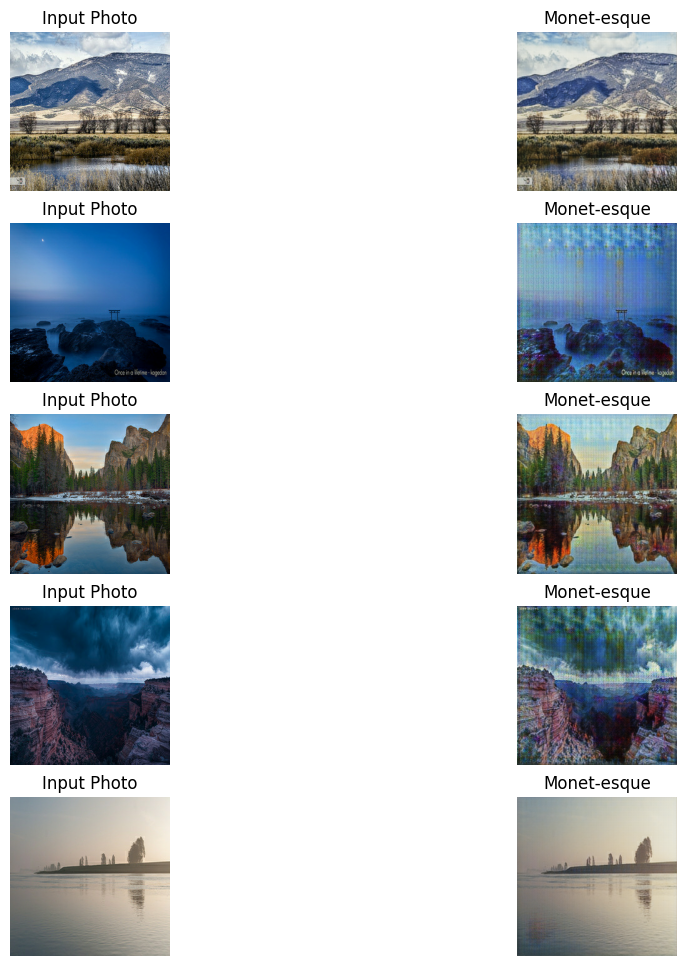

In [10]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Create Submission

In [11]:
import PIL
! mkdir ../images

In [12]:
i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [13]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'